In [1]:
# ==============================================================================
# BÖLÜM 1: Gerekli Kütüphaneleri İçe Aktarma
# ==============================================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import random

2025-09-26 00:41:38.965378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758847299.167205      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758847299.224196      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ==============================================================================
# BÖLÜM 2: Veri Hazırlığı ve Ön İşleme
# ==============================================================================
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

print("Veri hazırlığı başlatılıyor...")

# Veri setinin ana dizin yolu.
# Kaggle ortamında veri setlerinin yolu genellikle '/kaggle/input/' ile başlar.
base_dir = "/kaggle/input/breast-histopathology-images"

# Tüm görüntü yollarını ve etiketlerini depolamak için boş listeler
image_paths = []
labels = []

# Ana dizindeki tüm hasta klasörlerini döngü ile gez
for patient_folder in os.listdir(base_dir):
    # Hastanın tam yolunu oluştur
    patient_path = os.path.join(base_dir, patient_folder)
    
    # Sadece klasörleri işleme al (dosyaları atla)
    if not os.path.isdir(patient_path):
        continue
    
    # Her hasta klasöründeki "0" (benign) ve "1" (malignant) alt klasörlerini gez
    for label_folder in ["0", "1"]:
        # Etiket klasörünün tam yolunu oluştur
        folder_path = os.path.join(patient_path, label_folder)
        
        # Klasör varsa devam et
        if os.path.exists(folder_path):
            # Klasördeki tüm görüntü dosyalarını gez
            for img_file in os.listdir(folder_path):
                # Sadece .png uzantılı dosyaları al
                if img_file.endswith(".png"):
                    # Görüntü dosyasının tam yolunu image_paths listesine ekle
                    image_paths.append(os.path.join(folder_path, img_file))
                    # İlgili etiketi (0 veya 1) labels listesine ekle
                    labels.append(int(label_folder))

# Toplanan verileri kullanarak bir pandas DataFrame'i oluştur
data_df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})

# DataFrame'in ilk 5 satırını ve toplam örnek sayısını yazdır
print("Toplam örnek sayısı:", len(data_df))
print(data_df.head())

# ---
# Veri Kümesini Dengeli Olarak Küçültme
# ---
print("Veri kümesi dengeli olarak örnekleniyor...")
# Her sınıftan (0 ve 1) 5000 adet örnek seçiyoruz.
samples_per_class = 5000 
df_0 = data_df[data_df['label'] == 0].sample(n=samples_per_class, random_state=42)
df_1 = data_df[data_df['label'] == 1].sample(n=samples_per_class, random_state=42)
# Örneklenmiş veri çerçevelerini birleştirip karıştırıyoruz.
data_df = pd.concat([df_0, df_1]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Yeni dengeli örnek sayısı: {len(data_df)}")
print(data_df['label'].value_counts())


Veri hazırlığı başlatılıyor...


Toplam örnek sayısı: 277524
                                          image_path  label
0  /kaggle/input/breast-histopathology-images/102...      0
1  /kaggle/input/breast-histopathology-images/102...      0
2  /kaggle/input/breast-histopathology-images/102...      0
3  /kaggle/input/breast-histopathology-images/102...      0
4  /kaggle/input/breast-histopathology-images/102...      0
Veri kümesi dengeli olarak örnekleniyor...
Yeni dengeli örnek sayısı: 10000
label
1    5000
0    5000
Name: count, dtype: int64



Veri görselleştirme başlatılıyor...


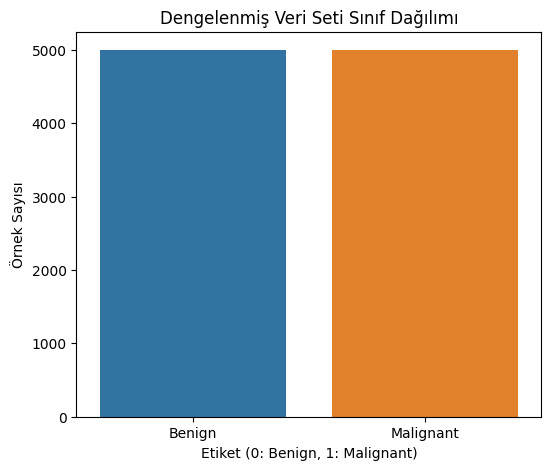

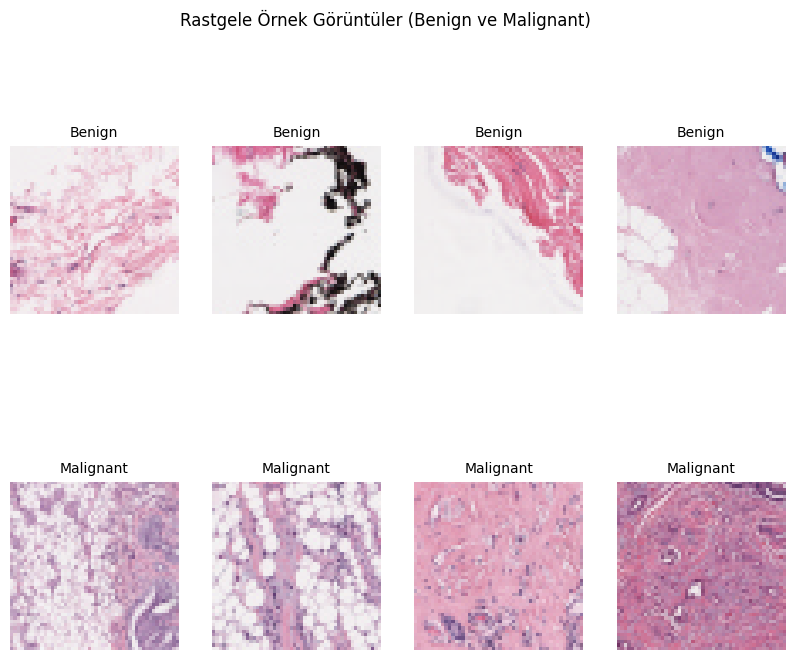

X shape: (10000, 128, 128, 3)
y shape: (10000,)


Train set: (8000, 128, 128, 3) (8000,)
Test set: (2000, 128, 128, 3) (2000,)
Veri hazırlığı tamamlandı.


In [3]:
# ==============================================================================
# BÖLÜM 2.1: Veri Görselleştirmeleri (EKLENDİ)
# Bu bölümde veri seti hakkında görsel istatistikler sunulur.
# ==============================================================================
print("\nVeri görselleştirme başlatılıyor...")

# Dengelenmiş veri setindeki sınıf dağılımını görselleştir
plt.figure(figsize=(6, 5))
sns.countplot(x='label', data=data_df)
plt.title('Dengelenmiş Veri Seti Sınıf Dağılımı')
plt.xlabel('Etiket (0: Benign, 1: Malignant)')
plt.ylabel('Örnek Sayısı')
plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.show()

# Her sınıftan rastgele birkaç örnek görselleştir
plt.figure(figsize=(10, 8))
benign_samples = data_df[data_df['label'] == 0].sample(4, random_state=42)
malignant_samples = data_df[data_df['label'] == 1].sample(4, random_state=42)
sample_df = pd.concat([benign_samples, malignant_samples])

for i, (idx, row) in enumerate(sample_df.iterrows()):
    plt.subplot(2, 4, i + 1)
    img = load_img(row['image_path'])
    plt.imshow(img)
    plt.title(f"{'Malignant' if row['label'] == 1 else 'Benign'}", fontsize=10)
    plt.axis('off')
plt.suptitle('Rastgele Örnek Görüntüler (Benign ve Malignant)')
plt.show()


# ---
# Görüntü Yükleme ve Ön İşleme
# ---

# Görüntüleri yüklemek ve ön işlemek için sabit boyut tanımla
IMG_SIZE = (128, 128)

# Görüntüleri ve etiketleri depolamak için NumPy dizileri
X = []  # Görüntüler
y = []  # Etiketler

# Örneklenmiş DataFrame'deki tüm görüntüler üzerinde döngü yaparak yükleme ve ön işleme yap
for _, row in data_df.iterrows():
    try:
        # Görüntüyü belirtilen boyuta yeniden boyutlandırarak yükle
        img = load_img(row['image_path'], target_size=IMG_SIZE)
        # Görüntüyü bir NumPy dizisine dönüştür ve 0-1 arasına normalleştir
        img_array = img_to_array(img) / 255.0
        # İşlenmiş görüntüyü X listesine ekle
        X.append(img_array)
        # Etiketi y listesine ekle
        y.append(row['label'])
    except Exception as e:
        print(f"Hata oluştu: {row['image_path']}, Hata: {e}")

# Python listelerini NumPy dizilerine dönüştür
X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

# ---
# Veri Setini Ayırma
# ---

# Veriyi eğitim ve test kümelerine ayır
# test_size=0.2 (verinin %20'si test için ayrılır)
# stratify=y (etiket dağılımını eğitim ve test kümelerinde aynı tutar)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)
print("Veri hazırlığı tamamlandı.")

In [4]:
# ==============================================================================
# BÖLÜM 3: Model Tanımlama ve Eğitme
# ==============================================================================
print("\nModel oluşturuluyor...")
model = Sequential([
    # İlk evrişim katmanı: 32 filtre, 3x3 kernel, relu aktivasyonu. Giriş boyutu 128x128x3.
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    # Maksimum havuzlama katmanı: 2x2 pencere ile boyutu küçültür
    MaxPooling2D((2,2)),
    
    # İkinci evrişim katmanı: 64 filtre
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    # Üçüncü evrişim katmanı: 128 filtre
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    # Görsel veriyi 1D vektöre dönüştür
    Flatten(),
    
    # Tam bağlantılı gizli katman: 128 nöron, relu aktivasyonu
    Dense(128, activation='relu'),
    # Dropout katmanı: Aşırı uydurmayı (overfitting) önlemek için nöronların %50'sini rastgele kapatır
    Dropout(0.5),
    
    # Çıkış katmanı: 1 nöron (binary classification için)
    # sigmoid aktivasyonu, çıktıyı 0-1 arasına sıkıştırır
    Dense(1, activation='sigmoid')
])

# Modeli derle
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model özetini göster
model.summary()

# Eğitim verisi için veri artırma (Data Augmentation)
# Bu teknik, modelin genelleme yeteneğini artırarak aşırı uydurmayı önler.
train_datagen = ImageDataGenerator(
    rotation_range=20,      # Rastgele döndürme
    width_shift_range=0.1,  # Yatay kaydırma
    height_shift_range=0.1, # Dikey kaydırma
    zoom_range=0.1,         # Rastgele yakınlaştırma
    horizontal_flip=True,   # Yatay çevirme
    vertical_flip=True      # Dikey çevirme
)

# Eğitim verisini ImageDataGenerator ile akışa al
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

print("\nModel eğitimi başlatılıyor...")
# Modeli artırılmış veri ile eğit
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train)//32, # Her adımda kaç batch işleneceği
    epochs=10,                      # Eğitim döngüsü sayısı
    validation_data=(X_test, y_test)  # Doğrulama verisi
)

# Modeli kaydet
model.save("breast_cancer_cnn_model.keras")
print("\nModel başarıyla kaydedildi: breast_cancer_cnn_model.keras")


Model oluşturuluyor...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-26 00:43:49.617347: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)


Model eğitimi başlatılıyor...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


  1/250 ━━━━━━━━━━━━━━━━━━━━ 14:11 3s/step - accuracy: 0.3750 - loss: 0.7035

  2/250 ━━━━━━━━━━━━━━━━━━━━ 2:15 545ms/step - accuracy: 0.4297 - loss: 0.7071

  3/250 ━━━━━━━━━━━━━━━━━━━━ 2:16 555ms/step - accuracy: 0.4705 - loss: 0.7138

  4/250 ━━━━━━━━━━━━━━━━━━━━ 2:13 544ms/step - accuracy: 0.4915 - loss: 0.7228

  5/250 ━━━━━━━━━━━━━━━━━━━━ 2:17 559ms/step - accuracy: 0.5032 - loss: 0.7267

  6/250 ━━━━━━━━━━━━━━━━━━━━ 2:15 557ms/step - accuracy: 0.5062 - loss: 0.7295

  7/250 ━━━━━━━━━━━━━━━━━━━━ 2:14 554ms/step - accuracy: 0.5097 - loss: 0.7307

  8/250 ━━━━━━━━━━━━━━━━━━━━ 2:12 548ms/step - accuracy: 0.5124 - loss: 0.7307

  9/250 ━━━━━━━━━━━━━━━━━━━━ 2:11 547ms/step - accuracy: 0.5134 - loss: 0.7305

 10/250 ━━━━━━━━━━━━━━━━━━━━ 2:10 545ms/step - accuracy: 0.5139 - loss: 0.7300

 11/250 ━━━━━━━━━━━━━━━━━━━━ 2:10 545ms/step - accuracy: 0.5152 - loss: 0.7292

 12/250 ━━━━━━━━━━━━━━━━━━━━ 2:09 543ms/step - accuracy: 0.5166 - loss: 0.7282

 13/250 ━━━━━━━━━━━━━━━━━━━━ 2:08 543ms/step - accuracy: 0.5179 - loss: 0.7270

 14/250 ━━━━━━━━━━━━━━━━━━━━ 2:07 542ms/step - accuracy: 0.5193 - loss: 0.7259

 15/250 ━━━━━━━━━━━━━━━━━━━━ 2:07 541ms/step - accuracy: 0.5211 - loss: 0.7246

 16/250 ━━━━━━━━━━━━━━━━━━━━ 2:06 542ms/step - accuracy: 0.5222 - loss: 0.7235

 17/250 ━━━━━━━━━━━━━━━━━━━━ 2:06 542ms/step - accuracy: 0.5234 - loss: 0.7223

 18/250 ━━━━━━━━━━━━━━━━━━━━ 2:05 541ms/step - accuracy: 0.5249 - loss: 0.7211

 19/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 540ms/step - accuracy: 0.5258 - loss: 0.7202

 20/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 540ms/step - accuracy: 0.5268 - loss: 0.7194

 21/250 ━━━━━━━━━━━━━━━━━━━━ 2:03 539ms/step - accuracy: 0.5275 - loss: 0.7186

 22/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 538ms/step - accuracy: 0.5283 - loss: 0.7178

 23/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 539ms/step - accuracy: 0.5293 - loss: 0.7170

 24/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 539ms/step - accuracy: 0.5302 - loss: 0.7161

 25/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 539ms/step - accuracy: 0.5309 - loss: 0.7154

 26/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 538ms/step - accuracy: 0.5318 - loss: 0.7146

 27/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 537ms/step - accuracy: 0.5327 - loss: 0.7138

 28/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 536ms/step - accuracy: 0.5339 - loss: 0.7130

 29/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 535ms/step - accuracy: 0.5352 - loss: 0.7121

 30/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 534ms/step - accuracy: 0.5365 - loss: 0.7112

 31/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 534ms/step - accuracy: 0.5377 - loss: 0.7104

 32/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 533ms/step - accuracy: 0.5391 - loss: 0.7095

 33/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 532ms/step - accuracy: 0.5403 - loss: 0.7087

 34/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 532ms/step - accuracy: 0.5415 - loss: 0.7078

 35/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 531ms/step - accuracy: 0.5428 - loss: 0.7070

 36/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 531ms/step - accuracy: 0.5441 - loss: 0.7060

 37/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 530ms/step - accuracy: 0.5454 - loss: 0.7051

 38/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 530ms/step - accuracy: 0.5468 - loss: 0.7040

 39/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 530ms/step - accuracy: 0.5482 - loss: 0.7030

 40/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 530ms/step - accuracy: 0.5497 - loss: 0.7019

 41/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 529ms/step - accuracy: 0.5512 - loss: 0.7008

 42/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 530ms/step - accuracy: 0.5527 - loss: 0.6997

 43/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 530ms/step - accuracy: 0.5541 - loss: 0.6987

 44/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 530ms/step - accuracy: 0.5556 - loss: 0.6976

 45/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 529ms/step - accuracy: 0.5570 - loss: 0.6965

 46/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 528ms/step - accuracy: 0.5585 - loss: 0.6953

 47/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 528ms/step - accuracy: 0.5599 - loss: 0.6944

 48/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 528ms/step - accuracy: 0.5613 - loss: 0.6935

 49/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 528ms/step - accuracy: 0.5626 - loss: 0.6927

 50/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 528ms/step - accuracy: 0.5638 - loss: 0.6918

 51/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 528ms/step - accuracy: 0.5650 - loss: 0.6910

 52/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 528ms/step - accuracy: 0.5662 - loss: 0.6902

 53/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 527ms/step - accuracy: 0.5674 - loss: 0.6894

 54/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 527ms/step - accuracy: 0.5685 - loss: 0.6887

 55/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 527ms/step - accuracy: 0.5696 - loss: 0.6879

 56/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 526ms/step - accuracy: 0.5706 - loss: 0.6871

 57/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 526ms/step - accuracy: 0.5717 - loss: 0.6864

 58/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 526ms/step - accuracy: 0.5728 - loss: 0.6856

 59/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 526ms/step - accuracy: 0.5739 - loss: 0.6848

 60/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 526ms/step - accuracy: 0.5750 - loss: 0.6841

 61/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 526ms/step - accuracy: 0.5761 - loss: 0.6833

 62/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 526ms/step - accuracy: 0.5772 - loss: 0.6826

 63/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 526ms/step - accuracy: 0.5783 - loss: 0.6818

 64/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 526ms/step - accuracy: 0.5794 - loss: 0.6811

 65/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 526ms/step - accuracy: 0.5805 - loss: 0.6803

 66/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 526ms/step - accuracy: 0.5815 - loss: 0.6796

 67/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 526ms/step - accuracy: 0.5826 - loss: 0.6788

 68/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 526ms/step - accuracy: 0.5836 - loss: 0.6781

 69/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 526ms/step - accuracy: 0.5846 - loss: 0.6774

 70/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 526ms/step - accuracy: 0.5856 - loss: 0.6767

 71/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 526ms/step - accuracy: 0.5866 - loss: 0.6761

 72/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 526ms/step - accuracy: 0.5876 - loss: 0.6754

 73/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 525ms/step - accuracy: 0.5886 - loss: 0.6748

 74/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 525ms/step - accuracy: 0.5895 - loss: 0.6741

 75/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 525ms/step - accuracy: 0.5904 - loss: 0.6735

 76/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 525ms/step - accuracy: 0.5914 - loss: 0.6728

 77/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 525ms/step - accuracy: 0.5923 - loss: 0.6722

 78/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 525ms/step - accuracy: 0.5932 - loss: 0.6715

 79/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 525ms/step - accuracy: 0.5941 - loss: 0.6709

 80/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 525ms/step - accuracy: 0.5950 - loss: 0.6702

 81/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 525ms/step - accuracy: 0.5958 - loss: 0.6696

 82/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 525ms/step - accuracy: 0.5967 - loss: 0.6689

 83/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 525ms/step - accuracy: 0.5975 - loss: 0.6683

 84/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 525ms/step - accuracy: 0.5984 - loss: 0.6676

 85/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 525ms/step - accuracy: 0.5992 - loss: 0.6670

 86/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 525ms/step - accuracy: 0.6001 - loss: 0.6663

 87/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 524ms/step - accuracy: 0.6009 - loss: 0.6657

 88/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 524ms/step - accuracy: 0.6017 - loss: 0.6650

 89/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 524ms/step - accuracy: 0.6025 - loss: 0.6644

 90/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 524ms/step - accuracy: 0.6033 - loss: 0.6638

 91/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 524ms/step - accuracy: 0.6041 - loss: 0.6632

 92/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 524ms/step - accuracy: 0.6049 - loss: 0.6625

 93/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 524ms/step - accuracy: 0.6056 - loss: 0.6619

 94/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 524ms/step - accuracy: 0.6064 - loss: 0.6613

 95/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 524ms/step - accuracy: 0.6072 - loss: 0.6607

 96/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 524ms/step - accuracy: 0.6079 - loss: 0.6600

 97/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 523ms/step - accuracy: 0.6087 - loss: 0.6594

 98/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 523ms/step - accuracy: 0.6094 - loss: 0.6588

 99/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 523ms/step - accuracy: 0.6102 - loss: 0.6582

100/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 524ms/step - accuracy: 0.6109 - loss: 0.6576

101/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 524ms/step - accuracy: 0.6116 - loss: 0.6571

102/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 524ms/step - accuracy: 0.6123 - loss: 0.6565

103/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 523ms/step - accuracy: 0.6130 - loss: 0.6559

104/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 523ms/step - accuracy: 0.6137 - loss: 0.6553

105/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 523ms/step - accuracy: 0.6144 - loss: 0.6547

106/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 523ms/step - accuracy: 0.6151 - loss: 0.6542

107/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 523ms/step - accuracy: 0.6158 - loss: 0.6536

108/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 523ms/step - accuracy: 0.6165 - loss: 0.6531

109/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 523ms/step - accuracy: 0.6172 - loss: 0.6525

110/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 523ms/step - accuracy: 0.6178 - loss: 0.6520

111/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 523ms/step - accuracy: 0.6185 - loss: 0.6515

112/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 523ms/step - accuracy: 0.6192 - loss: 0.6509

113/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 523ms/step - accuracy: 0.6199 - loss: 0.6503

114/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 523ms/step - accuracy: 0.6205 - loss: 0.6498

115/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 523ms/step - accuracy: 0.6212 - loss: 0.6492

116/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 523ms/step - accuracy: 0.6219 - loss: 0.6487

117/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 522ms/step - accuracy: 0.6225 - loss: 0.6482

118/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 522ms/step - accuracy: 0.6231 - loss: 0.6476

119/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 522ms/step - accuracy: 0.6238 - loss: 0.6471

120/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 523ms/step - accuracy: 0.6244 - loss: 0.6466

121/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 523ms/step - accuracy: 0.6250 - loss: 0.6460

122/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 523ms/step - accuracy: 0.6256 - loss: 0.6455

123/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 523ms/step - accuracy: 0.6262 - loss: 0.6450

124/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 523ms/step - accuracy: 0.6268 - loss: 0.6445

125/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 523ms/step - accuracy: 0.6274 - loss: 0.6440

126/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 522ms/step - accuracy: 0.6280 - loss: 0.6435

127/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 522ms/step - accuracy: 0.6286 - loss: 0.6430

128/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 522ms/step - accuracy: 0.6291 - loss: 0.6425

129/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 522ms/step - accuracy: 0.6297 - loss: 0.6420

130/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 522ms/step - accuracy: 0.6303 - loss: 0.6416

131/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 522ms/step - accuracy: 0.6308 - loss: 0.6411

132/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 522ms/step - accuracy: 0.6314 - loss: 0.6406

133/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 522ms/step - accuracy: 0.6319 - loss: 0.6401

134/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 522ms/step - accuracy: 0.6325 - loss: 0.6397

135/250 ━━━━━━━━━━━━━━━━━━━━ 59s 522ms/step - accuracy: 0.6330 - loss: 0.6392 

136/250 ━━━━━━━━━━━━━━━━━━━━ 59s 522ms/step - accuracy: 0.6336 - loss: 0.6387

137/250 ━━━━━━━━━━━━━━━━━━━━ 58s 522ms/step - accuracy: 0.6341 - loss: 0.6383

138/250 ━━━━━━━━━━━━━━━━━━━━ 58s 521ms/step - accuracy: 0.6347 - loss: 0.6378

139/250 ━━━━━━━━━━━━━━━━━━━━ 57s 522ms/step - accuracy: 0.6352 - loss: 0.6374

140/250 ━━━━━━━━━━━━━━━━━━━━ 57s 522ms/step - accuracy: 0.6357 - loss: 0.6369

141/250 ━━━━━━━━━━━━━━━━━━━━ 56s 521ms/step - accuracy: 0.6362 - loss: 0.6364

142/250 ━━━━━━━━━━━━━━━━━━━━ 56s 521ms/step - accuracy: 0.6367 - loss: 0.6360

143/250 ━━━━━━━━━━━━━━━━━━━━ 55s 521ms/step - accuracy: 0.6373 - loss: 0.6355

144/250 ━━━━━━━━━━━━━━━━━━━━ 55s 521ms/step - accuracy: 0.6378 - loss: 0.6350

145/250 ━━━━━━━━━━━━━━━━━━━━ 54s 521ms/step - accuracy: 0.6383 - loss: 0.6346

146/250 ━━━━━━━━━━━━━━━━━━━━ 54s 521ms/step - accuracy: 0.6388 - loss: 0.6341

147/250 ━━━━━━━━━━━━━━━━━━━━ 53s 521ms/step - accuracy: 0.6392 - loss: 0.6337

148/250 ━━━━━━━━━━━━━━━━━━━━ 53s 521ms/step - accuracy: 0.6397 - loss: 0.6332

149/250 ━━━━━━━━━━━━━━━━━━━━ 52s 521ms/step - accuracy: 0.6402 - loss: 0.6328

150/250 ━━━━━━━━━━━━━━━━━━━━ 52s 520ms/step - accuracy: 0.6407 - loss: 0.6324

151/250 ━━━━━━━━━━━━━━━━━━━━ 51s 520ms/step - accuracy: 0.6412 - loss: 0.6319

152/250 ━━━━━━━━━━━━━━━━━━━━ 50s 520ms/step - accuracy: 0.6417 - loss: 0.6315

153/250 ━━━━━━━━━━━━━━━━━━━━ 50s 520ms/step - accuracy: 0.6421 - loss: 0.6310

154/250 ━━━━━━━━━━━━━━━━━━━━ 49s 520ms/step - accuracy: 0.6426 - loss: 0.6306

155/250 ━━━━━━━━━━━━━━━━━━━━ 49s 520ms/step - accuracy: 0.6431 - loss: 0.6302

156/250 ━━━━━━━━━━━━━━━━━━━━ 48s 520ms/step - accuracy: 0.6435 - loss: 0.6298

157/250 ━━━━━━━━━━━━━━━━━━━━ 48s 520ms/step - accuracy: 0.6440 - loss: 0.6294

158/250 ━━━━━━━━━━━━━━━━━━━━ 47s 520ms/step - accuracy: 0.6444 - loss: 0.6289

159/250 ━━━━━━━━━━━━━━━━━━━━ 47s 520ms/step - accuracy: 0.6449 - loss: 0.6285

160/250 ━━━━━━━━━━━━━━━━━━━━ 46s 520ms/step - accuracy: 0.6454 - loss: 0.6281

161/250 ━━━━━━━━━━━━━━━━━━━━ 46s 520ms/step - accuracy: 0.6458 - loss: 0.6277

162/250 ━━━━━━━━━━━━━━━━━━━━ 45s 519ms/step - accuracy: 0.6463 - loss: 0.6273

163/250 ━━━━━━━━━━━━━━━━━━━━ 45s 519ms/step - accuracy: 0.6467 - loss: 0.6269

164/250 ━━━━━━━━━━━━━━━━━━━━ 44s 519ms/step - accuracy: 0.6471 - loss: 0.6265

165/250 ━━━━━━━━━━━━━━━━━━━━ 44s 519ms/step - accuracy: 0.6476 - loss: 0.6261

166/250 ━━━━━━━━━━━━━━━━━━━━ 43s 519ms/step - accuracy: 0.6480 - loss: 0.6257

167/250 ━━━━━━━━━━━━━━━━━━━━ 43s 519ms/step - accuracy: 0.6484 - loss: 0.6253

168/250 ━━━━━━━━━━━━━━━━━━━━ 42s 519ms/step - accuracy: 0.6488 - loss: 0.6249

169/250 ━━━━━━━━━━━━━━━━━━━━ 42s 519ms/step - accuracy: 0.6493 - loss: 0.6246

170/250 ━━━━━━━━━━━━━━━━━━━━ 41s 519ms/step - accuracy: 0.6497 - loss: 0.6242

171/250 ━━━━━━━━━━━━━━━━━━━━ 40s 519ms/step - accuracy: 0.6501 - loss: 0.6238

172/250 ━━━━━━━━━━━━━━━━━━━━ 40s 519ms/step - accuracy: 0.6505 - loss: 0.6234

173/250 ━━━━━━━━━━━━━━━━━━━━ 39s 519ms/step - accuracy: 0.6509 - loss: 0.6231

174/250 ━━━━━━━━━━━━━━━━━━━━ 39s 519ms/step - accuracy: 0.6513 - loss: 0.6227

175/250 ━━━━━━━━━━━━━━━━━━━━ 38s 518ms/step - accuracy: 0.6517 - loss: 0.6223

176/250 ━━━━━━━━━━━━━━━━━━━━ 38s 518ms/step - accuracy: 0.6521 - loss: 0.6220

177/250 ━━━━━━━━━━━━━━━━━━━━ 37s 518ms/step - accuracy: 0.6525 - loss: 0.6216

178/250 ━━━━━━━━━━━━━━━━━━━━ 37s 519ms/step - accuracy: 0.6529 - loss: 0.6213

179/250 ━━━━━━━━━━━━━━━━━━━━ 36s 518ms/step - accuracy: 0.6533 - loss: 0.6209

180/250 ━━━━━━━━━━━━━━━━━━━━ 36s 518ms/step - accuracy: 0.6537 - loss: 0.6206

181/250 ━━━━━━━━━━━━━━━━━━━━ 35s 518ms/step - accuracy: 0.6541 - loss: 0.6202

182/250 ━━━━━━━━━━━━━━━━━━━━ 35s 518ms/step - accuracy: 0.6545 - loss: 0.6199

183/250 ━━━━━━━━━━━━━━━━━━━━ 34s 518ms/step - accuracy: 0.6549 - loss: 0.6195

184/250 ━━━━━━━━━━━━━━━━━━━━ 34s 518ms/step - accuracy: 0.6553 - loss: 0.6191

185/250 ━━━━━━━━━━━━━━━━━━━━ 33s 518ms/step - accuracy: 0.6556 - loss: 0.6188

186/250 ━━━━━━━━━━━━━━━━━━━━ 33s 518ms/step - accuracy: 0.6560 - loss: 0.6185

187/250 ━━━━━━━━━━━━━━━━━━━━ 32s 518ms/step - accuracy: 0.6564 - loss: 0.6181

188/250 ━━━━━━━━━━━━━━━━━━━━ 32s 518ms/step - accuracy: 0.6568 - loss: 0.6178

189/250 ━━━━━━━━━━━━━━━━━━━━ 31s 518ms/step - accuracy: 0.6571 - loss: 0.6174

190/250 ━━━━━━━━━━━━━━━━━━━━ 31s 518ms/step - accuracy: 0.6575 - loss: 0.6171

191/250 ━━━━━━━━━━━━━━━━━━━━ 30s 518ms/step - accuracy: 0.6579 - loss: 0.6168

192/250 ━━━━━━━━━━━━━━━━━━━━ 30s 518ms/step - accuracy: 0.6582 - loss: 0.6164

193/250 ━━━━━━━━━━━━━━━━━━━━ 29s 518ms/step - accuracy: 0.6586 - loss: 0.6161

194/250 ━━━━━━━━━━━━━━━━━━━━ 28s 518ms/step - accuracy: 0.6589 - loss: 0.6158

195/250 ━━━━━━━━━━━━━━━━━━━━ 28s 517ms/step - accuracy: 0.6593 - loss: 0.6155

196/250 ━━━━━━━━━━━━━━━━━━━━ 27s 517ms/step - accuracy: 0.6596 - loss: 0.6151

197/250 ━━━━━━━━━━━━━━━━━━━━ 27s 517ms/step - accuracy: 0.6600 - loss: 0.6148

198/250 ━━━━━━━━━━━━━━━━━━━━ 26s 517ms/step - accuracy: 0.6603 - loss: 0.6145

199/250 ━━━━━━━━━━━━━━━━━━━━ 26s 517ms/step - accuracy: 0.6606 - loss: 0.6142

200/250 ━━━━━━━━━━━━━━━━━━━━ 25s 517ms/step - accuracy: 0.6610 - loss: 0.6139

201/250 ━━━━━━━━━━━━━━━━━━━━ 25s 517ms/step - accuracy: 0.6613 - loss: 0.6136

202/250 ━━━━━━━━━━━━━━━━━━━━ 24s 517ms/step - accuracy: 0.6616 - loss: 0.6133

203/250 ━━━━━━━━━━━━━━━━━━━━ 24s 517ms/step - accuracy: 0.6619 - loss: 0.6130

204/250 ━━━━━━━━━━━━━━━━━━━━ 23s 517ms/step - accuracy: 0.6623 - loss: 0.6128

205/250 ━━━━━━━━━━━━━━━━━━━━ 23s 517ms/step - accuracy: 0.6626 - loss: 0.6125

206/250 ━━━━━━━━━━━━━━━━━━━━ 22s 517ms/step - accuracy: 0.6629 - loss: 0.6122

207/250 ━━━━━━━━━━━━━━━━━━━━ 22s 517ms/step - accuracy: 0.6632 - loss: 0.6119

208/250 ━━━━━━━━━━━━━━━━━━━━ 21s 517ms/step - accuracy: 0.6635 - loss: 0.6116

209/250 ━━━━━━━━━━━━━━━━━━━━ 21s 517ms/step - accuracy: 0.6638 - loss: 0.6113

210/250 ━━━━━━━━━━━━━━━━━━━━ 20s 516ms/step - accuracy: 0.6641 - loss: 0.6110

211/250 ━━━━━━━━━━━━━━━━━━━━ 20s 516ms/step - accuracy: 0.6645 - loss: 0.6108

212/250 ━━━━━━━━━━━━━━━━━━━━ 19s 516ms/step - accuracy: 0.6648 - loss: 0.6105

213/250 ━━━━━━━━━━━━━━━━━━━━ 19s 516ms/step - accuracy: 0.6651 - loss: 0.6102

214/250 ━━━━━━━━━━━━━━━━━━━━ 18s 516ms/step - accuracy: 0.6654 - loss: 0.6099

215/250 ━━━━━━━━━━━━━━━━━━━━ 18s 516ms/step - accuracy: 0.6657 - loss: 0.6097

216/250 ━━━━━━━━━━━━━━━━━━━━ 17s 516ms/step - accuracy: 0.6660 - loss: 0.6094

217/250 ━━━━━━━━━━━━━━━━━━━━ 17s 516ms/step - accuracy: 0.6663 - loss: 0.6091

218/250 ━━━━━━━━━━━━━━━━━━━━ 16s 516ms/step - accuracy: 0.6666 - loss: 0.6088

219/250 ━━━━━━━━━━━━━━━━━━━━ 15s 516ms/step - accuracy: 0.6669 - loss: 0.6086

220/250 ━━━━━━━━━━━━━━━━━━━━ 15s 516ms/step - accuracy: 0.6672 - loss: 0.6083

221/250 ━━━━━━━━━━━━━━━━━━━━ 14s 516ms/step - accuracy: 0.6675 - loss: 0.6080

222/250 ━━━━━━━━━━━━━━━━━━━━ 14s 516ms/step - accuracy: 0.6678 - loss: 0.6078

223/250 ━━━━━━━━━━━━━━━━━━━━ 13s 516ms/step - accuracy: 0.6681 - loss: 0.6075

224/250 ━━━━━━━━━━━━━━━━━━━━ 13s 516ms/step - accuracy: 0.6684 - loss: 0.6073

225/250 ━━━━━━━━━━━━━━━━━━━━ 12s 516ms/step - accuracy: 0.6686 - loss: 0.6070

226/250 ━━━━━━━━━━━━━━━━━━━━ 12s 516ms/step - accuracy: 0.6689 - loss: 0.6067

227/250 ━━━━━━━━━━━━━━━━━━━━ 11s 516ms/step - accuracy: 0.6692 - loss: 0.6065

228/250 ━━━━━━━━━━━━━━━━━━━━ 11s 516ms/step - accuracy: 0.6695 - loss: 0.6062

229/250 ━━━━━━━━━━━━━━━━━━━━ 10s 516ms/step - accuracy: 0.6698 - loss: 0.6060

230/250 ━━━━━━━━━━━━━━━━━━━━ 10s 516ms/step - accuracy: 0.6700 - loss: 0.6057

231/250 ━━━━━━━━━━━━━━━━━━━━ 9s 516ms/step - accuracy: 0.6703 - loss: 0.6055 

232/250 ━━━━━━━━━━━━━━━━━━━━ 9s 515ms/step - accuracy: 0.6706 - loss: 0.6053

233/250 ━━━━━━━━━━━━━━━━━━━━ 8s 515ms/step - accuracy: 0.6709 - loss: 0.6050

234/250 ━━━━━━━━━━━━━━━━━━━━ 8s 515ms/step - accuracy: 0.6711 - loss: 0.6048

235/250 ━━━━━━━━━━━━━━━━━━━━ 7s 515ms/step - accuracy: 0.6714 - loss: 0.6045

236/250 ━━━━━━━━━━━━━━━━━━━━ 7s 515ms/step - accuracy: 0.6717 - loss: 0.6043

237/250 ━━━━━━━━━━━━━━━━━━━━ 6s 515ms/step - accuracy: 0.6719 - loss: 0.6040

238/250 ━━━━━━━━━━━━━━━━━━━━ 6s 515ms/step - accuracy: 0.6722 - loss: 0.6038

239/250 ━━━━━━━━━━━━━━━━━━━━ 5s 515ms/step - accuracy: 0.6725 - loss: 0.6036

240/250 ━━━━━━━━━━━━━━━━━━━━ 5s 515ms/step - accuracy: 0.6727 - loss: 0.6033

241/250 ━━━━━━━━━━━━━━━━━━━━ 4s 515ms/step - accuracy: 0.6730 - loss: 0.6031

242/250 ━━━━━━━━━━━━━━━━━━━━ 4s 515ms/step - accuracy: 0.6732 - loss: 0.6028

243/250 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - accuracy: 0.6735 - loss: 0.6026

244/250 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - accuracy: 0.6738 - loss: 0.6024

245/250 ━━━━━━━━━━━━━━━━━━━━ 2s 515ms/step - accuracy: 0.6740 - loss: 0.6021

246/250 ━━━━━━━━━━━━━━━━━━━━ 2s 515ms/step - accuracy: 0.6743 - loss: 0.6019

247/250 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step - accuracy: 0.6745 - loss: 0.6017

248/250 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step - accuracy: 0.6748 - loss: 0.6014

249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.6750 - loss: 0.6012

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.6753 - loss: 0.6010

250/250 ━━━━━━━━━━━━━━━━━━━━ 143s 560ms/step - accuracy: 0.6755 - loss: 0.6008 - val_accuracy: 0.7925 - val_loss: 0.4702


Epoch 2/10


  1/250 ━━━━━━━━━━━━━━━━━━━━ 2:35 626ms/step - accuracy: 0.8125 - loss: 0.4062

  2/250 ━━━━━━━━━━━━━━━━━━━━ 2:06 510ms/step - accuracy: 0.8203 - loss: 0.4205

  3/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 506ms/step - accuracy: 0.8108 - loss: 0.4240

  4/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 507ms/step - accuracy: 0.7995 - loss: 0.4296

  5/250 ━━━━━━━━━━━━━━━━━━━━ 2:06 517ms/step - accuracy: 0.7946 - loss: 0.4296

  6/250 ━━━━━━━━━━━━━━━━━━━━ 2:05 513ms/step - accuracy: 0.7915 - loss: 0.4293

  7/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 510ms/step - accuracy: 0.7888 - loss: 0.4296

  8/250 ━━━━━━━━━━━━━━━━━━━━ 2:03 510ms/step - accuracy: 0.7898 - loss: 0.4279

  9/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 508ms/step - accuracy: 0.7900 - loss: 0.4283

 10/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 507ms/step - accuracy: 0.7913 - loss: 0.4278

 11/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 507ms/step - accuracy: 0.7927 - loss: 0.4276

 12/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 507ms/step - accuracy: 0.7928 - loss: 0.4286

 13/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 506ms/step - accuracy: 0.7925 - loss: 0.4302

 14/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 506ms/step - accuracy: 0.7917 - loss: 0.4320

 15/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 506ms/step - accuracy: 0.7916 - loss: 0.4332

 16/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 506ms/step - accuracy: 0.7913 - loss: 0.4346

 17/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 506ms/step - accuracy: 0.7912 - loss: 0.4359

 18/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 506ms/step - accuracy: 0.7910 - loss: 0.4373

 19/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 505ms/step - accuracy: 0.7910 - loss: 0.4383

 20/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 504ms/step - accuracy: 0.7904 - loss: 0.4399

 21/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 504ms/step - accuracy: 0.7898 - loss: 0.4415

 22/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 504ms/step - accuracy: 0.7895 - loss: 0.4428

 23/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 503ms/step - accuracy: 0.7891 - loss: 0.4441

 24/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 503ms/step - accuracy: 0.7888 - loss: 0.4452

 25/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 505ms/step - accuracy: 0.7882 - loss: 0.4464

 26/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 504ms/step - accuracy: 0.7876 - loss: 0.4477

 27/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 504ms/step - accuracy: 0.7872 - loss: 0.4489

 28/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 504ms/step - accuracy: 0.7867 - loss: 0.4502

 29/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 504ms/step - accuracy: 0.7862 - loss: 0.4514

 30/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 504ms/step - accuracy: 0.7858 - loss: 0.4526

 31/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 504ms/step - accuracy: 0.7853 - loss: 0.4538

 32/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 504ms/step - accuracy: 0.7850 - loss: 0.4548

 33/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 504ms/step - accuracy: 0.7847 - loss: 0.4558

 34/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 504ms/step - accuracy: 0.7845 - loss: 0.4567

 35/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 504ms/step - accuracy: 0.7842 - loss: 0.4576

 36/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 504ms/step - accuracy: 0.7841 - loss: 0.4583

 37/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 503ms/step - accuracy: 0.7839 - loss: 0.4590

 38/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 503ms/step - accuracy: 0.7837 - loss: 0.4597

 39/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 503ms/step - accuracy: 0.7835 - loss: 0.4604

 40/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 503ms/step - accuracy: 0.7834 - loss: 0.4610

 41/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 503ms/step - accuracy: 0.7832 - loss: 0.4616

 42/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 504ms/step - accuracy: 0.7831 - loss: 0.4622

 43/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 504ms/step - accuracy: 0.7828 - loss: 0.4628

 44/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 504ms/step - accuracy: 0.7826 - loss: 0.4635

 45/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 505ms/step - accuracy: 0.7825 - loss: 0.4641

 46/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 505ms/step - accuracy: 0.7824 - loss: 0.4645

 47/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 504ms/step - accuracy: 0.7824 - loss: 0.4649

 48/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 504ms/step - accuracy: 0.7823 - loss: 0.4653

 49/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 504ms/step - accuracy: 0.7823 - loss: 0.4656

 50/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 504ms/step - accuracy: 0.7824 - loss: 0.4659

 51/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 504ms/step - accuracy: 0.7824 - loss: 0.4661

 52/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 504ms/step - accuracy: 0.7825 - loss: 0.4664

 53/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 504ms/step - accuracy: 0.7825 - loss: 0.4666

 54/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 504ms/step - accuracy: 0.7825 - loss: 0.4668

 55/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 504ms/step - accuracy: 0.7826 - loss: 0.4670

 56/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 504ms/step - accuracy: 0.7827 - loss: 0.4672

 57/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 504ms/step - accuracy: 0.7828 - loss: 0.4674

 58/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 504ms/step - accuracy: 0.7828 - loss: 0.4675

 59/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 503ms/step - accuracy: 0.7830 - loss: 0.4675

 60/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 504ms/step - accuracy: 0.7831 - loss: 0.4676

 61/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 503ms/step - accuracy: 0.7832 - loss: 0.4677

 62/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 503ms/step - accuracy: 0.7833 - loss: 0.4679

 63/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 503ms/step - accuracy: 0.7833 - loss: 0.4680

 64/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 504ms/step - accuracy: 0.7834 - loss: 0.4681

 65/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 504ms/step - accuracy: 0.7835 - loss: 0.4682

 66/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 504ms/step - accuracy: 0.7835 - loss: 0.4683

 67/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 504ms/step - accuracy: 0.7835 - loss: 0.4685

 68/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 504ms/step - accuracy: 0.7836 - loss: 0.4686

 69/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 504ms/step - accuracy: 0.7837 - loss: 0.4687

 70/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 504ms/step - accuracy: 0.7837 - loss: 0.4687

 71/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 504ms/step - accuracy: 0.7838 - loss: 0.4688

 72/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 504ms/step - accuracy: 0.7838 - loss: 0.4690

 73/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 504ms/step - accuracy: 0.7839 - loss: 0.4691

 74/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 504ms/step - accuracy: 0.7839 - loss: 0.4692

 75/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 504ms/step - accuracy: 0.7840 - loss: 0.4693

 76/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 504ms/step - accuracy: 0.7840 - loss: 0.4694

 77/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 504ms/step - accuracy: 0.7840 - loss: 0.4696

 78/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 504ms/step - accuracy: 0.7841 - loss: 0.4697

 79/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 504ms/step - accuracy: 0.7841 - loss: 0.4698

 80/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 504ms/step - accuracy: 0.7842 - loss: 0.4700

 81/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 504ms/step - accuracy: 0.7842 - loss: 0.4701

 82/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 504ms/step - accuracy: 0.7842 - loss: 0.4702

 83/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 504ms/step - accuracy: 0.7843 - loss: 0.4704

 84/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 504ms/step - accuracy: 0.7843 - loss: 0.4705

 85/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 504ms/step - accuracy: 0.7843 - loss: 0.4707

 86/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 504ms/step - accuracy: 0.7843 - loss: 0.4709

 87/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 504ms/step - accuracy: 0.7843 - loss: 0.4710

 88/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 504ms/step - accuracy: 0.7843 - loss: 0.4712

 89/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 504ms/step - accuracy: 0.7843 - loss: 0.4714

 90/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 504ms/step - accuracy: 0.7843 - loss: 0.4716

 91/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 504ms/step - accuracy: 0.7842 - loss: 0.4718

 92/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 504ms/step - accuracy: 0.7842 - loss: 0.4720

 93/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 504ms/step - accuracy: 0.7841 - loss: 0.4722

 94/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 504ms/step - accuracy: 0.7840 - loss: 0.4725

 95/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 504ms/step - accuracy: 0.7840 - loss: 0.4727

 96/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 504ms/step - accuracy: 0.7840 - loss: 0.4729

 97/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 504ms/step - accuracy: 0.7839 - loss: 0.4731

 98/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 504ms/step - accuracy: 0.7839 - loss: 0.4733

 99/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 504ms/step - accuracy: 0.7839 - loss: 0.4735

100/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 504ms/step - accuracy: 0.7838 - loss: 0.4737

101/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 504ms/step - accuracy: 0.7838 - loss: 0.4738

102/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 504ms/step - accuracy: 0.7838 - loss: 0.4740

103/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 504ms/step - accuracy: 0.7838 - loss: 0.4742

104/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 504ms/step - accuracy: 0.7838 - loss: 0.4743

105/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 504ms/step - accuracy: 0.7838 - loss: 0.4745

106/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 504ms/step - accuracy: 0.7838 - loss: 0.4746

107/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 504ms/step - accuracy: 0.7838 - loss: 0.4748

108/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 504ms/step - accuracy: 0.7838 - loss: 0.4749

109/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 504ms/step - accuracy: 0.7838 - loss: 0.4750

110/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 504ms/step - accuracy: 0.7838 - loss: 0.4752

111/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 503ms/step - accuracy: 0.7838 - loss: 0.4753

112/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 503ms/step - accuracy: 0.7838 - loss: 0.4754

113/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 503ms/step - accuracy: 0.7838 - loss: 0.4755

114/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 503ms/step - accuracy: 0.7838 - loss: 0.4757

115/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 503ms/step - accuracy: 0.7838 - loss: 0.4758

116/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 503ms/step - accuracy: 0.7838 - loss: 0.4759

117/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 503ms/step - accuracy: 0.7838 - loss: 0.4760

118/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 503ms/step - accuracy: 0.7838 - loss: 0.4761

119/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 503ms/step - accuracy: 0.7838 - loss: 0.4762

120/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 503ms/step - accuracy: 0.7837 - loss: 0.4764

121/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 503ms/step - accuracy: 0.7837 - loss: 0.4765

122/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 503ms/step - accuracy: 0.7837 - loss: 0.4766

123/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 503ms/step - accuracy: 0.7837 - loss: 0.4767

124/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 503ms/step - accuracy: 0.7837 - loss: 0.4768

125/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 503ms/step - accuracy: 0.7837 - loss: 0.4769

126/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 503ms/step - accuracy: 0.7837 - loss: 0.4770

127/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 503ms/step - accuracy: 0.7837 - loss: 0.4771

128/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 503ms/step - accuracy: 0.7837 - loss: 0.4772

129/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 503ms/step - accuracy: 0.7837 - loss: 0.4773

130/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 503ms/step - accuracy: 0.7837 - loss: 0.4774

131/250 ━━━━━━━━━━━━━━━━━━━━ 59s 503ms/step - accuracy: 0.7837 - loss: 0.4774 

132/250 ━━━━━━━━━━━━━━━━━━━━ 59s 503ms/step - accuracy: 0.7837 - loss: 0.4775

133/250 ━━━━━━━━━━━━━━━━━━━━ 58s 503ms/step - accuracy: 0.7837 - loss: 0.4776

134/250 ━━━━━━━━━━━━━━━━━━━━ 58s 503ms/step - accuracy: 0.7837 - loss: 0.4777

135/250 ━━━━━━━━━━━━━━━━━━━━ 57s 503ms/step - accuracy: 0.7837 - loss: 0.4778

136/250 ━━━━━━━━━━━━━━━━━━━━ 57s 503ms/step - accuracy: 0.7837 - loss: 0.4778

137/250 ━━━━━━━━━━━━━━━━━━━━ 56s 503ms/step - accuracy: 0.7838 - loss: 0.4779

138/250 ━━━━━━━━━━━━━━━━━━━━ 56s 503ms/step - accuracy: 0.7838 - loss: 0.4780

139/250 ━━━━━━━━━━━━━━━━━━━━ 55s 503ms/step - accuracy: 0.7838 - loss: 0.4781

140/250 ━━━━━━━━━━━━━━━━━━━━ 55s 503ms/step - accuracy: 0.7838 - loss: 0.4782

141/250 ━━━━━━━━━━━━━━━━━━━━ 54s 503ms/step - accuracy: 0.7838 - loss: 0.4783

142/250 ━━━━━━━━━━━━━━━━━━━━ 54s 503ms/step - accuracy: 0.7838 - loss: 0.4784

143/250 ━━━━━━━━━━━━━━━━━━━━ 53s 503ms/step - accuracy: 0.7838 - loss: 0.4785

144/250 ━━━━━━━━━━━━━━━━━━━━ 53s 503ms/step - accuracy: 0.7838 - loss: 0.4785

145/250 ━━━━━━━━━━━━━━━━━━━━ 52s 503ms/step - accuracy: 0.7838 - loss: 0.4786

146/250 ━━━━━━━━━━━━━━━━━━━━ 52s 503ms/step - accuracy: 0.7838 - loss: 0.4787

147/250 ━━━━━━━━━━━━━━━━━━━━ 51s 503ms/step - accuracy: 0.7838 - loss: 0.4788

148/250 ━━━━━━━━━━━━━━━━━━━━ 51s 503ms/step - accuracy: 0.7838 - loss: 0.4789

149/250 ━━━━━━━━━━━━━━━━━━━━ 50s 503ms/step - accuracy: 0.7838 - loss: 0.4790

150/250 ━━━━━━━━━━━━━━━━━━━━ 50s 503ms/step - accuracy: 0.7838 - loss: 0.4791

151/250 ━━━━━━━━━━━━━━━━━━━━ 49s 503ms/step - accuracy: 0.7838 - loss: 0.4791

152/250 ━━━━━━━━━━━━━━━━━━━━ 49s 503ms/step - accuracy: 0.7838 - loss: 0.4792

153/250 ━━━━━━━━━━━━━━━━━━━━ 48s 503ms/step - accuracy: 0.7837 - loss: 0.4793

154/250 ━━━━━━━━━━━━━━━━━━━━ 48s 503ms/step - accuracy: 0.7837 - loss: 0.4794

155/250 ━━━━━━━━━━━━━━━━━━━━ 47s 503ms/step - accuracy: 0.7837 - loss: 0.4795

156/250 ━━━━━━━━━━━━━━━━━━━━ 47s 503ms/step - accuracy: 0.7837 - loss: 0.4796

157/250 ━━━━━━━━━━━━━━━━━━━━ 46s 503ms/step - accuracy: 0.7837 - loss: 0.4796

158/250 ━━━━━━━━━━━━━━━━━━━━ 46s 503ms/step - accuracy: 0.7837 - loss: 0.4797

159/250 ━━━━━━━━━━━━━━━━━━━━ 45s 503ms/step - accuracy: 0.7837 - loss: 0.4798

160/250 ━━━━━━━━━━━━━━━━━━━━ 45s 503ms/step - accuracy: 0.7837 - loss: 0.4798

161/250 ━━━━━━━━━━━━━━━━━━━━ 44s 503ms/step - accuracy: 0.7837 - loss: 0.4799

162/250 ━━━━━━━━━━━━━━━━━━━━ 44s 503ms/step - accuracy: 0.7837 - loss: 0.4800

163/250 ━━━━━━━━━━━━━━━━━━━━ 43s 503ms/step - accuracy: 0.7837 - loss: 0.4800

164/250 ━━━━━━━━━━━━━━━━━━━━ 43s 503ms/step - accuracy: 0.7837 - loss: 0.4801

165/250 ━━━━━━━━━━━━━━━━━━━━ 42s 503ms/step - accuracy: 0.7837 - loss: 0.4802

166/250 ━━━━━━━━━━━━━━━━━━━━ 42s 503ms/step - accuracy: 0.7837 - loss: 0.4802

167/250 ━━━━━━━━━━━━━━━━━━━━ 41s 503ms/step - accuracy: 0.7837 - loss: 0.4803

168/250 ━━━━━━━━━━━━━━━━━━━━ 41s 503ms/step - accuracy: 0.7837 - loss: 0.4803

169/250 ━━━━━━━━━━━━━━━━━━━━ 40s 503ms/step - accuracy: 0.7837 - loss: 0.4804

170/250 ━━━━━━━━━━━━━━━━━━━━ 40s 503ms/step - accuracy: 0.7837 - loss: 0.4804

171/250 ━━━━━━━━━━━━━━━━━━━━ 39s 503ms/step - accuracy: 0.7837 - loss: 0.4804

172/250 ━━━━━━━━━━━━━━━━━━━━ 39s 503ms/step - accuracy: 0.7837 - loss: 0.4805

173/250 ━━━━━━━━━━━━━━━━━━━━ 38s 503ms/step - accuracy: 0.7837 - loss: 0.4805

174/250 ━━━━━━━━━━━━━━━━━━━━ 38s 503ms/step - accuracy: 0.7837 - loss: 0.4805

175/250 ━━━━━━━━━━━━━━━━━━━━ 37s 503ms/step - accuracy: 0.7837 - loss: 0.4805

176/250 ━━━━━━━━━━━━━━━━━━━━ 37s 503ms/step - accuracy: 0.7837 - loss: 0.4806

177/250 ━━━━━━━━━━━━━━━━━━━━ 36s 503ms/step - accuracy: 0.7838 - loss: 0.4806

178/250 ━━━━━━━━━━━━━━━━━━━━ 36s 503ms/step - accuracy: 0.7838 - loss: 0.4806

179/250 ━━━━━━━━━━━━━━━━━━━━ 35s 503ms/step - accuracy: 0.7838 - loss: 0.4806

180/250 ━━━━━━━━━━━━━━━━━━━━ 35s 503ms/step - accuracy: 0.7838 - loss: 0.4806

181/250 ━━━━━━━━━━━━━━━━━━━━ 34s 503ms/step - accuracy: 0.7838 - loss: 0.4806

182/250 ━━━━━━━━━━━━━━━━━━━━ 34s 503ms/step - accuracy: 0.7838 - loss: 0.4806

183/250 ━━━━━━━━━━━━━━━━━━━━ 33s 503ms/step - accuracy: 0.7838 - loss: 0.4806

184/250 ━━━━━━━━━━━━━━━━━━━━ 33s 503ms/step - accuracy: 0.7838 - loss: 0.4806

185/250 ━━━━━━━━━━━━━━━━━━━━ 32s 503ms/step - accuracy: 0.7839 - loss: 0.4806

186/250 ━━━━━━━━━━━━━━━━━━━━ 32s 503ms/step - accuracy: 0.7839 - loss: 0.4806

187/250 ━━━━━━━━━━━━━━━━━━━━ 31s 503ms/step - accuracy: 0.7839 - loss: 0.4806

188/250 ━━━━━━━━━━━━━━━━━━━━ 31s 503ms/step - accuracy: 0.7839 - loss: 0.4807

189/250 ━━━━━━━━━━━━━━━━━━━━ 30s 503ms/step - accuracy: 0.7839 - loss: 0.4807

190/250 ━━━━━━━━━━━━━━━━━━━━ 30s 503ms/step - accuracy: 0.7839 - loss: 0.4807

191/250 ━━━━━━━━━━━━━━━━━━━━ 29s 503ms/step - accuracy: 0.7839 - loss: 0.4807

192/250 ━━━━━━━━━━━━━━━━━━━━ 29s 503ms/step - accuracy: 0.7839 - loss: 0.4807

193/250 ━━━━━━━━━━━━━━━━━━━━ 28s 503ms/step - accuracy: 0.7840 - loss: 0.4807

194/250 ━━━━━━━━━━━━━━━━━━━━ 28s 503ms/step - accuracy: 0.7840 - loss: 0.4807

195/250 ━━━━━━━━━━━━━━━━━━━━ 27s 503ms/step - accuracy: 0.7840 - loss: 0.4807

196/250 ━━━━━━━━━━━━━━━━━━━━ 27s 503ms/step - accuracy: 0.7840 - loss: 0.4807

197/250 ━━━━━━━━━━━━━━━━━━━━ 26s 502ms/step - accuracy: 0.7840 - loss: 0.4807

198/250 ━━━━━━━━━━━━━━━━━━━━ 26s 503ms/step - accuracy: 0.7840 - loss: 0.4807

199/250 ━━━━━━━━━━━━━━━━━━━━ 25s 503ms/step - accuracy: 0.7840 - loss: 0.4808

200/250 ━━━━━━━━━━━━━━━━━━━━ 25s 503ms/step - accuracy: 0.7840 - loss: 0.4808

201/250 ━━━━━━━━━━━━━━━━━━━━ 24s 503ms/step - accuracy: 0.7840 - loss: 0.4808

202/250 ━━━━━━━━━━━━━━━━━━━━ 24s 503ms/step - accuracy: 0.7840 - loss: 0.4808

203/250 ━━━━━━━━━━━━━━━━━━━━ 23s 503ms/step - accuracy: 0.7840 - loss: 0.4808

204/250 ━━━━━━━━━━━━━━━━━━━━ 23s 503ms/step - accuracy: 0.7841 - loss: 0.4808

205/250 ━━━━━━━━━━━━━━━━━━━━ 22s 503ms/step - accuracy: 0.7841 - loss: 0.4808

206/250 ━━━━━━━━━━━━━━━━━━━━ 22s 503ms/step - accuracy: 0.7841 - loss: 0.4808

207/250 ━━━━━━━━━━━━━━━━━━━━ 21s 503ms/step - accuracy: 0.7841 - loss: 0.4808

208/250 ━━━━━━━━━━━━━━━━━━━━ 21s 503ms/step - accuracy: 0.7841 - loss: 0.4808

209/250 ━━━━━━━━━━━━━━━━━━━━ 20s 503ms/step - accuracy: 0.7841 - loss: 0.4808

210/250 ━━━━━━━━━━━━━━━━━━━━ 20s 503ms/step - accuracy: 0.7841 - loss: 0.4808

211/250 ━━━━━━━━━━━━━━━━━━━━ 19s 503ms/step - accuracy: 0.7841 - loss: 0.4808

212/250 ━━━━━━━━━━━━━━━━━━━━ 19s 503ms/step - accuracy: 0.7841 - loss: 0.4808

213/250 ━━━━━━━━━━━━━━━━━━━━ 18s 503ms/step - accuracy: 0.7841 - loss: 0.4808

214/250 ━━━━━━━━━━━━━━━━━━━━ 18s 503ms/step - accuracy: 0.7841 - loss: 0.4808

215/250 ━━━━━━━━━━━━━━━━━━━━ 17s 503ms/step - accuracy: 0.7841 - loss: 0.4809

216/250 ━━━━━━━━━━━━━━━━━━━━ 17s 503ms/step - accuracy: 0.7841 - loss: 0.4809

217/250 ━━━━━━━━━━━━━━━━━━━━ 16s 503ms/step - accuracy: 0.7842 - loss: 0.4809

218/250 ━━━━━━━━━━━━━━━━━━━━ 16s 503ms/step - accuracy: 0.7842 - loss: 0.4809

219/250 ━━━━━━━━━━━━━━━━━━━━ 15s 503ms/step - accuracy: 0.7842 - loss: 0.4809

220/250 ━━━━━━━━━━━━━━━━━━━━ 15s 503ms/step - accuracy: 0.7842 - loss: 0.4809

221/250 ━━━━━━━━━━━━━━━━━━━━ 14s 503ms/step - accuracy: 0.7842 - loss: 0.4809

222/250 ━━━━━━━━━━━━━━━━━━━━ 14s 503ms/step - accuracy: 0.7842 - loss: 0.4809

223/250 ━━━━━━━━━━━━━━━━━━━━ 13s 503ms/step - accuracy: 0.7842 - loss: 0.4809

224/250 ━━━━━━━━━━━━━━━━━━━━ 13s 503ms/step - accuracy: 0.7842 - loss: 0.4809

225/250 ━━━━━━━━━━━━━━━━━━━━ 12s 503ms/step - accuracy: 0.7842 - loss: 0.4810

226/250 ━━━━━━━━━━━━━━━━━━━━ 12s 503ms/step - accuracy: 0.7842 - loss: 0.4810

227/250 ━━━━━━━━━━━━━━━━━━━━ 11s 503ms/step - accuracy: 0.7842 - loss: 0.4810

228/250 ━━━━━━━━━━━━━━━━━━━━ 11s 503ms/step - accuracy: 0.7842 - loss: 0.4810

229/250 ━━━━━━━━━━━━━━━━━━━━ 10s 503ms/step - accuracy: 0.7842 - loss: 0.4810

230/250 ━━━━━━━━━━━━━━━━━━━━ 10s 503ms/step - accuracy: 0.7842 - loss: 0.4811

231/250 ━━━━━━━━━━━━━━━━━━━━ 9s 503ms/step - accuracy: 0.7842 - loss: 0.4811 

232/250 ━━━━━━━━━━━━━━━━━━━━ 9s 503ms/step - accuracy: 0.7842 - loss: 0.4811

233/250 ━━━━━━━━━━━━━━━━━━━━ 8s 503ms/step - accuracy: 0.7842 - loss: 0.4811

234/250 ━━━━━━━━━━━━━━━━━━━━ 8s 503ms/step - accuracy: 0.7842 - loss: 0.4811

235/250 ━━━━━━━━━━━━━━━━━━━━ 7s 503ms/step - accuracy: 0.7843 - loss: 0.4811

236/250 ━━━━━━━━━━━━━━━━━━━━ 7s 503ms/step - accuracy: 0.7843 - loss: 0.4812

237/250 ━━━━━━━━━━━━━━━━━━━━ 6s 503ms/step - accuracy: 0.7843 - loss: 0.4812

238/250 ━━━━━━━━━━━━━━━━━━━━ 6s 503ms/step - accuracy: 0.7843 - loss: 0.4812

239/250 ━━━━━━━━━━━━━━━━━━━━ 5s 503ms/step - accuracy: 0.7843 - loss: 0.4812

240/250 ━━━━━━━━━━━━━━━━━━━━ 5s 503ms/step - accuracy: 0.7843 - loss: 0.4812

241/250 ━━━━━━━━━━━━━━━━━━━━ 4s 503ms/step - accuracy: 0.7843 - loss: 0.4812

242/250 ━━━━━━━━━━━━━━━━━━━━ 4s 503ms/step - accuracy: 0.7843 - loss: 0.4812

243/250 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - accuracy: 0.7843 - loss: 0.4812

244/250 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - accuracy: 0.7843 - loss: 0.4812

245/250 ━━━━━━━━━━━━━━━━━━━━ 2s 503ms/step - accuracy: 0.7843 - loss: 0.4812

246/250 ━━━━━━━━━━━━━━━━━━━━ 2s 503ms/step - accuracy: 0.7843 - loss: 0.4813

247/250 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step - accuracy: 0.7843 - loss: 0.4813

248/250 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step - accuracy: 0.7843 - loss: 0.4813

249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.7843 - loss: 0.4813

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.7843 - loss: 0.4813

250/250 ━━━━━━━━━━━━━━━━━━━━ 134s 537ms/step - accuracy: 0.7843 - loss: 0.4813 - val_accuracy: 0.8065 - val_loss: 0.4487


Epoch 3/10


  1/250 ━━━━━━━━━━━━━━━━━━━━ 2:36 629ms/step - accuracy: 0.7812 - loss: 0.5886

  2/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 502ms/step - accuracy: 0.8125 - loss: 0.5251

  3/250 ━━━━━━━━━━━━━━━━━━━━ 2:03 499ms/step - accuracy: 0.8368 - loss: 0.4739

  4/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 499ms/step - accuracy: 0.8444 - loss: 0.4569

  5/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 500ms/step - accuracy: 0.8455 - loss: 0.4489

  6/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 499ms/step - accuracy: 0.8470 - loss: 0.4406

  7/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 499ms/step - accuracy: 0.8471 - loss: 0.4358

  8/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 498ms/step - accuracy: 0.8487 - loss: 0.4308

  9/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 498ms/step - accuracy: 0.8489 - loss: 0.4280

 10/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 498ms/step - accuracy: 0.8481 - loss: 0.4266

 11/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 499ms/step - accuracy: 0.8474 - loss: 0.4254

 12/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 499ms/step - accuracy: 0.8456 - loss: 0.4263

 13/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 499ms/step - accuracy: 0.8436 - loss: 0.4273

 14/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 499ms/step - accuracy: 0.8419 - loss: 0.4281

 15/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 499ms/step - accuracy: 0.8402 - loss: 0.4289

 16/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 502ms/step - accuracy: 0.8388 - loss: 0.4295

 17/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 502ms/step - accuracy: 0.8376 - loss: 0.4300

 18/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 502ms/step - accuracy: 0.8368 - loss: 0.4302

 19/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 502ms/step - accuracy: 0.8361 - loss: 0.4306

 20/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 501ms/step - accuracy: 0.8353 - loss: 0.4310

 21/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 501ms/step - accuracy: 0.8344 - loss: 0.4315

 22/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 501ms/step - accuracy: 0.8336 - loss: 0.4321

 23/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 501ms/step - accuracy: 0.8330 - loss: 0.4322

 24/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 501ms/step - accuracy: 0.8324 - loss: 0.4325

 25/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 501ms/step - accuracy: 0.8319 - loss: 0.4325

 26/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 501ms/step - accuracy: 0.8314 - loss: 0.4327

 27/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 501ms/step - accuracy: 0.8309 - loss: 0.4328

 28/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 501ms/step - accuracy: 0.8306 - loss: 0.4328

 29/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 502ms/step - accuracy: 0.8302 - loss: 0.4329

 30/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 502ms/step - accuracy: 0.8299 - loss: 0.4329

 31/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 501ms/step - accuracy: 0.8295 - loss: 0.4330

 32/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 502ms/step - accuracy: 0.8291 - loss: 0.4332

 33/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 502ms/step - accuracy: 0.8288 - loss: 0.4333

 34/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 502ms/step - accuracy: 0.8285 - loss: 0.4332

 35/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 502ms/step - accuracy: 0.8282 - loss: 0.4333

 36/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 503ms/step - accuracy: 0.8279 - loss: 0.4335

 37/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 503ms/step - accuracy: 0.8275 - loss: 0.4337

 38/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 502ms/step - accuracy: 0.8272 - loss: 0.4340

 39/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 502ms/step - accuracy: 0.8269 - loss: 0.4341

 40/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 502ms/step - accuracy: 0.8266 - loss: 0.4343

 41/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 502ms/step - accuracy: 0.8263 - loss: 0.4344

 42/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 502ms/step - accuracy: 0.8262 - loss: 0.4344

 43/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 502ms/step - accuracy: 0.8259 - loss: 0.4345

 44/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 502ms/step - accuracy: 0.8257 - loss: 0.4345

 45/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 502ms/step - accuracy: 0.8255 - loss: 0.4346

 46/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 502ms/step - accuracy: 0.8254 - loss: 0.4346

 47/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 502ms/step - accuracy: 0.8252 - loss: 0.4347

 48/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 502ms/step - accuracy: 0.8250 - loss: 0.4347

 49/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 502ms/step - accuracy: 0.8249 - loss: 0.4348

 50/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 502ms/step - accuracy: 0.8247 - loss: 0.4349

 51/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 502ms/step - accuracy: 0.8245 - loss: 0.4349

 52/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 502ms/step - accuracy: 0.8244 - loss: 0.4349

 53/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 502ms/step - accuracy: 0.8242 - loss: 0.4350

 54/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 502ms/step - accuracy: 0.8241 - loss: 0.4351

 55/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 502ms/step - accuracy: 0.8240 - loss: 0.4352

 56/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 503ms/step - accuracy: 0.8238 - loss: 0.4353

 57/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 503ms/step - accuracy: 0.8237 - loss: 0.4354

 58/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 503ms/step - accuracy: 0.8236 - loss: 0.4355

 59/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 503ms/step - accuracy: 0.8235 - loss: 0.4356

 60/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 503ms/step - accuracy: 0.8234 - loss: 0.4357

 61/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 503ms/step - accuracy: 0.8232 - loss: 0.4359

 62/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 503ms/step - accuracy: 0.8230 - loss: 0.4360

 63/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 503ms/step - accuracy: 0.8228 - loss: 0.4362

 64/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 503ms/step - accuracy: 0.8226 - loss: 0.4364

 65/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 502ms/step - accuracy: 0.8225 - loss: 0.4365

 66/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 502ms/step - accuracy: 0.8223 - loss: 0.4366

 67/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 502ms/step - accuracy: 0.8222 - loss: 0.4367

 68/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 502ms/step - accuracy: 0.8220 - loss: 0.4368

 69/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 502ms/step - accuracy: 0.8219 - loss: 0.4369

 70/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 502ms/step - accuracy: 0.8218 - loss: 0.4370

 71/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 502ms/step - accuracy: 0.8216 - loss: 0.4372

 72/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 502ms/step - accuracy: 0.8215 - loss: 0.4373

 73/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 502ms/step - accuracy: 0.8214 - loss: 0.4374

 74/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 502ms/step - accuracy: 0.8212 - loss: 0.4375

 75/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 502ms/step - accuracy: 0.8211 - loss: 0.4377

 76/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 502ms/step - accuracy: 0.8209 - loss: 0.4378

 77/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 502ms/step - accuracy: 0.8207 - loss: 0.4380

 78/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 502ms/step - accuracy: 0.8206 - loss: 0.4381

 79/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 502ms/step - accuracy: 0.8205 - loss: 0.4382

 80/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 502ms/step - accuracy: 0.8203 - loss: 0.4384

 81/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 502ms/step - accuracy: 0.8202 - loss: 0.4385

 82/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 502ms/step - accuracy: 0.8201 - loss: 0.4386

 83/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 502ms/step - accuracy: 0.8200 - loss: 0.4387

 84/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 501ms/step - accuracy: 0.8198 - loss: 0.4388

 85/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 501ms/step - accuracy: 0.8197 - loss: 0.4389

 86/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 501ms/step - accuracy: 0.8196 - loss: 0.4391

 87/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 501ms/step - accuracy: 0.8194 - loss: 0.4392

 88/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 501ms/step - accuracy: 0.8193 - loss: 0.4393

 89/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 501ms/step - accuracy: 0.8192 - loss: 0.4394

 90/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 501ms/step - accuracy: 0.8191 - loss: 0.4396

 91/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 501ms/step - accuracy: 0.8189 - loss: 0.4397

 92/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 501ms/step - accuracy: 0.8188 - loss: 0.4398

 93/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 501ms/step - accuracy: 0.8187 - loss: 0.4400

 94/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 501ms/step - accuracy: 0.8186 - loss: 0.4401

 95/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 501ms/step - accuracy: 0.8185 - loss: 0.4402

 96/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 501ms/step - accuracy: 0.8184 - loss: 0.4403

 97/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 501ms/step - accuracy: 0.8183 - loss: 0.4405

 98/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 501ms/step - accuracy: 0.8182 - loss: 0.4406

 99/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 501ms/step - accuracy: 0.8181 - loss: 0.4407

100/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 501ms/step - accuracy: 0.8180 - loss: 0.4408

101/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 501ms/step - accuracy: 0.8179 - loss: 0.4409

102/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 501ms/step - accuracy: 0.8178 - loss: 0.4411

103/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 501ms/step - accuracy: 0.8177 - loss: 0.4412

104/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 501ms/step - accuracy: 0.8176 - loss: 0.4413

105/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 501ms/step - accuracy: 0.8175 - loss: 0.4414

106/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 501ms/step - accuracy: 0.8174 - loss: 0.4415

107/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 501ms/step - accuracy: 0.8173 - loss: 0.4415

108/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 501ms/step - accuracy: 0.8172 - loss: 0.4416

109/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 501ms/step - accuracy: 0.8171 - loss: 0.4417

110/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 501ms/step - accuracy: 0.8170 - loss: 0.4417

111/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 501ms/step - accuracy: 0.8170 - loss: 0.4418

112/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 501ms/step - accuracy: 0.8169 - loss: 0.4419

113/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 500ms/step - accuracy: 0.8168 - loss: 0.4420

114/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 500ms/step - accuracy: 0.8167 - loss: 0.4420

115/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 500ms/step - accuracy: 0.8166 - loss: 0.4421

116/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 501ms/step - accuracy: 0.8165 - loss: 0.4422

117/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 501ms/step - accuracy: 0.8165 - loss: 0.4423

118/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 501ms/step - accuracy: 0.8164 - loss: 0.4424

119/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 501ms/step - accuracy: 0.8163 - loss: 0.4425

120/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 501ms/step - accuracy: 0.8163 - loss: 0.4425

121/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 501ms/step - accuracy: 0.8162 - loss: 0.4426

122/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 501ms/step - accuracy: 0.8161 - loss: 0.4427

123/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 501ms/step - accuracy: 0.8160 - loss: 0.4428

124/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 501ms/step - accuracy: 0.8159 - loss: 0.4428

125/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 501ms/step - accuracy: 0.8159 - loss: 0.4429

126/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 501ms/step - accuracy: 0.8158 - loss: 0.4430

127/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 501ms/step - accuracy: 0.8157 - loss: 0.4430

128/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 500ms/step - accuracy: 0.8156 - loss: 0.4431

129/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 500ms/step - accuracy: 0.8155 - loss: 0.4432

130/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 500ms/step - accuracy: 0.8154 - loss: 0.4433

131/250 ━━━━━━━━━━━━━━━━━━━━ 59s 500ms/step - accuracy: 0.8153 - loss: 0.4434 

132/250 ━━━━━━━━━━━━━━━━━━━━ 59s 500ms/step - accuracy: 0.8153 - loss: 0.4435

133/250 ━━━━━━━━━━━━━━━━━━━━ 58s 500ms/step - accuracy: 0.8152 - loss: 0.4436

134/250 ━━━━━━━━━━━━━━━━━━━━ 58s 500ms/step - accuracy: 0.8151 - loss: 0.4436

135/250 ━━━━━━━━━━━━━━━━━━━━ 57s 500ms/step - accuracy: 0.8150 - loss: 0.4437

136/250 ━━━━━━━━━━━━━━━━━━━━ 57s 501ms/step - accuracy: 0.8149 - loss: 0.4438

137/250 ━━━━━━━━━━━━━━━━━━━━ 56s 501ms/step - accuracy: 0.8148 - loss: 0.4439

138/250 ━━━━━━━━━━━━━━━━━━━━ 56s 501ms/step - accuracy: 0.8148 - loss: 0.4440

139/250 ━━━━━━━━━━━━━━━━━━━━ 55s 501ms/step - accuracy: 0.8147 - loss: 0.4441

140/250 ━━━━━━━━━━━━━━━━━━━━ 55s 501ms/step - accuracy: 0.8146 - loss: 0.4442

141/250 ━━━━━━━━━━━━━━━━━━━━ 54s 501ms/step - accuracy: 0.8145 - loss: 0.4443

142/250 ━━━━━━━━━━━━━━━━━━━━ 54s 500ms/step - accuracy: 0.8144 - loss: 0.4443

143/250 ━━━━━━━━━━━━━━━━━━━━ 53s 500ms/step - accuracy: 0.8144 - loss: 0.4444

144/250 ━━━━━━━━━━━━━━━━━━━━ 53s 500ms/step - accuracy: 0.8143 - loss: 0.4445

145/250 ━━━━━━━━━━━━━━━━━━━━ 52s 500ms/step - accuracy: 0.8142 - loss: 0.4446

146/250 ━━━━━━━━━━━━━━━━━━━━ 52s 500ms/step - accuracy: 0.8141 - loss: 0.4447

147/250 ━━━━━━━━━━━━━━━━━━━━ 51s 500ms/step - accuracy: 0.8140 - loss: 0.4448

148/250 ━━━━━━━━━━━━━━━━━━━━ 51s 500ms/step - accuracy: 0.8140 - loss: 0.4449

149/250 ━━━━━━━━━━━━━━━━━━━━ 50s 500ms/step - accuracy: 0.8139 - loss: 0.4450

150/250 ━━━━━━━━━━━━━━━━━━━━ 50s 500ms/step - accuracy: 0.8138 - loss: 0.4450

151/250 ━━━━━━━━━━━━━━━━━━━━ 49s 500ms/step - accuracy: 0.8137 - loss: 0.4451

152/250 ━━━━━━━━━━━━━━━━━━━━ 49s 500ms/step - accuracy: 0.8136 - loss: 0.4452

153/250 ━━━━━━━━━━━━━━━━━━━━ 48s 500ms/step - accuracy: 0.8136 - loss: 0.4453

154/250 ━━━━━━━━━━━━━━━━━━━━ 48s 501ms/step - accuracy: 0.8135 - loss: 0.4454

155/250 ━━━━━━━━━━━━━━━━━━━━ 47s 501ms/step - accuracy: 0.8134 - loss: 0.4455

156/250 ━━━━━━━━━━━━━━━━━━━━ 47s 501ms/step - accuracy: 0.8133 - loss: 0.4455

157/250 ━━━━━━━━━━━━━━━━━━━━ 46s 501ms/step - accuracy: 0.8133 - loss: 0.4456

158/250 ━━━━━━━━━━━━━━━━━━━━ 46s 501ms/step - accuracy: 0.8132 - loss: 0.4457

159/250 ━━━━━━━━━━━━━━━━━━━━ 45s 501ms/step - accuracy: 0.8131 - loss: 0.4458

160/250 ━━━━━━━━━━━━━━━━━━━━ 45s 501ms/step - accuracy: 0.8130 - loss: 0.4459

161/250 ━━━━━━━━━━━━━━━━━━━━ 44s 501ms/step - accuracy: 0.8130 - loss: 0.4460

162/250 ━━━━━━━━━━━━━━━━━━━━ 44s 501ms/step - accuracy: 0.8129 - loss: 0.4461

163/250 ━━━━━━━━━━━━━━━━━━━━ 43s 501ms/step - accuracy: 0.8128 - loss: 0.4461

164/250 ━━━━━━━━━━━━━━━━━━━━ 43s 501ms/step - accuracy: 0.8127 - loss: 0.4462

165/250 ━━━━━━━━━━━━━━━━━━━━ 42s 501ms/step - accuracy: 0.8126 - loss: 0.4463

166/250 ━━━━━━━━━━━━━━━━━━━━ 42s 500ms/step - accuracy: 0.8126 - loss: 0.4464

167/250 ━━━━━━━━━━━━━━━━━━━━ 41s 500ms/step - accuracy: 0.8125 - loss: 0.4465

168/250 ━━━━━━━━━━━━━━━━━━━━ 41s 500ms/step - accuracy: 0.8124 - loss: 0.4465

169/250 ━━━━━━━━━━━━━━━━━━━━ 40s 500ms/step - accuracy: 0.8124 - loss: 0.4466

170/250 ━━━━━━━━━━━━━━━━━━━━ 40s 500ms/step - accuracy: 0.8123 - loss: 0.4467

171/250 ━━━━━━━━━━━━━━━━━━━━ 39s 500ms/step - accuracy: 0.8122 - loss: 0.4468

172/250 ━━━━━━━━━━━━━━━━━━━━ 39s 500ms/step - accuracy: 0.8121 - loss: 0.4469

173/250 ━━━━━━━━━━━━━━━━━━━━ 38s 500ms/step - accuracy: 0.8121 - loss: 0.4469

174/250 ━━━━━━━━━━━━━━━━━━━━ 38s 500ms/step - accuracy: 0.8120 - loss: 0.4470

175/250 ━━━━━━━━━━━━━━━━━━━━ 37s 500ms/step - accuracy: 0.8119 - loss: 0.4471

176/250 ━━━━━━━━━━━━━━━━━━━━ 37s 501ms/step - accuracy: 0.8119 - loss: 0.4472

177/250 ━━━━━━━━━━━━━━━━━━━━ 36s 500ms/step - accuracy: 0.8118 - loss: 0.4473

178/250 ━━━━━━━━━━━━━━━━━━━━ 36s 500ms/step - accuracy: 0.8117 - loss: 0.4473

179/250 ━━━━━━━━━━━━━━━━━━━━ 35s 500ms/step - accuracy: 0.8116 - loss: 0.4474

180/250 ━━━━━━━━━━━━━━━━━━━━ 35s 500ms/step - accuracy: 0.8116 - loss: 0.4475

181/250 ━━━━━━━━━━━━━━━━━━━━ 34s 500ms/step - accuracy: 0.8115 - loss: 0.4476

182/250 ━━━━━━━━━━━━━━━━━━━━ 34s 500ms/step - accuracy: 0.8114 - loss: 0.4476

183/250 ━━━━━━━━━━━━━━━━━━━━ 33s 500ms/step - accuracy: 0.8114 - loss: 0.4477

184/250 ━━━━━━━━━━━━━━━━━━━━ 33s 500ms/step - accuracy: 0.8113 - loss: 0.4478

185/250 ━━━━━━━━━━━━━━━━━━━━ 32s 500ms/step - accuracy: 0.8113 - loss: 0.4478

186/250 ━━━━━━━━━━━━━━━━━━━━ 32s 500ms/step - accuracy: 0.8112 - loss: 0.4479

187/250 ━━━━━━━━━━━━━━━━━━━━ 31s 500ms/step - accuracy: 0.8111 - loss: 0.4480

188/250 ━━━━━━━━━━━━━━━━━━━━ 31s 500ms/step - accuracy: 0.8110 - loss: 0.4480

189/250 ━━━━━━━━━━━━━━━━━━━━ 30s 500ms/step - accuracy: 0.8110 - loss: 0.4481

190/250 ━━━━━━━━━━━━━━━━━━━━ 30s 500ms/step - accuracy: 0.8109 - loss: 0.4482

191/250 ━━━━━━━━━━━━━━━━━━━━ 29s 500ms/step - accuracy: 0.8108 - loss: 0.4482

192/250 ━━━━━━━━━━━━━━━━━━━━ 29s 500ms/step - accuracy: 0.8108 - loss: 0.4483

193/250 ━━━━━━━━━━━━━━━━━━━━ 28s 500ms/step - accuracy: 0.8107 - loss: 0.4484

194/250 ━━━━━━━━━━━━━━━━━━━━ 28s 500ms/step - accuracy: 0.8106 - loss: 0.4485

195/250 ━━━━━━━━━━━━━━━━━━━━ 27s 500ms/step - accuracy: 0.8105 - loss: 0.4486

196/250 ━━━━━━━━━━━━━━━━━━━━ 27s 500ms/step - accuracy: 0.8105 - loss: 0.4487

197/250 ━━━━━━━━━━━━━━━━━━━━ 26s 500ms/step - accuracy: 0.8104 - loss: 0.4488

198/250 ━━━━━━━━━━━━━━━━━━━━ 26s 500ms/step - accuracy: 0.8103 - loss: 0.4489

199/250 ━━━━━━━━━━━━━━━━━━━━ 25s 500ms/step - accuracy: 0.8103 - loss: 0.4489

200/250 ━━━━━━━━━━━━━━━━━━━━ 25s 500ms/step - accuracy: 0.8102 - loss: 0.4490

201/250 ━━━━━━━━━━━━━━━━━━━━ 24s 500ms/step - accuracy: 0.8101 - loss: 0.4491

202/250 ━━━━━━━━━━━━━━━━━━━━ 24s 500ms/step - accuracy: 0.8100 - loss: 0.4492

203/250 ━━━━━━━━━━━━━━━━━━━━ 23s 500ms/step - accuracy: 0.8100 - loss: 0.4493

204/250 ━━━━━━━━━━━━━━━━━━━━ 23s 500ms/step - accuracy: 0.8099 - loss: 0.4494

205/250 ━━━━━━━━━━━━━━━━━━━━ 22s 500ms/step - accuracy: 0.8098 - loss: 0.4495

206/250 ━━━━━━━━━━━━━━━━━━━━ 22s 500ms/step - accuracy: 0.8097 - loss: 0.4496

207/250 ━━━━━━━━━━━━━━━━━━━━ 21s 500ms/step - accuracy: 0.8097 - loss: 0.4497

208/250 ━━━━━━━━━━━━━━━━━━━━ 21s 500ms/step - accuracy: 0.8096 - loss: 0.4498

209/250 ━━━━━━━━━━━━━━━━━━━━ 20s 500ms/step - accuracy: 0.8095 - loss: 0.4499

210/250 ━━━━━━━━━━━━━━━━━━━━ 20s 500ms/step - accuracy: 0.8094 - loss: 0.4500

211/250 ━━━━━━━━━━━━━━━━━━━━ 19s 500ms/step - accuracy: 0.8094 - loss: 0.4501

212/250 ━━━━━━━━━━━━━━━━━━━━ 19s 500ms/step - accuracy: 0.8093 - loss: 0.4502

213/250 ━━━━━━━━━━━━━━━━━━━━ 18s 500ms/step - accuracy: 0.8092 - loss: 0.4503

214/250 ━━━━━━━━━━━━━━━━━━━━ 17s 500ms/step - accuracy: 0.8091 - loss: 0.4504

215/250 ━━━━━━━━━━━━━━━━━━━━ 17s 500ms/step - accuracy: 0.8090 - loss: 0.4505

216/250 ━━━━━━━━━━━━━━━━━━━━ 17s 500ms/step - accuracy: 0.8090 - loss: 0.4506

217/250 ━━━━━━━━━━━━━━━━━━━━ 16s 500ms/step - accuracy: 0.8089 - loss: 0.4507

218/250 ━━━━━━━━━━━━━━━━━━━━ 16s 500ms/step - accuracy: 0.8088 - loss: 0.4508

219/250 ━━━━━━━━━━━━━━━━━━━━ 15s 500ms/step - accuracy: 0.8087 - loss: 0.4509

220/250 ━━━━━━━━━━━━━━━━━━━━ 14s 500ms/step - accuracy: 0.8087 - loss: 0.4510

221/250 ━━━━━━━━━━━━━━━━━━━━ 14s 500ms/step - accuracy: 0.8086 - loss: 0.4511

222/250 ━━━━━━━━━━━━━━━━━━━━ 13s 500ms/step - accuracy: 0.8085 - loss: 0.4512

223/250 ━━━━━━━━━━━━━━━━━━━━ 13s 500ms/step - accuracy: 0.8084 - loss: 0.4513

224/250 ━━━━━━━━━━━━━━━━━━━━ 12s 500ms/step - accuracy: 0.8083 - loss: 0.4514

225/250 ━━━━━━━━━━━━━━━━━━━━ 12s 500ms/step - accuracy: 0.8083 - loss: 0.4515

226/250 ━━━━━━━━━━━━━━━━━━━━ 11s 500ms/step - accuracy: 0.8082 - loss: 0.4517

227/250 ━━━━━━━━━━━━━━━━━━━━ 11s 500ms/step - accuracy: 0.8081 - loss: 0.4518

228/250 ━━━━━━━━━━━━━━━━━━━━ 10s 500ms/step - accuracy: 0.8080 - loss: 0.4519

229/250 ━━━━━━━━━━━━━━━━━━━━ 10s 500ms/step - accuracy: 0.8080 - loss: 0.4520

230/250 ━━━━━━━━━━━━━━━━━━━━ 9s 500ms/step - accuracy: 0.8079 - loss: 0.4521 

231/250 ━━━━━━━━━━━━━━━━━━━━ 9s 500ms/step - accuracy: 0.8078 - loss: 0.4522

232/250 ━━━━━━━━━━━━━━━━━━━━ 8s 500ms/step - accuracy: 0.8077 - loss: 0.4523

233/250 ━━━━━━━━━━━━━━━━━━━━ 8s 500ms/step - accuracy: 0.8076 - loss: 0.4524

234/250 ━━━━━━━━━━━━━━━━━━━━ 7s 500ms/step - accuracy: 0.8076 - loss: 0.4525

235/250 ━━━━━━━━━━━━━━━━━━━━ 7s 500ms/step - accuracy: 0.8075 - loss: 0.4526

236/250 ━━━━━━━━━━━━━━━━━━━━ 6s 500ms/step - accuracy: 0.8074 - loss: 0.4527

237/250 ━━━━━━━━━━━━━━━━━━━━ 6s 500ms/step - accuracy: 0.8074 - loss: 0.4527

238/250 ━━━━━━━━━━━━━━━━━━━━ 5s 500ms/step - accuracy: 0.8073 - loss: 0.4528

239/250 ━━━━━━━━━━━━━━━━━━━━ 5s 500ms/step - accuracy: 0.8072 - loss: 0.4529

240/250 ━━━━━━━━━━━━━━━━━━━━ 4s 500ms/step - accuracy: 0.8072 - loss: 0.4530

241/250 ━━━━━━━━━━━━━━━━━━━━ 4s 500ms/step - accuracy: 0.8071 - loss: 0.4531

242/250 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 0.8070 - loss: 0.4532

243/250 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 0.8070 - loss: 0.4533

244/250 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step - accuracy: 0.8069 - loss: 0.4534

245/250 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step - accuracy: 0.8068 - loss: 0.4535

246/250 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step - accuracy: 0.8068 - loss: 0.4535

247/250 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step - accuracy: 0.8067 - loss: 0.4536

248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8067 - loss: 0.4537

249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8066 - loss: 0.4538

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.8065 - loss: 0.4539

250/250 ━━━━━━━━━━━━━━━━━━━━ 134s 534ms/step - accuracy: 0.8065 - loss: 0.4539 - val_accuracy: 0.7740 - val_loss: 0.4715


Epoch 4/10


  1/250 ━━━━━━━━━━━━━━━━━━━━ 2:37 631ms/step - accuracy: 0.6562 - loss: 0.5544

  2/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 500ms/step - accuracy: 0.6797 - loss: 0.5332

  3/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 497ms/step - accuracy: 0.6997 - loss: 0.5206

  4/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 498ms/step - accuracy: 0.7122 - loss: 0.5102

  5/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 499ms/step - accuracy: 0.7235 - loss: 0.4985

  6/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 498ms/step - accuracy: 0.7314 - loss: 0.4900

  7/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 498ms/step - accuracy: 0.7385 - loss: 0.4831

  8/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 498ms/step - accuracy: 0.7444 - loss: 0.4778

  9/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 503ms/step - accuracy: 0.7489 - loss: 0.4741

 10/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 503ms/step - accuracy: 0.7530 - loss: 0.4708

 11/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 502ms/step - accuracy: 0.7561 - loss: 0.4693

 12/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 502ms/step - accuracy: 0.7589 - loss: 0.4685

 13/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 502ms/step - accuracy: 0.7615 - loss: 0.4670

 14/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 502ms/step - accuracy: 0.7631 - loss: 0.4669

 15/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 502ms/step - accuracy: 0.7643 - loss: 0.4671

 16/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 501ms/step - accuracy: 0.7653 - loss: 0.4674

 17/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 501ms/step - accuracy: 0.7665 - loss: 0.4674

 18/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 501ms/step - accuracy: 0.7674 - loss: 0.4675

 19/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 501ms/step - accuracy: 0.7684 - loss: 0.4674

 20/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 500ms/step - accuracy: 0.7695 - loss: 0.4671

 21/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 500ms/step - accuracy: 0.7706 - loss: 0.4668

 22/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 499ms/step - accuracy: 0.7718 - loss: 0.4665

 23/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 499ms/step - accuracy: 0.7728 - loss: 0.4662

 24/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 499ms/step - accuracy: 0.7740 - loss: 0.4658

 25/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 499ms/step - accuracy: 0.7750 - loss: 0.4653

 26/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 498ms/step - accuracy: 0.7759 - loss: 0.4650

 27/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 498ms/step - accuracy: 0.7769 - loss: 0.4645

 28/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 498ms/step - accuracy: 0.7778 - loss: 0.4640

 29/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 499ms/step - accuracy: 0.7783 - loss: 0.4638

 30/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 499ms/step - accuracy: 0.7788 - loss: 0.4639

 31/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 499ms/step - accuracy: 0.7793 - loss: 0.4638

 32/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 498ms/step - accuracy: 0.7797 - loss: 0.4637

 33/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 498ms/step - accuracy: 0.7800 - loss: 0.4637

 34/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 498ms/step - accuracy: 0.7803 - loss: 0.4637

 35/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 498ms/step - accuracy: 0.7804 - loss: 0.4639

 36/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 498ms/step - accuracy: 0.7805 - loss: 0.4641

 37/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 498ms/step - accuracy: 0.7805 - loss: 0.4644

 38/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 498ms/step - accuracy: 0.7805 - loss: 0.4647

 39/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 498ms/step - accuracy: 0.7804 - loss: 0.4651

 40/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 498ms/step - accuracy: 0.7804 - loss: 0.4654

 41/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 498ms/step - accuracy: 0.7803 - loss: 0.4659

 42/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 497ms/step - accuracy: 0.7801 - loss: 0.4664

 43/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 497ms/step - accuracy: 0.7800 - loss: 0.4668

 44/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 497ms/step - accuracy: 0.7799 - loss: 0.4673

 45/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 497ms/step - accuracy: 0.7798 - loss: 0.4677

 46/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 497ms/step - accuracy: 0.7797 - loss: 0.4681

 47/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 497ms/step - accuracy: 0.7797 - loss: 0.4685

 48/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 497ms/step - accuracy: 0.7796 - loss: 0.4688

 49/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 497ms/step - accuracy: 0.7795 - loss: 0.4692

 50/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 497ms/step - accuracy: 0.7794 - loss: 0.4696

 51/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 497ms/step - accuracy: 0.7793 - loss: 0.4699

 52/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 497ms/step - accuracy: 0.7793 - loss: 0.4702

 53/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 497ms/step - accuracy: 0.7792 - loss: 0.4704

 54/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 497ms/step - accuracy: 0.7792 - loss: 0.4707

 55/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 496ms/step - accuracy: 0.7791 - loss: 0.4710

 56/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 496ms/step - accuracy: 0.7790 - loss: 0.4713

 57/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 496ms/step - accuracy: 0.7790 - loss: 0.4716

 58/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 496ms/step - accuracy: 0.7789 - loss: 0.4719

 59/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 496ms/step - accuracy: 0.7789 - loss: 0.4722

 60/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 496ms/step - accuracy: 0.7789 - loss: 0.4724

 61/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 496ms/step - accuracy: 0.7789 - loss: 0.4727

 62/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 496ms/step - accuracy: 0.7789 - loss: 0.4729

 63/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 496ms/step - accuracy: 0.7788 - loss: 0.4732

 64/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 496ms/step - accuracy: 0.7788 - loss: 0.4734

 65/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 496ms/step - accuracy: 0.7788 - loss: 0.4736

 66/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 496ms/step - accuracy: 0.7787 - loss: 0.4738

 67/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 496ms/step - accuracy: 0.7787 - loss: 0.4740

 68/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 496ms/step - accuracy: 0.7787 - loss: 0.4741

 69/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 496ms/step - accuracy: 0.7788 - loss: 0.4742

 70/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 496ms/step - accuracy: 0.7788 - loss: 0.4743

 71/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 496ms/step - accuracy: 0.7789 - loss: 0.4744

 72/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 496ms/step - accuracy: 0.7790 - loss: 0.4744

 73/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 496ms/step - accuracy: 0.7791 - loss: 0.4745

 74/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 496ms/step - accuracy: 0.7792 - loss: 0.4745

 75/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 496ms/step - accuracy: 0.7792 - loss: 0.4746

 76/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 497ms/step - accuracy: 0.7794 - loss: 0.4746

 77/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 497ms/step - accuracy: 0.7795 - loss: 0.4746

 78/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 497ms/step - accuracy: 0.7796 - loss: 0.4745

 79/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 497ms/step - accuracy: 0.7797 - loss: 0.4745

 80/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 497ms/step - accuracy: 0.7798 - loss: 0.4745

 81/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 497ms/step - accuracy: 0.7800 - loss: 0.4745

 82/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 497ms/step - accuracy: 0.7801 - loss: 0.4745

 83/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 497ms/step - accuracy: 0.7802 - loss: 0.4745

 84/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 497ms/step - accuracy: 0.7803 - loss: 0.4745

 85/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 497ms/step - accuracy: 0.7805 - loss: 0.4745

 86/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 498ms/step - accuracy: 0.7806 - loss: 0.4745

 87/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 498ms/step - accuracy: 0.7808 - loss: 0.4744

 88/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 498ms/step - accuracy: 0.7809 - loss: 0.4744

 89/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 498ms/step - accuracy: 0.7811 - loss: 0.4744

 90/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 498ms/step - accuracy: 0.7812 - loss: 0.4743

 91/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 498ms/step - accuracy: 0.7814 - loss: 0.4743

 92/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 498ms/step - accuracy: 0.7815 - loss: 0.4742

 93/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 498ms/step - accuracy: 0.7817 - loss: 0.4741

 94/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 498ms/step - accuracy: 0.7818 - loss: 0.4740

 95/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 498ms/step - accuracy: 0.7820 - loss: 0.4740

 96/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 498ms/step - accuracy: 0.7821 - loss: 0.4739

 97/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 498ms/step - accuracy: 0.7822 - loss: 0.4739

 98/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 498ms/step - accuracy: 0.7823 - loss: 0.4738

 99/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 499ms/step - accuracy: 0.7825 - loss: 0.4738

100/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 499ms/step - accuracy: 0.7826 - loss: 0.4737

101/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 499ms/step - accuracy: 0.7827 - loss: 0.4736

102/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 499ms/step - accuracy: 0.7828 - loss: 0.4736

103/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 499ms/step - accuracy: 0.7829 - loss: 0.4735

104/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 498ms/step - accuracy: 0.7830 - loss: 0.4735

105/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 499ms/step - accuracy: 0.7831 - loss: 0.4735

106/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 499ms/step - accuracy: 0.7832 - loss: 0.4734

107/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 499ms/step - accuracy: 0.7833 - loss: 0.4734

108/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 499ms/step - accuracy: 0.7834 - loss: 0.4733

109/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 499ms/step - accuracy: 0.7835 - loss: 0.4733

110/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 499ms/step - accuracy: 0.7836 - loss: 0.4733

111/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 499ms/step - accuracy: 0.7837 - loss: 0.4732

112/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 499ms/step - accuracy: 0.7839 - loss: 0.4732

113/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 499ms/step - accuracy: 0.7840 - loss: 0.4731

114/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 499ms/step - accuracy: 0.7841 - loss: 0.4731

115/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 499ms/step - accuracy: 0.7842 - loss: 0.4731

116/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 499ms/step - accuracy: 0.7843 - loss: 0.4730

117/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 499ms/step - accuracy: 0.7844 - loss: 0.4730

118/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 499ms/step - accuracy: 0.7845 - loss: 0.4729

119/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 499ms/step - accuracy: 0.7846 - loss: 0.4729

120/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 499ms/step - accuracy: 0.7847 - loss: 0.4728

121/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 499ms/step - accuracy: 0.7849 - loss: 0.4728

122/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 499ms/step - accuracy: 0.7850 - loss: 0.4727

123/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 499ms/step - accuracy: 0.7851 - loss: 0.4726

124/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 499ms/step - accuracy: 0.7852 - loss: 0.4726

125/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 499ms/step - accuracy: 0.7853 - loss: 0.4725

126/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 499ms/step - accuracy: 0.7854 - loss: 0.4725

127/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 499ms/step - accuracy: 0.7855 - loss: 0.4724

128/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 499ms/step - accuracy: 0.7856 - loss: 0.4724

129/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 499ms/step - accuracy: 0.7857 - loss: 0.4724

130/250 ━━━━━━━━━━━━━━━━━━━━ 59s 499ms/step - accuracy: 0.7858 - loss: 0.4723 

131/250 ━━━━━━━━━━━━━━━━━━━━ 59s 499ms/step - accuracy: 0.7859 - loss: 0.4723

132/250 ━━━━━━━━━━━━━━━━━━━━ 58s 499ms/step - accuracy: 0.7860 - loss: 0.4722

133/250 ━━━━━━━━━━━━━━━━━━━━ 58s 499ms/step - accuracy: 0.7860 - loss: 0.4722

134/250 ━━━━━━━━━━━━━━━━━━━━ 57s 499ms/step - accuracy: 0.7861 - loss: 0.4721

135/250 ━━━━━━━━━━━━━━━━━━━━ 57s 499ms/step - accuracy: 0.7862 - loss: 0.4721

136/250 ━━━━━━━━━━━━━━━━━━━━ 56s 499ms/step - accuracy: 0.7863 - loss: 0.4720

137/250 ━━━━━━━━━━━━━━━━━━━━ 56s 499ms/step - accuracy: 0.7864 - loss: 0.4720

138/250 ━━━━━━━━━━━━━━━━━━━━ 55s 499ms/step - accuracy: 0.7865 - loss: 0.4719

139/250 ━━━━━━━━━━━━━━━━━━━━ 55s 499ms/step - accuracy: 0.7866 - loss: 0.4719

140/250 ━━━━━━━━━━━━━━━━━━━━ 54s 499ms/step - accuracy: 0.7867 - loss: 0.4718

141/250 ━━━━━━━━━━━━━━━━━━━━ 54s 499ms/step - accuracy: 0.7868 - loss: 0.4717

142/250 ━━━━━━━━━━━━━━━━━━━━ 53s 499ms/step - accuracy: 0.7870 - loss: 0.4717

143/250 ━━━━━━━━━━━━━━━━━━━━ 53s 499ms/step - accuracy: 0.7870 - loss: 0.4716

144/250 ━━━━━━━━━━━━━━━━━━━━ 52s 499ms/step - accuracy: 0.7871 - loss: 0.4716

145/250 ━━━━━━━━━━━━━━━━━━━━ 52s 499ms/step - accuracy: 0.7872 - loss: 0.4715

146/250 ━━━━━━━━━━━━━━━━━━━━ 51s 499ms/step - accuracy: 0.7873 - loss: 0.4715

147/250 ━━━━━━━━━━━━━━━━━━━━ 51s 499ms/step - accuracy: 0.7874 - loss: 0.4714

148/250 ━━━━━━━━━━━━━━━━━━━━ 50s 499ms/step - accuracy: 0.7875 - loss: 0.4713

149/250 ━━━━━━━━━━━━━━━━━━━━ 50s 499ms/step - accuracy: 0.7876 - loss: 0.4712

150/250 ━━━━━━━━━━━━━━━━━━━━ 49s 499ms/step - accuracy: 0.7877 - loss: 0.4712

151/250 ━━━━━━━━━━━━━━━━━━━━ 49s 499ms/step - accuracy: 0.7878 - loss: 0.4711

152/250 ━━━━━━━━━━━━━━━━━━━━ 48s 499ms/step - accuracy: 0.7879 - loss: 0.4711

153/250 ━━━━━━━━━━━━━━━━━━━━ 48s 499ms/step - accuracy: 0.7880 - loss: 0.4710

154/250 ━━━━━━━━━━━━━━━━━━━━ 47s 499ms/step - accuracy: 0.7881 - loss: 0.4710

155/250 ━━━━━━━━━━━━━━━━━━━━ 47s 499ms/step - accuracy: 0.7882 - loss: 0.4709

156/250 ━━━━━━━━━━━━━━━━━━━━ 46s 499ms/step - accuracy: 0.7882 - loss: 0.4709

157/250 ━━━━━━━━━━━━━━━━━━━━ 46s 499ms/step - accuracy: 0.7883 - loss: 0.4708

158/250 ━━━━━━━━━━━━━━━━━━━━ 45s 499ms/step - accuracy: 0.7884 - loss: 0.4708

159/250 ━━━━━━━━━━━━━━━━━━━━ 45s 498ms/step - accuracy: 0.7885 - loss: 0.4708

160/250 ━━━━━━━━━━━━━━━━━━━━ 44s 499ms/step - accuracy: 0.7885 - loss: 0.4708

161/250 ━━━━━━━━━━━━━━━━━━━━ 44s 499ms/step - accuracy: 0.7886 - loss: 0.4707

162/250 ━━━━━━━━━━━━━━━━━━━━ 43s 499ms/step - accuracy: 0.7886 - loss: 0.4707

163/250 ━━━━━━━━━━━━━━━━━━━━ 43s 499ms/step - accuracy: 0.7887 - loss: 0.4707

164/250 ━━━━━━━━━━━━━━━━━━━━ 42s 499ms/step - accuracy: 0.7888 - loss: 0.4707

165/250 ━━━━━━━━━━━━━━━━━━━━ 42s 499ms/step - accuracy: 0.7888 - loss: 0.4707

166/250 ━━━━━━━━━━━━━━━━━━━━ 41s 499ms/step - accuracy: 0.7889 - loss: 0.4707

167/250 ━━━━━━━━━━━━━━━━━━━━ 41s 499ms/step - accuracy: 0.7889 - loss: 0.4706

168/250 ━━━━━━━━━━━━━━━━━━━━ 40s 499ms/step - accuracy: 0.7890 - loss: 0.4706

169/250 ━━━━━━━━━━━━━━━━━━━━ 40s 499ms/step - accuracy: 0.7890 - loss: 0.4706

170/250 ━━━━━━━━━━━━━━━━━━━━ 39s 499ms/step - accuracy: 0.7891 - loss: 0.4706

171/250 ━━━━━━━━━━━━━━━━━━━━ 39s 499ms/step - accuracy: 0.7891 - loss: 0.4706

172/250 ━━━━━━━━━━━━━━━━━━━━ 38s 499ms/step - accuracy: 0.7892 - loss: 0.4706

173/250 ━━━━━━━━━━━━━━━━━━━━ 38s 499ms/step - accuracy: 0.7893 - loss: 0.4705

174/250 ━━━━━━━━━━━━━━━━━━━━ 37s 499ms/step - accuracy: 0.7893 - loss: 0.4705

175/250 ━━━━━━━━━━━━━━━━━━━━ 37s 499ms/step - accuracy: 0.7894 - loss: 0.4705

176/250 ━━━━━━━━━━━━━━━━━━━━ 36s 499ms/step - accuracy: 0.7894 - loss: 0.4705

177/250 ━━━━━━━━━━━━━━━━━━━━ 36s 499ms/step - accuracy: 0.7895 - loss: 0.4705

178/250 ━━━━━━━━━━━━━━━━━━━━ 35s 499ms/step - accuracy: 0.7895 - loss: 0.4705

179/250 ━━━━━━━━━━━━━━━━━━━━ 35s 499ms/step - accuracy: 0.7896 - loss: 0.4705

180/250 ━━━━━━━━━━━━━━━━━━━━ 34s 499ms/step - accuracy: 0.7896 - loss: 0.4705

181/250 ━━━━━━━━━━━━━━━━━━━━ 34s 499ms/step - accuracy: 0.7897 - loss: 0.4704

182/250 ━━━━━━━━━━━━━━━━━━━━ 33s 499ms/step - accuracy: 0.7897 - loss: 0.4704

183/250 ━━━━━━━━━━━━━━━━━━━━ 33s 499ms/step - accuracy: 0.7898 - loss: 0.4704

184/250 ━━━━━━━━━━━━━━━━━━━━ 32s 499ms/step - accuracy: 0.7898 - loss: 0.4704

185/250 ━━━━━━━━━━━━━━━━━━━━ 32s 499ms/step - accuracy: 0.7899 - loss: 0.4703

186/250 ━━━━━━━━━━━━━━━━━━━━ 31s 499ms/step - accuracy: 0.7899 - loss: 0.4703

187/250 ━━━━━━━━━━━━━━━━━━━━ 31s 499ms/step - accuracy: 0.7900 - loss: 0.4703

188/250 ━━━━━━━━━━━━━━━━━━━━ 30s 499ms/step - accuracy: 0.7901 - loss: 0.4703

189/250 ━━━━━━━━━━━━━━━━━━━━ 30s 499ms/step - accuracy: 0.7901 - loss: 0.4702

190/250 ━━━━━━━━━━━━━━━━━━━━ 29s 499ms/step - accuracy: 0.7902 - loss: 0.4702

191/250 ━━━━━━━━━━━━━━━━━━━━ 29s 499ms/step - accuracy: 0.7902 - loss: 0.4702

192/250 ━━━━━━━━━━━━━━━━━━━━ 28s 499ms/step - accuracy: 0.7903 - loss: 0.4702

193/250 ━━━━━━━━━━━━━━━━━━━━ 28s 499ms/step - accuracy: 0.7903 - loss: 0.4702

194/250 ━━━━━━━━━━━━━━━━━━━━ 27s 499ms/step - accuracy: 0.7903 - loss: 0.4701

195/250 ━━━━━━━━━━━━━━━━━━━━ 27s 499ms/step - accuracy: 0.7904 - loss: 0.4701

196/250 ━━━━━━━━━━━━━━━━━━━━ 26s 499ms/step - accuracy: 0.7904 - loss: 0.4701

197/250 ━━━━━━━━━━━━━━━━━━━━ 26s 499ms/step - accuracy: 0.7905 - loss: 0.4701

198/250 ━━━━━━━━━━━━━━━━━━━━ 25s 499ms/step - accuracy: 0.7905 - loss: 0.4701

199/250 ━━━━━━━━━━━━━━━━━━━━ 25s 499ms/step - accuracy: 0.7906 - loss: 0.4701

200/250 ━━━━━━━━━━━━━━━━━━━━ 24s 499ms/step - accuracy: 0.7906 - loss: 0.4701

201/250 ━━━━━━━━━━━━━━━━━━━━ 24s 499ms/step - accuracy: 0.7906 - loss: 0.4701

202/250 ━━━━━━━━━━━━━━━━━━━━ 23s 499ms/step - accuracy: 0.7907 - loss: 0.4701

203/250 ━━━━━━━━━━━━━━━━━━━━ 23s 499ms/step - accuracy: 0.7907 - loss: 0.4700

204/250 ━━━━━━━━━━━━━━━━━━━━ 22s 499ms/step - accuracy: 0.7907 - loss: 0.4700

205/250 ━━━━━━━━━━━━━━━━━━━━ 22s 499ms/step - accuracy: 0.7908 - loss: 0.4700

206/250 ━━━━━━━━━━━━━━━━━━━━ 21s 499ms/step - accuracy: 0.7908 - loss: 0.4700

207/250 ━━━━━━━━━━━━━━━━━━━━ 21s 499ms/step - accuracy: 0.7908 - loss: 0.4700

208/250 ━━━━━━━━━━━━━━━━━━━━ 20s 499ms/step - accuracy: 0.7909 - loss: 0.4700

209/250 ━━━━━━━━━━━━━━━━━━━━ 20s 499ms/step - accuracy: 0.7909 - loss: 0.4700

210/250 ━━━━━━━━━━━━━━━━━━━━ 19s 499ms/step - accuracy: 0.7909 - loss: 0.4700

211/250 ━━━━━━━━━━━━━━━━━━━━ 19s 499ms/step - accuracy: 0.7910 - loss: 0.4700

212/250 ━━━━━━━━━━━━━━━━━━━━ 18s 499ms/step - accuracy: 0.7910 - loss: 0.4700

213/250 ━━━━━━━━━━━━━━━━━━━━ 18s 499ms/step - accuracy: 0.7910 - loss: 0.4700

214/250 ━━━━━━━━━━━━━━━━━━━━ 17s 499ms/step - accuracy: 0.7911 - loss: 0.4700

215/250 ━━━━━━━━━━━━━━━━━━━━ 17s 499ms/step - accuracy: 0.7911 - loss: 0.4700

216/250 ━━━━━━━━━━━━━━━━━━━━ 16s 499ms/step - accuracy: 0.7911 - loss: 0.4700

217/250 ━━━━━━━━━━━━━━━━━━━━ 16s 499ms/step - accuracy: 0.7911 - loss: 0.4700

218/250 ━━━━━━━━━━━━━━━━━━━━ 15s 499ms/step - accuracy: 0.7912 - loss: 0.4700

219/250 ━━━━━━━━━━━━━━━━━━━━ 15s 499ms/step - accuracy: 0.7912 - loss: 0.4700

220/250 ━━━━━━━━━━━━━━━━━━━━ 14s 499ms/step - accuracy: 0.7912 - loss: 0.4700

221/250 ━━━━━━━━━━━━━━━━━━━━ 14s 499ms/step - accuracy: 0.7912 - loss: 0.4700

222/250 ━━━━━━━━━━━━━━━━━━━━ 13s 499ms/step - accuracy: 0.7913 - loss: 0.4700

223/250 ━━━━━━━━━━━━━━━━━━━━ 13s 499ms/step - accuracy: 0.7913 - loss: 0.4701

224/250 ━━━━━━━━━━━━━━━━━━━━ 12s 499ms/step - accuracy: 0.7913 - loss: 0.4701

225/250 ━━━━━━━━━━━━━━━━━━━━ 12s 499ms/step - accuracy: 0.7913 - loss: 0.4701

226/250 ━━━━━━━━━━━━━━━━━━━━ 11s 499ms/step - accuracy: 0.7913 - loss: 0.4701

227/250 ━━━━━━━━━━━━━━━━━━━━ 11s 499ms/step - accuracy: 0.7913 - loss: 0.4701

228/250 ━━━━━━━━━━━━━━━━━━━━ 10s 499ms/step - accuracy: 0.7913 - loss: 0.4701

229/250 ━━━━━━━━━━━━━━━━━━━━ 10s 499ms/step - accuracy: 0.7914 - loss: 0.4701

230/250 ━━━━━━━━━━━━━━━━━━━━ 9s 499ms/step - accuracy: 0.7914 - loss: 0.4701 

231/250 ━━━━━━━━━━━━━━━━━━━━ 9s 499ms/step - accuracy: 0.7914 - loss: 0.4701

232/250 ━━━━━━━━━━━━━━━━━━━━ 8s 499ms/step - accuracy: 0.7914 - loss: 0.4701

233/250 ━━━━━━━━━━━━━━━━━━━━ 8s 499ms/step - accuracy: 0.7914 - loss: 0.4702

234/250 ━━━━━━━━━━━━━━━━━━━━ 7s 499ms/step - accuracy: 0.7914 - loss: 0.4702

235/250 ━━━━━━━━━━━━━━━━━━━━ 7s 499ms/step - accuracy: 0.7914 - loss: 0.4702

236/250 ━━━━━━━━━━━━━━━━━━━━ 6s 499ms/step - accuracy: 0.7914 - loss: 0.4702

237/250 ━━━━━━━━━━━━━━━━━━━━ 6s 499ms/step - accuracy: 0.7914 - loss: 0.4702

238/250 ━━━━━━━━━━━━━━━━━━━━ 5s 499ms/step - accuracy: 0.7914 - loss: 0.4702

239/250 ━━━━━━━━━━━━━━━━━━━━ 5s 499ms/step - accuracy: 0.7915 - loss: 0.4702

240/250 ━━━━━━━━━━━━━━━━━━━━ 4s 499ms/step - accuracy: 0.7915 - loss: 0.4703

241/250 ━━━━━━━━━━━━━━━━━━━━ 4s 499ms/step - accuracy: 0.7915 - loss: 0.4703

242/250 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - accuracy: 0.7915 - loss: 0.4703

243/250 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - accuracy: 0.7915 - loss: 0.4703

244/250 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 0.7915 - loss: 0.4703

245/250 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 0.7915 - loss: 0.4703

246/250 ━━━━━━━━━━━━━━━━━━━━ 1s 499ms/step - accuracy: 0.7915 - loss: 0.4703

247/250 ━━━━━━━━━━━━━━━━━━━━ 1s 499ms/step - accuracy: 0.7915 - loss: 0.4704

248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.7915 - loss: 0.4704

249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.7915 - loss: 0.4704

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.7915 - loss: 0.4704

250/250 ━━━━━━━━━━━━━━━━━━━━ 135s 540ms/step - accuracy: 0.7915 - loss: 0.4704 - val_accuracy: 0.7835 - val_loss: 0.4760


Epoch 5/10


  1/250 ━━━━━━━━━━━━━━━━━━━━ 2:33 618ms/step - accuracy: 0.6875 - loss: 0.5793

  2/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 493ms/step - accuracy: 0.7344 - loss: 0.5342

  3/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 495ms/step - accuracy: 0.7396 - loss: 0.5201

  4/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 495ms/step - accuracy: 0.7441 - loss: 0.5117

  5/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 495ms/step - accuracy: 0.7516 - loss: 0.5003

  6/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 497ms/step - accuracy: 0.7574 - loss: 0.4916

  7/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 499ms/step - accuracy: 0.7621 - loss: 0.4858

  8/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 497ms/step - accuracy: 0.7669 - loss: 0.4804

  9/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 496ms/step - accuracy: 0.7693 - loss: 0.4782

 10/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 495ms/step - accuracy: 0.7708 - loss: 0.4770

 11/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 498ms/step - accuracy: 0.7720 - loss: 0.4757

 12/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 497ms/step - accuracy: 0.7725 - loss: 0.4748

 13/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 497ms/step - accuracy: 0.7736 - loss: 0.4733

 14/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 497ms/step - accuracy: 0.7746 - loss: 0.4719

 15/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 497ms/step - accuracy: 0.7755 - loss: 0.4707

 16/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 497ms/step - accuracy: 0.7763 - loss: 0.4698

 17/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 497ms/step - accuracy: 0.7771 - loss: 0.4690

 18/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 497ms/step - accuracy: 0.7778 - loss: 0.4683

 19/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 499ms/step - accuracy: 0.7783 - loss: 0.4679

 20/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 499ms/step - accuracy: 0.7789 - loss: 0.4675

 21/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 499ms/step - accuracy: 0.7794 - loss: 0.4671

 22/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 499ms/step - accuracy: 0.7798 - loss: 0.4666

 23/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 499ms/step - accuracy: 0.7803 - loss: 0.4660

 24/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 499ms/step - accuracy: 0.7808 - loss: 0.4655

 25/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 498ms/step - accuracy: 0.7814 - loss: 0.4650

 26/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 499ms/step - accuracy: 0.7820 - loss: 0.4648

 27/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 499ms/step - accuracy: 0.7825 - loss: 0.4647

 28/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 498ms/step - accuracy: 0.7830 - loss: 0.4645

 29/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 498ms/step - accuracy: 0.7835 - loss: 0.4645

 30/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 498ms/step - accuracy: 0.7839 - loss: 0.4644

 31/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 497ms/step - accuracy: 0.7843 - loss: 0.4643

 32/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 497ms/step - accuracy: 0.7847 - loss: 0.4642

 33/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 497ms/step - accuracy: 0.7852 - loss: 0.4640

 34/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 497ms/step - accuracy: 0.7856 - loss: 0.4638

 35/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 497ms/step - accuracy: 0.7861 - loss: 0.4637

 36/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 496ms/step - accuracy: 0.7866 - loss: 0.4634

 37/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 496ms/step - accuracy: 0.7871 - loss: 0.4630

 38/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 496ms/step - accuracy: 0.7876 - loss: 0.4626

 39/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 497ms/step - accuracy: 0.7881 - loss: 0.4622

 40/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 497ms/step - accuracy: 0.7886 - loss: 0.4618

 41/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 497ms/step - accuracy: 0.7890 - loss: 0.4615

 42/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 497ms/step - accuracy: 0.7894 - loss: 0.4613

 43/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 497ms/step - accuracy: 0.7897 - loss: 0.4611

 44/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 497ms/step - accuracy: 0.7900 - loss: 0.4610

 45/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 497ms/step - accuracy: 0.7902 - loss: 0.4609

 46/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 497ms/step - accuracy: 0.7906 - loss: 0.4606

 47/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 497ms/step - accuracy: 0.7909 - loss: 0.4604

 48/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 497ms/step - accuracy: 0.7912 - loss: 0.4601

 49/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 497ms/step - accuracy: 0.7915 - loss: 0.4598

 50/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 497ms/step - accuracy: 0.7918 - loss: 0.4596

 51/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 497ms/step - accuracy: 0.7921 - loss: 0.4593

 52/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 497ms/step - accuracy: 0.7923 - loss: 0.4591

 53/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 497ms/step - accuracy: 0.7926 - loss: 0.4589

 54/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 497ms/step - accuracy: 0.7928 - loss: 0.4586

 55/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 497ms/step - accuracy: 0.7930 - loss: 0.4584

 56/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 497ms/step - accuracy: 0.7932 - loss: 0.4583

 57/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 497ms/step - accuracy: 0.7934 - loss: 0.4582

 58/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 496ms/step - accuracy: 0.7936 - loss: 0.4581

 59/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 497ms/step - accuracy: 0.7937 - loss: 0.4580

 60/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 497ms/step - accuracy: 0.7939 - loss: 0.4579

 61/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 497ms/step - accuracy: 0.7940 - loss: 0.4578

 62/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 497ms/step - accuracy: 0.7942 - loss: 0.4578

 63/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 497ms/step - accuracy: 0.7943 - loss: 0.4578

 64/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 497ms/step - accuracy: 0.7945 - loss: 0.4577

 65/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 497ms/step - accuracy: 0.7946 - loss: 0.4577

 66/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 497ms/step - accuracy: 0.7948 - loss: 0.4576

 67/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 497ms/step - accuracy: 0.7949 - loss: 0.4576

 68/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 497ms/step - accuracy: 0.7950 - loss: 0.4576

 69/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 497ms/step - accuracy: 0.7952 - loss: 0.4575

 70/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 497ms/step - accuracy: 0.7953 - loss: 0.4575

 71/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 497ms/step - accuracy: 0.7954 - loss: 0.4575

 72/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 497ms/step - accuracy: 0.7955 - loss: 0.4575

 73/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 497ms/step - accuracy: 0.7956 - loss: 0.4576

 74/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 497ms/step - accuracy: 0.7957 - loss: 0.4576

 75/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 497ms/step - accuracy: 0.7958 - loss: 0.4576

 76/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 497ms/step - accuracy: 0.7958 - loss: 0.4577

 77/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 497ms/step - accuracy: 0.7959 - loss: 0.4577

 78/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 497ms/step - accuracy: 0.7960 - loss: 0.4577

 79/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 498ms/step - accuracy: 0.7961 - loss: 0.4577

 80/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 498ms/step - accuracy: 0.7961 - loss: 0.4577

 81/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 498ms/step - accuracy: 0.7962 - loss: 0.4577

 82/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 498ms/step - accuracy: 0.7963 - loss: 0.4577

 83/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 497ms/step - accuracy: 0.7964 - loss: 0.4578

 84/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 497ms/step - accuracy: 0.7965 - loss: 0.4578

 85/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 498ms/step - accuracy: 0.7965 - loss: 0.4577

 86/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 497ms/step - accuracy: 0.7966 - loss: 0.4577

 87/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 497ms/step - accuracy: 0.7967 - loss: 0.4577

 88/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 497ms/step - accuracy: 0.7968 - loss: 0.4577

 89/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 497ms/step - accuracy: 0.7969 - loss: 0.4577

 90/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 497ms/step - accuracy: 0.7970 - loss: 0.4577

 91/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 497ms/step - accuracy: 0.7971 - loss: 0.4577

 92/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 497ms/step - accuracy: 0.7972 - loss: 0.4576

 93/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 497ms/step - accuracy: 0.7973 - loss: 0.4576

 94/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 497ms/step - accuracy: 0.7974 - loss: 0.4575

 95/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 497ms/step - accuracy: 0.7975 - loss: 0.4574

 96/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 497ms/step - accuracy: 0.7976 - loss: 0.4574

 97/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 497ms/step - accuracy: 0.7977 - loss: 0.4573

 98/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 497ms/step - accuracy: 0.7978 - loss: 0.4572

 99/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 497ms/step - accuracy: 0.7979 - loss: 0.4572

100/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 497ms/step - accuracy: 0.7980 - loss: 0.4571

101/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 497ms/step - accuracy: 0.7982 - loss: 0.4570

102/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 497ms/step - accuracy: 0.7983 - loss: 0.4569

103/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 497ms/step - accuracy: 0.7984 - loss: 0.4567

104/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 497ms/step - accuracy: 0.7985 - loss: 0.4567

105/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 497ms/step - accuracy: 0.7986 - loss: 0.4566

106/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 497ms/step - accuracy: 0.7987 - loss: 0.4565

107/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 497ms/step - accuracy: 0.7988 - loss: 0.4564

108/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 497ms/step - accuracy: 0.7989 - loss: 0.4564

109/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 497ms/step - accuracy: 0.7990 - loss: 0.4563

110/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 497ms/step - accuracy: 0.7991 - loss: 0.4562

111/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 497ms/step - accuracy: 0.7991 - loss: 0.4562

112/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 497ms/step - accuracy: 0.7992 - loss: 0.4561

113/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 497ms/step - accuracy: 0.7993 - loss: 0.4561

114/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 497ms/step - accuracy: 0.7994 - loss: 0.4560

115/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 497ms/step - accuracy: 0.7994 - loss: 0.4560

116/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 497ms/step - accuracy: 0.7995 - loss: 0.4559

117/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 497ms/step - accuracy: 0.7996 - loss: 0.4558

118/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 497ms/step - accuracy: 0.7997 - loss: 0.4558

119/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 497ms/step - accuracy: 0.7997 - loss: 0.4558

120/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 497ms/step - accuracy: 0.7998 - loss: 0.4557

121/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 497ms/step - accuracy: 0.7999 - loss: 0.4557

122/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 497ms/step - accuracy: 0.8000 - loss: 0.4557

123/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 497ms/step - accuracy: 0.8000 - loss: 0.4557

124/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 497ms/step - accuracy: 0.8001 - loss: 0.4556

125/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 497ms/step - accuracy: 0.8002 - loss: 0.4556

126/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 497ms/step - accuracy: 0.8002 - loss: 0.4556

127/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 497ms/step - accuracy: 0.8003 - loss: 0.4556

128/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 497ms/step - accuracy: 0.8004 - loss: 0.4556

129/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 497ms/step - accuracy: 0.8004 - loss: 0.4556

130/250 ━━━━━━━━━━━━━━━━━━━━ 59s 497ms/step - accuracy: 0.8005 - loss: 0.4556 

131/250 ━━━━━━━━━━━━━━━━━━━━ 59s 497ms/step - accuracy: 0.8006 - loss: 0.4556

132/250 ━━━━━━━━━━━━━━━━━━━━ 58s 497ms/step - accuracy: 0.8006 - loss: 0.4556

133/250 ━━━━━━━━━━━━━━━━━━━━ 58s 497ms/step - accuracy: 0.8007 - loss: 0.4556

134/250 ━━━━━━━━━━━━━━━━━━━━ 57s 498ms/step - accuracy: 0.8007 - loss: 0.4556

135/250 ━━━━━━━━━━━━━━━━━━━━ 57s 498ms/step - accuracy: 0.8008 - loss: 0.4556

136/250 ━━━━━━━━━━━━━━━━━━━━ 56s 498ms/step - accuracy: 0.8008 - loss: 0.4556

137/250 ━━━━━━━━━━━━━━━━━━━━ 56s 498ms/step - accuracy: 0.8009 - loss: 0.4556

138/250 ━━━━━━━━━━━━━━━━━━━━ 55s 498ms/step - accuracy: 0.8009 - loss: 0.4556

139/250 ━━━━━━━━━━━━━━━━━━━━ 55s 498ms/step - accuracy: 0.8010 - loss: 0.4555

140/250 ━━━━━━━━━━━━━━━━━━━━ 54s 498ms/step - accuracy: 0.8011 - loss: 0.4555

141/250 ━━━━━━━━━━━━━━━━━━━━ 54s 498ms/step - accuracy: 0.8011 - loss: 0.4555

142/250 ━━━━━━━━━━━━━━━━━━━━ 53s 498ms/step - accuracy: 0.8012 - loss: 0.4555

143/250 ━━━━━━━━━━━━━━━━━━━━ 53s 498ms/step - accuracy: 0.8012 - loss: 0.4555

144/250 ━━━━━━━━━━━━━━━━━━━━ 52s 498ms/step - accuracy: 0.8013 - loss: 0.4555

145/250 ━━━━━━━━━━━━━━━━━━━━ 52s 498ms/step - accuracy: 0.8013 - loss: 0.4555

146/250 ━━━━━━━━━━━━━━━━━━━━ 51s 498ms/step - accuracy: 0.8014 - loss: 0.4555

147/250 ━━━━━━━━━━━━━━━━━━━━ 51s 498ms/step - accuracy: 0.8015 - loss: 0.4555

148/250 ━━━━━━━━━━━━━━━━━━━━ 50s 498ms/step - accuracy: 0.8015 - loss: 0.4555

149/250 ━━━━━━━━━━━━━━━━━━━━ 50s 498ms/step - accuracy: 0.8016 - loss: 0.4555

150/250 ━━━━━━━━━━━━━━━━━━━━ 49s 498ms/step - accuracy: 0.8016 - loss: 0.4555

151/250 ━━━━━━━━━━━━━━━━━━━━ 49s 498ms/step - accuracy: 0.8017 - loss: 0.4555

152/250 ━━━━━━━━━━━━━━━━━━━━ 48s 497ms/step - accuracy: 0.8017 - loss: 0.4555

153/250 ━━━━━━━━━━━━━━━━━━━━ 48s 497ms/step - accuracy: 0.8018 - loss: 0.4555

154/250 ━━━━━━━━━━━━━━━━━━━━ 47s 497ms/step - accuracy: 0.8018 - loss: 0.4555

155/250 ━━━━━━━━━━━━━━━━━━━━ 47s 497ms/step - accuracy: 0.8019 - loss: 0.4555

156/250 ━━━━━━━━━━━━━━━━━━━━ 46s 497ms/step - accuracy: 0.8019 - loss: 0.4554

157/250 ━━━━━━━━━━━━━━━━━━━━ 46s 497ms/step - accuracy: 0.8020 - loss: 0.4554

158/250 ━━━━━━━━━━━━━━━━━━━━ 45s 497ms/step - accuracy: 0.8020 - loss: 0.4554

159/250 ━━━━━━━━━━━━━━━━━━━━ 45s 497ms/step - accuracy: 0.8021 - loss: 0.4554

160/250 ━━━━━━━━━━━━━━━━━━━━ 44s 498ms/step - accuracy: 0.8021 - loss: 0.4553

161/250 ━━━━━━━━━━━━━━━━━━━━ 44s 498ms/step - accuracy: 0.8022 - loss: 0.4553

162/250 ━━━━━━━━━━━━━━━━━━━━ 43s 498ms/step - accuracy: 0.8022 - loss: 0.4553

163/250 ━━━━━━━━━━━━━━━━━━━━ 43s 498ms/step - accuracy: 0.8023 - loss: 0.4553

164/250 ━━━━━━━━━━━━━━━━━━━━ 42s 498ms/step - accuracy: 0.8023 - loss: 0.4553

165/250 ━━━━━━━━━━━━━━━━━━━━ 42s 498ms/step - accuracy: 0.8024 - loss: 0.4552

166/250 ━━━━━━━━━━━━━━━━━━━━ 41s 498ms/step - accuracy: 0.8024 - loss: 0.4552

167/250 ━━━━━━━━━━━━━━━━━━━━ 41s 498ms/step - accuracy: 0.8025 - loss: 0.4552

168/250 ━━━━━━━━━━━━━━━━━━━━ 40s 498ms/step - accuracy: 0.8025 - loss: 0.4552

169/250 ━━━━━━━━━━━━━━━━━━━━ 40s 498ms/step - accuracy: 0.8026 - loss: 0.4551

170/250 ━━━━━━━━━━━━━━━━━━━━ 39s 498ms/step - accuracy: 0.8026 - loss: 0.4551

171/250 ━━━━━━━━━━━━━━━━━━━━ 39s 498ms/step - accuracy: 0.8027 - loss: 0.4551

172/250 ━━━━━━━━━━━━━━━━━━━━ 38s 498ms/step - accuracy: 0.8027 - loss: 0.4551

173/250 ━━━━━━━━━━━━━━━━━━━━ 38s 498ms/step - accuracy: 0.8027 - loss: 0.4551

174/250 ━━━━━━━━━━━━━━━━━━━━ 37s 497ms/step - accuracy: 0.8028 - loss: 0.4551

175/250 ━━━━━━━━━━━━━━━━━━━━ 37s 497ms/step - accuracy: 0.8028 - loss: 0.4551

176/250 ━━━━━━━━━━━━━━━━━━━━ 36s 497ms/step - accuracy: 0.8029 - loss: 0.4550

177/250 ━━━━━━━━━━━━━━━━━━━━ 36s 497ms/step - accuracy: 0.8029 - loss: 0.4550

178/250 ━━━━━━━━━━━━━━━━━━━━ 35s 497ms/step - accuracy: 0.8029 - loss: 0.4550

179/250 ━━━━━━━━━━━━━━━━━━━━ 35s 497ms/step - accuracy: 0.8029 - loss: 0.4550

180/250 ━━━━━━━━━━━━━━━━━━━━ 34s 498ms/step - accuracy: 0.8030 - loss: 0.4550

181/250 ━━━━━━━━━━━━━━━━━━━━ 34s 498ms/step - accuracy: 0.8030 - loss: 0.4550

182/250 ━━━━━━━━━━━━━━━━━━━━ 33s 498ms/step - accuracy: 0.8030 - loss: 0.4550

183/250 ━━━━━━━━━━━━━━━━━━━━ 33s 498ms/step - accuracy: 0.8031 - loss: 0.4550

184/250 ━━━━━━━━━━━━━━━━━━━━ 32s 498ms/step - accuracy: 0.8031 - loss: 0.4550

185/250 ━━━━━━━━━━━━━━━━━━━━ 32s 498ms/step - accuracy: 0.8031 - loss: 0.4550

186/250 ━━━━━━━━━━━━━━━━━━━━ 31s 498ms/step - accuracy: 0.8031 - loss: 0.4550

187/250 ━━━━━━━━━━━━━━━━━━━━ 31s 498ms/step - accuracy: 0.8031 - loss: 0.4550

188/250 ━━━━━━━━━━━━━━━━━━━━ 30s 498ms/step - accuracy: 0.8031 - loss: 0.4550

189/250 ━━━━━━━━━━━━━━━━━━━━ 30s 498ms/step - accuracy: 0.8031 - loss: 0.4550

190/250 ━━━━━━━━━━━━━━━━━━━━ 29s 498ms/step - accuracy: 0.8032 - loss: 0.4550

191/250 ━━━━━━━━━━━━━━━━━━━━ 29s 498ms/step - accuracy: 0.8032 - loss: 0.4550

192/250 ━━━━━━━━━━━━━━━━━━━━ 28s 498ms/step - accuracy: 0.8032 - loss: 0.4551

193/250 ━━━━━━━━━━━━━━━━━━━━ 28s 498ms/step - accuracy: 0.8032 - loss: 0.4551

194/250 ━━━━━━━━━━━━━━━━━━━━ 27s 498ms/step - accuracy: 0.8032 - loss: 0.4551

195/250 ━━━━━━━━━━━━━━━━━━━━ 27s 498ms/step - accuracy: 0.8032 - loss: 0.4551

196/250 ━━━━━━━━━━━━━━━━━━━━ 26s 498ms/step - accuracy: 0.8032 - loss: 0.4551

197/250 ━━━━━━━━━━━━━━━━━━━━ 26s 498ms/step - accuracy: 0.8032 - loss: 0.4551

198/250 ━━━━━━━━━━━━━━━━━━━━ 25s 498ms/step - accuracy: 0.8032 - loss: 0.4551

199/250 ━━━━━━━━━━━━━━━━━━━━ 25s 498ms/step - accuracy: 0.8032 - loss: 0.4551

200/250 ━━━━━━━━━━━━━━━━━━━━ 24s 498ms/step - accuracy: 0.8032 - loss: 0.4551

201/250 ━━━━━━━━━━━━━━━━━━━━ 24s 498ms/step - accuracy: 0.8033 - loss: 0.4552

202/250 ━━━━━━━━━━━━━━━━━━━━ 23s 498ms/step - accuracy: 0.8033 - loss: 0.4552

203/250 ━━━━━━━━━━━━━━━━━━━━ 23s 498ms/step - accuracy: 0.8033 - loss: 0.4552

204/250 ━━━━━━━━━━━━━━━━━━━━ 22s 498ms/step - accuracy: 0.8033 - loss: 0.4552

205/250 ━━━━━━━━━━━━━━━━━━━━ 22s 498ms/step - accuracy: 0.8033 - loss: 0.4552

206/250 ━━━━━━━━━━━━━━━━━━━━ 21s 498ms/step - accuracy: 0.8033 - loss: 0.4552

207/250 ━━━━━━━━━━━━━━━━━━━━ 21s 498ms/step - accuracy: 0.8033 - loss: 0.4552

208/250 ━━━━━━━━━━━━━━━━━━━━ 20s 498ms/step - accuracy: 0.8033 - loss: 0.4552

209/250 ━━━━━━━━━━━━━━━━━━━━ 20s 498ms/step - accuracy: 0.8033 - loss: 0.4552

210/250 ━━━━━━━━━━━━━━━━━━━━ 19s 499ms/step - accuracy: 0.8034 - loss: 0.4552

211/250 ━━━━━━━━━━━━━━━━━━━━ 19s 499ms/step - accuracy: 0.8034 - loss: 0.4552

212/250 ━━━━━━━━━━━━━━━━━━━━ 18s 499ms/step - accuracy: 0.8034 - loss: 0.4552

213/250 ━━━━━━━━━━━━━━━━━━━━ 18s 499ms/step - accuracy: 0.8034 - loss: 0.4552

214/250 ━━━━━━━━━━━━━━━━━━━━ 17s 499ms/step - accuracy: 0.8034 - loss: 0.4553

215/250 ━━━━━━━━━━━━━━━━━━━━ 17s 499ms/step - accuracy: 0.8034 - loss: 0.4553

216/250 ━━━━━━━━━━━━━━━━━━━━ 16s 499ms/step - accuracy: 0.8034 - loss: 0.4553

217/250 ━━━━━━━━━━━━━━━━━━━━ 16s 499ms/step - accuracy: 0.8034 - loss: 0.4553

218/250 ━━━━━━━━━━━━━━━━━━━━ 15s 499ms/step - accuracy: 0.8034 - loss: 0.4553

219/250 ━━━━━━━━━━━━━━━━━━━━ 15s 499ms/step - accuracy: 0.8034 - loss: 0.4553

220/250 ━━━━━━━━━━━━━━━━━━━━ 14s 499ms/step - accuracy: 0.8034 - loss: 0.4553

221/250 ━━━━━━━━━━━━━━━━━━━━ 14s 499ms/step - accuracy: 0.8035 - loss: 0.4553

222/250 ━━━━━━━━━━━━━━━━━━━━ 13s 499ms/step - accuracy: 0.8035 - loss: 0.4553

223/250 ━━━━━━━━━━━━━━━━━━━━ 13s 499ms/step - accuracy: 0.8035 - loss: 0.4553

224/250 ━━━━━━━━━━━━━━━━━━━━ 12s 499ms/step - accuracy: 0.8035 - loss: 0.4553

225/250 ━━━━━━━━━━━━━━━━━━━━ 12s 499ms/step - accuracy: 0.8035 - loss: 0.4553

226/250 ━━━━━━━━━━━━━━━━━━━━ 11s 499ms/step - accuracy: 0.8035 - loss: 0.4553

227/250 ━━━━━━━━━━━━━━━━━━━━ 11s 499ms/step - accuracy: 0.8035 - loss: 0.4553

228/250 ━━━━━━━━━━━━━━━━━━━━ 10s 499ms/step - accuracy: 0.8035 - loss: 0.4553

229/250 ━━━━━━━━━━━━━━━━━━━━ 10s 499ms/step - accuracy: 0.8035 - loss: 0.4553

230/250 ━━━━━━━━━━━━━━━━━━━━ 9s 499ms/step - accuracy: 0.8035 - loss: 0.4553 

231/250 ━━━━━━━━━━━━━━━━━━━━ 9s 499ms/step - accuracy: 0.8035 - loss: 0.4553

232/250 ━━━━━━━━━━━━━━━━━━━━ 8s 499ms/step - accuracy: 0.8035 - loss: 0.4553

233/250 ━━━━━━━━━━━━━━━━━━━━ 8s 499ms/step - accuracy: 0.8035 - loss: 0.4553

234/250 ━━━━━━━━━━━━━━━━━━━━ 7s 499ms/step - accuracy: 0.8035 - loss: 0.4553

235/250 ━━━━━━━━━━━━━━━━━━━━ 7s 499ms/step - accuracy: 0.8035 - loss: 0.4553

236/250 ━━━━━━━━━━━━━━━━━━━━ 6s 499ms/step - accuracy: 0.8035 - loss: 0.4553

237/250 ━━━━━━━━━━━━━━━━━━━━ 6s 499ms/step - accuracy: 0.8036 - loss: 0.4553

238/250 ━━━━━━━━━━━━━━━━━━━━ 5s 499ms/step - accuracy: 0.8036 - loss: 0.4553

239/250 ━━━━━━━━━━━━━━━━━━━━ 5s 499ms/step - accuracy: 0.8036 - loss: 0.4553

240/250 ━━━━━━━━━━━━━━━━━━━━ 4s 499ms/step - accuracy: 0.8036 - loss: 0.4553

241/250 ━━━━━━━━━━━━━━━━━━━━ 4s 499ms/step - accuracy: 0.8036 - loss: 0.4553

242/250 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - accuracy: 0.8036 - loss: 0.4553

243/250 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - accuracy: 0.8036 - loss: 0.4553

244/250 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 0.8036 - loss: 0.4553

245/250 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 0.8036 - loss: 0.4553

246/250 ━━━━━━━━━━━━━━━━━━━━ 1s 499ms/step - accuracy: 0.8036 - loss: 0.4553

247/250 ━━━━━━━━━━━━━━━━━━━━ 1s 499ms/step - accuracy: 0.8036 - loss: 0.4553

248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.8036 - loss: 0.4553

249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.8036 - loss: 0.4553

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.8036 - loss: 0.4553

250/250 ━━━━━━━━━━━━━━━━━━━━ 135s 540ms/step - accuracy: 0.8036 - loss: 0.4553 - val_accuracy: 0.8145 - val_loss: 0.4285


Epoch 6/10


  1/250 ━━━━━━━━━━━━━━━━━━━━ 2:35 626ms/step - accuracy: 0.7812 - loss: 0.3806

  2/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 501ms/step - accuracy: 0.8281 - loss: 0.3520

  3/250 ━━━━━━━━━━━━━━━━━━━━ 2:03 498ms/step - accuracy: 0.8333 - loss: 0.3711

  4/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 499ms/step - accuracy: 0.8340 - loss: 0.3827

  5/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 500ms/step - accuracy: 0.8334 - loss: 0.3909

  6/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 500ms/step - accuracy: 0.8317 - loss: 0.4023

  7/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 500ms/step - accuracy: 0.8315 - loss: 0.4074

  8/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 501ms/step - accuracy: 0.8306 - loss: 0.4116

  9/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 503ms/step - accuracy: 0.8278 - loss: 0.4173

 10/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 502ms/step - accuracy: 0.8256 - loss: 0.4213

 11/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 501ms/step - accuracy: 0.8237 - loss: 0.4259

 12/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 501ms/step - accuracy: 0.8219 - loss: 0.4299

 13/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 500ms/step - accuracy: 0.8200 - loss: 0.4338

 14/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 501ms/step - accuracy: 0.8179 - loss: 0.4375

 15/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 500ms/step - accuracy: 0.8159 - loss: 0.4405

 16/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 500ms/step - accuracy: 0.8131 - loss: 0.4442

 17/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 500ms/step - accuracy: 0.8108 - loss: 0.4472

 18/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 499ms/step - accuracy: 0.8084 - loss: 0.4502

 19/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 499ms/step - accuracy: 0.8064 - loss: 0.4528

 20/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 499ms/step - accuracy: 0.8047 - loss: 0.4553

 21/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 499ms/step - accuracy: 0.8030 - loss: 0.4577

 22/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 499ms/step - accuracy: 0.8017 - loss: 0.4600

 23/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 499ms/step - accuracy: 0.8007 - loss: 0.4619

 24/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 499ms/step - accuracy: 0.8000 - loss: 0.4633

 25/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 499ms/step - accuracy: 0.7995 - loss: 0.4646

 26/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 499ms/step - accuracy: 0.7989 - loss: 0.4657

 27/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 499ms/step - accuracy: 0.7983 - loss: 0.4669

 28/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 499ms/step - accuracy: 0.7978 - loss: 0.4679

 29/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 500ms/step - accuracy: 0.7973 - loss: 0.4688

 30/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 500ms/step - accuracy: 0.7970 - loss: 0.4695

 31/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 500ms/step - accuracy: 0.7967 - loss: 0.4703

 32/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 500ms/step - accuracy: 0.7964 - loss: 0.4709

 33/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 499ms/step - accuracy: 0.7961 - loss: 0.4715

 34/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 500ms/step - accuracy: 0.7958 - loss: 0.4720

 35/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 500ms/step - accuracy: 0.7956 - loss: 0.4724

 36/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 500ms/step - accuracy: 0.7955 - loss: 0.4728

 37/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 500ms/step - accuracy: 0.7953 - loss: 0.4731

 38/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 500ms/step - accuracy: 0.7952 - loss: 0.4735

 39/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 499ms/step - accuracy: 0.7950 - loss: 0.4739

 40/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 499ms/step - accuracy: 0.7949 - loss: 0.4741

 41/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 499ms/step - accuracy: 0.7948 - loss: 0.4744

 42/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 499ms/step - accuracy: 0.7946 - loss: 0.4746

 43/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 499ms/step - accuracy: 0.7945 - loss: 0.4748

 44/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 499ms/step - accuracy: 0.7943 - loss: 0.4751

 45/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 499ms/step - accuracy: 0.7942 - loss: 0.4753

 46/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 499ms/step - accuracy: 0.7940 - loss: 0.4756

 47/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 499ms/step - accuracy: 0.7937 - loss: 0.4760

 48/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 499ms/step - accuracy: 0.7935 - loss: 0.4764

 49/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 500ms/step - accuracy: 0.7933 - loss: 0.4768

 50/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 500ms/step - accuracy: 0.7930 - loss: 0.4771

 51/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 499ms/step - accuracy: 0.7928 - loss: 0.4775

 52/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 499ms/step - accuracy: 0.7926 - loss: 0.4778

 53/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 499ms/step - accuracy: 0.7925 - loss: 0.4780

 54/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 499ms/step - accuracy: 0.7924 - loss: 0.4782

 55/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 499ms/step - accuracy: 0.7923 - loss: 0.4784

 56/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 499ms/step - accuracy: 0.7922 - loss: 0.4786

 57/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 499ms/step - accuracy: 0.7921 - loss: 0.4788

 58/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 499ms/step - accuracy: 0.7920 - loss: 0.4789

 59/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 499ms/step - accuracy: 0.7920 - loss: 0.4790

 60/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 499ms/step - accuracy: 0.7919 - loss: 0.4791

 61/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 499ms/step - accuracy: 0.7919 - loss: 0.4792

 62/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 499ms/step - accuracy: 0.7918 - loss: 0.4793

 63/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 499ms/step - accuracy: 0.7918 - loss: 0.4794

 64/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 499ms/step - accuracy: 0.7918 - loss: 0.4795

 65/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 499ms/step - accuracy: 0.7918 - loss: 0.4795

 66/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 499ms/step - accuracy: 0.7918 - loss: 0.4795

 67/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 499ms/step - accuracy: 0.7917 - loss: 0.4796

 68/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 499ms/step - accuracy: 0.7917 - loss: 0.4796

 69/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 499ms/step - accuracy: 0.7916 - loss: 0.4797

 70/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 499ms/step - accuracy: 0.7916 - loss: 0.4797

 71/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 499ms/step - accuracy: 0.7916 - loss: 0.4797

 72/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 499ms/step - accuracy: 0.7916 - loss: 0.4798

 73/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 499ms/step - accuracy: 0.7916 - loss: 0.4798

 74/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 499ms/step - accuracy: 0.7916 - loss: 0.4798

 75/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 499ms/step - accuracy: 0.7916 - loss: 0.4798

 76/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 499ms/step - accuracy: 0.7916 - loss: 0.4797

 77/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 499ms/step - accuracy: 0.7916 - loss: 0.4797

 78/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 499ms/step - accuracy: 0.7916 - loss: 0.4796

 79/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 499ms/step - accuracy: 0.7917 - loss: 0.4796

 80/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 499ms/step - accuracy: 0.7917 - loss: 0.4795

 81/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 499ms/step - accuracy: 0.7918 - loss: 0.4794

 82/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 499ms/step - accuracy: 0.7918 - loss: 0.4793

 83/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 499ms/step - accuracy: 0.7919 - loss: 0.4792

 84/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 498ms/step - accuracy: 0.7919 - loss: 0.4792

 85/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 499ms/step - accuracy: 0.7920 - loss: 0.4791

 86/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 498ms/step - accuracy: 0.7920 - loss: 0.4790

 87/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 498ms/step - accuracy: 0.7921 - loss: 0.4789

 88/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 498ms/step - accuracy: 0.7921 - loss: 0.4788

 89/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 499ms/step - accuracy: 0.7922 - loss: 0.4787

 90/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 499ms/step - accuracy: 0.7922 - loss: 0.4786

 91/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 499ms/step - accuracy: 0.7923 - loss: 0.4785

 92/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 499ms/step - accuracy: 0.7923 - loss: 0.4784

 93/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 499ms/step - accuracy: 0.7924 - loss: 0.4783

 94/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 499ms/step - accuracy: 0.7924 - loss: 0.4782

 95/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 499ms/step - accuracy: 0.7925 - loss: 0.4781

 96/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 499ms/step - accuracy: 0.7926 - loss: 0.4779

 97/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 499ms/step - accuracy: 0.7927 - loss: 0.4778

 98/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 499ms/step - accuracy: 0.7928 - loss: 0.4777

 99/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 499ms/step - accuracy: 0.7928 - loss: 0.4775

100/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 499ms/step - accuracy: 0.7929 - loss: 0.4774

101/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 499ms/step - accuracy: 0.7930 - loss: 0.4772

102/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 499ms/step - accuracy: 0.7931 - loss: 0.4771

103/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 498ms/step - accuracy: 0.7932 - loss: 0.4769

104/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 499ms/step - accuracy: 0.7932 - loss: 0.4768

105/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 499ms/step - accuracy: 0.7933 - loss: 0.4766

106/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 499ms/step - accuracy: 0.7934 - loss: 0.4765

107/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 498ms/step - accuracy: 0.7934 - loss: 0.4764

108/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 498ms/step - accuracy: 0.7935 - loss: 0.4763

109/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 499ms/step - accuracy: 0.7935 - loss: 0.4762

110/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 499ms/step - accuracy: 0.7936 - loss: 0.4761

111/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 499ms/step - accuracy: 0.7936 - loss: 0.4760

112/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 499ms/step - accuracy: 0.7937 - loss: 0.4759

113/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 499ms/step - accuracy: 0.7938 - loss: 0.4758

114/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 499ms/step - accuracy: 0.7938 - loss: 0.4757

115/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 499ms/step - accuracy: 0.7938 - loss: 0.4756

116/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 499ms/step - accuracy: 0.7939 - loss: 0.4755

117/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 499ms/step - accuracy: 0.7939 - loss: 0.4754

118/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 498ms/step - accuracy: 0.7939 - loss: 0.4753

119/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 498ms/step - accuracy: 0.7940 - loss: 0.4752

120/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 498ms/step - accuracy: 0.7940 - loss: 0.4751

121/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 498ms/step - accuracy: 0.7941 - loss: 0.4750

122/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 498ms/step - accuracy: 0.7941 - loss: 0.4749

123/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 499ms/step - accuracy: 0.7941 - loss: 0.4749

124/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 499ms/step - accuracy: 0.7941 - loss: 0.4748

125/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 499ms/step - accuracy: 0.7941 - loss: 0.4747

126/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 499ms/step - accuracy: 0.7942 - loss: 0.4747

127/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 499ms/step - accuracy: 0.7942 - loss: 0.4746

128/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 498ms/step - accuracy: 0.7942 - loss: 0.4745

129/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 499ms/step - accuracy: 0.7942 - loss: 0.4744

130/250 ━━━━━━━━━━━━━━━━━━━━ 59s 499ms/step - accuracy: 0.7942 - loss: 0.4744 

131/250 ━━━━━━━━━━━━━━━━━━━━ 59s 499ms/step - accuracy: 0.7942 - loss: 0.4743

132/250 ━━━━━━━━━━━━━━━━━━━━ 58s 499ms/step - accuracy: 0.7942 - loss: 0.4743

133/250 ━━━━━━━━━━━━━━━━━━━━ 58s 499ms/step - accuracy: 0.7942 - loss: 0.4742

134/250 ━━━━━━━━━━━━━━━━━━━━ 57s 499ms/step - accuracy: 0.7942 - loss: 0.4742

135/250 ━━━━━━━━━━━━━━━━━━━━ 57s 499ms/step - accuracy: 0.7942 - loss: 0.4741

136/250 ━━━━━━━━━━━━━━━━━━━━ 56s 499ms/step - accuracy: 0.7943 - loss: 0.4740

137/250 ━━━━━━━━━━━━━━━━━━━━ 56s 499ms/step - accuracy: 0.7943 - loss: 0.4740

138/250 ━━━━━━━━━━━━━━━━━━━━ 55s 499ms/step - accuracy: 0.7943 - loss: 0.4739

139/250 ━━━━━━━━━━━━━━━━━━━━ 55s 499ms/step - accuracy: 0.7943 - loss: 0.4738

140/250 ━━━━━━━━━━━━━━━━━━━━ 54s 499ms/step - accuracy: 0.7943 - loss: 0.4738

141/250 ━━━━━━━━━━━━━━━━━━━━ 54s 498ms/step - accuracy: 0.7943 - loss: 0.4737

142/250 ━━━━━━━━━━━━━━━━━━━━ 53s 498ms/step - accuracy: 0.7943 - loss: 0.4736

143/250 ━━━━━━━━━━━━━━━━━━━━ 53s 498ms/step - accuracy: 0.7944 - loss: 0.4735

144/250 ━━━━━━━━━━━━━━━━━━━━ 52s 498ms/step - accuracy: 0.7944 - loss: 0.4734

145/250 ━━━━━━━━━━━━━━━━━━━━ 52s 498ms/step - accuracy: 0.7944 - loss: 0.4733

146/250 ━━━━━━━━━━━━━━━━━━━━ 51s 498ms/step - accuracy: 0.7945 - loss: 0.4733

147/250 ━━━━━━━━━━━━━━━━━━━━ 51s 498ms/step - accuracy: 0.7945 - loss: 0.4732

148/250 ━━━━━━━━━━━━━━━━━━━━ 50s 498ms/step - accuracy: 0.7945 - loss: 0.4731

149/250 ━━━━━━━━━━━━━━━━━━━━ 50s 499ms/step - accuracy: 0.7946 - loss: 0.4730

150/250 ━━━━━━━━━━━━━━━━━━━━ 49s 499ms/step - accuracy: 0.7946 - loss: 0.4729

151/250 ━━━━━━━━━━━━━━━━━━━━ 49s 499ms/step - accuracy: 0.7946 - loss: 0.4728

152/250 ━━━━━━━━━━━━━━━━━━━━ 48s 499ms/step - accuracy: 0.7947 - loss: 0.4728

153/250 ━━━━━━━━━━━━━━━━━━━━ 48s 498ms/step - accuracy: 0.7947 - loss: 0.4727

154/250 ━━━━━━━━━━━━━━━━━━━━ 47s 498ms/step - accuracy: 0.7947 - loss: 0.4726

155/250 ━━━━━━━━━━━━━━━━━━━━ 47s 498ms/step - accuracy: 0.7947 - loss: 0.4726

156/250 ━━━━━━━━━━━━━━━━━━━━ 46s 498ms/step - accuracy: 0.7948 - loss: 0.4725

157/250 ━━━━━━━━━━━━━━━━━━━━ 46s 498ms/step - accuracy: 0.7948 - loss: 0.4724

158/250 ━━━━━━━━━━━━━━━━━━━━ 45s 498ms/step - accuracy: 0.7948 - loss: 0.4724

159/250 ━━━━━━━━━━━━━━━━━━━━ 45s 498ms/step - accuracy: 0.7948 - loss: 0.4723

160/250 ━━━━━━━━━━━━━━━━━━━━ 44s 498ms/step - accuracy: 0.7948 - loss: 0.4722

161/250 ━━━━━━━━━━━━━━━━━━━━ 44s 498ms/step - accuracy: 0.7948 - loss: 0.4721

162/250 ━━━━━━━━━━━━━━━━━━━━ 43s 498ms/step - accuracy: 0.7949 - loss: 0.4721

163/250 ━━━━━━━━━━━━━━━━━━━━ 43s 498ms/step - accuracy: 0.7949 - loss: 0.4720

164/250 ━━━━━━━━━━━━━━━━━━━━ 42s 498ms/step - accuracy: 0.7949 - loss: 0.4719

165/250 ━━━━━━━━━━━━━━━━━━━━ 42s 498ms/step - accuracy: 0.7949 - loss: 0.4719

166/250 ━━━━━━━━━━━━━━━━━━━━ 41s 498ms/step - accuracy: 0.7949 - loss: 0.4718

167/250 ━━━━━━━━━━━━━━━━━━━━ 41s 498ms/step - accuracy: 0.7949 - loss: 0.4717

168/250 ━━━━━━━━━━━━━━━━━━━━ 40s 498ms/step - accuracy: 0.7949 - loss: 0.4716

169/250 ━━━━━━━━━━━━━━━━━━━━ 40s 498ms/step - accuracy: 0.7950 - loss: 0.4716

170/250 ━━━━━━━━━━━━━━━━━━━━ 39s 498ms/step - accuracy: 0.7950 - loss: 0.4715

171/250 ━━━━━━━━━━━━━━━━━━━━ 39s 498ms/step - accuracy: 0.7950 - loss: 0.4714

172/250 ━━━━━━━━━━━━━━━━━━━━ 38s 498ms/step - accuracy: 0.7950 - loss: 0.4713

173/250 ━━━━━━━━━━━━━━━━━━━━ 38s 498ms/step - accuracy: 0.7951 - loss: 0.4713

174/250 ━━━━━━━━━━━━━━━━━━━━ 37s 498ms/step - accuracy: 0.7951 - loss: 0.4712

175/250 ━━━━━━━━━━━━━━━━━━━━ 37s 498ms/step - accuracy: 0.7951 - loss: 0.4711

176/250 ━━━━━━━━━━━━━━━━━━━━ 36s 498ms/step - accuracy: 0.7951 - loss: 0.4710

177/250 ━━━━━━━━━━━━━━━━━━━━ 36s 498ms/step - accuracy: 0.7952 - loss: 0.4710

178/250 ━━━━━━━━━━━━━━━━━━━━ 35s 498ms/step - accuracy: 0.7952 - loss: 0.4709

179/250 ━━━━━━━━━━━━━━━━━━━━ 35s 498ms/step - accuracy: 0.7952 - loss: 0.4709

180/250 ━━━━━━━━━━━━━━━━━━━━ 34s 498ms/step - accuracy: 0.7952 - loss: 0.4708

181/250 ━━━━━━━━━━━━━━━━━━━━ 34s 498ms/step - accuracy: 0.7952 - loss: 0.4707

182/250 ━━━━━━━━━━━━━━━━━━━━ 33s 498ms/step - accuracy: 0.7952 - loss: 0.4707

183/250 ━━━━━━━━━━━━━━━━━━━━ 33s 498ms/step - accuracy: 0.7953 - loss: 0.4706

184/250 ━━━━━━━━━━━━━━━━━━━━ 32s 498ms/step - accuracy: 0.7953 - loss: 0.4706

185/250 ━━━━━━━━━━━━━━━━━━━━ 32s 498ms/step - accuracy: 0.7953 - loss: 0.4705

186/250 ━━━━━━━━━━━━━━━━━━━━ 31s 498ms/step - accuracy: 0.7953 - loss: 0.4705

187/250 ━━━━━━━━━━━━━━━━━━━━ 31s 498ms/step - accuracy: 0.7953 - loss: 0.4704

188/250 ━━━━━━━━━━━━━━━━━━━━ 30s 498ms/step - accuracy: 0.7954 - loss: 0.4704

189/250 ━━━━━━━━━━━━━━━━━━━━ 30s 498ms/step - accuracy: 0.7954 - loss: 0.4703

190/250 ━━━━━━━━━━━━━━━━━━━━ 29s 498ms/step - accuracy: 0.7954 - loss: 0.4703

191/250 ━━━━━━━━━━━━━━━━━━━━ 29s 498ms/step - accuracy: 0.7954 - loss: 0.4702

192/250 ━━━━━━━━━━━━━━━━━━━━ 28s 498ms/step - accuracy: 0.7954 - loss: 0.4701

193/250 ━━━━━━━━━━━━━━━━━━━━ 28s 498ms/step - accuracy: 0.7954 - loss: 0.4701

194/250 ━━━━━━━━━━━━━━━━━━━━ 27s 498ms/step - accuracy: 0.7955 - loss: 0.4700

195/250 ━━━━━━━━━━━━━━━━━━━━ 27s 498ms/step - accuracy: 0.7955 - loss: 0.4700

196/250 ━━━━━━━━━━━━━━━━━━━━ 26s 498ms/step - accuracy: 0.7955 - loss: 0.4699

197/250 ━━━━━━━━━━━━━━━━━━━━ 26s 498ms/step - accuracy: 0.7955 - loss: 0.4698

198/250 ━━━━━━━━━━━━━━━━━━━━ 25s 498ms/step - accuracy: 0.7955 - loss: 0.4698

199/250 ━━━━━━━━━━━━━━━━━━━━ 25s 498ms/step - accuracy: 0.7956 - loss: 0.4697

200/250 ━━━━━━━━━━━━━━━━━━━━ 24s 498ms/step - accuracy: 0.7956 - loss: 0.4697

201/250 ━━━━━━━━━━━━━━━━━━━━ 24s 498ms/step - accuracy: 0.7956 - loss: 0.4696

202/250 ━━━━━━━━━━━━━━━━━━━━ 23s 498ms/step - accuracy: 0.7956 - loss: 0.4696

203/250 ━━━━━━━━━━━━━━━━━━━━ 23s 498ms/step - accuracy: 0.7956 - loss: 0.4695

204/250 ━━━━━━━━━━━━━━━━━━━━ 22s 498ms/step - accuracy: 0.7957 - loss: 0.4694

205/250 ━━━━━━━━━━━━━━━━━━━━ 22s 498ms/step - accuracy: 0.7957 - loss: 0.4694

206/250 ━━━━━━━━━━━━━━━━━━━━ 21s 498ms/step - accuracy: 0.7957 - loss: 0.4693

207/250 ━━━━━━━━━━━━━━━━━━━━ 21s 498ms/step - accuracy: 0.7957 - loss: 0.4693

208/250 ━━━━━━━━━━━━━━━━━━━━ 20s 498ms/step - accuracy: 0.7957 - loss: 0.4692

209/250 ━━━━━━━━━━━━━━━━━━━━ 20s 498ms/step - accuracy: 0.7958 - loss: 0.4691

210/250 ━━━━━━━━━━━━━━━━━━━━ 19s 498ms/step - accuracy: 0.7958 - loss: 0.4691

211/250 ━━━━━━━━━━━━━━━━━━━━ 19s 498ms/step - accuracy: 0.7958 - loss: 0.4690

212/250 ━━━━━━━━━━━━━━━━━━━━ 18s 498ms/step - accuracy: 0.7958 - loss: 0.4689

213/250 ━━━━━━━━━━━━━━━━━━━━ 18s 498ms/step - accuracy: 0.7959 - loss: 0.4689

214/250 ━━━━━━━━━━━━━━━━━━━━ 17s 498ms/step - accuracy: 0.7959 - loss: 0.4688

215/250 ━━━━━━━━━━━━━━━━━━━━ 17s 498ms/step - accuracy: 0.7959 - loss: 0.4687

216/250 ━━━━━━━━━━━━━━━━━━━━ 16s 498ms/step - accuracy: 0.7959 - loss: 0.4687

217/250 ━━━━━━━━━━━━━━━━━━━━ 16s 498ms/step - accuracy: 0.7960 - loss: 0.4686

218/250 ━━━━━━━━━━━━━━━━━━━━ 15s 498ms/step - accuracy: 0.7960 - loss: 0.4685

219/250 ━━━━━━━━━━━━━━━━━━━━ 15s 498ms/step - accuracy: 0.7960 - loss: 0.4684

220/250 ━━━━━━━━━━━━━━━━━━━━ 14s 498ms/step - accuracy: 0.7961 - loss: 0.4684

221/250 ━━━━━━━━━━━━━━━━━━━━ 14s 498ms/step - accuracy: 0.7961 - loss: 0.4683

222/250 ━━━━━━━━━━━━━━━━━━━━ 13s 498ms/step - accuracy: 0.7961 - loss: 0.4682

223/250 ━━━━━━━━━━━━━━━━━━━━ 13s 498ms/step - accuracy: 0.7961 - loss: 0.4682

224/250 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step - accuracy: 0.7962 - loss: 0.4681

225/250 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step - accuracy: 0.7962 - loss: 0.4680

226/250 ━━━━━━━━━━━━━━━━━━━━ 11s 498ms/step - accuracy: 0.7962 - loss: 0.4679

227/250 ━━━━━━━━━━━━━━━━━━━━ 11s 498ms/step - accuracy: 0.7962 - loss: 0.4679

228/250 ━━━━━━━━━━━━━━━━━━━━ 10s 498ms/step - accuracy: 0.7963 - loss: 0.4678

229/250 ━━━━━━━━━━━━━━━━━━━━ 10s 499ms/step - accuracy: 0.7963 - loss: 0.4677

230/250 ━━━━━━━━━━━━━━━━━━━━ 9s 498ms/step - accuracy: 0.7963 - loss: 0.4677 

231/250 ━━━━━━━━━━━━━━━━━━━━ 9s 498ms/step - accuracy: 0.7963 - loss: 0.4676

232/250 ━━━━━━━━━━━━━━━━━━━━ 8s 498ms/step - accuracy: 0.7964 - loss: 0.4675

233/250 ━━━━━━━━━━━━━━━━━━━━ 8s 498ms/step - accuracy: 0.7964 - loss: 0.4675

234/250 ━━━━━━━━━━━━━━━━━━━━ 7s 498ms/step - accuracy: 0.7964 - loss: 0.4674

235/250 ━━━━━━━━━━━━━━━━━━━━ 7s 498ms/step - accuracy: 0.7964 - loss: 0.4674

236/250 ━━━━━━━━━━━━━━━━━━━━ 6s 498ms/step - accuracy: 0.7965 - loss: 0.4673

237/250 ━━━━━━━━━━━━━━━━━━━━ 6s 498ms/step - accuracy: 0.7965 - loss: 0.4672

238/250 ━━━━━━━━━━━━━━━━━━━━ 5s 498ms/step - accuracy: 0.7965 - loss: 0.4672

239/250 ━━━━━━━━━━━━━━━━━━━━ 5s 498ms/step - accuracy: 0.7965 - loss: 0.4671

240/250 ━━━━━━━━━━━━━━━━━━━━ 4s 498ms/step - accuracy: 0.7965 - loss: 0.4671

241/250 ━━━━━━━━━━━━━━━━━━━━ 4s 498ms/step - accuracy: 0.7966 - loss: 0.4670

242/250 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - accuracy: 0.7966 - loss: 0.4670

243/250 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - accuracy: 0.7966 - loss: 0.4669

244/250 ━━━━━━━━━━━━━━━━━━━━ 2s 498ms/step - accuracy: 0.7966 - loss: 0.4669

245/250 ━━━━━━━━━━━━━━━━━━━━ 2s 498ms/step - accuracy: 0.7967 - loss: 0.4668

246/250 ━━━━━━━━━━━━━━━━━━━━ 1s 498ms/step - accuracy: 0.7967 - loss: 0.4668

247/250 ━━━━━━━━━━━━━━━━━━━━ 1s 498ms/step - accuracy: 0.7967 - loss: 0.4667

248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.7967 - loss: 0.4667

249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.7968 - loss: 0.4666

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.7968 - loss: 0.4665

250/250 ━━━━━━━━━━━━━━━━━━━━ 135s 540ms/step - accuracy: 0.7968 - loss: 0.4665 - val_accuracy: 0.8060 - val_loss: 0.4347


Epoch 7/10


  1/250 ━━━━━━━━━━━━━━━━━━━━ 2:38 635ms/step - accuracy: 0.7188 - loss: 0.5492

  2/250 ━━━━━━━━━━━━━━━━━━━━ 2:03 497ms/step - accuracy: 0.7344 - loss: 0.5153

  3/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 498ms/step - accuracy: 0.7639 - loss: 0.4749

  4/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 498ms/step - accuracy: 0.7760 - loss: 0.4636

  5/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 497ms/step - accuracy: 0.7808 - loss: 0.4568

  6/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 496ms/step - accuracy: 0.7844 - loss: 0.4505

  7/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 496ms/step - accuracy: 0.7833 - loss: 0.4509

  8/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 495ms/step - accuracy: 0.7830 - loss: 0.4506

  9/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 495ms/step - accuracy: 0.7825 - loss: 0.4508

 10/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 495ms/step - accuracy: 0.7826 - loss: 0.4502

 11/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 495ms/step - accuracy: 0.7833 - loss: 0.4494

 12/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 495ms/step - accuracy: 0.7842 - loss: 0.4481

 13/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 496ms/step - accuracy: 0.7849 - loss: 0.4474

 14/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 495ms/step - accuracy: 0.7859 - loss: 0.4464

 15/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 496ms/step - accuracy: 0.7870 - loss: 0.4450

 16/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 496ms/step - accuracy: 0.7880 - loss: 0.4443

 17/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 496ms/step - accuracy: 0.7884 - loss: 0.4439

 18/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 497ms/step - accuracy: 0.7892 - loss: 0.4435

 19/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 499ms/step - accuracy: 0.7901 - loss: 0.4430

 20/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 498ms/step - accuracy: 0.7908 - loss: 0.4426

 21/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 498ms/step - accuracy: 0.7916 - loss: 0.4419

 22/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 498ms/step - accuracy: 0.7925 - loss: 0.4415

 23/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 498ms/step - accuracy: 0.7933 - loss: 0.4410

 24/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 498ms/step - accuracy: 0.7941 - loss: 0.4406

 25/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 498ms/step - accuracy: 0.7950 - loss: 0.4399

 26/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 498ms/step - accuracy: 0.7959 - loss: 0.4391

 27/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 498ms/step - accuracy: 0.7967 - loss: 0.4385

 28/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 497ms/step - accuracy: 0.7975 - loss: 0.4379

 29/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 497ms/step - accuracy: 0.7983 - loss: 0.4371

 30/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 497ms/step - accuracy: 0.7990 - loss: 0.4364

 31/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 497ms/step - accuracy: 0.7999 - loss: 0.4356

 32/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 497ms/step - accuracy: 0.8006 - loss: 0.4348

 33/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 497ms/step - accuracy: 0.8015 - loss: 0.4339

 34/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 497ms/step - accuracy: 0.8022 - loss: 0.4331

 35/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 498ms/step - accuracy: 0.8029 - loss: 0.4324

 36/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 498ms/step - accuracy: 0.8035 - loss: 0.4319

 37/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 497ms/step - accuracy: 0.8042 - loss: 0.4314

 38/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 498ms/step - accuracy: 0.8048 - loss: 0.4309

 39/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 499ms/step - accuracy: 0.8054 - loss: 0.4303

 40/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 499ms/step - accuracy: 0.8058 - loss: 0.4299

 41/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 498ms/step - accuracy: 0.8062 - loss: 0.4296

 42/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 498ms/step - accuracy: 0.8066 - loss: 0.4293

 43/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 498ms/step - accuracy: 0.8069 - loss: 0.4291

 44/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 498ms/step - accuracy: 0.8072 - loss: 0.4288

 45/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 498ms/step - accuracy: 0.8075 - loss: 0.4285

 46/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 498ms/step - accuracy: 0.8078 - loss: 0.4282

 47/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 498ms/step - accuracy: 0.8081 - loss: 0.4279

 48/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 498ms/step - accuracy: 0.8083 - loss: 0.4277

 49/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 498ms/step - accuracy: 0.8085 - loss: 0.4276

 50/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 498ms/step - accuracy: 0.8088 - loss: 0.4274

 51/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 498ms/step - accuracy: 0.8090 - loss: 0.4272

 52/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 497ms/step - accuracy: 0.8092 - loss: 0.4270

 53/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 497ms/step - accuracy: 0.8094 - loss: 0.4269

 54/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 497ms/step - accuracy: 0.8096 - loss: 0.4268

 55/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 497ms/step - accuracy: 0.8098 - loss: 0.4268

 56/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 497ms/step - accuracy: 0.8099 - loss: 0.4267

 57/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 497ms/step - accuracy: 0.8101 - loss: 0.4267

 58/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 497ms/step - accuracy: 0.8102 - loss: 0.4266

 59/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 498ms/step - accuracy: 0.8104 - loss: 0.4266

 60/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 498ms/step - accuracy: 0.8105 - loss: 0.4266

 61/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 498ms/step - accuracy: 0.8106 - loss: 0.4266

 62/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 498ms/step - accuracy: 0.8108 - loss: 0.4266

 63/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 498ms/step - accuracy: 0.8109 - loss: 0.4266

 64/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 498ms/step - accuracy: 0.8111 - loss: 0.4266

 65/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 498ms/step - accuracy: 0.8112 - loss: 0.4266

 66/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 498ms/step - accuracy: 0.8113 - loss: 0.4265

 67/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 498ms/step - accuracy: 0.8115 - loss: 0.4265

 68/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 498ms/step - accuracy: 0.8115 - loss: 0.4265

 69/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 497ms/step - accuracy: 0.8116 - loss: 0.4266

 70/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 498ms/step - accuracy: 0.8117 - loss: 0.4266

 71/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 497ms/step - accuracy: 0.8118 - loss: 0.4267

 72/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 497ms/step - accuracy: 0.8118 - loss: 0.4267

 73/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 497ms/step - accuracy: 0.8119 - loss: 0.4267

 74/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 497ms/step - accuracy: 0.8119 - loss: 0.4268

 75/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 497ms/step - accuracy: 0.8120 - loss: 0.4268

 76/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 497ms/step - accuracy: 0.8120 - loss: 0.4269

 77/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 497ms/step - accuracy: 0.8121 - loss: 0.4269

 78/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 497ms/step - accuracy: 0.8121 - loss: 0.4270

 79/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 498ms/step - accuracy: 0.8121 - loss: 0.4271

 80/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 498ms/step - accuracy: 0.8121 - loss: 0.4271

 81/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 497ms/step - accuracy: 0.8121 - loss: 0.4272

 82/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 497ms/step - accuracy: 0.8121 - loss: 0.4273

 83/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 497ms/step - accuracy: 0.8121 - loss: 0.4274

 84/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 497ms/step - accuracy: 0.8121 - loss: 0.4275

 85/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 497ms/step - accuracy: 0.8120 - loss: 0.4276

 86/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 497ms/step - accuracy: 0.8120 - loss: 0.4277

 87/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 497ms/step - accuracy: 0.8120 - loss: 0.4278

 88/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 497ms/step - accuracy: 0.8120 - loss: 0.4279

 89/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 497ms/step - accuracy: 0.8119 - loss: 0.4280

 90/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 497ms/step - accuracy: 0.8118 - loss: 0.4282

 91/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 497ms/step - accuracy: 0.8118 - loss: 0.4283

 92/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 497ms/step - accuracy: 0.8117 - loss: 0.4284

 93/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 497ms/step - accuracy: 0.8117 - loss: 0.4285

 94/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 497ms/step - accuracy: 0.8116 - loss: 0.4287

 95/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 497ms/step - accuracy: 0.8116 - loss: 0.4288

 96/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 497ms/step - accuracy: 0.8115 - loss: 0.4289

 97/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 497ms/step - accuracy: 0.8115 - loss: 0.4290

 98/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 497ms/step - accuracy: 0.8114 - loss: 0.4291

 99/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 498ms/step - accuracy: 0.8114 - loss: 0.4292

100/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 498ms/step - accuracy: 0.8114 - loss: 0.4293

101/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 498ms/step - accuracy: 0.8113 - loss: 0.4294

102/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 498ms/step - accuracy: 0.8113 - loss: 0.4295

103/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 498ms/step - accuracy: 0.8113 - loss: 0.4296

104/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 498ms/step - accuracy: 0.8112 - loss: 0.4297

105/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 497ms/step - accuracy: 0.8112 - loss: 0.4298

106/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 497ms/step - accuracy: 0.8112 - loss: 0.4299

107/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 497ms/step - accuracy: 0.8112 - loss: 0.4300

108/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 497ms/step - accuracy: 0.8111 - loss: 0.4301

109/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 497ms/step - accuracy: 0.8111 - loss: 0.4302

110/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 497ms/step - accuracy: 0.8111 - loss: 0.4303

111/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 497ms/step - accuracy: 0.8111 - loss: 0.4303

112/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 497ms/step - accuracy: 0.8111 - loss: 0.4304

113/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 497ms/step - accuracy: 0.8111 - loss: 0.4305

114/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 497ms/step - accuracy: 0.8111 - loss: 0.4306

115/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 497ms/step - accuracy: 0.8110 - loss: 0.4307

116/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 497ms/step - accuracy: 0.8110 - loss: 0.4308

117/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 497ms/step - accuracy: 0.8110 - loss: 0.4308

118/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 497ms/step - accuracy: 0.8110 - loss: 0.4309

119/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 497ms/step - accuracy: 0.8110 - loss: 0.4310

120/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 497ms/step - accuracy: 0.8110 - loss: 0.4311

121/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 497ms/step - accuracy: 0.8110 - loss: 0.4311

122/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 497ms/step - accuracy: 0.8110 - loss: 0.4312

123/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 497ms/step - accuracy: 0.8110 - loss: 0.4313

124/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 497ms/step - accuracy: 0.8110 - loss: 0.4314

125/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 497ms/step - accuracy: 0.8110 - loss: 0.4314

126/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 497ms/step - accuracy: 0.8110 - loss: 0.4315

127/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 497ms/step - accuracy: 0.8110 - loss: 0.4315

128/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 497ms/step - accuracy: 0.8110 - loss: 0.4316

129/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 497ms/step - accuracy: 0.8110 - loss: 0.4316

130/250 ━━━━━━━━━━━━━━━━━━━━ 59s 497ms/step - accuracy: 0.8110 - loss: 0.4316 

131/250 ━━━━━━━━━━━━━━━━━━━━ 59s 497ms/step - accuracy: 0.8110 - loss: 0.4317

132/250 ━━━━━━━━━━━━━━━━━━━━ 58s 497ms/step - accuracy: 0.8111 - loss: 0.4317

133/250 ━━━━━━━━━━━━━━━━━━━━ 58s 497ms/step - accuracy: 0.8111 - loss: 0.4317

134/250 ━━━━━━━━━━━━━━━━━━━━ 57s 497ms/step - accuracy: 0.8111 - loss: 0.4318

135/250 ━━━━━━━━━━━━━━━━━━━━ 57s 497ms/step - accuracy: 0.8111 - loss: 0.4318

136/250 ━━━━━━━━━━━━━━━━━━━━ 56s 497ms/step - accuracy: 0.8111 - loss: 0.4318

137/250 ━━━━━━━━━━━━━━━━━━━━ 56s 497ms/step - accuracy: 0.8111 - loss: 0.4318

138/250 ━━━━━━━━━━━━━━━━━━━━ 55s 497ms/step - accuracy: 0.8111 - loss: 0.4319

139/250 ━━━━━━━━━━━━━━━━━━━━ 55s 497ms/step - accuracy: 0.8111 - loss: 0.4319

140/250 ━━━━━━━━━━━━━━━━━━━━ 54s 497ms/step - accuracy: 0.8111 - loss: 0.4320

141/250 ━━━━━━━━━━━━━━━━━━━━ 54s 497ms/step - accuracy: 0.8111 - loss: 0.4320

142/250 ━━━━━━━━━━━━━━━━━━━━ 53s 497ms/step - accuracy: 0.8111 - loss: 0.4321

143/250 ━━━━━━━━━━━━━━━━━━━━ 53s 497ms/step - accuracy: 0.8111 - loss: 0.4321

144/250 ━━━━━━━━━━━━━━━━━━━━ 52s 497ms/step - accuracy: 0.8111 - loss: 0.4321

145/250 ━━━━━━━━━━━━━━━━━━━━ 52s 497ms/step - accuracy: 0.8111 - loss: 0.4322

146/250 ━━━━━━━━━━━━━━━━━━━━ 51s 497ms/step - accuracy: 0.8111 - loss: 0.4322

147/250 ━━━━━━━━━━━━━━━━━━━━ 51s 497ms/step - accuracy: 0.8111 - loss: 0.4322

148/250 ━━━━━━━━━━━━━━━━━━━━ 50s 497ms/step - accuracy: 0.8111 - loss: 0.4322

149/250 ━━━━━━━━━━━━━━━━━━━━ 50s 497ms/step - accuracy: 0.8111 - loss: 0.4323

150/250 ━━━━━━━━━━━━━━━━━━━━ 49s 497ms/step - accuracy: 0.8111 - loss: 0.4323

151/250 ━━━━━━━━━━━━━━━━━━━━ 49s 497ms/step - accuracy: 0.8111 - loss: 0.4323

152/250 ━━━━━━━━━━━━━━━━━━━━ 48s 497ms/step - accuracy: 0.8111 - loss: 0.4324

153/250 ━━━━━━━━━━━━━━━━━━━━ 48s 497ms/step - accuracy: 0.8111 - loss: 0.4324

154/250 ━━━━━━━━━━━━━━━━━━━━ 47s 497ms/step - accuracy: 0.8111 - loss: 0.4324

155/250 ━━━━━━━━━━━━━━━━━━━━ 47s 497ms/step - accuracy: 0.8111 - loss: 0.4325

156/250 ━━━━━━━━━━━━━━━━━━━━ 46s 497ms/step - accuracy: 0.8111 - loss: 0.4325

157/250 ━━━━━━━━━━━━━━━━━━━━ 46s 497ms/step - accuracy: 0.8111 - loss: 0.4325

158/250 ━━━━━━━━━━━━━━━━━━━━ 45s 497ms/step - accuracy: 0.8111 - loss: 0.4326

159/250 ━━━━━━━━━━━━━━━━━━━━ 45s 498ms/step - accuracy: 0.8111 - loss: 0.4326

160/250 ━━━━━━━━━━━━━━━━━━━━ 44s 498ms/step - accuracy: 0.8111 - loss: 0.4327

161/250 ━━━━━━━━━━━━━━━━━━━━ 44s 498ms/step - accuracy: 0.8111 - loss: 0.4327

162/250 ━━━━━━━━━━━━━━━━━━━━ 43s 498ms/step - accuracy: 0.8111 - loss: 0.4327

163/250 ━━━━━━━━━━━━━━━━━━━━ 43s 498ms/step - accuracy: 0.8111 - loss: 0.4328

164/250 ━━━━━━━━━━━━━━━━━━━━ 42s 498ms/step - accuracy: 0.8110 - loss: 0.4328

165/250 ━━━━━━━━━━━━━━━━━━━━ 42s 498ms/step - accuracy: 0.8110 - loss: 0.4329

166/250 ━━━━━━━━━━━━━━━━━━━━ 41s 498ms/step - accuracy: 0.8110 - loss: 0.4329

167/250 ━━━━━━━━━━━━━━━━━━━━ 41s 498ms/step - accuracy: 0.8110 - loss: 0.4330

168/250 ━━━━━━━━━━━━━━━━━━━━ 40s 498ms/step - accuracy: 0.8110 - loss: 0.4330

169/250 ━━━━━━━━━━━━━━━━━━━━ 40s 498ms/step - accuracy: 0.8110 - loss: 0.4331

170/250 ━━━━━━━━━━━━━━━━━━━━ 39s 498ms/step - accuracy: 0.8110 - loss: 0.4331

171/250 ━━━━━━━━━━━━━━━━━━━━ 39s 498ms/step - accuracy: 0.8109 - loss: 0.4332

172/250 ━━━━━━━━━━━━━━━━━━━━ 38s 498ms/step - accuracy: 0.8109 - loss: 0.4332

173/250 ━━━━━━━━━━━━━━━━━━━━ 38s 498ms/step - accuracy: 0.8109 - loss: 0.4333

174/250 ━━━━━━━━━━━━━━━━━━━━ 37s 498ms/step - accuracy: 0.8109 - loss: 0.4333

175/250 ━━━━━━━━━━━━━━━━━━━━ 37s 497ms/step - accuracy: 0.8109 - loss: 0.4334

176/250 ━━━━━━━━━━━━━━━━━━━━ 36s 497ms/step - accuracy: 0.8109 - loss: 0.4334

177/250 ━━━━━━━━━━━━━━━━━━━━ 36s 497ms/step - accuracy: 0.8109 - loss: 0.4335

178/250 ━━━━━━━━━━━━━━━━━━━━ 35s 497ms/step - accuracy: 0.8108 - loss: 0.4335

179/250 ━━━━━━━━━━━━━━━━━━━━ 35s 498ms/step - accuracy: 0.8108 - loss: 0.4336

180/250 ━━━━━━━━━━━━━━━━━━━━ 34s 498ms/step - accuracy: 0.8108 - loss: 0.4336

181/250 ━━━━━━━━━━━━━━━━━━━━ 34s 498ms/step - accuracy: 0.8108 - loss: 0.4337

182/250 ━━━━━━━━━━━━━━━━━━━━ 33s 498ms/step - accuracy: 0.8108 - loss: 0.4337

183/250 ━━━━━━━━━━━━━━━━━━━━ 33s 498ms/step - accuracy: 0.8108 - loss: 0.4338

184/250 ━━━━━━━━━━━━━━━━━━━━ 32s 498ms/step - accuracy: 0.8107 - loss: 0.4338

185/250 ━━━━━━━━━━━━━━━━━━━━ 32s 498ms/step - accuracy: 0.8107 - loss: 0.4339

186/250 ━━━━━━━━━━━━━━━━━━━━ 31s 498ms/step - accuracy: 0.8107 - loss: 0.4339

187/250 ━━━━━━━━━━━━━━━━━━━━ 31s 498ms/step - accuracy: 0.8107 - loss: 0.4339

188/250 ━━━━━━━━━━━━━━━━━━━━ 30s 498ms/step - accuracy: 0.8107 - loss: 0.4340

189/250 ━━━━━━━━━━━━━━━━━━━━ 30s 498ms/step - accuracy: 0.8107 - loss: 0.4340

190/250 ━━━━━━━━━━━━━━━━━━━━ 29s 498ms/step - accuracy: 0.8107 - loss: 0.4341

191/250 ━━━━━━━━━━━━━━━━━━━━ 29s 498ms/step - accuracy: 0.8106 - loss: 0.4341

192/250 ━━━━━━━━━━━━━━━━━━━━ 28s 498ms/step - accuracy: 0.8106 - loss: 0.4342

193/250 ━━━━━━━━━━━━━━━━━━━━ 28s 498ms/step - accuracy: 0.8106 - loss: 0.4342

194/250 ━━━━━━━━━━━━━━━━━━━━ 27s 498ms/step - accuracy: 0.8106 - loss: 0.4343

195/250 ━━━━━━━━━━━━━━━━━━━━ 27s 498ms/step - accuracy: 0.8106 - loss: 0.4343

196/250 ━━━━━━━━━━━━━━━━━━━━ 26s 498ms/step - accuracy: 0.8106 - loss: 0.4344

197/250 ━━━━━━━━━━━━━━━━━━━━ 26s 498ms/step - accuracy: 0.8106 - loss: 0.4344

198/250 ━━━━━━━━━━━━━━━━━━━━ 25s 498ms/step - accuracy: 0.8106 - loss: 0.4344

199/250 ━━━━━━━━━━━━━━━━━━━━ 25s 498ms/step - accuracy: 0.8105 - loss: 0.4345

200/250 ━━━━━━━━━━━━━━━━━━━━ 24s 498ms/step - accuracy: 0.8105 - loss: 0.4345

201/250 ━━━━━━━━━━━━━━━━━━━━ 24s 498ms/step - accuracy: 0.8105 - loss: 0.4345

202/250 ━━━━━━━━━━━━━━━━━━━━ 23s 498ms/step - accuracy: 0.8105 - loss: 0.4346

203/250 ━━━━━━━━━━━━━━━━━━━━ 23s 498ms/step - accuracy: 0.8105 - loss: 0.4346

204/250 ━━━━━━━━━━━━━━━━━━━━ 22s 498ms/step - accuracy: 0.8105 - loss: 0.4346

205/250 ━━━━━━━━━━━━━━━━━━━━ 22s 498ms/step - accuracy: 0.8105 - loss: 0.4346

206/250 ━━━━━━━━━━━━━━━━━━━━ 21s 498ms/step - accuracy: 0.8105 - loss: 0.4347

207/250 ━━━━━━━━━━━━━━━━━━━━ 21s 498ms/step - accuracy: 0.8105 - loss: 0.4347

208/250 ━━━━━━━━━━━━━━━━━━━━ 20s 498ms/step - accuracy: 0.8105 - loss: 0.4347

209/250 ━━━━━━━━━━━━━━━━━━━━ 20s 498ms/step - accuracy: 0.8105 - loss: 0.4347

210/250 ━━━━━━━━━━━━━━━━━━━━ 19s 498ms/step - accuracy: 0.8105 - loss: 0.4347

211/250 ━━━━━━━━━━━━━━━━━━━━ 19s 498ms/step - accuracy: 0.8105 - loss: 0.4347

212/250 ━━━━━━━━━━━━━━━━━━━━ 18s 498ms/step - accuracy: 0.8105 - loss: 0.4348

213/250 ━━━━━━━━━━━━━━━━━━━━ 18s 498ms/step - accuracy: 0.8105 - loss: 0.4348

214/250 ━━━━━━━━━━━━━━━━━━━━ 17s 498ms/step - accuracy: 0.8105 - loss: 0.4348

215/250 ━━━━━━━━━━━━━━━━━━━━ 17s 498ms/step - accuracy: 0.8104 - loss: 0.4348

216/250 ━━━━━━━━━━━━━━━━━━━━ 16s 498ms/step - accuracy: 0.8104 - loss: 0.4348

217/250 ━━━━━━━━━━━━━━━━━━━━ 16s 498ms/step - accuracy: 0.8104 - loss: 0.4349

218/250 ━━━━━━━━━━━━━━━━━━━━ 15s 498ms/step - accuracy: 0.8104 - loss: 0.4349

219/250 ━━━━━━━━━━━━━━━━━━━━ 15s 498ms/step - accuracy: 0.8104 - loss: 0.4349

220/250 ━━━━━━━━━━━━━━━━━━━━ 14s 498ms/step - accuracy: 0.8104 - loss: 0.4349

221/250 ━━━━━━━━━━━━━━━━━━━━ 14s 498ms/step - accuracy: 0.8104 - loss: 0.4349

222/250 ━━━━━━━━━━━━━━━━━━━━ 13s 498ms/step - accuracy: 0.8104 - loss: 0.4349

223/250 ━━━━━━━━━━━━━━━━━━━━ 13s 498ms/step - accuracy: 0.8104 - loss: 0.4349

224/250 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step - accuracy: 0.8104 - loss: 0.4350

225/250 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step - accuracy: 0.8104 - loss: 0.4350

226/250 ━━━━━━━━━━━━━━━━━━━━ 11s 498ms/step - accuracy: 0.8104 - loss: 0.4350

227/250 ━━━━━━━━━━━━━━━━━━━━ 11s 498ms/step - accuracy: 0.8104 - loss: 0.4350

228/250 ━━━━━━━━━━━━━━━━━━━━ 10s 498ms/step - accuracy: 0.8104 - loss: 0.4350

229/250 ━━━━━━━━━━━━━━━━━━━━ 10s 498ms/step - accuracy: 0.8104 - loss: 0.4350

230/250 ━━━━━━━━━━━━━━━━━━━━ 9s 498ms/step - accuracy: 0.8103 - loss: 0.4350 

231/250 ━━━━━━━━━━━━━━━━━━━━ 9s 498ms/step - accuracy: 0.8103 - loss: 0.4351

232/250 ━━━━━━━━━━━━━━━━━━━━ 8s 498ms/step - accuracy: 0.8103 - loss: 0.4351

233/250 ━━━━━━━━━━━━━━━━━━━━ 8s 498ms/step - accuracy: 0.8103 - loss: 0.4351

234/250 ━━━━━━━━━━━━━━━━━━━━ 7s 498ms/step - accuracy: 0.8103 - loss: 0.4351

235/250 ━━━━━━━━━━━━━━━━━━━━ 7s 498ms/step - accuracy: 0.8103 - loss: 0.4351

236/250 ━━━━━━━━━━━━━━━━━━━━ 6s 498ms/step - accuracy: 0.8103 - loss: 0.4351

237/250 ━━━━━━━━━━━━━━━━━━━━ 6s 498ms/step - accuracy: 0.8103 - loss: 0.4352

238/250 ━━━━━━━━━━━━━━━━━━━━ 5s 498ms/step - accuracy: 0.8103 - loss: 0.4352

239/250 ━━━━━━━━━━━━━━━━━━━━ 5s 498ms/step - accuracy: 0.8102 - loss: 0.4352

240/250 ━━━━━━━━━━━━━━━━━━━━ 4s 498ms/step - accuracy: 0.8102 - loss: 0.4352

241/250 ━━━━━━━━━━━━━━━━━━━━ 4s 498ms/step - accuracy: 0.8102 - loss: 0.4352

242/250 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - accuracy: 0.8102 - loss: 0.4352

243/250 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - accuracy: 0.8102 - loss: 0.4353

244/250 ━━━━━━━━━━━━━━━━━━━━ 2s 498ms/step - accuracy: 0.8102 - loss: 0.4353

245/250 ━━━━━━━━━━━━━━━━━━━━ 2s 498ms/step - accuracy: 0.8102 - loss: 0.4353

246/250 ━━━━━━━━━━━━━━━━━━━━ 1s 498ms/step - accuracy: 0.8102 - loss: 0.4353

247/250 ━━━━━━━━━━━━━━━━━━━━ 1s 498ms/step - accuracy: 0.8102 - loss: 0.4353

248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8101 - loss: 0.4354

249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8101 - loss: 0.4354

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8101 - loss: 0.4354

250/250 ━━━━━━━━━━━━━━━━━━━━ 133s 532ms/step - accuracy: 0.8101 - loss: 0.4354 - val_accuracy: 0.8145 - val_loss: 0.4104


Epoch 8/10


  1/250 ━━━━━━━━━━━━━━━━━━━━ 2:34 620ms/step - accuracy: 0.7188 - loss: 0.5711

  2/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 501ms/step - accuracy: 0.7500 - loss: 0.5300

  3/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 495ms/step - accuracy: 0.7708 - loss: 0.5012

  4/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 499ms/step - accuracy: 0.7754 - loss: 0.4965

  5/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 497ms/step - accuracy: 0.7778 - loss: 0.4899

  6/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 496ms/step - accuracy: 0.7801 - loss: 0.4842

  7/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 496ms/step - accuracy: 0.7796 - loss: 0.4850

  8/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 497ms/step - accuracy: 0.7789 - loss: 0.4871

  9/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 498ms/step - accuracy: 0.7772 - loss: 0.4893

 10/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 498ms/step - accuracy: 0.7764 - loss: 0.4906

 11/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 498ms/step - accuracy: 0.7753 - loss: 0.4922

 12/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 507ms/step - accuracy: 0.7745 - loss: 0.4927

 13/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 506ms/step - accuracy: 0.7737 - loss: 0.4937

 14/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 504ms/step - accuracy: 0.7733 - loss: 0.4940

 15/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 503ms/step - accuracy: 0.7734 - loss: 0.4939

 16/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 502ms/step - accuracy: 0.7734 - loss: 0.4939

 17/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 502ms/step - accuracy: 0.7734 - loss: 0.4939

 18/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 501ms/step - accuracy: 0.7737 - loss: 0.4935

 19/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 501ms/step - accuracy: 0.7738 - loss: 0.4932

 20/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 501ms/step - accuracy: 0.7739 - loss: 0.4931

 21/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 500ms/step - accuracy: 0.7739 - loss: 0.4930

 22/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 500ms/step - accuracy: 0.7741 - loss: 0.4927

 23/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 500ms/step - accuracy: 0.7740 - loss: 0.4927

 24/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 500ms/step - accuracy: 0.7739 - loss: 0.4929

 25/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 500ms/step - accuracy: 0.7738 - loss: 0.4930

 26/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 500ms/step - accuracy: 0.7735 - loss: 0.4932

 27/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 500ms/step - accuracy: 0.7733 - loss: 0.4933

 28/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 500ms/step - accuracy: 0.7734 - loss: 0.4932

 29/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 499ms/step - accuracy: 0.7735 - loss: 0.4929

 30/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 499ms/step - accuracy: 0.7736 - loss: 0.4926

 31/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 499ms/step - accuracy: 0.7737 - loss: 0.4923

 32/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 500ms/step - accuracy: 0.7737 - loss: 0.4921

 33/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 500ms/step - accuracy: 0.7738 - loss: 0.4918

 34/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 500ms/step - accuracy: 0.7738 - loss: 0.4917

 35/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 500ms/step - accuracy: 0.7738 - loss: 0.4915

 36/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 500ms/step - accuracy: 0.7739 - loss: 0.4913

 37/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 500ms/step - accuracy: 0.7740 - loss: 0.4911

 38/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 500ms/step - accuracy: 0.7742 - loss: 0.4908

 39/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 499ms/step - accuracy: 0.7744 - loss: 0.4904

 40/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 499ms/step - accuracy: 0.7747 - loss: 0.4900

 41/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 499ms/step - accuracy: 0.7749 - loss: 0.4896

 42/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 499ms/step - accuracy: 0.7751 - loss: 0.4894

 43/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 499ms/step - accuracy: 0.7753 - loss: 0.4890

 44/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 499ms/step - accuracy: 0.7755 - loss: 0.4888

 45/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 499ms/step - accuracy: 0.7756 - loss: 0.4885

 46/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 499ms/step - accuracy: 0.7757 - loss: 0.4883

 47/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 499ms/step - accuracy: 0.7759 - loss: 0.4880

 48/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 499ms/step - accuracy: 0.7762 - loss: 0.4877

 49/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 499ms/step - accuracy: 0.7765 - loss: 0.4872

 50/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 499ms/step - accuracy: 0.7768 - loss: 0.4868

 51/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 499ms/step - accuracy: 0.7771 - loss: 0.4864

 52/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 500ms/step - accuracy: 0.7774 - loss: 0.4859

 53/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 500ms/step - accuracy: 0.7777 - loss: 0.4855

 54/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 500ms/step - accuracy: 0.7781 - loss: 0.4850

 55/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 500ms/step - accuracy: 0.7784 - loss: 0.4845

 56/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 500ms/step - accuracy: 0.7787 - loss: 0.4842

 57/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 500ms/step - accuracy: 0.7789 - loss: 0.4838

 58/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 500ms/step - accuracy: 0.7792 - loss: 0.4833

 59/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 500ms/step - accuracy: 0.7795 - loss: 0.4829

 60/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 499ms/step - accuracy: 0.7799 - loss: 0.4825

 61/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 499ms/step - accuracy: 0.7801 - loss: 0.4821

 62/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 499ms/step - accuracy: 0.7804 - loss: 0.4818

 63/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 499ms/step - accuracy: 0.7807 - loss: 0.4814

 64/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 499ms/step - accuracy: 0.7809 - loss: 0.4810

 65/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 499ms/step - accuracy: 0.7811 - loss: 0.4806

 66/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 499ms/step - accuracy: 0.7814 - loss: 0.4802

 67/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 499ms/step - accuracy: 0.7816 - loss: 0.4799

 68/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 499ms/step - accuracy: 0.7818 - loss: 0.4795

 69/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 499ms/step - accuracy: 0.7821 - loss: 0.4791

 70/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 499ms/step - accuracy: 0.7823 - loss: 0.4788

 71/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 499ms/step - accuracy: 0.7825 - loss: 0.4784

 72/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 499ms/step - accuracy: 0.7827 - loss: 0.4781

 73/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 500ms/step - accuracy: 0.7829 - loss: 0.4777

 74/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 500ms/step - accuracy: 0.7832 - loss: 0.4774

 75/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 500ms/step - accuracy: 0.7834 - loss: 0.4770

 76/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 500ms/step - accuracy: 0.7836 - loss: 0.4766

 77/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 499ms/step - accuracy: 0.7838 - loss: 0.4763

 78/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 500ms/step - accuracy: 0.7841 - loss: 0.4760

 79/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 500ms/step - accuracy: 0.7843 - loss: 0.4758

 80/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 500ms/step - accuracy: 0.7844 - loss: 0.4755

 81/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 500ms/step - accuracy: 0.7846 - loss: 0.4753

 82/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 500ms/step - accuracy: 0.7848 - loss: 0.4751

 83/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 500ms/step - accuracy: 0.7850 - loss: 0.4749

 84/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 500ms/step - accuracy: 0.7851 - loss: 0.4747

 85/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 500ms/step - accuracy: 0.7853 - loss: 0.4745

 86/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 499ms/step - accuracy: 0.7855 - loss: 0.4743

 87/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 499ms/step - accuracy: 0.7856 - loss: 0.4740

 88/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 499ms/step - accuracy: 0.7858 - loss: 0.4738

 89/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 499ms/step - accuracy: 0.7860 - loss: 0.4736

 90/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 499ms/step - accuracy: 0.7862 - loss: 0.4734

 91/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 499ms/step - accuracy: 0.7863 - loss: 0.4732

 92/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 500ms/step - accuracy: 0.7865 - loss: 0.4730

 93/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 500ms/step - accuracy: 0.7867 - loss: 0.4728

 94/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 500ms/step - accuracy: 0.7868 - loss: 0.4726

 95/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 500ms/step - accuracy: 0.7870 - loss: 0.4724

 96/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 500ms/step - accuracy: 0.7871 - loss: 0.4722

 97/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 500ms/step - accuracy: 0.7872 - loss: 0.4720

 98/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 500ms/step - accuracy: 0.7874 - loss: 0.4718

 99/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 500ms/step - accuracy: 0.7875 - loss: 0.4716

100/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 500ms/step - accuracy: 0.7876 - loss: 0.4714

101/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 500ms/step - accuracy: 0.7878 - loss: 0.4712

102/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 500ms/step - accuracy: 0.7879 - loss: 0.4709

103/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 500ms/step - accuracy: 0.7881 - loss: 0.4708

104/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 500ms/step - accuracy: 0.7882 - loss: 0.4706

105/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 499ms/step - accuracy: 0.7883 - loss: 0.4704

106/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 499ms/step - accuracy: 0.7884 - loss: 0.4702

107/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 499ms/step - accuracy: 0.7886 - loss: 0.4700

108/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 499ms/step - accuracy: 0.7887 - loss: 0.4698

109/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 499ms/step - accuracy: 0.7888 - loss: 0.4696

110/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 499ms/step - accuracy: 0.7890 - loss: 0.4694

111/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 500ms/step - accuracy: 0.7891 - loss: 0.4691

112/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 500ms/step - accuracy: 0.7892 - loss: 0.4689

113/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 500ms/step - accuracy: 0.7894 - loss: 0.4687

114/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 500ms/step - accuracy: 0.7895 - loss: 0.4685

115/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 500ms/step - accuracy: 0.7896 - loss: 0.4683

116/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 500ms/step - accuracy: 0.7897 - loss: 0.4680

117/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 500ms/step - accuracy: 0.7899 - loss: 0.4678

118/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 500ms/step - accuracy: 0.7900 - loss: 0.4676

119/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 500ms/step - accuracy: 0.7901 - loss: 0.4674

120/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 500ms/step - accuracy: 0.7902 - loss: 0.4672

121/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 500ms/step - accuracy: 0.7903 - loss: 0.4671

122/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 500ms/step - accuracy: 0.7904 - loss: 0.4669

123/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 500ms/step - accuracy: 0.7905 - loss: 0.4667

124/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 500ms/step - accuracy: 0.7906 - loss: 0.4666

125/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 500ms/step - accuracy: 0.7907 - loss: 0.4664

126/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 500ms/step - accuracy: 0.7908 - loss: 0.4663

127/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 500ms/step - accuracy: 0.7909 - loss: 0.4662

128/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 500ms/step - accuracy: 0.7910 - loss: 0.4660

129/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 500ms/step - accuracy: 0.7911 - loss: 0.4659

130/250 ━━━━━━━━━━━━━━━━━━━━ 59s 500ms/step - accuracy: 0.7912 - loss: 0.4657 

131/250 ━━━━━━━━━━━━━━━━━━━━ 59s 500ms/step - accuracy: 0.7913 - loss: 0.4656

132/250 ━━━━━━━━━━━━━━━━━━━━ 59s 500ms/step - accuracy: 0.7914 - loss: 0.4654

133/250 ━━━━━━━━━━━━━━━━━━━━ 58s 500ms/step - accuracy: 0.7915 - loss: 0.4653

134/250 ━━━━━━━━━━━━━━━━━━━━ 58s 501ms/step - accuracy: 0.7916 - loss: 0.4651

135/250 ━━━━━━━━━━━━━━━━━━━━ 57s 501ms/step - accuracy: 0.7917 - loss: 0.4650

136/250 ━━━━━━━━━━━━━━━━━━━━ 57s 500ms/step - accuracy: 0.7918 - loss: 0.4648

137/250 ━━━━━━━━━━━━━━━━━━━━ 56s 500ms/step - accuracy: 0.7919 - loss: 0.4647

138/250 ━━━━━━━━━━━━━━━━━━━━ 56s 501ms/step - accuracy: 0.7920 - loss: 0.4645

139/250 ━━━━━━━━━━━━━━━━━━━━ 55s 501ms/step - accuracy: 0.7922 - loss: 0.4644

140/250 ━━━━━━━━━━━━━━━━━━━━ 55s 501ms/step - accuracy: 0.7923 - loss: 0.4642

141/250 ━━━━━━━━━━━━━━━━━━━━ 54s 501ms/step - accuracy: 0.7924 - loss: 0.4641

142/250 ━━━━━━━━━━━━━━━━━━━━ 54s 501ms/step - accuracy: 0.7925 - loss: 0.4639

143/250 ━━━━━━━━━━━━━━━━━━━━ 53s 500ms/step - accuracy: 0.7926 - loss: 0.4638

144/250 ━━━━━━━━━━━━━━━━━━━━ 53s 500ms/step - accuracy: 0.7927 - loss: 0.4637

145/250 ━━━━━━━━━━━━━━━━━━━━ 52s 500ms/step - accuracy: 0.7928 - loss: 0.4635

146/250 ━━━━━━━━━━━━━━━━━━━━ 52s 500ms/step - accuracy: 0.7929 - loss: 0.4634

147/250 ━━━━━━━━━━━━━━━━━━━━ 51s 500ms/step - accuracy: 0.7929 - loss: 0.4633

148/250 ━━━━━━━━━━━━━━━━━━━━ 51s 500ms/step - accuracy: 0.7930 - loss: 0.4632

149/250 ━━━━━━━━━━━━━━━━━━━━ 50s 500ms/step - accuracy: 0.7931 - loss: 0.4631

150/250 ━━━━━━━━━━━━━━━━━━━━ 50s 500ms/step - accuracy: 0.7932 - loss: 0.4630

151/250 ━━━━━━━━━━━━━━━━━━━━ 49s 500ms/step - accuracy: 0.7933 - loss: 0.4629

152/250 ━━━━━━━━━━━━━━━━━━━━ 49s 501ms/step - accuracy: 0.7934 - loss: 0.4628

153/250 ━━━━━━━━━━━━━━━━━━━━ 48s 501ms/step - accuracy: 0.7935 - loss: 0.4627

154/250 ━━━━━━━━━━━━━━━━━━━━ 48s 500ms/step - accuracy: 0.7936 - loss: 0.4626

155/250 ━━━━━━━━━━━━━━━━━━━━ 47s 500ms/step - accuracy: 0.7936 - loss: 0.4625

156/250 ━━━━━━━━━━━━━━━━━━━━ 47s 500ms/step - accuracy: 0.7937 - loss: 0.4624

157/250 ━━━━━━━━━━━━━━━━━━━━ 46s 500ms/step - accuracy: 0.7938 - loss: 0.4623

158/250 ━━━━━━━━━━━━━━━━━━━━ 46s 500ms/step - accuracy: 0.7939 - loss: 0.4622

159/250 ━━━━━━━━━━━━━━━━━━━━ 45s 500ms/step - accuracy: 0.7939 - loss: 0.4621

160/250 ━━━━━━━━━━━━━━━━━━━━ 45s 500ms/step - accuracy: 0.7940 - loss: 0.4620

161/250 ━━━━━━━━━━━━━━━━━━━━ 44s 500ms/step - accuracy: 0.7941 - loss: 0.4620

162/250 ━━━━━━━━━━━━━━━━━━━━ 44s 500ms/step - accuracy: 0.7942 - loss: 0.4619

163/250 ━━━━━━━━━━━━━━━━━━━━ 43s 500ms/step - accuracy: 0.7942 - loss: 0.4618

164/250 ━━━━━━━━━━━━━━━━━━━━ 43s 500ms/step - accuracy: 0.7943 - loss: 0.4617

165/250 ━━━━━━━━━━━━━━━━━━━━ 42s 500ms/step - accuracy: 0.7944 - loss: 0.4617

166/250 ━━━━━━━━━━━━━━━━━━━━ 42s 500ms/step - accuracy: 0.7944 - loss: 0.4616

167/250 ━━━━━━━━━━━━━━━━━━━━ 41s 500ms/step - accuracy: 0.7945 - loss: 0.4615

168/250 ━━━━━━━━━━━━━━━━━━━━ 41s 500ms/step - accuracy: 0.7946 - loss: 0.4614

169/250 ━━━━━━━━━━━━━━━━━━━━ 40s 500ms/step - accuracy: 0.7946 - loss: 0.4614

170/250 ━━━━━━━━━━━━━━━━━━━━ 40s 500ms/step - accuracy: 0.7947 - loss: 0.4613

171/250 ━━━━━━━━━━━━━━━━━━━━ 39s 500ms/step - accuracy: 0.7948 - loss: 0.4612

172/250 ━━━━━━━━━━━━━━━━━━━━ 39s 500ms/step - accuracy: 0.7948 - loss: 0.4612

173/250 ━━━━━━━━━━━━━━━━━━━━ 38s 500ms/step - accuracy: 0.7949 - loss: 0.4611

174/250 ━━━━━━━━━━━━━━━━━━━━ 38s 500ms/step - accuracy: 0.7949 - loss: 0.4610

175/250 ━━━━━━━━━━━━━━━━━━━━ 37s 500ms/step - accuracy: 0.7950 - loss: 0.4609

176/250 ━━━━━━━━━━━━━━━━━━━━ 37s 500ms/step - accuracy: 0.7951 - loss: 0.4609

177/250 ━━━━━━━━━━━━━━━━━━━━ 36s 500ms/step - accuracy: 0.7951 - loss: 0.4608

178/250 ━━━━━━━━━━━━━━━━━━━━ 36s 500ms/step - accuracy: 0.7952 - loss: 0.4607

179/250 ━━━━━━━━━━━━━━━━━━━━ 35s 500ms/step - accuracy: 0.7953 - loss: 0.4607

180/250 ━━━━━━━━━━━━━━━━━━━━ 35s 500ms/step - accuracy: 0.7953 - loss: 0.4606

181/250 ━━━━━━━━━━━━━━━━━━━━ 34s 500ms/step - accuracy: 0.7954 - loss: 0.4605

182/250 ━━━━━━━━━━━━━━━━━━━━ 34s 500ms/step - accuracy: 0.7955 - loss: 0.4604

183/250 ━━━━━━━━━━━━━━━━━━━━ 33s 500ms/step - accuracy: 0.7955 - loss: 0.4604

184/250 ━━━━━━━━━━━━━━━━━━━━ 33s 500ms/step - accuracy: 0.7956 - loss: 0.4603

185/250 ━━━━━━━━━━━━━━━━━━━━ 32s 500ms/step - accuracy: 0.7956 - loss: 0.4602

186/250 ━━━━━━━━━━━━━━━━━━━━ 32s 500ms/step - accuracy: 0.7957 - loss: 0.4602

187/250 ━━━━━━━━━━━━━━━━━━━━ 31s 500ms/step - accuracy: 0.7957 - loss: 0.4601

188/250 ━━━━━━━━━━━━━━━━━━━━ 31s 500ms/step - accuracy: 0.7958 - loss: 0.4601

189/250 ━━━━━━━━━━━━━━━━━━━━ 30s 500ms/step - accuracy: 0.7958 - loss: 0.4600

190/250 ━━━━━━━━━━━━━━━━━━━━ 30s 500ms/step - accuracy: 0.7959 - loss: 0.4599

191/250 ━━━━━━━━━━━━━━━━━━━━ 29s 500ms/step - accuracy: 0.7959 - loss: 0.4599

192/250 ━━━━━━━━━━━━━━━━━━━━ 29s 500ms/step - accuracy: 0.7960 - loss: 0.4598

193/250 ━━━━━━━━━━━━━━━━━━━━ 28s 500ms/step - accuracy: 0.7961 - loss: 0.4598

194/250 ━━━━━━━━━━━━━━━━━━━━ 28s 500ms/step - accuracy: 0.7961 - loss: 0.4597

195/250 ━━━━━━━━━━━━━━━━━━━━ 27s 501ms/step - accuracy: 0.7962 - loss: 0.4596

196/250 ━━━━━━━━━━━━━━━━━━━━ 27s 500ms/step - accuracy: 0.7962 - loss: 0.4596

197/250 ━━━━━━━━━━━━━━━━━━━━ 26s 500ms/step - accuracy: 0.7963 - loss: 0.4595

198/250 ━━━━━━━━━━━━━━━━━━━━ 26s 500ms/step - accuracy: 0.7963 - loss: 0.4595

199/250 ━━━━━━━━━━━━━━━━━━━━ 25s 500ms/step - accuracy: 0.7964 - loss: 0.4594

200/250 ━━━━━━━━━━━━━━━━━━━━ 25s 500ms/step - accuracy: 0.7965 - loss: 0.4593

201/250 ━━━━━━━━━━━━━━━━━━━━ 24s 500ms/step - accuracy: 0.7965 - loss: 0.4593

202/250 ━━━━━━━━━━━━━━━━━━━━ 24s 500ms/step - accuracy: 0.7966 - loss: 0.4592

203/250 ━━━━━━━━━━━━━━━━━━━━ 23s 500ms/step - accuracy: 0.7966 - loss: 0.4592

204/250 ━━━━━━━━━━━━━━━━━━━━ 23s 500ms/step - accuracy: 0.7967 - loss: 0.4591

205/250 ━━━━━━━━━━━━━━━━━━━━ 22s 500ms/step - accuracy: 0.7968 - loss: 0.4590

206/250 ━━━━━━━━━━━━━━━━━━━━ 22s 500ms/step - accuracy: 0.7968 - loss: 0.4590

207/250 ━━━━━━━━━━━━━━━━━━━━ 21s 500ms/step - accuracy: 0.7969 - loss: 0.4589

208/250 ━━━━━━━━━━━━━━━━━━━━ 21s 500ms/step - accuracy: 0.7969 - loss: 0.4589

209/250 ━━━━━━━━━━━━━━━━━━━━ 20s 500ms/step - accuracy: 0.7970 - loss: 0.4588

210/250 ━━━━━━━━━━━━━━━━━━━━ 19s 500ms/step - accuracy: 0.7970 - loss: 0.4588

211/250 ━━━━━━━━━━━━━━━━━━━━ 19s 500ms/step - accuracy: 0.7971 - loss: 0.4587

212/250 ━━━━━━━━━━━━━━━━━━━━ 19s 500ms/step - accuracy: 0.7971 - loss: 0.4586

213/250 ━━━━━━━━━━━━━━━━━━━━ 18s 500ms/step - accuracy: 0.7972 - loss: 0.4586

214/250 ━━━━━━━━━━━━━━━━━━━━ 18s 500ms/step - accuracy: 0.7973 - loss: 0.4585

215/250 ━━━━━━━━━━━━━━━━━━━━ 17s 500ms/step - accuracy: 0.7973 - loss: 0.4585

216/250 ━━━━━━━━━━━━━━━━━━━━ 17s 500ms/step - accuracy: 0.7974 - loss: 0.4584

217/250 ━━━━━━━━━━━━━━━━━━━━ 16s 500ms/step - accuracy: 0.7974 - loss: 0.4583

218/250 ━━━━━━━━━━━━━━━━━━━━ 16s 500ms/step - accuracy: 0.7975 - loss: 0.4583

219/250 ━━━━━━━━━━━━━━━━━━━━ 15s 500ms/step - accuracy: 0.7975 - loss: 0.4582

220/250 ━━━━━━━━━━━━━━━━━━━━ 15s 500ms/step - accuracy: 0.7976 - loss: 0.4582

221/250 ━━━━━━━━━━━━━━━━━━━━ 14s 500ms/step - accuracy: 0.7977 - loss: 0.4581

222/250 ━━━━━━━━━━━━━━━━━━━━ 14s 500ms/step - accuracy: 0.7977 - loss: 0.4580

223/250 ━━━━━━━━━━━━━━━━━━━━ 13s 500ms/step - accuracy: 0.7978 - loss: 0.4580

224/250 ━━━━━━━━━━━━━━━━━━━━ 13s 500ms/step - accuracy: 0.7978 - loss: 0.4579

225/250 ━━━━━━━━━━━━━━━━━━━━ 12s 500ms/step - accuracy: 0.7979 - loss: 0.4578

226/250 ━━━━━━━━━━━━━━━━━━━━ 11s 500ms/step - accuracy: 0.7979 - loss: 0.4578

227/250 ━━━━━━━━━━━━━━━━━━━━ 11s 500ms/step - accuracy: 0.7980 - loss: 0.4577

228/250 ━━━━━━━━━━━━━━━━━━━━ 10s 500ms/step - accuracy: 0.7980 - loss: 0.4576

229/250 ━━━━━━━━━━━━━━━━━━━━ 10s 500ms/step - accuracy: 0.7981 - loss: 0.4576

230/250 ━━━━━━━━━━━━━━━━━━━━ 9s 500ms/step - accuracy: 0.7981 - loss: 0.4575 

231/250 ━━━━━━━━━━━━━━━━━━━━ 9s 500ms/step - accuracy: 0.7982 - loss: 0.4575

232/250 ━━━━━━━━━━━━━━━━━━━━ 9s 500ms/step - accuracy: 0.7982 - loss: 0.4574

233/250 ━━━━━━━━━━━━━━━━━━━━ 8s 500ms/step - accuracy: 0.7983 - loss: 0.4574

234/250 ━━━━━━━━━━━━━━━━━━━━ 8s 500ms/step - accuracy: 0.7983 - loss: 0.4573

235/250 ━━━━━━━━━━━━━━━━━━━━ 7s 500ms/step - accuracy: 0.7984 - loss: 0.4573

236/250 ━━━━━━━━━━━━━━━━━━━━ 7s 500ms/step - accuracy: 0.7984 - loss: 0.4572

237/250 ━━━━━━━━━━━━━━━━━━━━ 6s 500ms/step - accuracy: 0.7985 - loss: 0.4572

238/250 ━━━━━━━━━━━━━━━━━━━━ 6s 500ms/step - accuracy: 0.7985 - loss: 0.4571

239/250 ━━━━━━━━━━━━━━━━━━━━ 5s 500ms/step - accuracy: 0.7986 - loss: 0.4571

240/250 ━━━━━━━━━━━━━━━━━━━━ 5s 500ms/step - accuracy: 0.7986 - loss: 0.4570

241/250 ━━━━━━━━━━━━━━━━━━━━ 4s 500ms/step - accuracy: 0.7987 - loss: 0.4570

242/250 ━━━━━━━━━━━━━━━━━━━━ 4s 500ms/step - accuracy: 0.7987 - loss: 0.4569

243/250 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 0.7987 - loss: 0.4569

244/250 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 0.7988 - loss: 0.4568

245/250 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step - accuracy: 0.7988 - loss: 0.4568

246/250 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step - accuracy: 0.7989 - loss: 0.4567

247/250 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step - accuracy: 0.7989 - loss: 0.4567

248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.7990 - loss: 0.4567

249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.7990 - loss: 0.4566

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.7990 - loss: 0.4566

250/250 ━━━━━━━━━━━━━━━━━━━━ 134s 534ms/step - accuracy: 0.7991 - loss: 0.4565 - val_accuracy: 0.8150 - val_loss: 0.4143


Epoch 9/10


  1/250 ━━━━━━━━━━━━━━━━━━━━ 36:52 9s/step - accuracy: 0.7500 - loss: 0.5527

  2/250 ━━━━━━━━━━━━━━━━━━━━ 2:05 505ms/step - accuracy: 0.7891 - loss: 0.5034

  3/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 503ms/step - accuracy: 0.7969 - loss: 0.4826

  4/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 504ms/step - accuracy: 0.8066 - loss: 0.4673

  5/250 ━━━━━━━━━━━━━━━━━━━━ 2:03 505ms/step - accuracy: 0.8153 - loss: 0.4544

  6/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 503ms/step - accuracy: 0.8183 - loss: 0.4533

  7/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 502ms/step - accuracy: 0.8194 - loss: 0.4527

  8/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 508ms/step - accuracy: 0.8200 - loss: 0.4503

  9/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 507ms/step - accuracy: 0.8211 - loss: 0.4484

 10/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 506ms/step - accuracy: 0.8199 - loss: 0.4483

 11/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 504ms/step - accuracy: 0.8185 - loss: 0.4486

 12/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 503ms/step - accuracy: 0.8171 - loss: 0.4485

 13/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 503ms/step - accuracy: 0.8160 - loss: 0.4479

 14/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 502ms/step - accuracy: 0.8151 - loss: 0.4473

 15/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 502ms/step - accuracy: 0.8147 - loss: 0.4462

 16/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 501ms/step - accuracy: 0.8139 - loss: 0.4461

 17/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 501ms/step - accuracy: 0.8132 - loss: 0.4457

 18/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 500ms/step - accuracy: 0.8124 - loss: 0.4455

 19/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 500ms/step - accuracy: 0.8115 - loss: 0.4455

 20/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 500ms/step - accuracy: 0.8109 - loss: 0.4454

 21/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 500ms/step - accuracy: 0.8103 - loss: 0.4455

 22/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 500ms/step - accuracy: 0.8098 - loss: 0.4456

 23/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 499ms/step - accuracy: 0.8094 - loss: 0.4455

 24/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 500ms/step - accuracy: 0.8091 - loss: 0.4454

 25/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 499ms/step - accuracy: 0.8088 - loss: 0.4452

 26/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 500ms/step - accuracy: 0.8087 - loss: 0.4447

 27/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 499ms/step - accuracy: 0.8086 - loss: 0.4443

 28/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 501ms/step - accuracy: 0.8084 - loss: 0.4443

 29/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 500ms/step - accuracy: 0.8082 - loss: 0.4441

 30/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 500ms/step - accuracy: 0.8081 - loss: 0.4439

 31/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 500ms/step - accuracy: 0.8081 - loss: 0.4437

 32/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 500ms/step - accuracy: 0.8080 - loss: 0.4434

 33/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 499ms/step - accuracy: 0.8080 - loss: 0.4432

 34/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 499ms/step - accuracy: 0.8080 - loss: 0.4430

 35/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 499ms/step - accuracy: 0.8079 - loss: 0.4428

 36/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 499ms/step - accuracy: 0.8079 - loss: 0.4427

 37/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 499ms/step - accuracy: 0.8079 - loss: 0.4426

 38/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 499ms/step - accuracy: 0.8079 - loss: 0.4423

 39/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 499ms/step - accuracy: 0.8080 - loss: 0.4420

 40/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 499ms/step - accuracy: 0.8081 - loss: 0.4417

 41/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 499ms/step - accuracy: 0.8083 - loss: 0.4413

 42/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 499ms/step - accuracy: 0.8085 - loss: 0.4410

 43/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 499ms/step - accuracy: 0.8087 - loss: 0.4406

 44/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 499ms/step - accuracy: 0.8089 - loss: 0.4403

 45/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 500ms/step - accuracy: 0.8091 - loss: 0.4399

 46/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 500ms/step - accuracy: 0.8093 - loss: 0.4397

 47/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 500ms/step - accuracy: 0.8095 - loss: 0.4395

 48/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 500ms/step - accuracy: 0.8096 - loss: 0.4392

 49/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 500ms/step - accuracy: 0.8098 - loss: 0.4389

 50/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 501ms/step - accuracy: 0.8101 - loss: 0.4386

 51/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 501ms/step - accuracy: 0.8103 - loss: 0.4383

 52/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 501ms/step - accuracy: 0.8105 - loss: 0.4381

 53/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 501ms/step - accuracy: 0.8106 - loss: 0.4378

 54/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 501ms/step - accuracy: 0.8108 - loss: 0.4375

 55/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 500ms/step - accuracy: 0.8111 - loss: 0.4373

 56/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 500ms/step - accuracy: 0.8113 - loss: 0.4369

 57/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 500ms/step - accuracy: 0.8115 - loss: 0.4366

 58/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 500ms/step - accuracy: 0.8117 - loss: 0.4364

 59/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 500ms/step - accuracy: 0.8118 - loss: 0.4362

 60/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 500ms/step - accuracy: 0.8120 - loss: 0.4359

 61/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 500ms/step - accuracy: 0.8121 - loss: 0.4357

 62/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 500ms/step - accuracy: 0.8122 - loss: 0.4354

 63/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 500ms/step - accuracy: 0.8124 - loss: 0.4353

 64/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 500ms/step - accuracy: 0.8124 - loss: 0.4351

 65/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 500ms/step - accuracy: 0.8125 - loss: 0.4350

 66/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 500ms/step - accuracy: 0.8126 - loss: 0.4349

 67/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 500ms/step - accuracy: 0.8126 - loss: 0.4349

 68/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 500ms/step - accuracy: 0.8127 - loss: 0.4348

 69/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 500ms/step - accuracy: 0.8127 - loss: 0.4347

 70/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 500ms/step - accuracy: 0.8127 - loss: 0.4346

 71/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 500ms/step - accuracy: 0.8127 - loss: 0.4346

 72/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 500ms/step - accuracy: 0.8128 - loss: 0.4345

 73/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 500ms/step - accuracy: 0.8128 - loss: 0.4345

 74/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 500ms/step - accuracy: 0.8128 - loss: 0.4344

 75/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 500ms/step - accuracy: 0.8128 - loss: 0.4344

 76/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 500ms/step - accuracy: 0.8129 - loss: 0.4343

 77/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 500ms/step - accuracy: 0.8129 - loss: 0.4343

 78/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 500ms/step - accuracy: 0.8130 - loss: 0.4342

 79/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 500ms/step - accuracy: 0.8130 - loss: 0.4341

 80/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 500ms/step - accuracy: 0.8130 - loss: 0.4341

 81/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 500ms/step - accuracy: 0.8130 - loss: 0.4341

 82/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 500ms/step - accuracy: 0.8130 - loss: 0.4341

 83/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 500ms/step - accuracy: 0.8130 - loss: 0.4341

 84/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 500ms/step - accuracy: 0.8130 - loss: 0.4341

 85/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 500ms/step - accuracy: 0.8130 - loss: 0.4341

 86/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 500ms/step - accuracy: 0.8130 - loss: 0.4341

 87/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 500ms/step - accuracy: 0.8130 - loss: 0.4341

 88/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 500ms/step - accuracy: 0.8129 - loss: 0.4342

 89/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 500ms/step - accuracy: 0.8128 - loss: 0.4342

 90/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 500ms/step - accuracy: 0.8127 - loss: 0.4342

 91/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 500ms/step - accuracy: 0.8127 - loss: 0.4342

 92/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 500ms/step - accuracy: 0.8127 - loss: 0.4342

 93/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 500ms/step - accuracy: 0.8126 - loss: 0.4343

 94/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 500ms/step - accuracy: 0.8126 - loss: 0.4343

 95/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 500ms/step - accuracy: 0.8126 - loss: 0.4343

 96/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 500ms/step - accuracy: 0.8125 - loss: 0.4343

 97/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 500ms/step - accuracy: 0.8125 - loss: 0.4343

 98/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 500ms/step - accuracy: 0.8125 - loss: 0.4343

 99/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 500ms/step - accuracy: 0.8125 - loss: 0.4343

100/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 500ms/step - accuracy: 0.8125 - loss: 0.4343

101/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 500ms/step - accuracy: 0.8124 - loss: 0.4343

102/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 500ms/step - accuracy: 0.8124 - loss: 0.4343

103/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 500ms/step - accuracy: 0.8124 - loss: 0.4343

104/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 500ms/step - accuracy: 0.8124 - loss: 0.4343

105/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 500ms/step - accuracy: 0.8124 - loss: 0.4342

106/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 500ms/step - accuracy: 0.8124 - loss: 0.4342

107/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 500ms/step - accuracy: 0.8124 - loss: 0.4342

108/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 501ms/step - accuracy: 0.8124 - loss: 0.4342

109/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 501ms/step - accuracy: 0.8123 - loss: 0.4342

110/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 500ms/step - accuracy: 0.8123 - loss: 0.4341

111/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 500ms/step - accuracy: 0.8123 - loss: 0.4341

112/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 500ms/step - accuracy: 0.8123 - loss: 0.4341

113/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 500ms/step - accuracy: 0.8123 - loss: 0.4341

114/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 501ms/step - accuracy: 0.8123 - loss: 0.4341

115/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 500ms/step - accuracy: 0.8123 - loss: 0.4340

116/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 500ms/step - accuracy: 0.8123 - loss: 0.4340

117/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 500ms/step - accuracy: 0.8122 - loss: 0.4340

118/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 500ms/step - accuracy: 0.8122 - loss: 0.4340

119/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 500ms/step - accuracy: 0.8122 - loss: 0.4340

120/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 500ms/step - accuracy: 0.8122 - loss: 0.4340

121/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 500ms/step - accuracy: 0.8122 - loss: 0.4339

122/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 500ms/step - accuracy: 0.8122 - loss: 0.4339

123/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 500ms/step - accuracy: 0.8122 - loss: 0.4339

124/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 500ms/step - accuracy: 0.8122 - loss: 0.4338

125/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 500ms/step - accuracy: 0.8122 - loss: 0.4338

126/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 500ms/step - accuracy: 0.8123 - loss: 0.4338

127/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 500ms/step - accuracy: 0.8123 - loss: 0.4337

128/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 501ms/step - accuracy: 0.8123 - loss: 0.4337

129/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 501ms/step - accuracy: 0.8123 - loss: 0.4337

130/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 501ms/step - accuracy: 0.8123 - loss: 0.4336

131/250 ━━━━━━━━━━━━━━━━━━━━ 59s 501ms/step - accuracy: 0.8123 - loss: 0.4336 

132/250 ━━━━━━━━━━━━━━━━━━━━ 59s 501ms/step - accuracy: 0.8123 - loss: 0.4336

133/250 ━━━━━━━━━━━━━━━━━━━━ 58s 501ms/step - accuracy: 0.8123 - loss: 0.4336

134/250 ━━━━━━━━━━━━━━━━━━━━ 58s 501ms/step - accuracy: 0.8123 - loss: 0.4336

135/250 ━━━━━━━━━━━━━━━━━━━━ 57s 501ms/step - accuracy: 0.8123 - loss: 0.4336

136/250 ━━━━━━━━━━━━━━━━━━━━ 57s 501ms/step - accuracy: 0.8123 - loss: 0.4336

137/250 ━━━━━━━━━━━━━━━━━━━━ 56s 501ms/step - accuracy: 0.8123 - loss: 0.4335

138/250 ━━━━━━━━━━━━━━━━━━━━ 56s 501ms/step - accuracy: 0.8123 - loss: 0.4335

139/250 ━━━━━━━━━━━━━━━━━━━━ 55s 501ms/step - accuracy: 0.8122 - loss: 0.4335

140/250 ━━━━━━━━━━━━━━━━━━━━ 55s 500ms/step - accuracy: 0.8122 - loss: 0.4335

141/250 ━━━━━━━━━━━━━━━━━━━━ 54s 500ms/step - accuracy: 0.8122 - loss: 0.4335

142/250 ━━━━━━━━━━━━━━━━━━━━ 54s 500ms/step - accuracy: 0.8122 - loss: 0.4335

143/250 ━━━━━━━━━━━━━━━━━━━━ 53s 500ms/step - accuracy: 0.8122 - loss: 0.4334

144/250 ━━━━━━━━━━━━━━━━━━━━ 53s 500ms/step - accuracy: 0.8122 - loss: 0.4334

145/250 ━━━━━━━━━━━━━━━━━━━━ 52s 500ms/step - accuracy: 0.8122 - loss: 0.4334

146/250 ━━━━━━━━━━━━━━━━━━━━ 52s 500ms/step - accuracy: 0.8122 - loss: 0.4334

147/250 ━━━━━━━━━━━━━━━━━━━━ 51s 500ms/step - accuracy: 0.8122 - loss: 0.4334

148/250 ━━━━━━━━━━━━━━━━━━━━ 51s 501ms/step - accuracy: 0.8122 - loss: 0.4333

149/250 ━━━━━━━━━━━━━━━━━━━━ 50s 500ms/step - accuracy: 0.8122 - loss: 0.4333

150/250 ━━━━━━━━━━━━━━━━━━━━ 50s 500ms/step - accuracy: 0.8122 - loss: 0.4333

151/250 ━━━━━━━━━━━━━━━━━━━━ 49s 500ms/step - accuracy: 0.8122 - loss: 0.4333

152/250 ━━━━━━━━━━━━━━━━━━━━ 49s 500ms/step - accuracy: 0.8122 - loss: 0.4333

153/250 ━━━━━━━━━━━━━━━━━━━━ 48s 500ms/step - accuracy: 0.8122 - loss: 0.4332

154/250 ━━━━━━━━━━━━━━━━━━━━ 48s 500ms/step - accuracy: 0.8122 - loss: 0.4332

155/250 ━━━━━━━━━━━━━━━━━━━━ 47s 500ms/step - accuracy: 0.8122 - loss: 0.4332

156/250 ━━━━━━━━━━━━━━━━━━━━ 47s 500ms/step - accuracy: 0.8123 - loss: 0.4331

157/250 ━━━━━━━━━━━━━━━━━━━━ 46s 500ms/step - accuracy: 0.8123 - loss: 0.4331

158/250 ━━━━━━━━━━━━━━━━━━━━ 46s 500ms/step - accuracy: 0.8123 - loss: 0.4331

159/250 ━━━━━━━━━━━━━━━━━━━━ 45s 500ms/step - accuracy: 0.8123 - loss: 0.4330

160/250 ━━━━━━━━━━━━━━━━━━━━ 45s 500ms/step - accuracy: 0.8123 - loss: 0.4330

161/250 ━━━━━━━━━━━━━━━━━━━━ 44s 500ms/step - accuracy: 0.8123 - loss: 0.4330

162/250 ━━━━━━━━━━━━━━━━━━━━ 44s 500ms/step - accuracy: 0.8123 - loss: 0.4329

163/250 ━━━━━━━━━━━━━━━━━━━━ 43s 500ms/step - accuracy: 0.8124 - loss: 0.4329

164/250 ━━━━━━━━━━━━━━━━━━━━ 43s 500ms/step - accuracy: 0.8124 - loss: 0.4329

165/250 ━━━━━━━━━━━━━━━━━━━━ 42s 500ms/step - accuracy: 0.8124 - loss: 0.4328

166/250 ━━━━━━━━━━━━━━━━━━━━ 42s 500ms/step - accuracy: 0.8124 - loss: 0.4328

167/250 ━━━━━━━━━━━━━━━━━━━━ 41s 500ms/step - accuracy: 0.8124 - loss: 0.4328

168/250 ━━━━━━━━━━━━━━━━━━━━ 41s 501ms/step - accuracy: 0.8124 - loss: 0.4328

169/250 ━━━━━━━━━━━━━━━━━━━━ 40s 501ms/step - accuracy: 0.8124 - loss: 0.4327

170/250 ━━━━━━━━━━━━━━━━━━━━ 40s 501ms/step - accuracy: 0.8124 - loss: 0.4327

171/250 ━━━━━━━━━━━━━━━━━━━━ 39s 500ms/step - accuracy: 0.8124 - loss: 0.4327

172/250 ━━━━━━━━━━━━━━━━━━━━ 39s 500ms/step - accuracy: 0.8125 - loss: 0.4326

173/250 ━━━━━━━━━━━━━━━━━━━━ 38s 500ms/step - accuracy: 0.8125 - loss: 0.4326

174/250 ━━━━━━━━━━━━━━━━━━━━ 38s 500ms/step - accuracy: 0.8125 - loss: 0.4326

175/250 ━━━━━━━━━━━━━━━━━━━━ 37s 500ms/step - accuracy: 0.8125 - loss: 0.4326

176/250 ━━━━━━━━━━━━━━━━━━━━ 37s 500ms/step - accuracy: 0.8125 - loss: 0.4326

177/250 ━━━━━━━━━━━━━━━━━━━━ 36s 500ms/step - accuracy: 0.8125 - loss: 0.4326

178/250 ━━━━━━━━━━━━━━━━━━━━ 36s 500ms/step - accuracy: 0.8125 - loss: 0.4326

179/250 ━━━━━━━━━━━━━━━━━━━━ 35s 500ms/step - accuracy: 0.8125 - loss: 0.4326

180/250 ━━━━━━━━━━━━━━━━━━━━ 35s 500ms/step - accuracy: 0.8125 - loss: 0.4326

181/250 ━━━━━━━━━━━━━━━━━━━━ 34s 500ms/step - accuracy: 0.8125 - loss: 0.4326

182/250 ━━━━━━━━━━━━━━━━━━━━ 34s 500ms/step - accuracy: 0.8125 - loss: 0.4325

183/250 ━━━━━━━━━━━━━━━━━━━━ 33s 500ms/step - accuracy: 0.8125 - loss: 0.4325

184/250 ━━━━━━━━━━━━━━━━━━━━ 33s 500ms/step - accuracy: 0.8125 - loss: 0.4325

185/250 ━━━━━━━━━━━━━━━━━━━━ 32s 500ms/step - accuracy: 0.8125 - loss: 0.4325

186/250 ━━━━━━━━━━━━━━━━━━━━ 32s 500ms/step - accuracy: 0.8125 - loss: 0.4325

187/250 ━━━━━━━━━━━━━━━━━━━━ 31s 500ms/step - accuracy: 0.8125 - loss: 0.4325

188/250 ━━━━━━━━━━━━━━━━━━━━ 31s 500ms/step - accuracy: 0.8125 - loss: 0.4325

189/250 ━━━━━━━━━━━━━━━━━━━━ 30s 500ms/step - accuracy: 0.8125 - loss: 0.4325

190/250 ━━━━━━━━━━━━━━━━━━━━ 30s 500ms/step - accuracy: 0.8125 - loss: 0.4325

191/250 ━━━━━━━━━━━━━━━━━━━━ 29s 500ms/step - accuracy: 0.8125 - loss: 0.4325

192/250 ━━━━━━━━━━━━━━━━━━━━ 29s 500ms/step - accuracy: 0.8125 - loss: 0.4324

193/250 ━━━━━━━━━━━━━━━━━━━━ 28s 500ms/step - accuracy: 0.8125 - loss: 0.4324

194/250 ━━━━━━━━━━━━━━━━━━━━ 28s 500ms/step - accuracy: 0.8125 - loss: 0.4324

195/250 ━━━━━━━━━━━━━━━━━━━━ 27s 500ms/step - accuracy: 0.8125 - loss: 0.4324

196/250 ━━━━━━━━━━━━━━━━━━━━ 27s 500ms/step - accuracy: 0.8125 - loss: 0.4324

197/250 ━━━━━━━━━━━━━━━━━━━━ 26s 500ms/step - accuracy: 0.8125 - loss: 0.4323

198/250 ━━━━━━━━━━━━━━━━━━━━ 26s 500ms/step - accuracy: 0.8125 - loss: 0.4323

199/250 ━━━━━━━━━━━━━━━━━━━━ 25s 500ms/step - accuracy: 0.8126 - loss: 0.4323

200/250 ━━━━━━━━━━━━━━━━━━━━ 25s 500ms/step - accuracy: 0.8126 - loss: 0.4323

201/250 ━━━━━━━━━━━━━━━━━━━━ 24s 500ms/step - accuracy: 0.8126 - loss: 0.4323

202/250 ━━━━━━━━━━━━━━━━━━━━ 23s 500ms/step - accuracy: 0.8126 - loss: 0.4323

203/250 ━━━━━━━━━━━━━━━━━━━━ 23s 500ms/step - accuracy: 0.8126 - loss: 0.4323

204/250 ━━━━━━━━━━━━━━━━━━━━ 22s 500ms/step - accuracy: 0.8126 - loss: 0.4323

205/250 ━━━━━━━━━━━━━━━━━━━━ 22s 500ms/step - accuracy: 0.8126 - loss: 0.4323

206/250 ━━━━━━━━━━━━━━━━━━━━ 21s 500ms/step - accuracy: 0.8126 - loss: 0.4323

207/250 ━━━━━━━━━━━━━━━━━━━━ 21s 500ms/step - accuracy: 0.8126 - loss: 0.4323

208/250 ━━━━━━━━━━━━━━━━━━━━ 21s 500ms/step - accuracy: 0.8125 - loss: 0.4323

209/250 ━━━━━━━━━━━━━━━━━━━━ 20s 500ms/step - accuracy: 0.8125 - loss: 0.4323

210/250 ━━━━━━━━━━━━━━━━━━━━ 20s 500ms/step - accuracy: 0.8125 - loss: 0.4323

211/250 ━━━━━━━━━━━━━━━━━━━━ 19s 500ms/step - accuracy: 0.8125 - loss: 0.4323

212/250 ━━━━━━━━━━━━━━━━━━━━ 19s 500ms/step - accuracy: 0.8125 - loss: 0.4323

213/250 ━━━━━━━━━━━━━━━━━━━━ 18s 500ms/step - accuracy: 0.8125 - loss: 0.4323

214/250 ━━━━━━━━━━━━━━━━━━━━ 18s 500ms/step - accuracy: 0.8125 - loss: 0.4323

215/250 ━━━━━━━━━━━━━━━━━━━━ 17s 500ms/step - accuracy: 0.8125 - loss: 0.4323

216/250 ━━━━━━━━━━━━━━━━━━━━ 17s 500ms/step - accuracy: 0.8125 - loss: 0.4323

217/250 ━━━━━━━━━━━━━━━━━━━━ 16s 500ms/step - accuracy: 0.8125 - loss: 0.4323

218/250 ━━━━━━━━━━━━━━━━━━━━ 16s 500ms/step - accuracy: 0.8125 - loss: 0.4323

219/250 ━━━━━━━━━━━━━━━━━━━━ 15s 500ms/step - accuracy: 0.8125 - loss: 0.4324

220/250 ━━━━━━━━━━━━━━━━━━━━ 14s 500ms/step - accuracy: 0.8125 - loss: 0.4324

221/250 ━━━━━━━━━━━━━━━━━━━━ 14s 500ms/step - accuracy: 0.8125 - loss: 0.4324

222/250 ━━━━━━━━━━━━━━━━━━━━ 13s 500ms/step - accuracy: 0.8125 - loss: 0.4324

223/250 ━━━━━━━━━━━━━━━━━━━━ 13s 500ms/step - accuracy: 0.8125 - loss: 0.4324

224/250 ━━━━━━━━━━━━━━━━━━━━ 12s 500ms/step - accuracy: 0.8125 - loss: 0.4324

225/250 ━━━━━━━━━━━━━━━━━━━━ 12s 500ms/step - accuracy: 0.8125 - loss: 0.4324

226/250 ━━━━━━━━━━━━━━━━━━━━ 11s 500ms/step - accuracy: 0.8125 - loss: 0.4324

227/250 ━━━━━━━━━━━━━━━━━━━━ 11s 500ms/step - accuracy: 0.8125 - loss: 0.4324

228/250 ━━━━━━━━━━━━━━━━━━━━ 11s 500ms/step - accuracy: 0.8125 - loss: 0.4324

229/250 ━━━━━━━━━━━━━━━━━━━━ 10s 500ms/step - accuracy: 0.8125 - loss: 0.4324

230/250 ━━━━━━━━━━━━━━━━━━━━ 10s 500ms/step - accuracy: 0.8125 - loss: 0.4324

231/250 ━━━━━━━━━━━━━━━━━━━━ 9s 500ms/step - accuracy: 0.8125 - loss: 0.4324 

232/250 ━━━━━━━━━━━━━━━━━━━━ 9s 500ms/step - accuracy: 0.8125 - loss: 0.4324

233/250 ━━━━━━━━━━━━━━━━━━━━ 8s 500ms/step - accuracy: 0.8125 - loss: 0.4324

234/250 ━━━━━━━━━━━━━━━━━━━━ 8s 500ms/step - accuracy: 0.8125 - loss: 0.4324

235/250 ━━━━━━━━━━━━━━━━━━━━ 7s 500ms/step - accuracy: 0.8125 - loss: 0.4324

236/250 ━━━━━━━━━━━━━━━━━━━━ 7s 500ms/step - accuracy: 0.8125 - loss: 0.4324

237/250 ━━━━━━━━━━━━━━━━━━━━ 6s 500ms/step - accuracy: 0.8125 - loss: 0.4324

238/250 ━━━━━━━━━━━━━━━━━━━━ 6s 500ms/step - accuracy: 0.8125 - loss: 0.4324

239/250 ━━━━━━━━━━━━━━━━━━━━ 5s 500ms/step - accuracy: 0.8125 - loss: 0.4324

240/250 ━━━━━━━━━━━━━━━━━━━━ 5s 500ms/step - accuracy: 0.8125 - loss: 0.4324

241/250 ━━━━━━━━━━━━━━━━━━━━ 4s 500ms/step - accuracy: 0.8125 - loss: 0.4324

242/250 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 0.8125 - loss: 0.4324

243/250 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 0.8126 - loss: 0.4324

244/250 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step - accuracy: 0.8126 - loss: 0.4324

245/250 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step - accuracy: 0.8126 - loss: 0.4324

246/250 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step - accuracy: 0.8126 - loss: 0.4324

247/250 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step - accuracy: 0.8126 - loss: 0.4324

248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8126 - loss: 0.4324

249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8126 - loss: 0.4324

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8126 - loss: 0.4324

250/250 ━━━━━━━━━━━━━━━━━━━━ 144s 541ms/step - accuracy: 0.8126 - loss: 0.4324 - val_accuracy: 0.7970 - val_loss: 0.4845


Epoch 10/10


  1/250 ━━━━━━━━━━━━━━━━━━━━ 2:34 621ms/step - accuracy: 0.8125 - loss: 0.4084

  2/250 ━━━━━━━━━━━━━━━━━━━━ 2:03 499ms/step - accuracy: 0.8047 - loss: 0.4518

  3/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 493ms/step - accuracy: 0.8073 - loss: 0.4582

  4/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 494ms/step - accuracy: 0.8105 - loss: 0.4567

  5/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 493ms/step - accuracy: 0.8134 - loss: 0.4520

  6/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 494ms/step - accuracy: 0.8185 - loss: 0.4458

  7/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 495ms/step - accuracy: 0.8208 - loss: 0.4439

  8/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 497ms/step - accuracy: 0.8217 - loss: 0.4426

  9/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 497ms/step - accuracy: 0.8230 - loss: 0.4397

 10/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 496ms/step - accuracy: 0.8238 - loss: 0.4374

 11/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 495ms/step - accuracy: 0.8244 - loss: 0.4350

 12/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 495ms/step - accuracy: 0.8247 - loss: 0.4331

 13/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 495ms/step - accuracy: 0.8245 - loss: 0.4320

 14/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 495ms/step - accuracy: 0.8247 - loss: 0.4302

 15/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 495ms/step - accuracy: 0.8250 - loss: 0.4288

 16/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 495ms/step - accuracy: 0.8249 - loss: 0.4284

 17/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 495ms/step - accuracy: 0.8247 - loss: 0.4279

 18/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 502ms/step - accuracy: 0.8249 - loss: 0.4272

 19/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 503ms/step - accuracy: 0.8253 - loss: 0.4264

 20/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 502ms/step - accuracy: 0.8255 - loss: 0.4256

 21/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 502ms/step - accuracy: 0.8252 - loss: 0.4253

 22/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 502ms/step - accuracy: 0.8250 - loss: 0.4249

 23/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 501ms/step - accuracy: 0.8250 - loss: 0.4245

 24/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 501ms/step - accuracy: 0.8249 - loss: 0.4242

 25/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 501ms/step - accuracy: 0.8249 - loss: 0.4238

 26/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 501ms/step - accuracy: 0.8249 - loss: 0.4235

 27/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 501ms/step - accuracy: 0.8249 - loss: 0.4233

 28/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 500ms/step - accuracy: 0.8250 - loss: 0.4230

 29/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 500ms/step - accuracy: 0.8253 - loss: 0.4224

 30/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 500ms/step - accuracy: 0.8254 - loss: 0.4220

 31/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 500ms/step - accuracy: 0.8255 - loss: 0.4216

 32/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 499ms/step - accuracy: 0.8256 - loss: 0.4213

 33/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 499ms/step - accuracy: 0.8257 - loss: 0.4210

 34/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 499ms/step - accuracy: 0.8258 - loss: 0.4207

 35/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 499ms/step - accuracy: 0.8259 - loss: 0.4204

 36/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 499ms/step - accuracy: 0.8260 - loss: 0.4202

 37/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 499ms/step - accuracy: 0.8261 - loss: 0.4199

 38/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 500ms/step - accuracy: 0.8263 - loss: 0.4196

 39/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 500ms/step - accuracy: 0.8264 - loss: 0.4194

 40/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 500ms/step - accuracy: 0.8266 - loss: 0.4192

 41/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 500ms/step - accuracy: 0.8267 - loss: 0.4189

 42/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 500ms/step - accuracy: 0.8268 - loss: 0.4186

 43/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 500ms/step - accuracy: 0.8270 - loss: 0.4183

 44/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 500ms/step - accuracy: 0.8271 - loss: 0.4179

 45/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 500ms/step - accuracy: 0.8272 - loss: 0.4175

 46/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 500ms/step - accuracy: 0.8273 - loss: 0.4173

 47/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 500ms/step - accuracy: 0.8274 - loss: 0.4170

 48/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 500ms/step - accuracy: 0.8274 - loss: 0.4167

 49/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 499ms/step - accuracy: 0.8274 - loss: 0.4165

 50/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 499ms/step - accuracy: 0.8274 - loss: 0.4163

 51/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 499ms/step - accuracy: 0.8274 - loss: 0.4161

 52/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 499ms/step - accuracy: 0.8274 - loss: 0.4160

 53/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 499ms/step - accuracy: 0.8273 - loss: 0.4159

 54/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 499ms/step - accuracy: 0.8272 - loss: 0.4158

 55/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 499ms/step - accuracy: 0.8272 - loss: 0.4158

 56/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 499ms/step - accuracy: 0.8271 - loss: 0.4158

 57/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 499ms/step - accuracy: 0.8271 - loss: 0.4157

 58/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 499ms/step - accuracy: 0.8270 - loss: 0.4157

 59/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 499ms/step - accuracy: 0.8270 - loss: 0.4157

 60/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 499ms/step - accuracy: 0.8269 - loss: 0.4156

 61/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 499ms/step - accuracy: 0.8269 - loss: 0.4156

 62/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 499ms/step - accuracy: 0.8268 - loss: 0.4156

 63/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 499ms/step - accuracy: 0.8267 - loss: 0.4157

 64/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 499ms/step - accuracy: 0.8267 - loss: 0.4157

 65/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 499ms/step - accuracy: 0.8266 - loss: 0.4157

 66/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 499ms/step - accuracy: 0.8266 - loss: 0.4157

 67/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 499ms/step - accuracy: 0.8265 - loss: 0.4157

 68/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 499ms/step - accuracy: 0.8265 - loss: 0.4157

 69/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 499ms/step - accuracy: 0.8265 - loss: 0.4157

 70/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 499ms/step - accuracy: 0.8265 - loss: 0.4156

 71/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 498ms/step - accuracy: 0.8265 - loss: 0.4156

 72/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 498ms/step - accuracy: 0.8265 - loss: 0.4156

 73/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 498ms/step - accuracy: 0.8265 - loss: 0.4155

 74/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 498ms/step - accuracy: 0.8265 - loss: 0.4156

 75/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 498ms/step - accuracy: 0.8265 - loss: 0.4155

 76/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 498ms/step - accuracy: 0.8265 - loss: 0.4155

 77/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 498ms/step - accuracy: 0.8265 - loss: 0.4156

 78/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 499ms/step - accuracy: 0.8265 - loss: 0.4156

 79/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 499ms/step - accuracy: 0.8265 - loss: 0.4156

 80/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 499ms/step - accuracy: 0.8265 - loss: 0.4156

 81/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 499ms/step - accuracy: 0.8264 - loss: 0.4156

 82/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 499ms/step - accuracy: 0.8264 - loss: 0.4156

 83/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 499ms/step - accuracy: 0.8264 - loss: 0.4156

 84/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 499ms/step - accuracy: 0.8264 - loss: 0.4156

 85/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 499ms/step - accuracy: 0.8264 - loss: 0.4155

 86/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 499ms/step - accuracy: 0.8265 - loss: 0.4155

 87/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 499ms/step - accuracy: 0.8265 - loss: 0.4155

 88/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 499ms/step - accuracy: 0.8265 - loss: 0.4155

 89/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 499ms/step - accuracy: 0.8265 - loss: 0.4155

 90/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 499ms/step - accuracy: 0.8265 - loss: 0.4155

 91/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 499ms/step - accuracy: 0.8265 - loss: 0.4155

 92/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 499ms/step - accuracy: 0.8265 - loss: 0.4155

 93/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 499ms/step - accuracy: 0.8265 - loss: 0.4155

 94/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 498ms/step - accuracy: 0.8265 - loss: 0.4155

 95/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 498ms/step - accuracy: 0.8265 - loss: 0.4154

 96/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 498ms/step - accuracy: 0.8265 - loss: 0.4154

 97/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 498ms/step - accuracy: 0.8265 - loss: 0.4154

 98/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 499ms/step - accuracy: 0.8265 - loss: 0.4154

 99/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 499ms/step - accuracy: 0.8265 - loss: 0.4154

100/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 499ms/step - accuracy: 0.8265 - loss: 0.4154

101/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 499ms/step - accuracy: 0.8265 - loss: 0.4154

102/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 499ms/step - accuracy: 0.8265 - loss: 0.4154

103/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 499ms/step - accuracy: 0.8265 - loss: 0.4154

104/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 499ms/step - accuracy: 0.8265 - loss: 0.4154

105/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 499ms/step - accuracy: 0.8265 - loss: 0.4154

106/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 499ms/step - accuracy: 0.8265 - loss: 0.4154

107/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 499ms/step - accuracy: 0.8265 - loss: 0.4154

108/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 498ms/step - accuracy: 0.8265 - loss: 0.4154

109/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 498ms/step - accuracy: 0.8265 - loss: 0.4154

110/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 498ms/step - accuracy: 0.8265 - loss: 0.4154

111/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 498ms/step - accuracy: 0.8265 - loss: 0.4155

112/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 498ms/step - accuracy: 0.8265 - loss: 0.4155

113/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 498ms/step - accuracy: 0.8264 - loss: 0.4156

114/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 498ms/step - accuracy: 0.8264 - loss: 0.4156

115/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 498ms/step - accuracy: 0.8264 - loss: 0.4156

116/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 498ms/step - accuracy: 0.8264 - loss: 0.4157

117/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 498ms/step - accuracy: 0.8264 - loss: 0.4157

118/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 498ms/step - accuracy: 0.8264 - loss: 0.4157

119/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 498ms/step - accuracy: 0.8264 - loss: 0.4158

120/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 498ms/step - accuracy: 0.8263 - loss: 0.4159

121/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 498ms/step - accuracy: 0.8263 - loss: 0.4160

122/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 498ms/step - accuracy: 0.8263 - loss: 0.4160

123/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 498ms/step - accuracy: 0.8262 - loss: 0.4161

124/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 498ms/step - accuracy: 0.8262 - loss: 0.4162

125/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 498ms/step - accuracy: 0.8262 - loss: 0.4162

126/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 498ms/step - accuracy: 0.8261 - loss: 0.4163

127/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 498ms/step - accuracy: 0.8261 - loss: 0.4164

128/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 498ms/step - accuracy: 0.8261 - loss: 0.4164

129/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 498ms/step - accuracy: 0.8260 - loss: 0.4165

130/250 ━━━━━━━━━━━━━━━━━━━━ 59s 498ms/step - accuracy: 0.8260 - loss: 0.4166 

131/250 ━━━━━━━━━━━━━━━━━━━━ 59s 498ms/step - accuracy: 0.8259 - loss: 0.4167

132/250 ━━━━━━━━━━━━━━━━━━━━ 58s 498ms/step - accuracy: 0.8259 - loss: 0.4167

133/250 ━━━━━━━━━━━━━━━━━━━━ 58s 498ms/step - accuracy: 0.8259 - loss: 0.4168

134/250 ━━━━━━━━━━━━━━━━━━━━ 57s 498ms/step - accuracy: 0.8258 - loss: 0.4169

135/250 ━━━━━━━━━━━━━━━━━━━━ 57s 498ms/step - accuracy: 0.8258 - loss: 0.4170

136/250 ━━━━━━━━━━━━━━━━━━━━ 56s 498ms/step - accuracy: 0.8257 - loss: 0.4170

137/250 ━━━━━━━━━━━━━━━━━━━━ 56s 498ms/step - accuracy: 0.8257 - loss: 0.4171

138/250 ━━━━━━━━━━━━━━━━━━━━ 55s 498ms/step - accuracy: 0.8256 - loss: 0.4172

139/250 ━━━━━━━━━━━━━━━━━━━━ 55s 498ms/step - accuracy: 0.8256 - loss: 0.4173

140/250 ━━━━━━━━━━━━━━━━━━━━ 54s 498ms/step - accuracy: 0.8255 - loss: 0.4174

141/250 ━━━━━━━━━━━━━━━━━━━━ 54s 498ms/step - accuracy: 0.8255 - loss: 0.4175

142/250 ━━━━━━━━━━━━━━━━━━━━ 53s 498ms/step - accuracy: 0.8255 - loss: 0.4175

143/250 ━━━━━━━━━━━━━━━━━━━━ 53s 498ms/step - accuracy: 0.8254 - loss: 0.4176

144/250 ━━━━━━━━━━━━━━━━━━━━ 52s 498ms/step - accuracy: 0.8254 - loss: 0.4177

145/250 ━━━━━━━━━━━━━━━━━━━━ 52s 498ms/step - accuracy: 0.8253 - loss: 0.4178

146/250 ━━━━━━━━━━━━━━━━━━━━ 51s 498ms/step - accuracy: 0.8253 - loss: 0.4178

147/250 ━━━━━━━━━━━━━━━━━━━━ 51s 498ms/step - accuracy: 0.8252 - loss: 0.4179

148/250 ━━━━━━━━━━━━━━━━━━━━ 50s 498ms/step - accuracy: 0.8252 - loss: 0.4180

149/250 ━━━━━━━━━━━━━━━━━━━━ 50s 498ms/step - accuracy: 0.8252 - loss: 0.4180

150/250 ━━━━━━━━━━━━━━━━━━━━ 49s 498ms/step - accuracy: 0.8251 - loss: 0.4181

151/250 ━━━━━━━━━━━━━━━━━━━━ 49s 498ms/step - accuracy: 0.8251 - loss: 0.4181

152/250 ━━━━━━━━━━━━━━━━━━━━ 48s 498ms/step - accuracy: 0.8250 - loss: 0.4182

153/250 ━━━━━━━━━━━━━━━━━━━━ 48s 498ms/step - accuracy: 0.8250 - loss: 0.4182

154/250 ━━━━━━━━━━━━━━━━━━━━ 47s 498ms/step - accuracy: 0.8250 - loss: 0.4183

155/250 ━━━━━━━━━━━━━━━━━━━━ 47s 498ms/step - accuracy: 0.8249 - loss: 0.4184

156/250 ━━━━━━━━━━━━━━━━━━━━ 46s 498ms/step - accuracy: 0.8249 - loss: 0.4184

157/250 ━━━━━━━━━━━━━━━━━━━━ 46s 498ms/step - accuracy: 0.8249 - loss: 0.4185

158/250 ━━━━━━━━━━━━━━━━━━━━ 45s 498ms/step - accuracy: 0.8248 - loss: 0.4185

159/250 ━━━━━━━━━━━━━━━━━━━━ 45s 498ms/step - accuracy: 0.8248 - loss: 0.4186

160/250 ━━━━━━━━━━━━━━━━━━━━ 44s 498ms/step - accuracy: 0.8247 - loss: 0.4187

161/250 ━━━━━━━━━━━━━━━━━━━━ 44s 498ms/step - accuracy: 0.8247 - loss: 0.4188

162/250 ━━━━━━━━━━━━━━━━━━━━ 43s 498ms/step - accuracy: 0.8246 - loss: 0.4188

163/250 ━━━━━━━━━━━━━━━━━━━━ 43s 498ms/step - accuracy: 0.8246 - loss: 0.4189

164/250 ━━━━━━━━━━━━━━━━━━━━ 42s 498ms/step - accuracy: 0.8245 - loss: 0.4190

165/250 ━━━━━━━━━━━━━━━━━━━━ 42s 498ms/step - accuracy: 0.8245 - loss: 0.4190

166/250 ━━━━━━━━━━━━━━━━━━━━ 41s 498ms/step - accuracy: 0.8245 - loss: 0.4191

167/250 ━━━━━━━━━━━━━━━━━━━━ 41s 498ms/step - accuracy: 0.8244 - loss: 0.4192

168/250 ━━━━━━━━━━━━━━━━━━━━ 40s 498ms/step - accuracy: 0.8244 - loss: 0.4192

169/250 ━━━━━━━━━━━━━━━━━━━━ 40s 498ms/step - accuracy: 0.8244 - loss: 0.4193

170/250 ━━━━━━━━━━━━━━━━━━━━ 39s 498ms/step - accuracy: 0.8243 - loss: 0.4193

171/250 ━━━━━━━━━━━━━━━━━━━━ 39s 498ms/step - accuracy: 0.8243 - loss: 0.4194

172/250 ━━━━━━━━━━━━━━━━━━━━ 38s 498ms/step - accuracy: 0.8243 - loss: 0.4194

173/250 ━━━━━━━━━━━━━━━━━━━━ 38s 498ms/step - accuracy: 0.8242 - loss: 0.4195

174/250 ━━━━━━━━━━━━━━━━━━━━ 37s 498ms/step - accuracy: 0.8242 - loss: 0.4196

175/250 ━━━━━━━━━━━━━━━━━━━━ 37s 498ms/step - accuracy: 0.8241 - loss: 0.4196

176/250 ━━━━━━━━━━━━━━━━━━━━ 36s 498ms/step - accuracy: 0.8241 - loss: 0.4197

177/250 ━━━━━━━━━━━━━━━━━━━━ 36s 498ms/step - accuracy: 0.8241 - loss: 0.4198

178/250 ━━━━━━━━━━━━━━━━━━━━ 35s 498ms/step - accuracy: 0.8240 - loss: 0.4198

179/250 ━━━━━━━━━━━━━━━━━━━━ 35s 498ms/step - accuracy: 0.8240 - loss: 0.4199

180/250 ━━━━━━━━━━━━━━━━━━━━ 34s 498ms/step - accuracy: 0.8240 - loss: 0.4199

181/250 ━━━━━━━━━━━━━━━━━━━━ 34s 498ms/step - accuracy: 0.8240 - loss: 0.4200

182/250 ━━━━━━━━━━━━━━━━━━━━ 33s 498ms/step - accuracy: 0.8239 - loss: 0.4200

183/250 ━━━━━━━━━━━━━━━━━━━━ 33s 498ms/step - accuracy: 0.8239 - loss: 0.4201

184/250 ━━━━━━━━━━━━━━━━━━━━ 32s 498ms/step - accuracy: 0.8239 - loss: 0.4201

185/250 ━━━━━━━━━━━━━━━━━━━━ 32s 498ms/step - accuracy: 0.8239 - loss: 0.4202

186/250 ━━━━━━━━━━━━━━━━━━━━ 31s 498ms/step - accuracy: 0.8238 - loss: 0.4202

187/250 ━━━━━━━━━━━━━━━━━━━━ 31s 498ms/step - accuracy: 0.8238 - loss: 0.4203

188/250 ━━━━━━━━━━━━━━━━━━━━ 30s 498ms/step - accuracy: 0.8238 - loss: 0.4203

189/250 ━━━━━━━━━━━━━━━━━━━━ 30s 498ms/step - accuracy: 0.8238 - loss: 0.4203

190/250 ━━━━━━━━━━━━━━━━━━━━ 29s 498ms/step - accuracy: 0.8237 - loss: 0.4204

191/250 ━━━━━━━━━━━━━━━━━━━━ 29s 498ms/step - accuracy: 0.8237 - loss: 0.4204

192/250 ━━━━━━━━━━━━━━━━━━━━ 28s 498ms/step - accuracy: 0.8237 - loss: 0.4205

193/250 ━━━━━━━━━━━━━━━━━━━━ 28s 498ms/step - accuracy: 0.8237 - loss: 0.4205

194/250 ━━━━━━━━━━━━━━━━━━━━ 27s 498ms/step - accuracy: 0.8237 - loss: 0.4205

195/250 ━━━━━━━━━━━━━━━━━━━━ 27s 498ms/step - accuracy: 0.8236 - loss: 0.4206

196/250 ━━━━━━━━━━━━━━━━━━━━ 26s 498ms/step - accuracy: 0.8236 - loss: 0.4206

197/250 ━━━━━━━━━━━━━━━━━━━━ 26s 497ms/step - accuracy: 0.8236 - loss: 0.4206

198/250 ━━━━━━━━━━━━━━━━━━━━ 25s 498ms/step - accuracy: 0.8236 - loss: 0.4207

199/250 ━━━━━━━━━━━━━━━━━━━━ 25s 498ms/step - accuracy: 0.8236 - loss: 0.4207

200/250 ━━━━━━━━━━━━━━━━━━━━ 24s 498ms/step - accuracy: 0.8236 - loss: 0.4207

201/250 ━━━━━━━━━━━━━━━━━━━━ 24s 498ms/step - accuracy: 0.8235 - loss: 0.4207

202/250 ━━━━━━━━━━━━━━━━━━━━ 23s 498ms/step - accuracy: 0.8235 - loss: 0.4208

203/250 ━━━━━━━━━━━━━━━━━━━━ 23s 498ms/step - accuracy: 0.8235 - loss: 0.4208

204/250 ━━━━━━━━━━━━━━━━━━━━ 22s 498ms/step - accuracy: 0.8235 - loss: 0.4208

205/250 ━━━━━━━━━━━━━━━━━━━━ 22s 498ms/step - accuracy: 0.8235 - loss: 0.4209

206/250 ━━━━━━━━━━━━━━━━━━━━ 21s 498ms/step - accuracy: 0.8234 - loss: 0.4209

207/250 ━━━━━━━━━━━━━━━━━━━━ 21s 498ms/step - accuracy: 0.8234 - loss: 0.4209

208/250 ━━━━━━━━━━━━━━━━━━━━ 20s 498ms/step - accuracy: 0.8234 - loss: 0.4209

209/250 ━━━━━━━━━━━━━━━━━━━━ 20s 498ms/step - accuracy: 0.8234 - loss: 0.4210

210/250 ━━━━━━━━━━━━━━━━━━━━ 19s 498ms/step - accuracy: 0.8234 - loss: 0.4210

211/250 ━━━━━━━━━━━━━━━━━━━━ 19s 498ms/step - accuracy: 0.8233 - loss: 0.4211

212/250 ━━━━━━━━━━━━━━━━━━━━ 18s 498ms/step - accuracy: 0.8233 - loss: 0.4211

213/250 ━━━━━━━━━━━━━━━━━━━━ 18s 498ms/step - accuracy: 0.8233 - loss: 0.4211

214/250 ━━━━━━━━━━━━━━━━━━━━ 17s 498ms/step - accuracy: 0.8233 - loss: 0.4212

215/250 ━━━━━━━━━━━━━━━━━━━━ 17s 498ms/step - accuracy: 0.8232 - loss: 0.4212

216/250 ━━━━━━━━━━━━━━━━━━━━ 16s 498ms/step - accuracy: 0.8232 - loss: 0.4213

217/250 ━━━━━━━━━━━━━━━━━━━━ 16s 498ms/step - accuracy: 0.8232 - loss: 0.4213

218/250 ━━━━━━━━━━━━━━━━━━━━ 15s 498ms/step - accuracy: 0.8231 - loss: 0.4214

219/250 ━━━━━━━━━━━━━━━━━━━━ 15s 498ms/step - accuracy: 0.8231 - loss: 0.4214

220/250 ━━━━━━━━━━━━━━━━━━━━ 14s 498ms/step - accuracy: 0.8231 - loss: 0.4214

221/250 ━━━━━━━━━━━━━━━━━━━━ 14s 498ms/step - accuracy: 0.8231 - loss: 0.4215

222/250 ━━━━━━━━━━━━━━━━━━━━ 13s 498ms/step - accuracy: 0.8230 - loss: 0.4215

223/250 ━━━━━━━━━━━━━━━━━━━━ 13s 498ms/step - accuracy: 0.8230 - loss: 0.4216

224/250 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step - accuracy: 0.8230 - loss: 0.4216

225/250 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step - accuracy: 0.8230 - loss: 0.4216

226/250 ━━━━━━━━━━━━━━━━━━━━ 11s 498ms/step - accuracy: 0.8229 - loss: 0.4217

227/250 ━━━━━━━━━━━━━━━━━━━━ 11s 498ms/step - accuracy: 0.8229 - loss: 0.4217

228/250 ━━━━━━━━━━━━━━━━━━━━ 10s 498ms/step - accuracy: 0.8229 - loss: 0.4217

229/250 ━━━━━━━━━━━━━━━━━━━━ 10s 498ms/step - accuracy: 0.8229 - loss: 0.4218

230/250 ━━━━━━━━━━━━━━━━━━━━ 9s 498ms/step - accuracy: 0.8229 - loss: 0.4218 

231/250 ━━━━━━━━━━━━━━━━━━━━ 9s 498ms/step - accuracy: 0.8228 - loss: 0.4219

232/250 ━━━━━━━━━━━━━━━━━━━━ 8s 498ms/step - accuracy: 0.8228 - loss: 0.4219

233/250 ━━━━━━━━━━━━━━━━━━━━ 8s 498ms/step - accuracy: 0.8228 - loss: 0.4219

234/250 ━━━━━━━━━━━━━━━━━━━━ 7s 498ms/step - accuracy: 0.8228 - loss: 0.4220

235/250 ━━━━━━━━━━━━━━━━━━━━ 7s 498ms/step - accuracy: 0.8228 - loss: 0.4220

236/250 ━━━━━━━━━━━━━━━━━━━━ 6s 498ms/step - accuracy: 0.8227 - loss: 0.4220

237/250 ━━━━━━━━━━━━━━━━━━━━ 6s 498ms/step - accuracy: 0.8227 - loss: 0.4220

238/250 ━━━━━━━━━━━━━━━━━━━━ 5s 498ms/step - accuracy: 0.8227 - loss: 0.4221

239/250 ━━━━━━━━━━━━━━━━━━━━ 5s 498ms/step - accuracy: 0.8227 - loss: 0.4221

240/250 ━━━━━━━━━━━━━━━━━━━━ 4s 498ms/step - accuracy: 0.8227 - loss: 0.4221

241/250 ━━━━━━━━━━━━━━━━━━━━ 4s 498ms/step - accuracy: 0.8227 - loss: 0.4222

242/250 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - accuracy: 0.8227 - loss: 0.4222

243/250 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - accuracy: 0.8226 - loss: 0.4222

244/250 ━━━━━━━━━━━━━━━━━━━━ 2s 498ms/step - accuracy: 0.8226 - loss: 0.4222

245/250 ━━━━━━━━━━━━━━━━━━━━ 2s 498ms/step - accuracy: 0.8226 - loss: 0.4223

246/250 ━━━━━━━━━━━━━━━━━━━━ 1s 498ms/step - accuracy: 0.8226 - loss: 0.4223

247/250 ━━━━━━━━━━━━━━━━━━━━ 1s 498ms/step - accuracy: 0.8226 - loss: 0.4223

248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8226 - loss: 0.4223

249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8225 - loss: 0.4224

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8225 - loss: 0.4224

250/250 ━━━━━━━━━━━━━━━━━━━━ 133s 532ms/step - accuracy: 0.8225 - loss: 0.4224 - val_accuracy: 0.8215 - val_loss: 0.4069



Model başarıyla kaydedildi: breast_cancer_cnn_model.keras



Model değerlendirme ve tahminler...


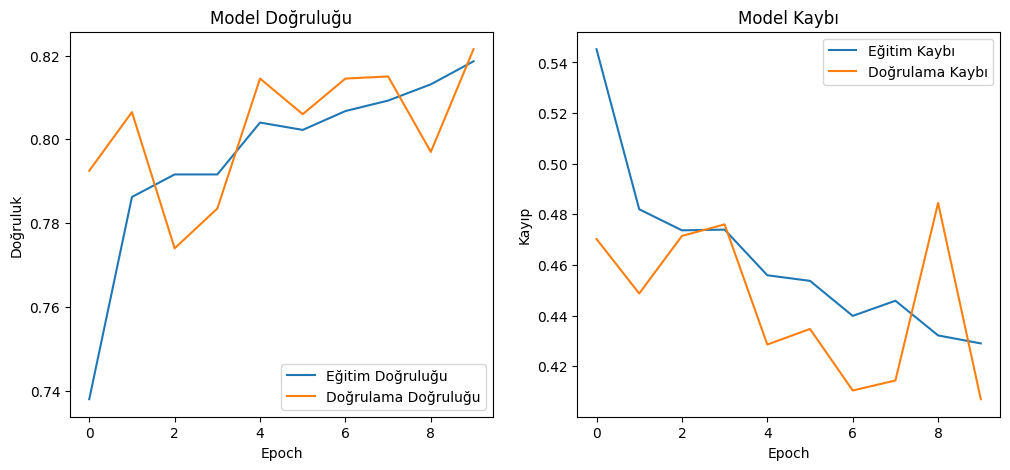

 1/63 ━━━━━━━━━━━━━━━━━━━━ 15s 247ms/step

 2/63 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step 

 3/63 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step

 4/63 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step

 5/63 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step

 6/63 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step

 7/63 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step

 8/63 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step

 9/63 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step

10/63 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step

11/63 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step

12/63 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step

13/63 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step

14/63 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step

15/63 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step

16/63 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step

17/63 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step

18/63 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step

19/63 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step

20/63 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step

21/63 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step

22/63 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step

23/63 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step

24/63 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step

25/63 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step

26/63 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step

27/63 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step

28/63 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step

29/63 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step

30/63 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step

31/63 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step

32/63 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step

33/63 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step

34/63 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step

35/63 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step

36/63 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step

37/63 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step

38/63 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step

39/63 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step

40/63 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step

41/63 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step

42/63 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step

43/63 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step

44/63 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step

45/63 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step

46/63 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step

47/63 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step

48/63 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step

49/63 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step

50/63 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step

51/63 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step

52/63 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step

53/63 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step

54/63 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step

55/63 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step


Sınıflandırma Raporu:

              precision    recall  f1-score   support

      Benign       0.84      0.80      0.82      1000
   Malignant       0.81      0.85      0.83      1000

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



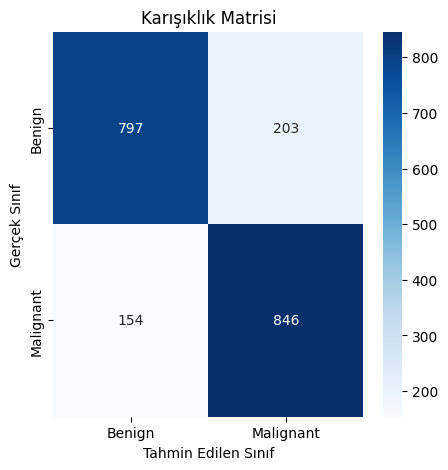

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


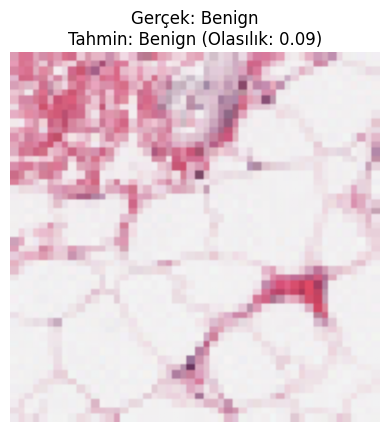

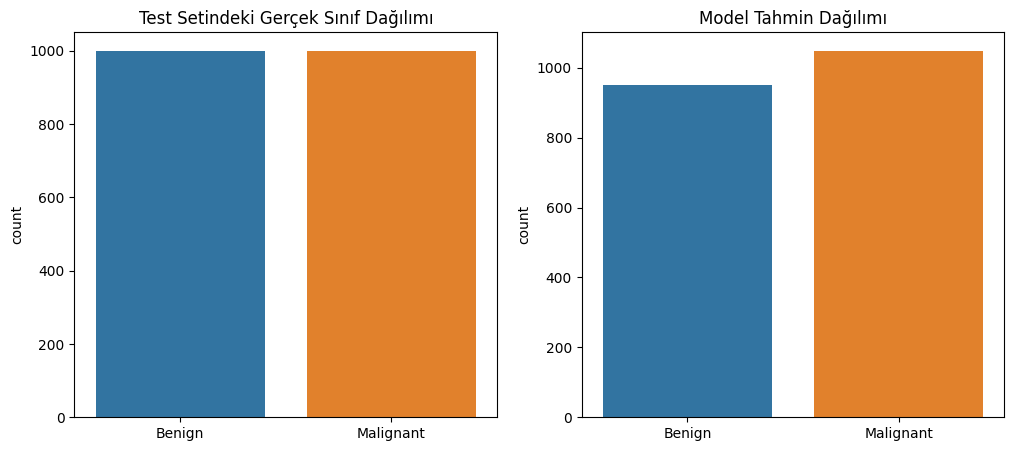

In [5]:
# ==============================================================================
# BÖLÜM 4: Model Değerlendirme ve Tahmin
# ==============================================================================
print("\nModel değerlendirme ve tahminler...")

# Modelin eğitim geçmişi (accuracy ve loss) grafiklerini çiz
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

# --- Tahminleri al ve sınıflandır ---
# Model tüm test setini tahmin ediyor
y_pred_prob = model.predict(X_test)
# 0.5 eşik değeri ile sınıflara ayır
y_pred = (y_pred_prob > 0.5).astype(int)

# --- Sınıflandırma raporu ---
# precision, recall, f1-score gibi detaylı metrikleri içerir
report = classification_report(y_test, y_pred, target_names=["Benign","Malignant"])
print("Sınıflandırma Raporu:\n")
print(report)

# --- Confusion Matrix (Karışıklık Matrisi) ---
# Modelin hangi sınıfları doğru/yanlış tahmin ettiğini gösterir
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Benign","Malignant"], 
            yticklabels=["Benign","Malignant"])
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Karışıklık Matrisi")
plt.show()


# --- Tek bir örnek üzerinde tahmin yapma ---
# Test setinden rastgele bir örnek seç
idx = random.randint(0, len(X_test) - 1)
sample_img = X_test[idx].reshape(1, 128, 128, 3)
true_label = y_test[idx]

# Tahmin yap
pred_prob = model.predict(sample_img)[0][0]
pred_label = 1 if pred_prob > 0.5 else 0

# Görseli ve tahmin sonuçlarını göster
plt.imshow(X_test[idx])
plt.axis("off")
plt.title(
    f"Gerçek: {'Benign' if true_label==0 else 'Malignant'}\n"
    f"Tahmin: {'Benign' if pred_label==0 else 'Malignant'} (Olasılık: {pred_prob:.2f})"
)
plt.show()

# --- Sınıf Dağılımlarını Karşılaştırma ---
# Gerçek etiketlerin ve model tahminlerinin dağılımını gösterir
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
sns.countplot(x=y_test)
plt.xticks([0,1], ["Benign", "Malignant"])
plt.title("Test Setindeki Gerçek Sınıf Dağılımı")

plt.subplot(1,2,2)
sns.countplot(x=y_pred.flatten())
plt.xticks([0,1], ["Benign", "Malignant"])
plt.title("Model Tahmin Dağılımı")
plt.show()


In [6]:
# ==============================================================================
# BÖLÜM 1: Gerekli Kütüphaneleri İçe Aktarma
# Bu bölümde, veri işleme, model oluşturma ve Keras Tuner için gereken tüm
# kütüphaneler yüklenir.
# ==============================================================================
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import keras_tuner as kt
import tensorflow as tf

# ==============================================================================
# BÖLÜM 2: Veri Hazırlığı ve Ön İşleme
# Bu bölümde, dosya yolları tanımlanır, tüm görüntüler yüklenir,
# boyutlandırılır, normalleştirilir ve eğitim/test kümelerine ayrılır.
# ==============================================================================
print("Veri hazırlığı başlatılıyor...")

# Veri setinin ana dizin yolu.
base_dir = "/kaggle/input/breast-histopathology-images"

# Tüm görüntü yollarını ve etiketlerini depolamak için boş listeler
image_paths = []
labels = []

# Ana dizindeki tüm hasta klasörlerini döngü ile gez
for patient_folder in os.listdir(base_dir):
    patient_path = os.path.join(base_dir, patient_folder)
    
    if not os.path.isdir(patient_path):
        continue
    
    for label_folder in ["0", "1"]:
        folder_path = os.path.join(patient_path, label_folder)
        
        if os.path.exists(folder_path):
            for img_file in os.listdir(folder_path):
                if img_file.endswith(".png"):
                    image_paths.append(os.path.join(folder_path, img_file))
                    labels.append(int(label_folder))

# Toplanan verileri kullanarak bir pandas DataFrame'i oluştur
data_df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})

print("Toplam örnek sayısı:", len(data_df))

# ---
# Veri Kümesini Dengeli Olarak Küçültme
# ---
print("Veri kümesi dengeli olarak örnekleniyor...")
samples_per_class = 5000
df_0 = data_df[data_df['label'] == 0].sample(n=samples_per_class, random_state=42)
df_1 = data_df[data_df['label'] == 1].sample(n=samples_per_class, random_state=42)
data_df = pd.concat([df_0, df_1]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Yeni dengeli örnek sayısı: {len(data_df)}")

# Görüntüleri yüklemek ve ön işlemek için sabit boyut tanımla
IMG_SIZE = (128, 128)

# Görüntüleri ve etiketleri depolamak için NumPy dizileri
X = []
y = []

for _, row in data_df.iterrows():
    try:
        img = load_img(row['image_path'], target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        X.append(img_array)
        y.append(row['label'])
    except Exception as e:
        print(f"Hata oluştu: {row['image_path']}, Hata: {e}")

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Veri setini eğitim ve test kümelerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)
print("Veri hazırlığı tamamlandı.")

# ==============================================================================
# BÖLÜM 3: Hiperparametre Optimizasyonu
# Bu bölümde, Keras Tuner kullanarak modelin en iyi hiperparametreleri bulunur.
# ==============================================================================
def build_model(hp):
    """
    Keras Tuner için hiperparametreleri ayarlanabilir bir model oluşturur.
    
    Argümanlar:
        hp: keras_tuner.HyperParameters nesnesi.
        
    Döndürür:
        Derlenmiş Keras modeli.
    """
    model = Sequential()
    
    # Yeni önerilen yöntem: Giriş katmanını ayrı bir şekilde tanımla
    model.add(tf.keras.Input(shape=(128, 128, 3)))
    
    # Evrişim katmanları için filtre sayısını ayarla
    hp_filters_1 = hp.Int('filters_1', min_value=32, max_value=128, step=32)
    hp_filters_2 = hp.Int('filters_2', min_value=64, max_value=256, step=64)
    hp_filters_3 = hp.Int('filters_3', min_value=128, max_value=512, step=128)
    
    model.add(Conv2D(hp_filters_1, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(hp_filters_2, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(hp_filters_3, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    
    # Tam bağlantılı katman için nöron sayısını ayarla
    hp_dense_units = hp.Int('dense_units', min_value=32, max_value=256, step=32)
    model.add(Dense(units=hp_dense_units, activation='relu'))
    
    # Dropout oranını ayarla
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # Optimizer seçimi
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    model.compile(optimizer=hp_optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Keras Tuner'ı başlat
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_tuner_dir',
    project_name='breast_cancer_tuning'
)

print("\nHiperparametre optimizasyonu başlatılıyor...")

# Arama işlemini başlat
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# En iyi hiperparametreleri ve modeli al
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

print("\nEn iyi hiperparametreler:")
print(f"Katman 1 Filtre Sayısı: {best_hps.get('filters_1')}")
print(f"Katman 2 Filtre Sayısı: {best_hps.get('filters_2')}")
print(f"Katman 3 Filtre Sayısı: {best_hps.get('filters_3')}")
print(f"Yoğun Katman Nöron Sayısı: {best_hps.get('dense_units')}")
print(f"Dropout Oranı: {best_hps.get('dropout_rate')}")
print(f"Optimizer: {best_hps.get('optimizer')}")

# En iyi modeli özetle
print("\nEn iyi modelin özeti:")
best_model.summary()

# En iyi modeli kaydet
best_model.save("best_tuned_breast_cancer_model.keras")
print("\nEn iyi model başarıyla kaydedildi: best_tuned_breast_cancer_model.keras")


Trial 7 Complete [01h 50m 16s]
val_accuracy: 0.8135000169277191

Best val_accuracy So Far: 0.8199999928474426
Total elapsed time: 10h 58m 54s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
64                |96                |filters_1
64                |192               |filters_2
128               |256               |filters_3
32                |160               |dense_units
0.5               |0.2               |dropout_rate
sgd               |adam              |optimizer



Epoch 1/5


  1/250 ━━━━━━━━━━━━━━━━━━━━ 7:37 2s/step - accuracy: 0.5000 - loss: 0.6918

  2/250 ━━━━━━━━━━━━━━━━━━━━ 3:21 813ms/step - accuracy: 0.4922 - loss: 0.6952

  3/250 ━━━━━━━━━━━━━━━━━━━━ 3:18 804ms/step - accuracy: 0.4844 - loss: 0.6956

  4/250 ━━━━━━━━━━━━━━━━━━━━ 3:17 805ms/step - accuracy: 0.4844 - loss: 0.6953

  5/250 ━━━━━━━━━━━━━━━━━━━━ 3:17 804ms/step - accuracy: 0.4825 - loss: 0.6953

  6/250 ━━━━━━━━━━━━━━━━━━━━ 3:16 804ms/step - accuracy: 0.4811 - loss: 0.6961

  7/250 ━━━━━━━━━━━━━━━━━━━━ 3:16 811ms/step - accuracy: 0.4787 - loss: 0.6969

  8/250 ━━━━━━━━━━━━━━━━━━━━ 3:15 810ms/step - accuracy: 0.4769 - loss: 0.6974

  9/250 ━━━━━━━━━━━━━━━━━━━━ 3:15 811ms/step - accuracy: 0.4772 - loss: 0.6974

 10/250 ━━━━━━━━━━━━━━━━━━━━ 3:14 810ms/step - accuracy: 0.4779 - loss: 0.6972

 11/250 ━━━━━━━━━━━━━━━━━━━━ 3:13 812ms/step - accuracy: 0.4789 - loss: 0.6972

 12/250 ━━━━━━━━━━━━━━━━━━━━ 3:12 811ms/step - accuracy: 0.4802 - loss: 0.6970

 13/250 ━━━━━━━━━━━━━━━━━━━━ 3:12 812ms/step - accuracy: 0.4817 - loss: 0.6967

 14/250 ━━━━━━━━━━━━━━━━━━━━ 3:11 811ms/step - accuracy: 0.4842 - loss: 0.6961

 15/250 ━━━━━━━━━━━━━━━━━━━━ 3:11 813ms/step - accuracy: 0.4869 - loss: 0.6956

 16/250 ━━━━━━━━━━━━━━━━━━━━ 3:10 812ms/step - accuracy: 0.4889 - loss: 0.6953

 17/250 ━━━━━━━━━━━━━━━━━━━━ 3:09 811ms/step - accuracy: 0.4903 - loss: 0.6952

 18/250 ━━━━━━━━━━━━━━━━━━━━ 3:08 812ms/step - accuracy: 0.4910 - loss: 0.6952

 19/250 ━━━━━━━━━━━━━━━━━━━━ 3:07 814ms/step - accuracy: 0.4918 - loss: 0.6951

 20/250 ━━━━━━━━━━━━━━━━━━━━ 3:07 813ms/step - accuracy: 0.4928 - loss: 0.6950

 21/250 ━━━━━━━━━━━━━━━━━━━━ 3:06 814ms/step - accuracy: 0.4940 - loss: 0.6948

 22/250 ━━━━━━━━━━━━━━━━━━━━ 3:05 813ms/step - accuracy: 0.4948 - loss: 0.6948

 23/250 ━━━━━━━━━━━━━━━━━━━━ 3:04 813ms/step - accuracy: 0.4958 - loss: 0.6946

 24/250 ━━━━━━━━━━━━━━━━━━━━ 3:03 812ms/step - accuracy: 0.4967 - loss: 0.6945

 25/250 ━━━━━━━━━━━━━━━━━━━━ 3:02 813ms/step - accuracy: 0.4974 - loss: 0.6944

 26/250 ━━━━━━━━━━━━━━━━━━━━ 3:02 814ms/step - accuracy: 0.4982 - loss: 0.6943

 27/250 ━━━━━━━━━━━━━━━━━━━━ 3:01 814ms/step - accuracy: 0.4990 - loss: 0.6942

 28/250 ━━━━━━━━━━━━━━━━━━━━ 3:00 814ms/step - accuracy: 0.4997 - loss: 0.6941

 29/250 ━━━━━━━━━━━━━━━━━━━━ 3:00 815ms/step - accuracy: 0.5002 - loss: 0.6940

 30/250 ━━━━━━━━━━━━━━━━━━━━ 2:59 817ms/step - accuracy: 0.5009 - loss: 0.6939

 31/250 ━━━━━━━━━━━━━━━━━━━━ 2:59 819ms/step - accuracy: 0.5017 - loss: 0.6938

 32/250 ━━━━━━━━━━━━━━━━━━━━ 2:58 818ms/step - accuracy: 0.5027 - loss: 0.6936

 33/250 ━━━━━━━━━━━━━━━━━━━━ 2:57 818ms/step - accuracy: 0.5035 - loss: 0.6934

 34/250 ━━━━━━━━━━━━━━━━━━━━ 2:56 817ms/step - accuracy: 0.5042 - loss: 0.6934

 35/250 ━━━━━━━━━━━━━━━━━━━━ 2:55 816ms/step - accuracy: 0.5048 - loss: 0.6933

 36/250 ━━━━━━━━━━━━━━━━━━━━ 2:54 816ms/step - accuracy: 0.5053 - loss: 0.6932

 37/250 ━━━━━━━━━━━━━━━━━━━━ 2:53 815ms/step - accuracy: 0.5058 - loss: 0.6931

 38/250 ━━━━━━━━━━━━━━━━━━━━ 2:52 815ms/step - accuracy: 0.5062 - loss: 0.6931

 39/250 ━━━━━━━━━━━━━━━━━━━━ 2:51 815ms/step - accuracy: 0.5066 - loss: 0.6930

 40/250 ━━━━━━━━━━━━━━━━━━━━ 2:51 814ms/step - accuracy: 0.5070 - loss: 0.6929

 41/250 ━━━━━━━━━━━━━━━━━━━━ 2:50 815ms/step - accuracy: 0.5073 - loss: 0.6929

 42/250 ━━━━━━━━━━━━━━━━━━━━ 2:49 815ms/step - accuracy: 0.5076 - loss: 0.6929

 43/250 ━━━━━━━━━━━━━━━━━━━━ 2:48 816ms/step - accuracy: 0.5079 - loss: 0.6928

 44/250 ━━━━━━━━━━━━━━━━━━━━ 2:48 816ms/step - accuracy: 0.5081 - loss: 0.6928

 45/250 ━━━━━━━━━━━━━━━━━━━━ 2:47 816ms/step - accuracy: 0.5083 - loss: 0.6927

 46/250 ━━━━━━━━━━━━━━━━━━━━ 2:46 817ms/step - accuracy: 0.5084 - loss: 0.6927

 47/250 ━━━━━━━━━━━━━━━━━━━━ 2:45 816ms/step - accuracy: 0.5085 - loss: 0.6927

 48/250 ━━━━━━━━━━━━━━━━━━━━ 2:44 817ms/step - accuracy: 0.5085 - loss: 0.6926

 49/250 ━━━━━━━━━━━━━━━━━━━━ 2:44 817ms/step - accuracy: 0.5086 - loss: 0.6926

 50/250 ━━━━━━━━━━━━━━━━━━━━ 2:43 816ms/step - accuracy: 0.5087 - loss: 0.6926

 51/250 ━━━━━━━━━━━━━━━━━━━━ 2:42 816ms/step - accuracy: 0.5088 - loss: 0.6926

 52/250 ━━━━━━━━━━━━━━━━━━━━ 2:41 815ms/step - accuracy: 0.5089 - loss: 0.6925

 53/250 ━━━━━━━━━━━━━━━━━━━━ 2:40 815ms/step - accuracy: 0.5089 - loss: 0.6925

 54/250 ━━━━━━━━━━━━━━━━━━━━ 2:39 815ms/step - accuracy: 0.5089 - loss: 0.6925

 55/250 ━━━━━━━━━━━━━━━━━━━━ 2:38 815ms/step - accuracy: 0.5089 - loss: 0.6925

 56/250 ━━━━━━━━━━━━━━━━━━━━ 2:38 815ms/step - accuracy: 0.5089 - loss: 0.6925

 57/250 ━━━━━━━━━━━━━━━━━━━━ 2:37 815ms/step - accuracy: 0.5089 - loss: 0.6924

 58/250 ━━━━━━━━━━━━━━━━━━━━ 2:36 815ms/step - accuracy: 0.5089 - loss: 0.6924

 59/250 ━━━━━━━━━━━━━━━━━━━━ 2:35 815ms/step - accuracy: 0.5089 - loss: 0.6924

 60/250 ━━━━━━━━━━━━━━━━━━━━ 2:34 815ms/step - accuracy: 0.5090 - loss: 0.6924

 61/250 ━━━━━━━━━━━━━━━━━━━━ 2:34 815ms/step - accuracy: 0.5090 - loss: 0.6924

 62/250 ━━━━━━━━━━━━━━━━━━━━ 2:33 815ms/step - accuracy: 0.5090 - loss: 0.6924

 63/250 ━━━━━━━━━━━━━━━━━━━━ 2:32 814ms/step - accuracy: 0.5089 - loss: 0.6924

 64/250 ━━━━━━━━━━━━━━━━━━━━ 2:31 814ms/step - accuracy: 0.5090 - loss: 0.6923

 65/250 ━━━━━━━━━━━━━━━━━━━━ 2:30 814ms/step - accuracy: 0.5090 - loss: 0.6923

 66/250 ━━━━━━━━━━━━━━━━━━━━ 2:29 813ms/step - accuracy: 0.5090 - loss: 0.6923

 67/250 ━━━━━━━━━━━━━━━━━━━━ 2:28 813ms/step - accuracy: 0.5090 - loss: 0.6923

 68/250 ━━━━━━━━━━━━━━━━━━━━ 2:28 814ms/step - accuracy: 0.5091 - loss: 0.6923

 69/250 ━━━━━━━━━━━━━━━━━━━━ 2:27 814ms/step - accuracy: 0.5091 - loss: 0.6923

 70/250 ━━━━━━━━━━━━━━━━━━━━ 2:26 814ms/step - accuracy: 0.5091 - loss: 0.6923

 71/250 ━━━━━━━━━━━━━━━━━━━━ 2:25 814ms/step - accuracy: 0.5091 - loss: 0.6923

 72/250 ━━━━━━━━━━━━━━━━━━━━ 2:24 814ms/step - accuracy: 0.5091 - loss: 0.6922

 73/250 ━━━━━━━━━━━━━━━━━━━━ 2:24 814ms/step - accuracy: 0.5091 - loss: 0.6922

 74/250 ━━━━━━━━━━━━━━━━━━━━ 2:23 815ms/step - accuracy: 0.5092 - loss: 0.6922

 75/250 ━━━━━━━━━━━━━━━━━━━━ 2:22 814ms/step - accuracy: 0.5092 - loss: 0.6922

 76/250 ━━━━━━━━━━━━━━━━━━━━ 2:21 815ms/step - accuracy: 0.5092 - loss: 0.6922

 77/250 ━━━━━━━━━━━━━━━━━━━━ 2:20 815ms/step - accuracy: 0.5092 - loss: 0.6922

 78/250 ━━━━━━━━━━━━━━━━━━━━ 2:20 814ms/step - accuracy: 0.5092 - loss: 0.6922

 79/250 ━━━━━━━━━━━━━━━━━━━━ 2:19 814ms/step - accuracy: 0.5092 - loss: 0.6922

 80/250 ━━━━━━━━━━━━━━━━━━━━ 2:18 814ms/step - accuracy: 0.5092 - loss: 0.6922

 81/250 ━━━━━━━━━━━━━━━━━━━━ 2:17 814ms/step - accuracy: 0.5092 - loss: 0.6921

 82/250 ━━━━━━━━━━━━━━━━━━━━ 2:16 814ms/step - accuracy: 0.5092 - loss: 0.6921

 83/250 ━━━━━━━━━━━━━━━━━━━━ 2:15 814ms/step - accuracy: 0.5093 - loss: 0.6921

 84/250 ━━━━━━━━━━━━━━━━━━━━ 2:15 814ms/step - accuracy: 0.5093 - loss: 0.6921

 85/250 ━━━━━━━━━━━━━━━━━━━━ 2:14 814ms/step - accuracy: 0.5093 - loss: 0.6921

 86/250 ━━━━━━━━━━━━━━━━━━━━ 2:13 815ms/step - accuracy: 0.5093 - loss: 0.6921

 87/250 ━━━━━━━━━━━━━━━━━━━━ 2:12 814ms/step - accuracy: 0.5094 - loss: 0.6921

 88/250 ━━━━━━━━━━━━━━━━━━━━ 2:11 814ms/step - accuracy: 0.5094 - loss: 0.6921

 89/250 ━━━━━━━━━━━━━━━━━━━━ 2:11 814ms/step - accuracy: 0.5094 - loss: 0.6921

 90/250 ━━━━━━━━━━━━━━━━━━━━ 2:10 814ms/step - accuracy: 0.5094 - loss: 0.6921

 91/250 ━━━━━━━━━━━━━━━━━━━━ 2:09 814ms/step - accuracy: 0.5095 - loss: 0.6921

 92/250 ━━━━━━━━━━━━━━━━━━━━ 2:08 813ms/step - accuracy: 0.5095 - loss: 0.6921

 93/250 ━━━━━━━━━━━━━━━━━━━━ 2:07 814ms/step - accuracy: 0.5095 - loss: 0.6921

 94/250 ━━━━━━━━━━━━━━━━━━━━ 2:06 814ms/step - accuracy: 0.5095 - loss: 0.6921

 95/250 ━━━━━━━━━━━━━━━━━━━━ 2:06 813ms/step - accuracy: 0.5095 - loss: 0.6921

 96/250 ━━━━━━━━━━━━━━━━━━━━ 2:05 813ms/step - accuracy: 0.5095 - loss: 0.6920

 97/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 814ms/step - accuracy: 0.5095 - loss: 0.6920

 98/250 ━━━━━━━━━━━━━━━━━━━━ 2:03 814ms/step - accuracy: 0.5095 - loss: 0.6920

 99/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 814ms/step - accuracy: 0.5095 - loss: 0.6920

100/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 814ms/step - accuracy: 0.5095 - loss: 0.6920

101/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 814ms/step - accuracy: 0.5095 - loss: 0.6920

102/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 813ms/step - accuracy: 0.5095 - loss: 0.6920

103/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 814ms/step - accuracy: 0.5095 - loss: 0.6920

104/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 814ms/step - accuracy: 0.5095 - loss: 0.6920

105/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 814ms/step - accuracy: 0.5095 - loss: 0.6920

106/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 815ms/step - accuracy: 0.5095 - loss: 0.6920

107/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 814ms/step - accuracy: 0.5095 - loss: 0.6920

108/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 815ms/step - accuracy: 0.5095 - loss: 0.6920

109/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 815ms/step - accuracy: 0.5096 - loss: 0.6920

110/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 815ms/step - accuracy: 0.5096 - loss: 0.6920

111/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 815ms/step - accuracy: 0.5096 - loss: 0.6920

112/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 815ms/step - accuracy: 0.5096 - loss: 0.6920

113/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 815ms/step - accuracy: 0.5096 - loss: 0.6920

114/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 815ms/step - accuracy: 0.5097 - loss: 0.6920

115/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 815ms/step - accuracy: 0.5097 - loss: 0.6920

116/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 815ms/step - accuracy: 0.5098 - loss: 0.6920

117/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 815ms/step - accuracy: 0.5098 - loss: 0.6920

118/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 815ms/step - accuracy: 0.5098 - loss: 0.6920

119/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 815ms/step - accuracy: 0.5099 - loss: 0.6920

120/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 815ms/step - accuracy: 0.5099 - loss: 0.6919

121/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 815ms/step - accuracy: 0.5100 - loss: 0.6919

122/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 815ms/step - accuracy: 0.5100 - loss: 0.6919

123/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 815ms/step - accuracy: 0.5101 - loss: 0.6919

124/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 815ms/step - accuracy: 0.5101 - loss: 0.6919

125/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 815ms/step - accuracy: 0.5102 - loss: 0.6919

126/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 815ms/step - accuracy: 0.5102 - loss: 0.6919

127/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 815ms/step - accuracy: 0.5103 - loss: 0.6919

128/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 815ms/step - accuracy: 0.5103 - loss: 0.6919

129/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 815ms/step - accuracy: 0.5103 - loss: 0.6919

130/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 815ms/step - accuracy: 0.5104 - loss: 0.6919

131/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 815ms/step - accuracy: 0.5104 - loss: 0.6919

132/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 815ms/step - accuracy: 0.5104 - loss: 0.6919

133/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 815ms/step - accuracy: 0.5105 - loss: 0.6919

134/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 815ms/step - accuracy: 0.5105 - loss: 0.6919

135/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 815ms/step - accuracy: 0.5106 - loss: 0.6919

136/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 815ms/step - accuracy: 0.5106 - loss: 0.6918

137/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 815ms/step - accuracy: 0.5107 - loss: 0.6918

138/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 815ms/step - accuracy: 0.5107 - loss: 0.6918

139/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 815ms/step - accuracy: 0.5108 - loss: 0.6918

140/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 815ms/step - accuracy: 0.5108 - loss: 0.6918

141/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 815ms/step - accuracy: 0.5109 - loss: 0.6918

142/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 815ms/step - accuracy: 0.5109 - loss: 0.6918

143/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 815ms/step - accuracy: 0.5110 - loss: 0.6918

144/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 815ms/step - accuracy: 0.5110 - loss: 0.6918

145/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 815ms/step - accuracy: 0.5111 - loss: 0.6918

146/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 815ms/step - accuracy: 0.5111 - loss: 0.6918

147/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 815ms/step - accuracy: 0.5112 - loss: 0.6918

148/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 815ms/step - accuracy: 0.5112 - loss: 0.6918

149/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 815ms/step - accuracy: 0.5112 - loss: 0.6918

150/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 815ms/step - accuracy: 0.5113 - loss: 0.6918

151/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 815ms/step - accuracy: 0.5113 - loss: 0.6918

152/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 815ms/step - accuracy: 0.5114 - loss: 0.6918

153/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 815ms/step - accuracy: 0.5114 - loss: 0.6918

154/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 815ms/step - accuracy: 0.5115 - loss: 0.6917

155/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 815ms/step - accuracy: 0.5115 - loss: 0.6917

156/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 815ms/step - accuracy: 0.5116 - loss: 0.6917

157/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 815ms/step - accuracy: 0.5116 - loss: 0.6917

158/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 815ms/step - accuracy: 0.5117 - loss: 0.6917

159/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 815ms/step - accuracy: 0.5117 - loss: 0.6917

160/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 815ms/step - accuracy: 0.5118 - loss: 0.6917

161/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 815ms/step - accuracy: 0.5118 - loss: 0.6917

162/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 815ms/step - accuracy: 0.5118 - loss: 0.6917

163/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 815ms/step - accuracy: 0.5119 - loss: 0.6917

164/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 815ms/step - accuracy: 0.5119 - loss: 0.6917

165/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 815ms/step - accuracy: 0.5120 - loss: 0.6917

166/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 815ms/step - accuracy: 0.5120 - loss: 0.6917

167/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 815ms/step - accuracy: 0.5121 - loss: 0.6917

168/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 815ms/step - accuracy: 0.5121 - loss: 0.6917

169/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 815ms/step - accuracy: 0.5122 - loss: 0.6917

170/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 815ms/step - accuracy: 0.5122 - loss: 0.6917

171/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 815ms/step - accuracy: 0.5123 - loss: 0.6917

172/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 815ms/step - accuracy: 0.5123 - loss: 0.6917

173/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 814ms/step - accuracy: 0.5124 - loss: 0.6917

174/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 814ms/step - accuracy: 0.5124 - loss: 0.6916

175/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 814ms/step - accuracy: 0.5125 - loss: 0.6916

176/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 815ms/step - accuracy: 0.5126 - loss: 0.6916

177/250 ━━━━━━━━━━━━━━━━━━━━ 59s 814ms/step - accuracy: 0.5126 - loss: 0.6916 

178/250 ━━━━━━━━━━━━━━━━━━━━ 58s 815ms/step - accuracy: 0.5127 - loss: 0.6916

179/250 ━━━━━━━━━━━━━━━━━━━━ 57s 815ms/step - accuracy: 0.5127 - loss: 0.6916

180/250 ━━━━━━━━━━━━━━━━━━━━ 57s 815ms/step - accuracy: 0.5128 - loss: 0.6916

181/250 ━━━━━━━━━━━━━━━━━━━━ 56s 815ms/step - accuracy: 0.5129 - loss: 0.6916

182/250 ━━━━━━━━━━━━━━━━━━━━ 55s 815ms/step - accuracy: 0.5129 - loss: 0.6916

183/250 ━━━━━━━━━━━━━━━━━━━━ 54s 815ms/step - accuracy: 0.5130 - loss: 0.6916

184/250 ━━━━━━━━━━━━━━━━━━━━ 53s 815ms/step - accuracy: 0.5131 - loss: 0.6916

185/250 ━━━━━━━━━━━━━━━━━━━━ 52s 815ms/step - accuracy: 0.5131 - loss: 0.6916

186/250 ━━━━━━━━━━━━━━━━━━━━ 52s 815ms/step - accuracy: 0.5132 - loss: 0.6916

187/250 ━━━━━━━━━━━━━━━━━━━━ 51s 815ms/step - accuracy: 0.5133 - loss: 0.6916

188/250 ━━━━━━━━━━━━━━━━━━━━ 50s 815ms/step - accuracy: 0.5133 - loss: 0.6916

189/250 ━━━━━━━━━━━━━━━━━━━━ 49s 815ms/step - accuracy: 0.5134 - loss: 0.6916

190/250 ━━━━━━━━━━━━━━━━━━━━ 48s 815ms/step - accuracy: 0.5135 - loss: 0.6916

191/250 ━━━━━━━━━━━━━━━━━━━━ 48s 815ms/step - accuracy: 0.5136 - loss: 0.6916

192/250 ━━━━━━━━━━━━━━━━━━━━ 47s 815ms/step - accuracy: 0.5136 - loss: 0.6916

193/250 ━━━━━━━━━━━━━━━━━━━━ 46s 815ms/step - accuracy: 0.5137 - loss: 0.6915

194/250 ━━━━━━━━━━━━━━━━━━━━ 45s 815ms/step - accuracy: 0.5138 - loss: 0.6915

195/250 ━━━━━━━━━━━━━━━━━━━━ 44s 815ms/step - accuracy: 0.5139 - loss: 0.6915

196/250 ━━━━━━━━━━━━━━━━━━━━ 44s 815ms/step - accuracy: 0.5139 - loss: 0.6915

197/250 ━━━━━━━━━━━━━━━━━━━━ 43s 815ms/step - accuracy: 0.5140 - loss: 0.6915

198/250 ━━━━━━━━━━━━━━━━━━━━ 42s 815ms/step - accuracy: 0.5141 - loss: 0.6915

199/250 ━━━━━━━━━━━━━━━━━━━━ 41s 815ms/step - accuracy: 0.5142 - loss: 0.6915

200/250 ━━━━━━━━━━━━━━━━━━━━ 40s 815ms/step - accuracy: 0.5143 - loss: 0.6915

201/250 ━━━━━━━━━━━━━━━━━━━━ 39s 815ms/step - accuracy: 0.5143 - loss: 0.6915

202/250 ━━━━━━━━━━━━━━━━━━━━ 39s 815ms/step - accuracy: 0.5144 - loss: 0.6915

203/250 ━━━━━━━━━━━━━━━━━━━━ 38s 815ms/step - accuracy: 0.5145 - loss: 0.6915

204/250 ━━━━━━━━━━━━━━━━━━━━ 37s 815ms/step - accuracy: 0.5146 - loss: 0.6915

205/250 ━━━━━━━━━━━━━━━━━━━━ 36s 815ms/step - accuracy: 0.5146 - loss: 0.6915

206/250 ━━━━━━━━━━━━━━━━━━━━ 35s 815ms/step - accuracy: 0.5147 - loss: 0.6915

207/250 ━━━━━━━━━━━━━━━━━━━━ 35s 815ms/step - accuracy: 0.5148 - loss: 0.6915

208/250 ━━━━━━━━━━━━━━━━━━━━ 34s 815ms/step - accuracy: 0.5149 - loss: 0.6914

209/250 ━━━━━━━━━━━━━━━━━━━━ 33s 815ms/step - accuracy: 0.5150 - loss: 0.6914

210/250 ━━━━━━━━━━━━━━━━━━━━ 32s 815ms/step - accuracy: 0.5150 - loss: 0.6914

211/250 ━━━━━━━━━━━━━━━━━━━━ 31s 815ms/step - accuracy: 0.5151 - loss: 0.6914

212/250 ━━━━━━━━━━━━━━━━━━━━ 30s 815ms/step - accuracy: 0.5152 - loss: 0.6914

213/250 ━━━━━━━━━━━━━━━━━━━━ 30s 815ms/step - accuracy: 0.5153 - loss: 0.6914

214/250 ━━━━━━━━━━━━━━━━━━━━ 29s 815ms/step - accuracy: 0.5153 - loss: 0.6914

215/250 ━━━━━━━━━━━━━━━━━━━━ 28s 815ms/step - accuracy: 0.5154 - loss: 0.6914

216/250 ━━━━━━━━━━━━━━━━━━━━ 27s 815ms/step - accuracy: 0.5155 - loss: 0.6914

217/250 ━━━━━━━━━━━━━━━━━━━━ 26s 815ms/step - accuracy: 0.5156 - loss: 0.6914

218/250 ━━━━━━━━━━━━━━━━━━━━ 26s 815ms/step - accuracy: 0.5156 - loss: 0.6913

219/250 ━━━━━━━━━━━━━━━━━━━━ 25s 815ms/step - accuracy: 0.5157 - loss: 0.6913

220/250 ━━━━━━━━━━━━━━━━━━━━ 24s 816ms/step - accuracy: 0.5158 - loss: 0.6913

221/250 ━━━━━━━━━━━━━━━━━━━━ 23s 816ms/step - accuracy: 0.5159 - loss: 0.6913

222/250 ━━━━━━━━━━━━━━━━━━━━ 22s 816ms/step - accuracy: 0.5160 - loss: 0.6913

223/250 ━━━━━━━━━━━━━━━━━━━━ 22s 816ms/step - accuracy: 0.5160 - loss: 0.6913

224/250 ━━━━━━━━━━━━━━━━━━━━ 21s 816ms/step - accuracy: 0.5161 - loss: 0.6913

225/250 ━━━━━━━━━━━━━━━━━━━━ 20s 816ms/step - accuracy: 0.5162 - loss: 0.6913

226/250 ━━━━━━━━━━━━━━━━━━━━ 19s 816ms/step - accuracy: 0.5163 - loss: 0.6913

227/250 ━━━━━━━━━━━━━━━━━━━━ 18s 816ms/step - accuracy: 0.5163 - loss: 0.6912

228/250 ━━━━━━━━━━━━━━━━━━━━ 17s 816ms/step - accuracy: 0.5164 - loss: 0.6912

229/250 ━━━━━━━━━━━━━━━━━━━━ 17s 816ms/step - accuracy: 0.5165 - loss: 0.6912

230/250 ━━━━━━━━━━━━━━━━━━━━ 16s 816ms/step - accuracy: 0.5166 - loss: 0.6912

231/250 ━━━━━━━━━━━━━━━━━━━━ 15s 816ms/step - accuracy: 0.5167 - loss: 0.6912

232/250 ━━━━━━━━━━━━━━━━━━━━ 14s 816ms/step - accuracy: 0.5167 - loss: 0.6912

233/250 ━━━━━━━━━━━━━━━━━━━━ 13s 816ms/step - accuracy: 0.5168 - loss: 0.6912

234/250 ━━━━━━━━━━━━━━━━━━━━ 13s 816ms/step - accuracy: 0.5169 - loss: 0.6912

235/250 ━━━━━━━━━━━━━━━━━━━━ 12s 815ms/step - accuracy: 0.5170 - loss: 0.6911

236/250 ━━━━━━━━━━━━━━━━━━━━ 11s 815ms/step - accuracy: 0.5171 - loss: 0.6911

237/250 ━━━━━━━━━━━━━━━━━━━━ 10s 815ms/step - accuracy: 0.5171 - loss: 0.6911

238/250 ━━━━━━━━━━━━━━━━━━━━ 9s 815ms/step - accuracy: 0.5172 - loss: 0.6911 

239/250 ━━━━━━━━━━━━━━━━━━━━ 8s 815ms/step - accuracy: 0.5173 - loss: 0.6911

240/250 ━━━━━━━━━━━━━━━━━━━━ 8s 815ms/step - accuracy: 0.5174 - loss: 0.6911

241/250 ━━━━━━━━━━━━━━━━━━━━ 7s 815ms/step - accuracy: 0.5175 - loss: 0.6911

242/250 ━━━━━━━━━━━━━━━━━━━━ 6s 815ms/step - accuracy: 0.5175 - loss: 0.6911

243/250 ━━━━━━━━━━━━━━━━━━━━ 5s 815ms/step - accuracy: 0.5176 - loss: 0.6911

244/250 ━━━━━━━━━━━━━━━━━━━━ 4s 815ms/step - accuracy: 0.5177 - loss: 0.6910

245/250 ━━━━━━━━━━━━━━━━━━━━ 4s 815ms/step - accuracy: 0.5178 - loss: 0.6910

246/250 ━━━━━━━━━━━━━━━━━━━━ 3s 815ms/step - accuracy: 0.5179 - loss: 0.6910

247/250 ━━━━━━━━━━━━━━━━━━━━ 2s 815ms/step - accuracy: 0.5179 - loss: 0.6910

248/250 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step - accuracy: 0.5180 - loss: 0.6910

249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.5181 - loss: 0.6910

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.5182 - loss: 0.6910

250/250 ━━━━━━━━━━━━━━━━━━━━ 220s 877ms/step - accuracy: 0.5183 - loss: 0.6910 - val_accuracy: 0.7335 - val_loss: 0.6742


Epoch 2/5


  1/250 ━━━━━━━━━━━━━━━━━━━━ 3:48 919ms/step - accuracy: 0.7188 - loss: 0.6765

  2/250 ━━━━━━━━━━━━━━━━━━━━ 3:24 824ms/step - accuracy: 0.6875 - loss: 0.6759

  3/250 ━━━━━━━━━━━━━━━━━━━━ 3:19 806ms/step - accuracy: 0.6632 - loss: 0.6770

  4/250 ━━━━━━━━━━━━━━━━━━━━ 3:16 800ms/step - accuracy: 0.6536 - loss: 0.6776

  5/250 ━━━━━━━━━━━━━━━━━━━━ 3:15 796ms/step - accuracy: 0.6404 - loss: 0.6785

  6/250 ━━━━━━━━━━━━━━━━━━━━ 3:13 794ms/step - accuracy: 0.6309 - loss: 0.6775

  7/250 ━━━━━━━━━━━━━━━━━━━━ 3:13 794ms/step - accuracy: 0.6224 - loss: 0.6765

  8/250 ━━━━━━━━━━━━━━━━━━━━ 3:14 802ms/step - accuracy: 0.6139 - loss: 0.6759

  9/250 ━━━━━━━━━━━━━━━━━━━━ 3:13 802ms/step - accuracy: 0.6082 - loss: 0.6756

 10/250 ━━━━━━━━━━━━━━━━━━━━ 3:12 802ms/step - accuracy: 0.6030 - loss: 0.6755

 11/250 ━━━━━━━━━━━━━━━━━━━━ 3:11 803ms/step - accuracy: 0.5996 - loss: 0.6754

 12/250 ━━━━━━━━━━━━━━━━━━━━ 3:11 807ms/step - accuracy: 0.5969 - loss: 0.6752

 13/250 ━━━━━━━━━━━━━━━━━━━━ 3:11 808ms/step - accuracy: 0.5950 - loss: 0.6747

 14/250 ━━━━━━━━━━━━━━━━━━━━ 3:10 808ms/step - accuracy: 0.5927 - loss: 0.6743

 15/250 ━━━━━━━━━━━━━━━━━━━━ 3:09 807ms/step - accuracy: 0.5910 - loss: 0.6741

 16/250 ━━━━━━━━━━━━━━━━━━━━ 3:08 807ms/step - accuracy: 0.5897 - loss: 0.6739

 17/250 ━━━━━━━━━━━━━━━━━━━━ 3:07 805ms/step - accuracy: 0.5886 - loss: 0.6737

 18/250 ━━━━━━━━━━━━━━━━━━━━ 3:07 808ms/step - accuracy: 0.5878 - loss: 0.6737

 19/250 ━━━━━━━━━━━━━━━━━━━━ 3:06 808ms/step - accuracy: 0.5872 - loss: 0.6735

 20/250 ━━━━━━━━━━━━━━━━━━━━ 3:06 812ms/step - accuracy: 0.5870 - loss: 0.6733

 21/250 ━━━━━━━━━━━━━━━━━━━━ 3:05 811ms/step - accuracy: 0.5865 - loss: 0.6733

 22/250 ━━━━━━━━━━━━━━━━━━━━ 3:04 811ms/step - accuracy: 0.5862 - loss: 0.6732

 23/250 ━━━━━━━━━━━━━━━━━━━━ 3:03 811ms/step - accuracy: 0.5862 - loss: 0.6732

 24/250 ━━━━━━━━━━━━━━━━━━━━ 3:03 811ms/step - accuracy: 0.5862 - loss: 0.6730

 25/250 ━━━━━━━━━━━━━━━━━━━━ 3:02 811ms/step - accuracy: 0.5859 - loss: 0.6730

 26/250 ━━━━━━━━━━━━━━━━━━━━ 3:01 811ms/step - accuracy: 0.5857 - loss: 0.6730

 27/250 ━━━━━━━━━━━━━━━━━━━━ 3:00 811ms/step - accuracy: 0.5857 - loss: 0.6729

 28/250 ━━━━━━━━━━━━━━━━━━━━ 3:00 811ms/step - accuracy: 0.5857 - loss: 0.6729

 29/250 ━━━━━━━━━━━━━━━━━━━━ 2:59 811ms/step - accuracy: 0.5857 - loss: 0.6728

 30/250 ━━━━━━━━━━━━━━━━━━━━ 2:58 811ms/step - accuracy: 0.5858 - loss: 0.6727

 31/250 ━━━━━━━━━━━━━━━━━━━━ 2:57 811ms/step - accuracy: 0.5857 - loss: 0.6727

 32/250 ━━━━━━━━━━━━━━━━━━━━ 2:56 811ms/step - accuracy: 0.5856 - loss: 0.6727

 33/250 ━━━━━━━━━━━━━━━━━━━━ 2:55 811ms/step - accuracy: 0.5856 - loss: 0.6727

 34/250 ━━━━━━━━━━━━━━━━━━━━ 2:55 811ms/step - accuracy: 0.5857 - loss: 0.6727

 35/250 ━━━━━━━━━━━━━━━━━━━━ 2:54 811ms/step - accuracy: 0.5858 - loss: 0.6726

 36/250 ━━━━━━━━━━━━━━━━━━━━ 2:53 811ms/step - accuracy: 0.5859 - loss: 0.6726

 37/250 ━━━━━━━━━━━━━━━━━━━━ 2:52 811ms/step - accuracy: 0.5860 - loss: 0.6725

 38/250 ━━━━━━━━━━━━━━━━━━━━ 2:51 810ms/step - accuracy: 0.5860 - loss: 0.6725

 39/250 ━━━━━━━━━━━━━━━━━━━━ 2:51 813ms/step - accuracy: 0.5862 - loss: 0.6724

 40/250 ━━━━━━━━━━━━━━━━━━━━ 2:50 813ms/step - accuracy: 0.5865 - loss: 0.6723

 41/250 ━━━━━━━━━━━━━━━━━━━━ 2:50 814ms/step - accuracy: 0.5866 - loss: 0.6723

 42/250 ━━━━━━━━━━━━━━━━━━━━ 2:49 813ms/step - accuracy: 0.5869 - loss: 0.6722

 43/250 ━━━━━━━━━━━━━━━━━━━━ 2:48 814ms/step - accuracy: 0.5871 - loss: 0.6720

 44/250 ━━━━━━━━━━━━━━━━━━━━ 2:47 814ms/step - accuracy: 0.5873 - loss: 0.6719

 45/250 ━━━━━━━━━━━━━━━━━━━━ 2:46 814ms/step - accuracy: 0.5875 - loss: 0.6718

 46/250 ━━━━━━━━━━━━━━━━━━━━ 2:46 815ms/step - accuracy: 0.5878 - loss: 0.6717

 47/250 ━━━━━━━━━━━━━━━━━━━━ 2:45 816ms/step - accuracy: 0.5881 - loss: 0.6716

 48/250 ━━━━━━━━━━━━━━━━━━━━ 2:44 816ms/step - accuracy: 0.5884 - loss: 0.6714

 49/250 ━━━━━━━━━━━━━━━━━━━━ 2:43 816ms/step - accuracy: 0.5887 - loss: 0.6713

 50/250 ━━━━━━━━━━━━━━━━━━━━ 2:43 816ms/step - accuracy: 0.5889 - loss: 0.6712

 51/250 ━━━━━━━━━━━━━━━━━━━━ 2:42 815ms/step - accuracy: 0.5892 - loss: 0.6711

 52/250 ━━━━━━━━━━━━━━━━━━━━ 2:41 815ms/step - accuracy: 0.5895 - loss: 0.6710

 53/250 ━━━━━━━━━━━━━━━━━━━━ 2:40 816ms/step - accuracy: 0.5898 - loss: 0.6709

 54/250 ━━━━━━━━━━━━━━━━━━━━ 2:39 816ms/step - accuracy: 0.5901 - loss: 0.6708

 55/250 ━━━━━━━━━━━━━━━━━━━━ 2:39 816ms/step - accuracy: 0.5904 - loss: 0.6707

 56/250 ━━━━━━━━━━━━━━━━━━━━ 2:38 816ms/step - accuracy: 0.5906 - loss: 0.6706

 57/250 ━━━━━━━━━━━━━━━━━━━━ 2:37 817ms/step - accuracy: 0.5908 - loss: 0.6706

 58/250 ━━━━━━━━━━━━━━━━━━━━ 2:36 817ms/step - accuracy: 0.5910 - loss: 0.6705

 59/250 ━━━━━━━━━━━━━━━━━━━━ 2:36 817ms/step - accuracy: 0.5912 - loss: 0.6704

 60/250 ━━━━━━━━━━━━━━━━━━━━ 2:35 817ms/step - accuracy: 0.5913 - loss: 0.6703

 61/250 ━━━━━━━━━━━━━━━━━━━━ 2:34 818ms/step - accuracy: 0.5914 - loss: 0.6703

 62/250 ━━━━━━━━━━━━━━━━━━━━ 2:34 819ms/step - accuracy: 0.5916 - loss: 0.6702

 63/250 ━━━━━━━━━━━━━━━━━━━━ 2:33 819ms/step - accuracy: 0.5917 - loss: 0.6702

 64/250 ━━━━━━━━━━━━━━━━━━━━ 2:32 819ms/step - accuracy: 0.5918 - loss: 0.6701

 65/250 ━━━━━━━━━━━━━━━━━━━━ 2:31 819ms/step - accuracy: 0.5919 - loss: 0.6701

 66/250 ━━━━━━━━━━━━━━━━━━━━ 2:30 819ms/step - accuracy: 0.5920 - loss: 0.6700

 67/250 ━━━━━━━━━━━━━━━━━━━━ 2:29 818ms/step - accuracy: 0.5921 - loss: 0.6700

 68/250 ━━━━━━━━━━━━━━━━━━━━ 2:28 818ms/step - accuracy: 0.5922 - loss: 0.6699

 69/250 ━━━━━━━━━━━━━━━━━━━━ 2:28 818ms/step - accuracy: 0.5923 - loss: 0.6699

 70/250 ━━━━━━━━━━━━━━━━━━━━ 2:27 818ms/step - accuracy: 0.5924 - loss: 0.6699

 71/250 ━━━━━━━━━━━━━━━━━━━━ 2:26 818ms/step - accuracy: 0.5925 - loss: 0.6698

 72/250 ━━━━━━━━━━━━━━━━━━━━ 2:25 818ms/step - accuracy: 0.5926 - loss: 0.6698

 73/250 ━━━━━━━━━━━━━━━━━━━━ 2:24 818ms/step - accuracy: 0.5928 - loss: 0.6698

 74/250 ━━━━━━━━━━━━━━━━━━━━ 2:23 818ms/step - accuracy: 0.5929 - loss: 0.6697

 75/250 ━━━━━━━━━━━━━━━━━━━━ 2:23 818ms/step - accuracy: 0.5930 - loss: 0.6697

 76/250 ━━━━━━━━━━━━━━━━━━━━ 2:22 818ms/step - accuracy: 0.5931 - loss: 0.6696

 77/250 ━━━━━━━━━━━━━━━━━━━━ 2:21 818ms/step - accuracy: 0.5932 - loss: 0.6696

 78/250 ━━━━━━━━━━━━━━━━━━━━ 2:20 818ms/step - accuracy: 0.5934 - loss: 0.6696

 79/250 ━━━━━━━━━━━━━━━━━━━━ 2:19 817ms/step - accuracy: 0.5935 - loss: 0.6695

 80/250 ━━━━━━━━━━━━━━━━━━━━ 2:18 817ms/step - accuracy: 0.5936 - loss: 0.6695

 81/250 ━━━━━━━━━━━━━━━━━━━━ 2:18 817ms/step - accuracy: 0.5938 - loss: 0.6694

 82/250 ━━━━━━━━━━━━━━━━━━━━ 2:17 818ms/step - accuracy: 0.5939 - loss: 0.6694

 83/250 ━━━━━━━━━━━━━━━━━━━━ 2:16 817ms/step - accuracy: 0.5941 - loss: 0.6693

 84/250 ━━━━━━━━━━━━━━━━━━━━ 2:15 817ms/step - accuracy: 0.5942 - loss: 0.6693

 85/250 ━━━━━━━━━━━━━━━━━━━━ 2:14 818ms/step - accuracy: 0.5943 - loss: 0.6693

 86/250 ━━━━━━━━━━━━━━━━━━━━ 2:14 818ms/step - accuracy: 0.5944 - loss: 0.6692

 87/250 ━━━━━━━━━━━━━━━━━━━━ 2:13 818ms/step - accuracy: 0.5946 - loss: 0.6692

 88/250 ━━━━━━━━━━━━━━━━━━━━ 2:12 818ms/step - accuracy: 0.5947 - loss: 0.6691

 89/250 ━━━━━━━━━━━━━━━━━━━━ 2:11 818ms/step - accuracy: 0.5949 - loss: 0.6691

 90/250 ━━━━━━━━━━━━━━━━━━━━ 2:10 818ms/step - accuracy: 0.5951 - loss: 0.6690

 91/250 ━━━━━━━━━━━━━━━━━━━━ 2:10 818ms/step - accuracy: 0.5952 - loss: 0.6690

 92/250 ━━━━━━━━━━━━━━━━━━━━ 2:09 818ms/step - accuracy: 0.5953 - loss: 0.6689

 93/250 ━━━━━━━━━━━━━━━━━━━━ 2:08 818ms/step - accuracy: 0.5955 - loss: 0.6689

 94/250 ━━━━━━━━━━━━━━━━━━━━ 2:07 818ms/step - accuracy: 0.5956 - loss: 0.6689

 95/250 ━━━━━━━━━━━━━━━━━━━━ 2:06 818ms/step - accuracy: 0.5958 - loss: 0.6688

 96/250 ━━━━━━━━━━━━━━━━━━━━ 2:05 818ms/step - accuracy: 0.5959 - loss: 0.6688

 97/250 ━━━━━━━━━━━━━━━━━━━━ 2:05 818ms/step - accuracy: 0.5960 - loss: 0.6687

 98/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 818ms/step - accuracy: 0.5961 - loss: 0.6687

 99/250 ━━━━━━━━━━━━━━━━━━━━ 2:03 818ms/step - accuracy: 0.5963 - loss: 0.6686

100/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 818ms/step - accuracy: 0.5964 - loss: 0.6686

101/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 818ms/step - accuracy: 0.5966 - loss: 0.6685

102/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 818ms/step - accuracy: 0.5968 - loss: 0.6685

103/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 818ms/step - accuracy: 0.5969 - loss: 0.6684

104/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 818ms/step - accuracy: 0.5970 - loss: 0.6684

105/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 818ms/step - accuracy: 0.5972 - loss: 0.6683

106/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 818ms/step - accuracy: 0.5973 - loss: 0.6682

107/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 818ms/step - accuracy: 0.5975 - loss: 0.6682

108/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 818ms/step - accuracy: 0.5976 - loss: 0.6681

109/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 818ms/step - accuracy: 0.5977 - loss: 0.6681

110/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 818ms/step - accuracy: 0.5979 - loss: 0.6681

111/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 818ms/step - accuracy: 0.5980 - loss: 0.6680

112/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 818ms/step - accuracy: 0.5981 - loss: 0.6680

113/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 818ms/step - accuracy: 0.5982 - loss: 0.6679

114/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 818ms/step - accuracy: 0.5984 - loss: 0.6679

115/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 818ms/step - accuracy: 0.5985 - loss: 0.6678

116/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 818ms/step - accuracy: 0.5986 - loss: 0.6678

117/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 818ms/step - accuracy: 0.5987 - loss: 0.6678

118/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 819ms/step - accuracy: 0.5988 - loss: 0.6677

119/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 819ms/step - accuracy: 0.5989 - loss: 0.6677

120/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 819ms/step - accuracy: 0.5990 - loss: 0.6676

121/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 819ms/step - accuracy: 0.5991 - loss: 0.6676

122/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 819ms/step - accuracy: 0.5992 - loss: 0.6676

123/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 819ms/step - accuracy: 0.5994 - loss: 0.6675

124/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 819ms/step - accuracy: 0.5995 - loss: 0.6675

125/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 818ms/step - accuracy: 0.5996 - loss: 0.6674

126/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 818ms/step - accuracy: 0.5997 - loss: 0.6674

127/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 818ms/step - accuracy: 0.5998 - loss: 0.6673

128/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 818ms/step - accuracy: 0.5999 - loss: 0.6673

129/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 818ms/step - accuracy: 0.6000 - loss: 0.6673

130/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 818ms/step - accuracy: 0.6001 - loss: 0.6672

131/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 818ms/step - accuracy: 0.6002 - loss: 0.6672

132/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 818ms/step - accuracy: 0.6003 - loss: 0.6671

133/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 818ms/step - accuracy: 0.6004 - loss: 0.6671

134/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 818ms/step - accuracy: 0.6005 - loss: 0.6671

135/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 818ms/step - accuracy: 0.6006 - loss: 0.6670

136/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 818ms/step - accuracy: 0.6007 - loss: 0.6670

137/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 817ms/step - accuracy: 0.6008 - loss: 0.6670

138/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 817ms/step - accuracy: 0.6009 - loss: 0.6669

139/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 817ms/step - accuracy: 0.6010 - loss: 0.6669

140/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 817ms/step - accuracy: 0.6011 - loss: 0.6668

141/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 817ms/step - accuracy: 0.6012 - loss: 0.6668

142/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 817ms/step - accuracy: 0.6013 - loss: 0.6667

143/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 817ms/step - accuracy: 0.6014 - loss: 0.6667

144/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 817ms/step - accuracy: 0.6015 - loss: 0.6666

145/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 817ms/step - accuracy: 0.6016 - loss: 0.6666

146/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 817ms/step - accuracy: 0.6017 - loss: 0.6665

147/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 817ms/step - accuracy: 0.6018 - loss: 0.6665

148/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 817ms/step - accuracy: 0.6019 - loss: 0.6664

149/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 817ms/step - accuracy: 0.6020 - loss: 0.6664

150/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 817ms/step - accuracy: 0.6021 - loss: 0.6663

151/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 817ms/step - accuracy: 0.6022 - loss: 0.6663

152/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 818ms/step - accuracy: 0.6024 - loss: 0.6662

153/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 818ms/step - accuracy: 0.6025 - loss: 0.6661

154/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 818ms/step - accuracy: 0.6026 - loss: 0.6661

155/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 818ms/step - accuracy: 0.6027 - loss: 0.6660

156/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 818ms/step - accuracy: 0.6028 - loss: 0.6660

157/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 818ms/step - accuracy: 0.6029 - loss: 0.6659

158/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 818ms/step - accuracy: 0.6030 - loss: 0.6659

159/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 818ms/step - accuracy: 0.6031 - loss: 0.6658

160/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 818ms/step - accuracy: 0.6032 - loss: 0.6658

161/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 818ms/step - accuracy: 0.6033 - loss: 0.6658

162/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 818ms/step - accuracy: 0.6034 - loss: 0.6657

163/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 818ms/step - accuracy: 0.6035 - loss: 0.6657

164/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 817ms/step - accuracy: 0.6036 - loss: 0.6656

165/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 817ms/step - accuracy: 0.6037 - loss: 0.6656

166/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 817ms/step - accuracy: 0.6038 - loss: 0.6656

167/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 817ms/step - accuracy: 0.6039 - loss: 0.6655

168/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 817ms/step - accuracy: 0.6040 - loss: 0.6655

169/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 817ms/step - accuracy: 0.6040 - loss: 0.6654

170/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 817ms/step - accuracy: 0.6041 - loss: 0.6654

171/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 817ms/step - accuracy: 0.6042 - loss: 0.6653

172/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 817ms/step - accuracy: 0.6043 - loss: 0.6653

173/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 817ms/step - accuracy: 0.6044 - loss: 0.6653

174/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 817ms/step - accuracy: 0.6045 - loss: 0.6652

175/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 817ms/step - accuracy: 0.6046 - loss: 0.6652

176/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 817ms/step - accuracy: 0.6047 - loss: 0.6651

177/250 ━━━━━━━━━━━━━━━━━━━━ 59s 817ms/step - accuracy: 0.6048 - loss: 0.6651 

178/250 ━━━━━━━━━━━━━━━━━━━━ 58s 817ms/step - accuracy: 0.6049 - loss: 0.6650

179/250 ━━━━━━━━━━━━━━━━━━━━ 58s 818ms/step - accuracy: 0.6050 - loss: 0.6650

180/250 ━━━━━━━━━━━━━━━━━━━━ 57s 817ms/step - accuracy: 0.6051 - loss: 0.6649

181/250 ━━━━━━━━━━━━━━━━━━━━ 56s 817ms/step - accuracy: 0.6052 - loss: 0.6649

182/250 ━━━━━━━━━━━━━━━━━━━━ 55s 817ms/step - accuracy: 0.6053 - loss: 0.6648

183/250 ━━━━━━━━━━━━━━━━━━━━ 54s 817ms/step - accuracy: 0.6054 - loss: 0.6648

184/250 ━━━━━━━━━━━━━━━━━━━━ 53s 818ms/step - accuracy: 0.6055 - loss: 0.6647

185/250 ━━━━━━━━━━━━━━━━━━━━ 53s 818ms/step - accuracy: 0.6056 - loss: 0.6647

186/250 ━━━━━━━━━━━━━━━━━━━━ 52s 818ms/step - accuracy: 0.6057 - loss: 0.6646

187/250 ━━━━━━━━━━━━━━━━━━━━ 51s 818ms/step - accuracy: 0.6058 - loss: 0.6646

188/250 ━━━━━━━━━━━━━━━━━━━━ 50s 818ms/step - accuracy: 0.6059 - loss: 0.6645

189/250 ━━━━━━━━━━━━━━━━━━━━ 49s 818ms/step - accuracy: 0.6060 - loss: 0.6645

190/250 ━━━━━━━━━━━━━━━━━━━━ 49s 818ms/step - accuracy: 0.6061 - loss: 0.6644

191/250 ━━━━━━━━━━━━━━━━━━━━ 48s 818ms/step - accuracy: 0.6062 - loss: 0.6644

192/250 ━━━━━━━━━━━━━━━━━━━━ 47s 818ms/step - accuracy: 0.6063 - loss: 0.6643

193/250 ━━━━━━━━━━━━━━━━━━━━ 46s 818ms/step - accuracy: 0.6064 - loss: 0.6643

194/250 ━━━━━━━━━━━━━━━━━━━━ 45s 818ms/step - accuracy: 0.6065 - loss: 0.6642

195/250 ━━━━━━━━━━━━━━━━━━━━ 44s 818ms/step - accuracy: 0.6066 - loss: 0.6642

196/250 ━━━━━━━━━━━━━━━━━━━━ 44s 818ms/step - accuracy: 0.6067 - loss: 0.6641

197/250 ━━━━━━━━━━━━━━━━━━━━ 43s 818ms/step - accuracy: 0.6068 - loss: 0.6641

198/250 ━━━━━━━━━━━━━━━━━━━━ 42s 818ms/step - accuracy: 0.6069 - loss: 0.6640

199/250 ━━━━━━━━━━━━━━━━━━━━ 41s 818ms/step - accuracy: 0.6071 - loss: 0.6640

200/250 ━━━━━━━━━━━━━━━━━━━━ 40s 818ms/step - accuracy: 0.6072 - loss: 0.6639

201/250 ━━━━━━━━━━━━━━━━━━━━ 40s 818ms/step - accuracy: 0.6073 - loss: 0.6639

202/250 ━━━━━━━━━━━━━━━━━━━━ 39s 818ms/step - accuracy: 0.6074 - loss: 0.6638

203/250 ━━━━━━━━━━━━━━━━━━━━ 38s 818ms/step - accuracy: 0.6075 - loss: 0.6638

204/250 ━━━━━━━━━━━━━━━━━━━━ 37s 818ms/step - accuracy: 0.6076 - loss: 0.6637

205/250 ━━━━━━━━━━━━━━━━━━━━ 36s 818ms/step - accuracy: 0.6077 - loss: 0.6637

206/250 ━━━━━━━━━━━━━━━━━━━━ 35s 818ms/step - accuracy: 0.6078 - loss: 0.6636

207/250 ━━━━━━━━━━━━━━━━━━━━ 35s 818ms/step - accuracy: 0.6079 - loss: 0.6636

208/250 ━━━━━━━━━━━━━━━━━━━━ 34s 818ms/step - accuracy: 0.6080 - loss: 0.6635

209/250 ━━━━━━━━━━━━━━━━━━━━ 33s 818ms/step - accuracy: 0.6081 - loss: 0.6634

210/250 ━━━━━━━━━━━━━━━━━━━━ 32s 818ms/step - accuracy: 0.6082 - loss: 0.6634

211/250 ━━━━━━━━━━━━━━━━━━━━ 31s 818ms/step - accuracy: 0.6083 - loss: 0.6633

212/250 ━━━━━━━━━━━━━━━━━━━━ 31s 818ms/step - accuracy: 0.6085 - loss: 0.6633

213/250 ━━━━━━━━━━━━━━━━━━━━ 30s 818ms/step - accuracy: 0.6086 - loss: 0.6632

214/250 ━━━━━━━━━━━━━━━━━━━━ 29s 818ms/step - accuracy: 0.6087 - loss: 0.6631

215/250 ━━━━━━━━━━━━━━━━━━━━ 28s 818ms/step - accuracy: 0.6088 - loss: 0.6631

216/250 ━━━━━━━━━━━━━━━━━━━━ 27s 818ms/step - accuracy: 0.6089 - loss: 0.6630

217/250 ━━━━━━━━━━━━━━━━━━━━ 26s 818ms/step - accuracy: 0.6090 - loss: 0.6629

218/250 ━━━━━━━━━━━━━━━━━━━━ 26s 818ms/step - accuracy: 0.6091 - loss: 0.6629

219/250 ━━━━━━━━━━━━━━━━━━━━ 25s 818ms/step - accuracy: 0.6092 - loss: 0.6628

220/250 ━━━━━━━━━━━━━━━━━━━━ 24s 818ms/step - accuracy: 0.6093 - loss: 0.6628

221/250 ━━━━━━━━━━━━━━━━━━━━ 23s 818ms/step - accuracy: 0.6094 - loss: 0.6627

222/250 ━━━━━━━━━━━━━━━━━━━━ 22s 818ms/step - accuracy: 0.6095 - loss: 0.6627

223/250 ━━━━━━━━━━━━━━━━━━━━ 22s 818ms/step - accuracy: 0.6096 - loss: 0.6626

224/250 ━━━━━━━━━━━━━━━━━━━━ 21s 818ms/step - accuracy: 0.6097 - loss: 0.6626

225/250 ━━━━━━━━━━━━━━━━━━━━ 20s 818ms/step - accuracy: 0.6099 - loss: 0.6625

226/250 ━━━━━━━━━━━━━━━━━━━━ 19s 818ms/step - accuracy: 0.6100 - loss: 0.6625

227/250 ━━━━━━━━━━━━━━━━━━━━ 18s 818ms/step - accuracy: 0.6101 - loss: 0.6624

228/250 ━━━━━━━━━━━━━━━━━━━━ 18s 820ms/step - accuracy: 0.6102 - loss: 0.6623

229/250 ━━━━━━━━━━━━━━━━━━━━ 17s 822ms/step - accuracy: 0.6103 - loss: 0.6623

230/250 ━━━━━━━━━━━━━━━━━━━━ 16s 822ms/step - accuracy: 0.6104 - loss: 0.6622

231/250 ━━━━━━━━━━━━━━━━━━━━ 15s 822ms/step - accuracy: 0.6105 - loss: 0.6622

232/250 ━━━━━━━━━━━━━━━━━━━━ 14s 822ms/step - accuracy: 0.6106 - loss: 0.6621

233/250 ━━━━━━━━━━━━━━━━━━━━ 13s 822ms/step - accuracy: 0.6107 - loss: 0.6621

234/250 ━━━━━━━━━━━━━━━━━━━━ 13s 822ms/step - accuracy: 0.6108 - loss: 0.6620

235/250 ━━━━━━━━━━━━━━━━━━━━ 12s 822ms/step - accuracy: 0.6109 - loss: 0.6619

236/250 ━━━━━━━━━━━━━━━━━━━━ 11s 822ms/step - accuracy: 0.6111 - loss: 0.6619

237/250 ━━━━━━━━━━━━━━━━━━━━ 10s 822ms/step - accuracy: 0.6112 - loss: 0.6618

238/250 ━━━━━━━━━━━━━━━━━━━━ 9s 822ms/step - accuracy: 0.6113 - loss: 0.6618 

239/250 ━━━━━━━━━━━━━━━━━━━━ 9s 822ms/step - accuracy: 0.6114 - loss: 0.6617

240/250 ━━━━━━━━━━━━━━━━━━━━ 8s 822ms/step - accuracy: 0.6115 - loss: 0.6616

241/250 ━━━━━━━━━━━━━━━━━━━━ 7s 822ms/step - accuracy: 0.6116 - loss: 0.6616

242/250 ━━━━━━━━━━━━━━━━━━━━ 6s 822ms/step - accuracy: 0.6117 - loss: 0.6615

243/250 ━━━━━━━━━━━━━━━━━━━━ 5s 822ms/step - accuracy: 0.6118 - loss: 0.6615

244/250 ━━━━━━━━━━━━━━━━━━━━ 4s 822ms/step - accuracy: 0.6119 - loss: 0.6614

245/250 ━━━━━━━━━━━━━━━━━━━━ 4s 822ms/step - accuracy: 0.6120 - loss: 0.6614

246/250 ━━━━━━━━━━━━━━━━━━━━ 3s 822ms/step - accuracy: 0.6121 - loss: 0.6613

247/250 ━━━━━━━━━━━━━━━━━━━━ 2s 822ms/step - accuracy: 0.6122 - loss: 0.6613

248/250 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step - accuracy: 0.6123 - loss: 0.6612

249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.6124 - loss: 0.6612

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.6125 - loss: 0.6611

250/250 ━━━━━━━━━━━━━━━━━━━━ 220s 880ms/step - accuracy: 0.6126 - loss: 0.6610 - val_accuracy: 0.7345 - val_loss: 0.5806


Epoch 3/5


  1/250 ━━━━━━━━━━━━━━━━━━━━ 3:56 951ms/step - accuracy: 0.6562 - loss: 0.5779

  2/250 ━━━━━━━━━━━━━━━━━━━━ 3:20 807ms/step - accuracy: 0.6953 - loss: 0.5725

  3/250 ━━━━━━━━━━━━━━━━━━━━ 3:19 808ms/step - accuracy: 0.6997 - loss: 0.5782

  4/250 ━━━━━━━━━━━━━━━━━━━━ 3:17 804ms/step - accuracy: 0.7025 - loss: 0.5802

  5/250 ━━━━━━━━━━━━━━━━━━━━ 3:17 806ms/step - accuracy: 0.7020 - loss: 0.5812

  6/250 ━━━━━━━━━━━━━━━━━━━━ 3:17 808ms/step - accuracy: 0.7022 - loss: 0.5813

  7/250 ━━━━━━━━━━━━━━━━━━━━ 3:16 807ms/step - accuracy: 0.7039 - loss: 0.5808

  8/250 ━━━━━━━━━━━━━━━━━━━━ 3:17 817ms/step - accuracy: 0.7048 - loss: 0.5809

  9/250 ━━━━━━━━━━━━━━━━━━━━ 3:16 816ms/step - accuracy: 0.7052 - loss: 0.5817

 10/250 ━━━━━━━━━━━━━━━━━━━━ 3:15 817ms/step - accuracy: 0.7043 - loss: 0.5833

 11/250 ━━━━━━━━━━━━━━━━━━━━ 3:14 816ms/step - accuracy: 0.7018 - loss: 0.5860

 12/250 ━━━━━━━━━━━━━━━━━━━━ 3:13 814ms/step - accuracy: 0.6995 - loss: 0.5881

 13/250 ━━━━━━━━━━━━━━━━━━━━ 3:13 817ms/step - accuracy: 0.6986 - loss: 0.5892

 14/250 ━━━━━━━━━━━━━━━━━━━━ 3:12 816ms/step - accuracy: 0.6984 - loss: 0.5901

 15/250 ━━━━━━━━━━━━━━━━━━━━ 3:11 817ms/step - accuracy: 0.6980 - loss: 0.5914

 16/250 ━━━━━━━━━━━━━━━━━━━━ 3:11 818ms/step - accuracy: 0.6970 - loss: 0.5930

 17/250 ━━━━━━━━━━━━━━━━━━━━ 3:10 819ms/step - accuracy: 0.6958 - loss: 0.5946

 18/250 ━━━━━━━━━━━━━━━━━━━━ 3:09 817ms/step - accuracy: 0.6947 - loss: 0.5960

 19/250 ━━━━━━━━━━━━━━━━━━━━ 3:09 819ms/step - accuracy: 0.6929 - loss: 0.5981

 20/250 ━━━━━━━━━━━━━━━━━━━━ 3:09 822ms/step - accuracy: 0.6911 - loss: 0.5999

 21/250 ━━━━━━━━━━━━━━━━━━━━ 3:08 821ms/step - accuracy: 0.6895 - loss: 0.6016

 22/250 ━━━━━━━━━━━━━━━━━━━━ 3:06 820ms/step - accuracy: 0.6881 - loss: 0.6029

 23/250 ━━━━━━━━━━━━━━━━━━━━ 3:05 818ms/step - accuracy: 0.6873 - loss: 0.6040

 24/250 ━━━━━━━━━━━━━━━━━━━━ 3:04 817ms/step - accuracy: 0.6865 - loss: 0.6050

 25/250 ━━━━━━━━━━━━━━━━━━━━ 3:03 817ms/step - accuracy: 0.6858 - loss: 0.6058

 26/250 ━━━━━━━━━━━━━━━━━━━━ 3:03 817ms/step - accuracy: 0.6852 - loss: 0.6065

 27/250 ━━━━━━━━━━━━━━━━━━━━ 3:02 817ms/step - accuracy: 0.6849 - loss: 0.6069

 28/250 ━━━━━━━━━━━━━━━━━━━━ 3:01 816ms/step - accuracy: 0.6847 - loss: 0.6072

 29/250 ━━━━━━━━━━━━━━━━━━━━ 2:59 814ms/step - accuracy: 0.6844 - loss: 0.6075

 30/250 ━━━━━━━━━━━━━━━━━━━━ 2:58 813ms/step - accuracy: 0.6841 - loss: 0.6079

 31/250 ━━━━━━━━━━━━━━━━━━━━ 2:58 813ms/step - accuracy: 0.6838 - loss: 0.6082

 32/250 ━━━━━━━━━━━━━━━━━━━━ 2:57 814ms/step - accuracy: 0.6836 - loss: 0.6085

 33/250 ━━━━━━━━━━━━━━━━━━━━ 2:56 813ms/step - accuracy: 0.6836 - loss: 0.6086

 34/250 ━━━━━━━━━━━━━━━━━━━━ 2:55 813ms/step - accuracy: 0.6836 - loss: 0.6087

 35/250 ━━━━━━━━━━━━━━━━━━━━ 2:54 813ms/step - accuracy: 0.6837 - loss: 0.6088

 36/250 ━━━━━━━━━━━━━━━━━━━━ 2:54 814ms/step - accuracy: 0.6839 - loss: 0.6088

 37/250 ━━━━━━━━━━━━━━━━━━━━ 2:53 813ms/step - accuracy: 0.6841 - loss: 0.6087

 38/250 ━━━━━━━━━━━━━━━━━━━━ 2:52 814ms/step - accuracy: 0.6842 - loss: 0.6087

 39/250 ━━━━━━━━━━━━━━━━━━━━ 2:52 815ms/step - accuracy: 0.6843 - loss: 0.6089

 40/250 ━━━━━━━━━━━━━━━━━━━━ 2:51 815ms/step - accuracy: 0.6844 - loss: 0.6090

 41/250 ━━━━━━━━━━━━━━━━━━━━ 2:50 816ms/step - accuracy: 0.6845 - loss: 0.6092

 42/250 ━━━━━━━━━━━━━━━━━━━━ 2:49 816ms/step - accuracy: 0.6844 - loss: 0.6093

 43/250 ━━━━━━━━━━━━━━━━━━━━ 2:48 816ms/step - accuracy: 0.6843 - loss: 0.6096

 44/250 ━━━━━━━━━━━━━━━━━━━━ 2:48 816ms/step - accuracy: 0.6841 - loss: 0.6100

 45/250 ━━━━━━━━━━━━━━━━━━━━ 2:47 816ms/step - accuracy: 0.6839 - loss: 0.6103

 46/250 ━━━━━━━━━━━━━━━━━━━━ 2:46 816ms/step - accuracy: 0.6836 - loss: 0.6106

 47/250 ━━━━━━━━━━━━━━━━━━━━ 2:45 817ms/step - accuracy: 0.6834 - loss: 0.6109

 48/250 ━━━━━━━━━━━━━━━━━━━━ 2:45 817ms/step - accuracy: 0.6832 - loss: 0.6111

 49/250 ━━━━━━━━━━━━━━━━━━━━ 2:44 816ms/step - accuracy: 0.6831 - loss: 0.6113

 50/250 ━━━━━━━━━━━━━━━━━━━━ 2:43 816ms/step - accuracy: 0.6831 - loss: 0.6115

 51/250 ━━━━━━━━━━━━━━━━━━━━ 2:42 816ms/step - accuracy: 0.6831 - loss: 0.6117

 52/250 ━━━━━━━━━━━━━━━━━━━━ 2:41 816ms/step - accuracy: 0.6831 - loss: 0.6118

 53/250 ━━━━━━━━━━━━━━━━━━━━ 2:40 816ms/step - accuracy: 0.6832 - loss: 0.6119

 54/250 ━━━━━━━━━━━━━━━━━━━━ 2:40 816ms/step - accuracy: 0.6832 - loss: 0.6120

 55/250 ━━━━━━━━━━━━━━━━━━━━ 2:39 816ms/step - accuracy: 0.6832 - loss: 0.6122

 56/250 ━━━━━━━━━━━━━━━━━━━━ 2:38 816ms/step - accuracy: 0.6831 - loss: 0.6123

 57/250 ━━━━━━━━━━━━━━━━━━━━ 2:37 817ms/step - accuracy: 0.6832 - loss: 0.6124

 58/250 ━━━━━━━━━━━━━━━━━━━━ 2:36 816ms/step - accuracy: 0.6832 - loss: 0.6125

 59/250 ━━━━━━━━━━━━━━━━━━━━ 2:35 816ms/step - accuracy: 0.6833 - loss: 0.6126

 60/250 ━━━━━━━━━━━━━━━━━━━━ 2:35 816ms/step - accuracy: 0.6834 - loss: 0.6126

 61/250 ━━━━━━━━━━━━━━━━━━━━ 2:34 816ms/step - accuracy: 0.6835 - loss: 0.6127

 62/250 ━━━━━━━━━━━━━━━━━━━━ 2:33 815ms/step - accuracy: 0.6836 - loss: 0.6127

 63/250 ━━━━━━━━━━━━━━━━━━━━ 2:32 815ms/step - accuracy: 0.6837 - loss: 0.6127

 64/250 ━━━━━━━━━━━━━━━━━━━━ 2:31 815ms/step - accuracy: 0.6838 - loss: 0.6127

 65/250 ━━━━━━━━━━━━━━━━━━━━ 2:30 815ms/step - accuracy: 0.6839 - loss: 0.6127

 66/250 ━━━━━━━━━━━━━━━━━━━━ 2:29 814ms/step - accuracy: 0.6840 - loss: 0.6127

 67/250 ━━━━━━━━━━━━━━━━━━━━ 2:29 814ms/step - accuracy: 0.6842 - loss: 0.6127

 68/250 ━━━━━━━━━━━━━━━━━━━━ 2:28 814ms/step - accuracy: 0.6843 - loss: 0.6127

 69/250 ━━━━━━━━━━━━━━━━━━━━ 2:27 815ms/step - accuracy: 0.6844 - loss: 0.6127

 70/250 ━━━━━━━━━━━━━━━━━━━━ 2:26 814ms/step - accuracy: 0.6844 - loss: 0.6128

 71/250 ━━━━━━━━━━━━━━━━━━━━ 2:25 814ms/step - accuracy: 0.6845 - loss: 0.6128

 72/250 ━━━━━━━━━━━━━━━━━━━━ 2:24 814ms/step - accuracy: 0.6847 - loss: 0.6128

 73/250 ━━━━━━━━━━━━━━━━━━━━ 2:24 814ms/step - accuracy: 0.6848 - loss: 0.6128

 74/250 ━━━━━━━━━━━━━━━━━━━━ 2:23 814ms/step - accuracy: 0.6849 - loss: 0.6128

 75/250 ━━━━━━━━━━━━━━━━━━━━ 2:22 814ms/step - accuracy: 0.6851 - loss: 0.6128

 76/250 ━━━━━━━━━━━━━━━━━━━━ 2:21 814ms/step - accuracy: 0.6852 - loss: 0.6128

 77/250 ━━━━━━━━━━━━━━━━━━━━ 2:21 815ms/step - accuracy: 0.6853 - loss: 0.6129

 78/250 ━━━━━━━━━━━━━━━━━━━━ 2:20 816ms/step - accuracy: 0.6854 - loss: 0.6129

 79/250 ━━━━━━━━━━━━━━━━━━━━ 2:19 816ms/step - accuracy: 0.6855 - loss: 0.6129

 80/250 ━━━━━━━━━━━━━━━━━━━━ 2:18 815ms/step - accuracy: 0.6855 - loss: 0.6129

 81/250 ━━━━━━━━━━━━━━━━━━━━ 2:17 816ms/step - accuracy: 0.6856 - loss: 0.6129

 82/250 ━━━━━━━━━━━━━━━━━━━━ 2:17 816ms/step - accuracy: 0.6857 - loss: 0.6130

 83/250 ━━━━━━━━━━━━━━━━━━━━ 2:16 816ms/step - accuracy: 0.6857 - loss: 0.6130

 84/250 ━━━━━━━━━━━━━━━━━━━━ 2:15 816ms/step - accuracy: 0.6858 - loss: 0.6130

 85/250 ━━━━━━━━━━━━━━━━━━━━ 2:14 816ms/step - accuracy: 0.6859 - loss: 0.6130

 86/250 ━━━━━━━━━━━━━━━━━━━━ 2:13 816ms/step - accuracy: 0.6859 - loss: 0.6130

 87/250 ━━━━━━━━━━━━━━━━━━━━ 2:13 816ms/step - accuracy: 0.6861 - loss: 0.6129

 88/250 ━━━━━━━━━━━━━━━━━━━━ 2:12 816ms/step - accuracy: 0.6862 - loss: 0.6129

 89/250 ━━━━━━━━━━━━━━━━━━━━ 2:11 816ms/step - accuracy: 0.6863 - loss: 0.6129

 90/250 ━━━━━━━━━━━━━━━━━━━━ 2:10 816ms/step - accuracy: 0.6864 - loss: 0.6129

 91/250 ━━━━━━━━━━━━━━━━━━━━ 2:09 816ms/step - accuracy: 0.6864 - loss: 0.6128

 92/250 ━━━━━━━━━━━━━━━━━━━━ 2:08 816ms/step - accuracy: 0.6865 - loss: 0.6128

 93/250 ━━━━━━━━━━━━━━━━━━━━ 2:08 816ms/step - accuracy: 0.6866 - loss: 0.6128

 94/250 ━━━━━━━━━━━━━━━━━━━━ 2:07 816ms/step - accuracy: 0.6866 - loss: 0.6128

 95/250 ━━━━━━━━━━━━━━━━━━━━ 2:06 816ms/step - accuracy: 0.6866 - loss: 0.6128

 96/250 ━━━━━━━━━━━━━━━━━━━━ 2:05 816ms/step - accuracy: 0.6867 - loss: 0.6128

 97/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 816ms/step - accuracy: 0.6867 - loss: 0.6128

 98/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 816ms/step - accuracy: 0.6867 - loss: 0.6129

 99/250 ━━━━━━━━━━━━━━━━━━━━ 2:03 816ms/step - accuracy: 0.6867 - loss: 0.6129

100/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 816ms/step - accuracy: 0.6867 - loss: 0.6129

101/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 816ms/step - accuracy: 0.6868 - loss: 0.6129

102/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 816ms/step - accuracy: 0.6868 - loss: 0.6129

103/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 816ms/step - accuracy: 0.6868 - loss: 0.6129

104/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 816ms/step - accuracy: 0.6869 - loss: 0.6129

105/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 816ms/step - accuracy: 0.6869 - loss: 0.6129

106/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 817ms/step - accuracy: 0.6869 - loss: 0.6129

107/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 816ms/step - accuracy: 0.6869 - loss: 0.6129

108/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 816ms/step - accuracy: 0.6870 - loss: 0.6129

109/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 816ms/step - accuracy: 0.6870 - loss: 0.6128

110/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 817ms/step - accuracy: 0.6870 - loss: 0.6129

111/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 817ms/step - accuracy: 0.6870 - loss: 0.6129

112/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 817ms/step - accuracy: 0.6871 - loss: 0.6129

113/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 817ms/step - accuracy: 0.6871 - loss: 0.6129

114/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 818ms/step - accuracy: 0.6871 - loss: 0.6129

115/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 818ms/step - accuracy: 0.6871 - loss: 0.6129

116/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 818ms/step - accuracy: 0.6871 - loss: 0.6129

117/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 818ms/step - accuracy: 0.6871 - loss: 0.6129

118/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 819ms/step - accuracy: 0.6872 - loss: 0.6129

119/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 819ms/step - accuracy: 0.6872 - loss: 0.6129

120/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 819ms/step - accuracy: 0.6873 - loss: 0.6129

121/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 819ms/step - accuracy: 0.6873 - loss: 0.6128

122/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 819ms/step - accuracy: 0.6873 - loss: 0.6128

123/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 819ms/step - accuracy: 0.6874 - loss: 0.6128

124/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 819ms/step - accuracy: 0.6874 - loss: 0.6128

125/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 819ms/step - accuracy: 0.6874 - loss: 0.6128

126/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 819ms/step - accuracy: 0.6874 - loss: 0.6128

127/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 818ms/step - accuracy: 0.6874 - loss: 0.6128

128/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 818ms/step - accuracy: 0.6875 - loss: 0.6128

129/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 818ms/step - accuracy: 0.6875 - loss: 0.6127

130/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 819ms/step - accuracy: 0.6875 - loss: 0.6127

131/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 819ms/step - accuracy: 0.6875 - loss: 0.6127

132/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 819ms/step - accuracy: 0.6875 - loss: 0.6127

133/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 819ms/step - accuracy: 0.6876 - loss: 0.6127

134/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 819ms/step - accuracy: 0.6876 - loss: 0.6126

135/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 819ms/step - accuracy: 0.6876 - loss: 0.6126

136/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 819ms/step - accuracy: 0.6876 - loss: 0.6126

137/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 819ms/step - accuracy: 0.6876 - loss: 0.6126

138/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 819ms/step - accuracy: 0.6877 - loss: 0.6126

139/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 819ms/step - accuracy: 0.6877 - loss: 0.6126

140/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 818ms/step - accuracy: 0.6877 - loss: 0.6126

141/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 818ms/step - accuracy: 0.6877 - loss: 0.6126

142/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 818ms/step - accuracy: 0.6878 - loss: 0.6125

143/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 819ms/step - accuracy: 0.6878 - loss: 0.6125

144/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 819ms/step - accuracy: 0.6878 - loss: 0.6125

145/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 818ms/step - accuracy: 0.6879 - loss: 0.6125

146/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 818ms/step - accuracy: 0.6879 - loss: 0.6124

147/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 818ms/step - accuracy: 0.6879 - loss: 0.6124

148/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 818ms/step - accuracy: 0.6880 - loss: 0.6124

149/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 818ms/step - accuracy: 0.6880 - loss: 0.6123

150/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 818ms/step - accuracy: 0.6881 - loss: 0.6123

151/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 819ms/step - accuracy: 0.6881 - loss: 0.6123

152/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 819ms/step - accuracy: 0.6881 - loss: 0.6122

153/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 819ms/step - accuracy: 0.6882 - loss: 0.6122

154/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 819ms/step - accuracy: 0.6883 - loss: 0.6121

155/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 819ms/step - accuracy: 0.6883 - loss: 0.6121

156/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 819ms/step - accuracy: 0.6884 - loss: 0.6120

157/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 818ms/step - accuracy: 0.6884 - loss: 0.6120

158/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 819ms/step - accuracy: 0.6885 - loss: 0.6119

159/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 819ms/step - accuracy: 0.6886 - loss: 0.6119

160/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 819ms/step - accuracy: 0.6886 - loss: 0.6118

161/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 819ms/step - accuracy: 0.6887 - loss: 0.6117

162/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 818ms/step - accuracy: 0.6887 - loss: 0.6117

163/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 818ms/step - accuracy: 0.6888 - loss: 0.6116

164/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 818ms/step - accuracy: 0.6888 - loss: 0.6116

165/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 818ms/step - accuracy: 0.6889 - loss: 0.6116

166/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 818ms/step - accuracy: 0.6889 - loss: 0.6115

167/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 819ms/step - accuracy: 0.6890 - loss: 0.6115

168/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 819ms/step - accuracy: 0.6890 - loss: 0.6114

169/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 819ms/step - accuracy: 0.6891 - loss: 0.6114

170/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 819ms/step - accuracy: 0.6891 - loss: 0.6114

171/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 819ms/step - accuracy: 0.6892 - loss: 0.6113

172/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 819ms/step - accuracy: 0.6892 - loss: 0.6113

173/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 818ms/step - accuracy: 0.6893 - loss: 0.6112

174/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 818ms/step - accuracy: 0.6893 - loss: 0.6112

175/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 819ms/step - accuracy: 0.6894 - loss: 0.6112

176/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 819ms/step - accuracy: 0.6894 - loss: 0.6111

177/250 ━━━━━━━━━━━━━━━━━━━━ 59s 819ms/step - accuracy: 0.6895 - loss: 0.6111 

178/250 ━━━━━━━━━━━━━━━━━━━━ 58s 819ms/step - accuracy: 0.6895 - loss: 0.6111

179/250 ━━━━━━━━━━━━━━━━━━━━ 58s 819ms/step - accuracy: 0.6896 - loss: 0.6110

180/250 ━━━━━━━━━━━━━━━━━━━━ 57s 819ms/step - accuracy: 0.6896 - loss: 0.6110

181/250 ━━━━━━━━━━━━━━━━━━━━ 56s 819ms/step - accuracy: 0.6896 - loss: 0.6110

182/250 ━━━━━━━━━━━━━━━━━━━━ 55s 819ms/step - accuracy: 0.6897 - loss: 0.6109

183/250 ━━━━━━━━━━━━━━━━━━━━ 54s 819ms/step - accuracy: 0.6897 - loss: 0.6109

184/250 ━━━━━━━━━━━━━━━━━━━━ 54s 819ms/step - accuracy: 0.6897 - loss: 0.6109

185/250 ━━━━━━━━━━━━━━━━━━━━ 53s 819ms/step - accuracy: 0.6898 - loss: 0.6108

186/250 ━━━━━━━━━━━━━━━━━━━━ 52s 819ms/step - accuracy: 0.6898 - loss: 0.6108

187/250 ━━━━━━━━━━━━━━━━━━━━ 51s 819ms/step - accuracy: 0.6898 - loss: 0.6108

188/250 ━━━━━━━━━━━━━━━━━━━━ 50s 819ms/step - accuracy: 0.6899 - loss: 0.6107

189/250 ━━━━━━━━━━━━━━━━━━━━ 49s 819ms/step - accuracy: 0.6899 - loss: 0.6107

190/250 ━━━━━━━━━━━━━━━━━━━━ 49s 819ms/step - accuracy: 0.6900 - loss: 0.6106

191/250 ━━━━━━━━━━━━━━━━━━━━ 48s 820ms/step - accuracy: 0.6900 - loss: 0.6106

192/250 ━━━━━━━━━━━━━━━━━━━━ 47s 819ms/step - accuracy: 0.6900 - loss: 0.6106

193/250 ━━━━━━━━━━━━━━━━━━━━ 46s 819ms/step - accuracy: 0.6901 - loss: 0.6105

194/250 ━━━━━━━━━━━━━━━━━━━━ 45s 819ms/step - accuracy: 0.6901 - loss: 0.6105

195/250 ━━━━━━━━━━━━━━━━━━━━ 45s 819ms/step - accuracy: 0.6902 - loss: 0.6105

196/250 ━━━━━━━━━━━━━━━━━━━━ 44s 819ms/step - accuracy: 0.6902 - loss: 0.6104

197/250 ━━━━━━━━━━━━━━━━━━━━ 43s 819ms/step - accuracy: 0.6903 - loss: 0.6104

198/250 ━━━━━━━━━━━━━━━━━━━━ 42s 819ms/step - accuracy: 0.6903 - loss: 0.6104

199/250 ━━━━━━━━━━━━━━━━━━━━ 41s 819ms/step - accuracy: 0.6903 - loss: 0.6103

200/250 ━━━━━━━━━━━━━━━━━━━━ 40s 819ms/step - accuracy: 0.6904 - loss: 0.6103

201/250 ━━━━━━━━━━━━━━━━━━━━ 40s 819ms/step - accuracy: 0.6904 - loss: 0.6103

202/250 ━━━━━━━━━━━━━━━━━━━━ 39s 819ms/step - accuracy: 0.6905 - loss: 0.6102

203/250 ━━━━━━━━━━━━━━━━━━━━ 38s 819ms/step - accuracy: 0.6905 - loss: 0.6102

204/250 ━━━━━━━━━━━━━━━━━━━━ 37s 819ms/step - accuracy: 0.6906 - loss: 0.6101

205/250 ━━━━━━━━━━━━━━━━━━━━ 36s 819ms/step - accuracy: 0.6906 - loss: 0.6101

206/250 ━━━━━━━━━━━━━━━━━━━━ 36s 819ms/step - accuracy: 0.6907 - loss: 0.6101

207/250 ━━━━━━━━━━━━━━━━━━━━ 35s 819ms/step - accuracy: 0.6907 - loss: 0.6100

208/250 ━━━━━━━━━━━━━━━━━━━━ 34s 819ms/step - accuracy: 0.6907 - loss: 0.6100

209/250 ━━━━━━━━━━━━━━━━━━━━ 33s 819ms/step - accuracy: 0.6908 - loss: 0.6100

210/250 ━━━━━━━━━━━━━━━━━━━━ 32s 819ms/step - accuracy: 0.6908 - loss: 0.6099

211/250 ━━━━━━━━━━━━━━━━━━━━ 31s 819ms/step - accuracy: 0.6908 - loss: 0.6099

212/250 ━━━━━━━━━━━━━━━━━━━━ 31s 819ms/step - accuracy: 0.6908 - loss: 0.6099

213/250 ━━━━━━━━━━━━━━━━━━━━ 30s 819ms/step - accuracy: 0.6909 - loss: 0.6099

214/250 ━━━━━━━━━━━━━━━━━━━━ 29s 819ms/step - accuracy: 0.6909 - loss: 0.6099

215/250 ━━━━━━━━━━━━━━━━━━━━ 28s 819ms/step - accuracy: 0.6909 - loss: 0.6098

216/250 ━━━━━━━━━━━━━━━━━━━━ 27s 819ms/step - accuracy: 0.6909 - loss: 0.6098

217/250 ━━━━━━━━━━━━━━━━━━━━ 27s 819ms/step - accuracy: 0.6910 - loss: 0.6098

218/250 ━━━━━━━━━━━━━━━━━━━━ 26s 819ms/step - accuracy: 0.6910 - loss: 0.6098

219/250 ━━━━━━━━━━━━━━━━━━━━ 25s 819ms/step - accuracy: 0.6910 - loss: 0.6098

220/250 ━━━━━━━━━━━━━━━━━━━━ 24s 819ms/step - accuracy: 0.6910 - loss: 0.6098

221/250 ━━━━━━━━━━━━━━━━━━━━ 23s 819ms/step - accuracy: 0.6910 - loss: 0.6097

222/250 ━━━━━━━━━━━━━━━━━━━━ 22s 819ms/step - accuracy: 0.6911 - loss: 0.6097

223/250 ━━━━━━━━━━━━━━━━━━━━ 22s 819ms/step - accuracy: 0.6911 - loss: 0.6097

224/250 ━━━━━━━━━━━━━━━━━━━━ 21s 819ms/step - accuracy: 0.6911 - loss: 0.6097

225/250 ━━━━━━━━━━━━━━━━━━━━ 20s 819ms/step - accuracy: 0.6911 - loss: 0.6096

226/250 ━━━━━━━━━━━━━━━━━━━━ 19s 819ms/step - accuracy: 0.6912 - loss: 0.6096

227/250 ━━━━━━━━━━━━━━━━━━━━ 18s 820ms/step - accuracy: 0.6912 - loss: 0.6096

228/250 ━━━━━━━━━━━━━━━━━━━━ 18s 820ms/step - accuracy: 0.6912 - loss: 0.6096

229/250 ━━━━━━━━━━━━━━━━━━━━ 17s 820ms/step - accuracy: 0.6912 - loss: 0.6096

230/250 ━━━━━━━━━━━━━━━━━━━━ 16s 820ms/step - accuracy: 0.6912 - loss: 0.6095

231/250 ━━━━━━━━━━━━━━━━━━━━ 15s 820ms/step - accuracy: 0.6913 - loss: 0.6095

232/250 ━━━━━━━━━━━━━━━━━━━━ 14s 820ms/step - accuracy: 0.6913 - loss: 0.6095

233/250 ━━━━━━━━━━━━━━━━━━━━ 13s 820ms/step - accuracy: 0.6913 - loss: 0.6095

234/250 ━━━━━━━━━━━━━━━━━━━━ 13s 820ms/step - accuracy: 0.6913 - loss: 0.6094

235/250 ━━━━━━━━━━━━━━━━━━━━ 12s 820ms/step - accuracy: 0.6914 - loss: 0.6094

236/250 ━━━━━━━━━━━━━━━━━━━━ 11s 820ms/step - accuracy: 0.6914 - loss: 0.6094

237/250 ━━━━━━━━━━━━━━━━━━━━ 10s 820ms/step - accuracy: 0.6914 - loss: 0.6094

238/250 ━━━━━━━━━━━━━━━━━━━━ 9s 820ms/step - accuracy: 0.6914 - loss: 0.6093 

239/250 ━━━━━━━━━━━━━━━━━━━━ 9s 819ms/step - accuracy: 0.6915 - loss: 0.6093

240/250 ━━━━━━━━━━━━━━━━━━━━ 8s 820ms/step - accuracy: 0.6915 - loss: 0.6093

241/250 ━━━━━━━━━━━━━━━━━━━━ 7s 820ms/step - accuracy: 0.6915 - loss: 0.6092

242/250 ━━━━━━━━━━━━━━━━━━━━ 6s 820ms/step - accuracy: 0.6915 - loss: 0.6092

243/250 ━━━━━━━━━━━━━━━━━━━━ 5s 820ms/step - accuracy: 0.6916 - loss: 0.6092

244/250 ━━━━━━━━━━━━━━━━━━━━ 4s 820ms/step - accuracy: 0.6916 - loss: 0.6091

245/250 ━━━━━━━━━━━━━━━━━━━━ 4s 820ms/step - accuracy: 0.6916 - loss: 0.6091

246/250 ━━━━━━━━━━━━━━━━━━━━ 3s 820ms/step - accuracy: 0.6916 - loss: 0.6091

247/250 ━━━━━━━━━━━━━━━━━━━━ 2s 819ms/step - accuracy: 0.6917 - loss: 0.6091

248/250 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step - accuracy: 0.6917 - loss: 0.6090

249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.6917 - loss: 0.6090

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.6917 - loss: 0.6090

250/250 ━━━━━━━━━━━━━━━━━━━━ 219s 878ms/step - accuracy: 0.6918 - loss: 0.6090 - val_accuracy: 0.7205 - val_loss: 0.5652


Epoch 4/5


  1/250 ━━━━━━━━━━━━━━━━━━━━ 2:59:40 43s/step - accuracy: 0.6875 - loss: 0.5794

  2/250 ━━━━━━━━━━━━━━━━━━━━ 3:36 875ms/step - accuracy: 0.7344 - loss: 0.5521 

  3/250 ━━━━━━━━━━━━━━━━━━━━ 3:25 831ms/step - accuracy: 0.7465 - loss: 0.5475

  4/250 ━━━━━━━━━━━━━━━━━━━━ 3:23 826ms/step - accuracy: 0.7552 - loss: 0.5425

  5/250 ━━━━━━━━━━━━━━━━━━━━ 3:21 822ms/step - accuracy: 0.7604 - loss: 0.5397

  6/250 ━━━━━━━━━━━━━━━━━━━━ 3:19 818ms/step - accuracy: 0.7639 - loss: 0.5358

  7/250 ━━━━━━━━━━━━━━━━━━━━ 3:18 816ms/step - accuracy: 0.7632 - loss: 0.5356

  8/250 ━━━━━━━━━━━━━━━━━━━━ 3:17 817ms/step - accuracy: 0.7625 - loss: 0.5360

  9/250 ━━━━━━━━━━━━━━━━━━━━ 3:16 814ms/step - accuracy: 0.7627 - loss: 0.5363

 10/250 ━━━━━━━━━━━━━━━━━━━━ 3:14 812ms/step - accuracy: 0.7620 - loss: 0.5371

 11/250 ━━━━━━━━━━━━━━━━━━━━ 3:14 814ms/step - accuracy: 0.7612 - loss: 0.5383

 12/250 ━━━━━━━━━━━━━━━━━━━━ 3:13 812ms/step - accuracy: 0.7594 - loss: 0.5404

 13/250 ━━━━━━━━━━━━━━━━━━━━ 3:12 812ms/step - accuracy: 0.7563 - loss: 0.5433

 14/250 ━━━━━━━━━━━━━━━━━━━━ 3:10 809ms/step - accuracy: 0.7528 - loss: 0.5464

 15/250 ━━━━━━━━━━━━━━━━━━━━ 3:09 808ms/step - accuracy: 0.7498 - loss: 0.5489

 16/250 ━━━━━━━━━━━━━━━━━━━━ 3:08 807ms/step - accuracy: 0.7468 - loss: 0.5512

 17/250 ━━━━━━━━━━━━━━━━━━━━ 3:08 807ms/step - accuracy: 0.7447 - loss: 0.5529

 18/250 ━━━━━━━━━━━━━━━━━━━━ 3:08 811ms/step - accuracy: 0.7432 - loss: 0.5541

 19/250 ━━━━━━━━━━━━━━━━━━━━ 3:06 810ms/step - accuracy: 0.7419 - loss: 0.5550

 20/250 ━━━━━━━━━━━━━━━━━━━━ 3:05 808ms/step - accuracy: 0.7408 - loss: 0.5556

 21/250 ━━━━━━━━━━━━━━━━━━━━ 3:04 808ms/step - accuracy: 0.7398 - loss: 0.5562

 22/250 ━━━━━━━━━━━━━━━━━━━━ 3:04 808ms/step - accuracy: 0.7389 - loss: 0.5567

 23/250 ━━━━━━━━━━━━━━━━━━━━ 3:03 809ms/step - accuracy: 0.7380 - loss: 0.5574

 24/250 ━━━━━━━━━━━━━━━━━━━━ 3:02 808ms/step - accuracy: 0.7376 - loss: 0.5578

 25/250 ━━━━━━━━━━━━━━━━━━━━ 3:01 807ms/step - accuracy: 0.7373 - loss: 0.5581

 26/250 ━━━━━━━━━━━━━━━━━━━━ 3:01 809ms/step - accuracy: 0.7372 - loss: 0.5583

 27/250 ━━━━━━━━━━━━━━━━━━━━ 3:00 809ms/step - accuracy: 0.7371 - loss: 0.5585

 28/250 ━━━━━━━━━━━━━━━━━━━━ 2:59 809ms/step - accuracy: 0.7369 - loss: 0.5587

 29/250 ━━━━━━━━━━━━━━━━━━━━ 2:58 810ms/step - accuracy: 0.7366 - loss: 0.5591

 30/250 ━━━━━━━━━━━━━━━━━━━━ 2:58 811ms/step - accuracy: 0.7364 - loss: 0.5593

 31/250 ━━━━━━━━━━━━━━━━━━━━ 2:57 810ms/step - accuracy: 0.7360 - loss: 0.5595

 32/250 ━━━━━━━━━━━━━━━━━━━━ 2:56 811ms/step - accuracy: 0.7357 - loss: 0.5598

 33/250 ━━━━━━━━━━━━━━━━━━━━ 2:55 811ms/step - accuracy: 0.7354 - loss: 0.5602

 34/250 ━━━━━━━━━━━━━━━━━━━━ 2:54 810ms/step - accuracy: 0.7352 - loss: 0.5603

 35/250 ━━━━━━━━━━━━━━━━━━━━ 2:54 811ms/step - accuracy: 0.7348 - loss: 0.5606

 36/250 ━━━━━━━━━━━━━━━━━━━━ 2:53 810ms/step - accuracy: 0.7345 - loss: 0.5609

 37/250 ━━━━━━━━━━━━━━━━━━━━ 2:52 810ms/step - accuracy: 0.7343 - loss: 0.5611

 38/250 ━━━━━━━━━━━━━━━━━━━━ 2:51 810ms/step - accuracy: 0.7341 - loss: 0.5613

 39/250 ━━━━━━━━━━━━━━━━━━━━ 2:50 809ms/step - accuracy: 0.7339 - loss: 0.5614

 40/250 ━━━━━━━━━━━━━━━━━━━━ 2:50 811ms/step - accuracy: 0.7338 - loss: 0.5615

 41/250 ━━━━━━━━━━━━━━━━━━━━ 2:49 810ms/step - accuracy: 0.7337 - loss: 0.5616

 42/250 ━━━━━━━━━━━━━━━━━━━━ 2:48 811ms/step - accuracy: 0.7337 - loss: 0.5615

 43/250 ━━━━━━━━━━━━━━━━━━━━ 2:48 812ms/step - accuracy: 0.7338 - loss: 0.5615

 44/250 ━━━━━━━━━━━━━━━━━━━━ 2:47 812ms/step - accuracy: 0.7339 - loss: 0.5614

 45/250 ━━━━━━━━━━━━━━━━━━━━ 2:46 811ms/step - accuracy: 0.7339 - loss: 0.5613

 46/250 ━━━━━━━━━━━━━━━━━━━━ 2:45 811ms/step - accuracy: 0.7337 - loss: 0.5615

 47/250 ━━━━━━━━━━━━━━━━━━━━ 2:44 810ms/step - accuracy: 0.7335 - loss: 0.5617

 48/250 ━━━━━━━━━━━━━━━━━━━━ 2:43 810ms/step - accuracy: 0.7332 - loss: 0.5621

 49/250 ━━━━━━━━━━━━━━━━━━━━ 2:42 810ms/step - accuracy: 0.7329 - loss: 0.5624

 50/250 ━━━━━━━━━━━━━━━━━━━━ 2:41 809ms/step - accuracy: 0.7326 - loss: 0.5627

 51/250 ━━━━━━━━━━━━━━━━━━━━ 2:40 809ms/step - accuracy: 0.7323 - loss: 0.5630

 52/250 ━━━━━━━━━━━━━━━━━━━━ 2:40 809ms/step - accuracy: 0.7320 - loss: 0.5632

 53/250 ━━━━━━━━━━━━━━━━━━━━ 2:39 809ms/step - accuracy: 0.7318 - loss: 0.5635

 54/250 ━━━━━━━━━━━━━━━━━━━━ 2:38 808ms/step - accuracy: 0.7315 - loss: 0.5637

 55/250 ━━━━━━━━━━━━━━━━━━━━ 2:37 809ms/step - accuracy: 0.7313 - loss: 0.5640

 56/250 ━━━━━━━━━━━━━━━━━━━━ 2:36 809ms/step - accuracy: 0.7310 - loss: 0.5642

 57/250 ━━━━━━━━━━━━━━━━━━━━ 2:36 810ms/step - accuracy: 0.7308 - loss: 0.5644

 58/250 ━━━━━━━━━━━━━━━━━━━━ 2:35 809ms/step - accuracy: 0.7306 - loss: 0.5646

 59/250 ━━━━━━━━━━━━━━━━━━━━ 2:34 809ms/step - accuracy: 0.7304 - loss: 0.5648

 60/250 ━━━━━━━━━━━━━━━━━━━━ 2:33 809ms/step - accuracy: 0.7303 - loss: 0.5649

 61/250 ━━━━━━━━━━━━━━━━━━━━ 2:32 809ms/step - accuracy: 0.7301 - loss: 0.5651

 62/250 ━━━━━━━━━━━━━━━━━━━━ 2:32 809ms/step - accuracy: 0.7300 - loss: 0.5652

 63/250 ━━━━━━━━━━━━━━━━━━━━ 2:31 809ms/step - accuracy: 0.7299 - loss: 0.5653

 64/250 ━━━━━━━━━━━━━━━━━━━━ 2:30 809ms/step - accuracy: 0.7298 - loss: 0.5653

 65/250 ━━━━━━━━━━━━━━━━━━━━ 2:29 809ms/step - accuracy: 0.7298 - loss: 0.5653

 66/250 ━━━━━━━━━━━━━━━━━━━━ 2:28 810ms/step - accuracy: 0.7297 - loss: 0.5653

 67/250 ━━━━━━━━━━━━━━━━━━━━ 2:28 810ms/step - accuracy: 0.7297 - loss: 0.5653

 68/250 ━━━━━━━━━━━━━━━━━━━━ 2:27 810ms/step - accuracy: 0.7296 - loss: 0.5653

 69/250 ━━━━━━━━━━━━━━━━━━━━ 2:26 810ms/step - accuracy: 0.7295 - loss: 0.5654

 70/250 ━━━━━━━━━━━━━━━━━━━━ 2:25 809ms/step - accuracy: 0.7294 - loss: 0.5655

 71/250 ━━━━━━━━━━━━━━━━━━━━ 2:24 809ms/step - accuracy: 0.7293 - loss: 0.5656

 72/250 ━━━━━━━━━━━━━━━━━━━━ 2:24 809ms/step - accuracy: 0.7292 - loss: 0.5657

 73/250 ━━━━━━━━━━━━━━━━━━━━ 2:23 809ms/step - accuracy: 0.7291 - loss: 0.5658

 74/250 ━━━━━━━━━━━━━━━━━━━━ 2:22 810ms/step - accuracy: 0.7290 - loss: 0.5659

 75/250 ━━━━━━━━━━━━━━━━━━━━ 2:21 809ms/step - accuracy: 0.7289 - loss: 0.5660

 76/250 ━━━━━━━━━━━━━━━━━━━━ 2:20 809ms/step - accuracy: 0.7289 - loss: 0.5661

 77/250 ━━━━━━━━━━━━━━━━━━━━ 2:20 809ms/step - accuracy: 0.7288 - loss: 0.5662

 78/250 ━━━━━━━━━━━━━━━━━━━━ 2:19 811ms/step - accuracy: 0.7287 - loss: 0.5663

 79/250 ━━━━━━━━━━━━━━━━━━━━ 2:18 811ms/step - accuracy: 0.7287 - loss: 0.5664

 80/250 ━━━━━━━━━━━━━━━━━━━━ 2:17 811ms/step - accuracy: 0.7287 - loss: 0.5665

 81/250 ━━━━━━━━━━━━━━━━━━━━ 2:17 811ms/step - accuracy: 0.7286 - loss: 0.5666

 82/250 ━━━━━━━━━━━━━━━━━━━━ 2:16 811ms/step - accuracy: 0.7286 - loss: 0.5667

 83/250 ━━━━━━━━━━━━━━━━━━━━ 2:15 811ms/step - accuracy: 0.7285 - loss: 0.5668

 84/250 ━━━━━━━━━━━━━━━━━━━━ 2:14 811ms/step - accuracy: 0.7285 - loss: 0.5668

 85/250 ━━━━━━━━━━━━━━━━━━━━ 2:13 811ms/step - accuracy: 0.7284 - loss: 0.5670

 86/250 ━━━━━━━━━━━━━━━━━━━━ 2:13 811ms/step - accuracy: 0.7284 - loss: 0.5671

 87/250 ━━━━━━━━━━━━━━━━━━━━ 2:12 811ms/step - accuracy: 0.7283 - loss: 0.5672

 88/250 ━━━━━━━━━━━━━━━━━━━━ 2:11 811ms/step - accuracy: 0.7282 - loss: 0.5673

 89/250 ━━━━━━━━━━━━━━━━━━━━ 2:10 810ms/step - accuracy: 0.7282 - loss: 0.5673

 90/250 ━━━━━━━━━━━━━━━━━━━━ 2:09 810ms/step - accuracy: 0.7281 - loss: 0.5674

 91/250 ━━━━━━━━━━━━━━━━━━━━ 2:08 810ms/step - accuracy: 0.7281 - loss: 0.5675

 92/250 ━━━━━━━━━━━━━━━━━━━━ 2:08 810ms/step - accuracy: 0.7280 - loss: 0.5675

 93/250 ━━━━━━━━━━━━━━━━━━━━ 2:07 810ms/step - accuracy: 0.7279 - loss: 0.5676

 94/250 ━━━━━━━━━━━━━━━━━━━━ 2:06 810ms/step - accuracy: 0.7278 - loss: 0.5677

 95/250 ━━━━━━━━━━━━━━━━━━━━ 2:05 810ms/step - accuracy: 0.7277 - loss: 0.5678

 96/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 810ms/step - accuracy: 0.7276 - loss: 0.5679

 97/250 ━━━━━━━━━━━━━━━━━━━━ 2:03 810ms/step - accuracy: 0.7275 - loss: 0.5680

 98/250 ━━━━━━━━━━━━━━━━━━━━ 2:03 810ms/step - accuracy: 0.7274 - loss: 0.5681

 99/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 809ms/step - accuracy: 0.7273 - loss: 0.5682

100/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 809ms/step - accuracy: 0.7272 - loss: 0.5683

101/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 809ms/step - accuracy: 0.7271 - loss: 0.5684

102/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 809ms/step - accuracy: 0.7270 - loss: 0.5685

103/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 809ms/step - accuracy: 0.7270 - loss: 0.5686

104/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 809ms/step - accuracy: 0.7269 - loss: 0.5686

105/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 809ms/step - accuracy: 0.7268 - loss: 0.5687

106/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 809ms/step - accuracy: 0.7267 - loss: 0.5688

107/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 809ms/step - accuracy: 0.7267 - loss: 0.5689

108/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 809ms/step - accuracy: 0.7266 - loss: 0.5689

109/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 809ms/step - accuracy: 0.7265 - loss: 0.5690

110/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 809ms/step - accuracy: 0.7265 - loss: 0.5691

111/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 809ms/step - accuracy: 0.7264 - loss: 0.5691

112/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 809ms/step - accuracy: 0.7263 - loss: 0.5692

113/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 809ms/step - accuracy: 0.7262 - loss: 0.5693

114/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 809ms/step - accuracy: 0.7262 - loss: 0.5694

115/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 809ms/step - accuracy: 0.7261 - loss: 0.5695

116/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 810ms/step - accuracy: 0.7260 - loss: 0.5695

117/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 810ms/step - accuracy: 0.7260 - loss: 0.5696

118/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 810ms/step - accuracy: 0.7259 - loss: 0.5696

119/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 810ms/step - accuracy: 0.7259 - loss: 0.5697

120/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 810ms/step - accuracy: 0.7258 - loss: 0.5698

121/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 810ms/step - accuracy: 0.7257 - loss: 0.5698

122/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 810ms/step - accuracy: 0.7256 - loss: 0.5699

123/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 810ms/step - accuracy: 0.7256 - loss: 0.5700

124/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 810ms/step - accuracy: 0.7255 - loss: 0.5701

125/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 809ms/step - accuracy: 0.7255 - loss: 0.5701

126/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 809ms/step - accuracy: 0.7254 - loss: 0.5702

127/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 809ms/step - accuracy: 0.7254 - loss: 0.5702

128/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 809ms/step - accuracy: 0.7253 - loss: 0.5703

129/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 809ms/step - accuracy: 0.7253 - loss: 0.5703

130/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 809ms/step - accuracy: 0.7252 - loss: 0.5704

131/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 809ms/step - accuracy: 0.7252 - loss: 0.5705

132/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 809ms/step - accuracy: 0.7251 - loss: 0.5705

133/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 809ms/step - accuracy: 0.7251 - loss: 0.5706

134/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 809ms/step - accuracy: 0.7251 - loss: 0.5706

135/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 809ms/step - accuracy: 0.7250 - loss: 0.5707

136/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 809ms/step - accuracy: 0.7250 - loss: 0.5707

137/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 809ms/step - accuracy: 0.7250 - loss: 0.5707

138/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 809ms/step - accuracy: 0.7250 - loss: 0.5708

139/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 809ms/step - accuracy: 0.7249 - loss: 0.5708

140/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 809ms/step - accuracy: 0.7249 - loss: 0.5709

141/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 809ms/step - accuracy: 0.7249 - loss: 0.5709

142/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 809ms/step - accuracy: 0.7249 - loss: 0.5709

143/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 809ms/step - accuracy: 0.7249 - loss: 0.5710

144/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 809ms/step - accuracy: 0.7248 - loss: 0.5710

145/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 809ms/step - accuracy: 0.7248 - loss: 0.5710

146/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 809ms/step - accuracy: 0.7248 - loss: 0.5711

147/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 809ms/step - accuracy: 0.7248 - loss: 0.5711

148/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 809ms/step - accuracy: 0.7248 - loss: 0.5711

149/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 809ms/step - accuracy: 0.7247 - loss: 0.5712

150/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 809ms/step - accuracy: 0.7247 - loss: 0.5712

151/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 809ms/step - accuracy: 0.7247 - loss: 0.5712

152/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 809ms/step - accuracy: 0.7247 - loss: 0.5712

153/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 809ms/step - accuracy: 0.7247 - loss: 0.5712

154/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 810ms/step - accuracy: 0.7247 - loss: 0.5713

155/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 810ms/step - accuracy: 0.7247 - loss: 0.5713

156/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 810ms/step - accuracy: 0.7247 - loss: 0.5713

157/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 810ms/step - accuracy: 0.7246 - loss: 0.5713

158/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 810ms/step - accuracy: 0.7246 - loss: 0.5714

159/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 810ms/step - accuracy: 0.7246 - loss: 0.5714

160/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 810ms/step - accuracy: 0.7246 - loss: 0.5714

161/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 810ms/step - accuracy: 0.7246 - loss: 0.5714

162/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 810ms/step - accuracy: 0.7246 - loss: 0.5714

163/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 810ms/step - accuracy: 0.7246 - loss: 0.5714

164/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 810ms/step - accuracy: 0.7246 - loss: 0.5714

165/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 810ms/step - accuracy: 0.7246 - loss: 0.5714

166/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 810ms/step - accuracy: 0.7246 - loss: 0.5714

167/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 811ms/step - accuracy: 0.7246 - loss: 0.5715

168/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 810ms/step - accuracy: 0.7246 - loss: 0.5715

169/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 810ms/step - accuracy: 0.7246 - loss: 0.5715

170/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 810ms/step - accuracy: 0.7246 - loss: 0.5715

171/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 810ms/step - accuracy: 0.7246 - loss: 0.5715

172/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 810ms/step - accuracy: 0.7246 - loss: 0.5715

173/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 810ms/step - accuracy: 0.7246 - loss: 0.5715

174/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 810ms/step - accuracy: 0.7246 - loss: 0.5715

175/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 810ms/step - accuracy: 0.7246 - loss: 0.5715

176/250 ━━━━━━━━━━━━━━━━━━━━ 59s 810ms/step - accuracy: 0.7245 - loss: 0.5715 

177/250 ━━━━━━━━━━━━━━━━━━━━ 59s 810ms/step - accuracy: 0.7245 - loss: 0.5715

178/250 ━━━━━━━━━━━━━━━━━━━━ 58s 810ms/step - accuracy: 0.7245 - loss: 0.5716

179/250 ━━━━━━━━━━━━━━━━━━━━ 57s 810ms/step - accuracy: 0.7245 - loss: 0.5716

180/250 ━━━━━━━━━━━━━━━━━━━━ 56s 810ms/step - accuracy: 0.7245 - loss: 0.5716

181/250 ━━━━━━━━━━━━━━━━━━━━ 55s 810ms/step - accuracy: 0.7245 - loss: 0.5716

182/250 ━━━━━━━━━━━━━━━━━━━━ 55s 810ms/step - accuracy: 0.7245 - loss: 0.5716

183/250 ━━━━━━━━━━━━━━━━━━━━ 54s 810ms/step - accuracy: 0.7245 - loss: 0.5716

184/250 ━━━━━━━━━━━━━━━━━━━━ 53s 810ms/step - accuracy: 0.7245 - loss: 0.5716

185/250 ━━━━━━━━━━━━━━━━━━━━ 52s 810ms/step - accuracy: 0.7245 - loss: 0.5716

186/250 ━━━━━━━━━━━━━━━━━━━━ 51s 810ms/step - accuracy: 0.7245 - loss: 0.5716

187/250 ━━━━━━━━━━━━━━━━━━━━ 51s 810ms/step - accuracy: 0.7245 - loss: 0.5716

188/250 ━━━━━━━━━━━━━━━━━━━━ 50s 810ms/step - accuracy: 0.7245 - loss: 0.5716

189/250 ━━━━━━━━━━━━━━━━━━━━ 49s 810ms/step - accuracy: 0.7245 - loss: 0.5716

190/250 ━━━━━━━━━━━━━━━━━━━━ 48s 809ms/step - accuracy: 0.7245 - loss: 0.5716

191/250 ━━━━━━━━━━━━━━━━━━━━ 47s 810ms/step - accuracy: 0.7245 - loss: 0.5716

192/250 ━━━━━━━━━━━━━━━━━━━━ 46s 810ms/step - accuracy: 0.7245 - loss: 0.5716

193/250 ━━━━━━━━━━━━━━━━━━━━ 46s 810ms/step - accuracy: 0.7245 - loss: 0.5717

194/250 ━━━━━━━━━━━━━━━━━━━━ 45s 810ms/step - accuracy: 0.7245 - loss: 0.5717

195/250 ━━━━━━━━━━━━━━━━━━━━ 44s 810ms/step - accuracy: 0.7245 - loss: 0.5717

196/250 ━━━━━━━━━━━━━━━━━━━━ 43s 810ms/step - accuracy: 0.7244 - loss: 0.5717

197/250 ━━━━━━━━━━━━━━━━━━━━ 42s 810ms/step - accuracy: 0.7244 - loss: 0.5717

198/250 ━━━━━━━━━━━━━━━━━━━━ 42s 810ms/step - accuracy: 0.7244 - loss: 0.5718

199/250 ━━━━━━━━━━━━━━━━━━━━ 41s 810ms/step - accuracy: 0.7244 - loss: 0.5718

200/250 ━━━━━━━━━━━━━━━━━━━━ 40s 810ms/step - accuracy: 0.7244 - loss: 0.5718

201/250 ━━━━━━━━━━━━━━━━━━━━ 39s 810ms/step - accuracy: 0.7244 - loss: 0.5718

202/250 ━━━━━━━━━━━━━━━━━━━━ 38s 810ms/step - accuracy: 0.7244 - loss: 0.5718

203/250 ━━━━━━━━━━━━━━━━━━━━ 38s 810ms/step - accuracy: 0.7244 - loss: 0.5718

204/250 ━━━━━━━━━━━━━━━━━━━━ 37s 810ms/step - accuracy: 0.7244 - loss: 0.5718

205/250 ━━━━━━━━━━━━━━━━━━━━ 36s 810ms/step - accuracy: 0.7244 - loss: 0.5719

206/250 ━━━━━━━━━━━━━━━━━━━━ 35s 810ms/step - accuracy: 0.7244 - loss: 0.5719

207/250 ━━━━━━━━━━━━━━━━━━━━ 34s 810ms/step - accuracy: 0.7244 - loss: 0.5719

208/250 ━━━━━━━━━━━━━━━━━━━━ 34s 810ms/step - accuracy: 0.7244 - loss: 0.5719

209/250 ━━━━━━━━━━━━━━━━━━━━ 33s 810ms/step - accuracy: 0.7244 - loss: 0.5719

210/250 ━━━━━━━━━━━━━━━━━━━━ 32s 809ms/step - accuracy: 0.7244 - loss: 0.5719

211/250 ━━━━━━━━━━━━━━━━━━━━ 31s 809ms/step - accuracy: 0.7244 - loss: 0.5719

212/250 ━━━━━━━━━━━━━━━━━━━━ 30s 810ms/step - accuracy: 0.7244 - loss: 0.5719

213/250 ━━━━━━━━━━━━━━━━━━━━ 29s 809ms/step - accuracy: 0.7244 - loss: 0.5719

214/250 ━━━━━━━━━━━━━━━━━━━━ 29s 809ms/step - accuracy: 0.7244 - loss: 0.5719

215/250 ━━━━━━━━━━━━━━━━━━━━ 28s 809ms/step - accuracy: 0.7244 - loss: 0.5719

216/250 ━━━━━━━━━━━━━━━━━━━━ 27s 810ms/step - accuracy: 0.7244 - loss: 0.5719

217/250 ━━━━━━━━━━━━━━━━━━━━ 26s 810ms/step - accuracy: 0.7244 - loss: 0.5719

218/250 ━━━━━━━━━━━━━━━━━━━━ 25s 809ms/step - accuracy: 0.7244 - loss: 0.5719

219/250 ━━━━━━━━━━━━━━━━━━━━ 25s 809ms/step - accuracy: 0.7244 - loss: 0.5719

220/250 ━━━━━━━━━━━━━━━━━━━━ 24s 810ms/step - accuracy: 0.7244 - loss: 0.5719

221/250 ━━━━━━━━━━━━━━━━━━━━ 23s 809ms/step - accuracy: 0.7244 - loss: 0.5719

222/250 ━━━━━━━━━━━━━━━━━━━━ 22s 809ms/step - accuracy: 0.7244 - loss: 0.5719

223/250 ━━━━━━━━━━━━━━━━━━━━ 21s 809ms/step - accuracy: 0.7244 - loss: 0.5719

224/250 ━━━━━━━━━━━━━━━━━━━━ 21s 809ms/step - accuracy: 0.7244 - loss: 0.5719

225/250 ━━━━━━━━━━━━━━━━━━━━ 20s 809ms/step - accuracy: 0.7244 - loss: 0.5719

226/250 ━━━━━━━━━━━━━━━━━━━━ 19s 809ms/step - accuracy: 0.7245 - loss: 0.5719

227/250 ━━━━━━━━━━━━━━━━━━━━ 18s 809ms/step - accuracy: 0.7245 - loss: 0.5718

228/250 ━━━━━━━━━━━━━━━━━━━━ 17s 810ms/step - accuracy: 0.7245 - loss: 0.5718

229/250 ━━━━━━━━━━━━━━━━━━━━ 17s 810ms/step - accuracy: 0.7245 - loss: 0.5718

230/250 ━━━━━━━━━━━━━━━━━━━━ 16s 810ms/step - accuracy: 0.7245 - loss: 0.5718

231/250 ━━━━━━━━━━━━━━━━━━━━ 15s 810ms/step - accuracy: 0.7245 - loss: 0.5718

232/250 ━━━━━━━━━━━━━━━━━━━━ 14s 810ms/step - accuracy: 0.7245 - loss: 0.5718

233/250 ━━━━━━━━━━━━━━━━━━━━ 13s 810ms/step - accuracy: 0.7245 - loss: 0.5718

234/250 ━━━━━━━━━━━━━━━━━━━━ 12s 810ms/step - accuracy: 0.7245 - loss: 0.5718

235/250 ━━━━━━━━━━━━━━━━━━━━ 12s 810ms/step - accuracy: 0.7245 - loss: 0.5718

236/250 ━━━━━━━━━━━━━━━━━━━━ 11s 810ms/step - accuracy: 0.7245 - loss: 0.5718

237/250 ━━━━━━━━━━━━━━━━━━━━ 10s 809ms/step - accuracy: 0.7245 - loss: 0.5718

238/250 ━━━━━━━━━━━━━━━━━━━━ 9s 809ms/step - accuracy: 0.7245 - loss: 0.5718 

239/250 ━━━━━━━━━━━━━━━━━━━━ 8s 809ms/step - accuracy: 0.7245 - loss: 0.5718

240/250 ━━━━━━━━━━━━━━━━━━━━ 8s 810ms/step - accuracy: 0.7245 - loss: 0.5718

241/250 ━━━━━━━━━━━━━━━━━━━━ 7s 810ms/step - accuracy: 0.7245 - loss: 0.5718

242/250 ━━━━━━━━━━━━━━━━━━━━ 6s 810ms/step - accuracy: 0.7245 - loss: 0.5718

243/250 ━━━━━━━━━━━━━━━━━━━━ 5s 810ms/step - accuracy: 0.7245 - loss: 0.5718

244/250 ━━━━━━━━━━━━━━━━━━━━ 4s 810ms/step - accuracy: 0.7246 - loss: 0.5718

245/250 ━━━━━━━━━━━━━━━━━━━━ 4s 810ms/step - accuracy: 0.7246 - loss: 0.5718

246/250 ━━━━━━━━━━━━━━━━━━━━ 3s 810ms/step - accuracy: 0.7246 - loss: 0.5718

247/250 ━━━━━━━━━━━━━━━━━━━━ 2s 810ms/step - accuracy: 0.7246 - loss: 0.5718

248/250 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step - accuracy: 0.7246 - loss: 0.5718

249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.7246 - loss: 0.5718

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.7245 - loss: 0.5718

250/250 ━━━━━━━━━━━━━━━━━━━━ 265s 892ms/step - accuracy: 0.7245 - loss: 0.5718 - val_accuracy: 0.7790 - val_loss: 0.5144


Epoch 5/5


  1/250 ━━━━━━━━━━━━━━━━━━━━ 3:53 939ms/step - accuracy: 0.8125 - loss: 0.4899

  2/250 ━━━━━━━━━━━━━━━━━━━━ 3:30 849ms/step - accuracy: 0.7891 - loss: 0.5028

  3/250 ━━━━━━━━━━━━━━━━━━━━ 3:22 818ms/step - accuracy: 0.7899 - loss: 0.5014

  4/250 ━━━━━━━━━━━━━━━━━━━━ 3:19 813ms/step - accuracy: 0.7956 - loss: 0.4957

  5/250 ━━━━━━━━━━━━━━━━━━━━ 3:19 815ms/step - accuracy: 0.7940 - loss: 0.4959

  6/250 ━━━━━━━━━━━━━━━━━━━━ 3:18 815ms/step - accuracy: 0.7918 - loss: 0.4956

  7/250 ━━━━━━━━━━━━━━━━━━━━ 3:16 810ms/step - accuracy: 0.7859 - loss: 0.4979

  8/250 ━━━━━━━━━━━━━━━━━━━━ 3:16 812ms/step - accuracy: 0.7809 - loss: 0.5009

  9/250 ━━━━━━━━━━━━━━━━━━━━ 3:16 814ms/step - accuracy: 0.7763 - loss: 0.5044

 10/250 ━━━━━━━━━━━━━━━━━━━━ 3:15 813ms/step - accuracy: 0.7696 - loss: 0.5097

 11/250 ━━━━━━━━━━━━━━━━━━━━ 3:13 810ms/step - accuracy: 0.7634 - loss: 0.5149

 12/250 ━━━━━━━━━━━━━━━━━━━━ 3:12 809ms/step - accuracy: 0.7588 - loss: 0.5188

 13/250 ━━━━━━━━━━━━━━━━━━━━ 3:11 808ms/step - accuracy: 0.7545 - loss: 0.5226

 14/250 ━━━━━━━━━━━━━━━━━━━━ 3:11 810ms/step - accuracy: 0.7510 - loss: 0.5259

 15/250 ━━━━━━━━━━━━━━━━━━━━ 3:10 812ms/step - accuracy: 0.7480 - loss: 0.5287

 16/250 ━━━━━━━━━━━━━━━━━━━━ 3:09 811ms/step - accuracy: 0.7458 - loss: 0.5309

 17/250 ━━━━━━━━━━━━━━━━━━━━ 3:08 809ms/step - accuracy: 0.7437 - loss: 0.5329

 18/250 ━━━━━━━━━━━━━━━━━━━━ 3:07 809ms/step - accuracy: 0.7420 - loss: 0.5344

 19/250 ━━━━━━━━━━━━━━━━━━━━ 3:06 809ms/step - accuracy: 0.7405 - loss: 0.5356

 20/250 ━━━━━━━━━━━━━━━━━━━━ 3:05 809ms/step - accuracy: 0.7395 - loss: 0.5362

 21/250 ━━━━━━━━━━━━━━━━━━━━ 3:05 808ms/step - accuracy: 0.7386 - loss: 0.5369

 22/250 ━━━━━━━━━━━━━━━━━━━━ 3:03 807ms/step - accuracy: 0.7379 - loss: 0.5375

 23/250 ━━━━━━━━━━━━━━━━━━━━ 3:03 808ms/step - accuracy: 0.7372 - loss: 0.5379

 24/250 ━━━━━━━━━━━━━━━━━━━━ 3:02 808ms/step - accuracy: 0.7366 - loss: 0.5384

 25/250 ━━━━━━━━━━━━━━━━━━━━ 3:01 808ms/step - accuracy: 0.7361 - loss: 0.5389

 26/250 ━━━━━━━━━━━━━━━━━━━━ 3:01 809ms/step - accuracy: 0.7353 - loss: 0.5396

 27/250 ━━━━━━━━━━━━━━━━━━━━ 3:00 809ms/step - accuracy: 0.7346 - loss: 0.5401

 28/250 ━━━━━━━━━━━━━━━━━━━━ 2:59 808ms/step - accuracy: 0.7341 - loss: 0.5406

 29/250 ━━━━━━━━━━━━━━━━━━━━ 2:58 807ms/step - accuracy: 0.7337 - loss: 0.5409

 30/250 ━━━━━━━━━━━━━━━━━━━━ 2:57 807ms/step - accuracy: 0.7335 - loss: 0.5411

 31/250 ━━━━━━━━━━━━━━━━━━━━ 2:56 807ms/step - accuracy: 0.7333 - loss: 0.5412

 32/250 ━━━━━━━━━━━━━━━━━━━━ 2:55 807ms/step - accuracy: 0.7330 - loss: 0.5412

 33/250 ━━━━━━━━━━━━━━━━━━━━ 2:55 806ms/step - accuracy: 0.7329 - loss: 0.5413

 34/250 ━━━━━━━━━━━━━━━━━━━━ 2:54 806ms/step - accuracy: 0.7328 - loss: 0.5412

 35/250 ━━━━━━━━━━━━━━━━━━━━ 2:53 806ms/step - accuracy: 0.7328 - loss: 0.5412

 36/250 ━━━━━━━━━━━━━━━━━━━━ 2:52 806ms/step - accuracy: 0.7327 - loss: 0.5412

 37/250 ━━━━━━━━━━━━━━━━━━━━ 2:51 806ms/step - accuracy: 0.7326 - loss: 0.5411

 38/250 ━━━━━━━━━━━━━━━━━━━━ 2:50 806ms/step - accuracy: 0.7326 - loss: 0.5410

 39/250 ━━━━━━━━━━━━━━━━━━━━ 2:51 810ms/step - accuracy: 0.7326 - loss: 0.5408

 40/250 ━━━━━━━━━━━━━━━━━━━━ 2:50 811ms/step - accuracy: 0.7327 - loss: 0.5407

 41/250 ━━━━━━━━━━━━━━━━━━━━ 2:49 811ms/step - accuracy: 0.7328 - loss: 0.5405

 42/250 ━━━━━━━━━━━━━━━━━━━━ 2:48 811ms/step - accuracy: 0.7329 - loss: 0.5403

 43/250 ━━━━━━━━━━━━━━━━━━━━ 2:47 812ms/step - accuracy: 0.7331 - loss: 0.5401

 44/250 ━━━━━━━━━━━━━━━━━━━━ 2:47 811ms/step - accuracy: 0.7333 - loss: 0.5398

 45/250 ━━━━━━━━━━━━━━━━━━━━ 2:46 811ms/step - accuracy: 0.7335 - loss: 0.5396

 46/250 ━━━━━━━━━━━━━━━━━━━━ 2:45 811ms/step - accuracy: 0.7337 - loss: 0.5393

 47/250 ━━━━━━━━━━━━━━━━━━━━ 2:44 811ms/step - accuracy: 0.7339 - loss: 0.5391

 48/250 ━━━━━━━━━━━━━━━━━━━━ 2:43 811ms/step - accuracy: 0.7340 - loss: 0.5391

 49/250 ━━━━━━━━━━━━━━━━━━━━ 2:42 811ms/step - accuracy: 0.7341 - loss: 0.5391

 50/250 ━━━━━━━━━━━━━━━━━━━━ 2:42 811ms/step - accuracy: 0.7341 - loss: 0.5391

 51/250 ━━━━━━━━━━━━━━━━━━━━ 2:41 812ms/step - accuracy: 0.7341 - loss: 0.5392

 52/250 ━━━━━━━━━━━━━━━━━━━━ 2:40 811ms/step - accuracy: 0.7342 - loss: 0.5393

 53/250 ━━━━━━━━━━━━━━━━━━━━ 2:39 811ms/step - accuracy: 0.7343 - loss: 0.5393

 54/250 ━━━━━━━━━━━━━━━━━━━━ 2:38 811ms/step - accuracy: 0.7343 - loss: 0.5394

 55/250 ━━━━━━━━━━━━━━━━━━━━ 2:38 811ms/step - accuracy: 0.7344 - loss: 0.5394

 56/250 ━━━━━━━━━━━━━━━━━━━━ 2:37 811ms/step - accuracy: 0.7345 - loss: 0.5394

 57/250 ━━━━━━━━━━━━━━━━━━━━ 2:36 811ms/step - accuracy: 0.7345 - loss: 0.5394

 58/250 ━━━━━━━━━━━━━━━━━━━━ 2:35 811ms/step - accuracy: 0.7346 - loss: 0.5394

 59/250 ━━━━━━━━━━━━━━━━━━━━ 2:35 812ms/step - accuracy: 0.7346 - loss: 0.5395

 60/250 ━━━━━━━━━━━━━━━━━━━━ 2:34 812ms/step - accuracy: 0.7347 - loss: 0.5395

 61/250 ━━━━━━━━━━━━━━━━━━━━ 2:33 812ms/step - accuracy: 0.7347 - loss: 0.5395

 62/250 ━━━━━━━━━━━━━━━━━━━━ 2:32 812ms/step - accuracy: 0.7348 - loss: 0.5395

 63/250 ━━━━━━━━━━━━━━━━━━━━ 2:31 812ms/step - accuracy: 0.7348 - loss: 0.5395

 64/250 ━━━━━━━━━━━━━━━━━━━━ 2:31 812ms/step - accuracy: 0.7347 - loss: 0.5395

 65/250 ━━━━━━━━━━━━━━━━━━━━ 2:30 812ms/step - accuracy: 0.7348 - loss: 0.5395

 66/250 ━━━━━━━━━━━━━━━━━━━━ 2:29 812ms/step - accuracy: 0.7348 - loss: 0.5395

 67/250 ━━━━━━━━━━━━━━━━━━━━ 2:28 811ms/step - accuracy: 0.7348 - loss: 0.5395

 68/250 ━━━━━━━━━━━━━━━━━━━━ 2:27 812ms/step - accuracy: 0.7348 - loss: 0.5396

 69/250 ━━━━━━━━━━━━━━━━━━━━ 2:26 812ms/step - accuracy: 0.7347 - loss: 0.5396

 70/250 ━━━━━━━━━━━━━━━━━━━━ 2:26 812ms/step - accuracy: 0.7347 - loss: 0.5396

 71/250 ━━━━━━━━━━━━━━━━━━━━ 2:25 811ms/step - accuracy: 0.7347 - loss: 0.5396

 72/250 ━━━━━━━━━━━━━━━━━━━━ 2:24 812ms/step - accuracy: 0.7348 - loss: 0.5396

 73/250 ━━━━━━━━━━━━━━━━━━━━ 2:23 811ms/step - accuracy: 0.7348 - loss: 0.5396

 74/250 ━━━━━━━━━━━━━━━━━━━━ 2:22 811ms/step - accuracy: 0.7348 - loss: 0.5396

 75/250 ━━━━━━━━━━━━━━━━━━━━ 2:22 812ms/step - accuracy: 0.7349 - loss: 0.5397

 76/250 ━━━━━━━━━━━━━━━━━━━━ 2:21 812ms/step - accuracy: 0.7349 - loss: 0.5397

 77/250 ━━━━━━━━━━━━━━━━━━━━ 2:20 813ms/step - accuracy: 0.7349 - loss: 0.5398

 78/250 ━━━━━━━━━━━━━━━━━━━━ 2:19 813ms/step - accuracy: 0.7349 - loss: 0.5398

 79/250 ━━━━━━━━━━━━━━━━━━━━ 2:18 813ms/step - accuracy: 0.7349 - loss: 0.5399

 80/250 ━━━━━━━━━━━━━━━━━━━━ 2:18 812ms/step - accuracy: 0.7349 - loss: 0.5400

 81/250 ━━━━━━━━━━━━━━━━━━━━ 2:17 812ms/step - accuracy: 0.7349 - loss: 0.5400

 82/250 ━━━━━━━━━━━━━━━━━━━━ 2:16 812ms/step - accuracy: 0.7349 - loss: 0.5401

 83/250 ━━━━━━━━━━━━━━━━━━━━ 2:15 812ms/step - accuracy: 0.7349 - loss: 0.5401

 84/250 ━━━━━━━━━━━━━━━━━━━━ 2:14 812ms/step - accuracy: 0.7350 - loss: 0.5402

 85/250 ━━━━━━━━━━━━━━━━━━━━ 2:13 812ms/step - accuracy: 0.7350 - loss: 0.5402

 86/250 ━━━━━━━━━━━━━━━━━━━━ 2:13 812ms/step - accuracy: 0.7350 - loss: 0.5402

 87/250 ━━━━━━━━━━━━━━━━━━━━ 2:12 812ms/step - accuracy: 0.7351 - loss: 0.5402

 88/250 ━━━━━━━━━━━━━━━━━━━━ 2:11 813ms/step - accuracy: 0.7351 - loss: 0.5403

 89/250 ━━━━━━━━━━━━━━━━━━━━ 2:10 813ms/step - accuracy: 0.7351 - loss: 0.5403

 90/250 ━━━━━━━━━━━━━━━━━━━━ 2:10 813ms/step - accuracy: 0.7352 - loss: 0.5403

 91/250 ━━━━━━━━━━━━━━━━━━━━ 2:09 813ms/step - accuracy: 0.7352 - loss: 0.5403

 92/250 ━━━━━━━━━━━━━━━━━━━━ 2:08 813ms/step - accuracy: 0.7353 - loss: 0.5403

 93/250 ━━━━━━━━━━━━━━━━━━━━ 2:07 813ms/step - accuracy: 0.7353 - loss: 0.5403

 94/250 ━━━━━━━━━━━━━━━━━━━━ 2:06 813ms/step - accuracy: 0.7354 - loss: 0.5403

 95/250 ━━━━━━━━━━━━━━━━━━━━ 2:05 813ms/step - accuracy: 0.7354 - loss: 0.5403

 96/250 ━━━━━━━━━━━━━━━━━━━━ 2:05 813ms/step - accuracy: 0.7355 - loss: 0.5403

 97/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 813ms/step - accuracy: 0.7355 - loss: 0.5404

 98/250 ━━━━━━━━━━━━━━━━━━━━ 2:03 813ms/step - accuracy: 0.7355 - loss: 0.5404

 99/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 813ms/step - accuracy: 0.7355 - loss: 0.5404

100/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 814ms/step - accuracy: 0.7355 - loss: 0.5404

101/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 814ms/step - accuracy: 0.7355 - loss: 0.5405

102/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 814ms/step - accuracy: 0.7355 - loss: 0.5405

103/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 814ms/step - accuracy: 0.7356 - loss: 0.5405

104/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 813ms/step - accuracy: 0.7356 - loss: 0.5406

105/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 813ms/step - accuracy: 0.7356 - loss: 0.5406

106/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 813ms/step - accuracy: 0.7356 - loss: 0.5406

107/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 813ms/step - accuracy: 0.7356 - loss: 0.5407

108/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 813ms/step - accuracy: 0.7355 - loss: 0.5407

109/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 813ms/step - accuracy: 0.7355 - loss: 0.5407

110/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 813ms/step - accuracy: 0.7356 - loss: 0.5407

111/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 813ms/step - accuracy: 0.7356 - loss: 0.5407

112/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 813ms/step - accuracy: 0.7356 - loss: 0.5407

113/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 813ms/step - accuracy: 0.7356 - loss: 0.5408

114/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 813ms/step - accuracy: 0.7357 - loss: 0.5408

115/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 813ms/step - accuracy: 0.7357 - loss: 0.5408

116/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 813ms/step - accuracy: 0.7357 - loss: 0.5408

117/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 814ms/step - accuracy: 0.7358 - loss: 0.5408

118/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 813ms/step - accuracy: 0.7358 - loss: 0.5408

119/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 814ms/step - accuracy: 0.7358 - loss: 0.5408

120/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 814ms/step - accuracy: 0.7359 - loss: 0.5408

121/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 814ms/step - accuracy: 0.7359 - loss: 0.5408

122/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 814ms/step - accuracy: 0.7359 - loss: 0.5409

123/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 813ms/step - accuracy: 0.7360 - loss: 0.5409

124/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 813ms/step - accuracy: 0.7360 - loss: 0.5409

125/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 814ms/step - accuracy: 0.7361 - loss: 0.5409

126/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 814ms/step - accuracy: 0.7361 - loss: 0.5409

127/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 813ms/step - accuracy: 0.7361 - loss: 0.5410

128/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 814ms/step - accuracy: 0.7362 - loss: 0.5410

129/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 814ms/step - accuracy: 0.7362 - loss: 0.5410

130/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 813ms/step - accuracy: 0.7363 - loss: 0.5410

131/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 813ms/step - accuracy: 0.7363 - loss: 0.5410

132/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 813ms/step - accuracy: 0.7364 - loss: 0.5410

133/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 813ms/step - accuracy: 0.7364 - loss: 0.5410

134/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 813ms/step - accuracy: 0.7365 - loss: 0.5410

135/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 813ms/step - accuracy: 0.7365 - loss: 0.5410

136/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 813ms/step - accuracy: 0.7366 - loss: 0.5410

137/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 813ms/step - accuracy: 0.7366 - loss: 0.5410

138/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 813ms/step - accuracy: 0.7366 - loss: 0.5410

139/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 813ms/step - accuracy: 0.7367 - loss: 0.5410

140/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 814ms/step - accuracy: 0.7367 - loss: 0.5410

141/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 814ms/step - accuracy: 0.7368 - loss: 0.5409

142/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 814ms/step - accuracy: 0.7368 - loss: 0.5409

143/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 814ms/step - accuracy: 0.7368 - loss: 0.5409

144/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 814ms/step - accuracy: 0.7369 - loss: 0.5409

145/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 814ms/step - accuracy: 0.7369 - loss: 0.5409

146/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 814ms/step - accuracy: 0.7369 - loss: 0.5409

147/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 814ms/step - accuracy: 0.7370 - loss: 0.5409

148/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 814ms/step - accuracy: 0.7370 - loss: 0.5409

149/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 814ms/step - accuracy: 0.7371 - loss: 0.5409

150/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 814ms/step - accuracy: 0.7371 - loss: 0.5409

151/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 814ms/step - accuracy: 0.7371 - loss: 0.5409

152/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 814ms/step - accuracy: 0.7372 - loss: 0.5409

153/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 815ms/step - accuracy: 0.7372 - loss: 0.5409

154/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 815ms/step - accuracy: 0.7372 - loss: 0.5409

155/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 815ms/step - accuracy: 0.7373 - loss: 0.5409

156/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 815ms/step - accuracy: 0.7373 - loss: 0.5409

157/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 815ms/step - accuracy: 0.7373 - loss: 0.5409

158/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 815ms/step - accuracy: 0.7373 - loss: 0.5409

159/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 815ms/step - accuracy: 0.7373 - loss: 0.5409

160/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 815ms/step - accuracy: 0.7373 - loss: 0.5409

161/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 815ms/step - accuracy: 0.7373 - loss: 0.5409

162/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 815ms/step - accuracy: 0.7374 - loss: 0.5409

163/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 815ms/step - accuracy: 0.7374 - loss: 0.5409

164/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 815ms/step - accuracy: 0.7374 - loss: 0.5409

165/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 815ms/step - accuracy: 0.7374 - loss: 0.5410

166/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 815ms/step - accuracy: 0.7374 - loss: 0.5410

167/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 815ms/step - accuracy: 0.7374 - loss: 0.5410

168/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 815ms/step - accuracy: 0.7375 - loss: 0.5410

169/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 815ms/step - accuracy: 0.7375 - loss: 0.5410

170/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 815ms/step - accuracy: 0.7375 - loss: 0.5410

171/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 815ms/step - accuracy: 0.7375 - loss: 0.5410

172/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 815ms/step - accuracy: 0.7375 - loss: 0.5410

173/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 815ms/step - accuracy: 0.7375 - loss: 0.5410

174/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 815ms/step - accuracy: 0.7375 - loss: 0.5411

175/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 815ms/step - accuracy: 0.7375 - loss: 0.5411

176/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 815ms/step - accuracy: 0.7375 - loss: 0.5411

177/250 ━━━━━━━━━━━━━━━━━━━━ 59s 815ms/step - accuracy: 0.7375 - loss: 0.5411 

178/250 ━━━━━━━━━━━━━━━━━━━━ 58s 815ms/step - accuracy: 0.7375 - loss: 0.5412

179/250 ━━━━━━━━━━━━━━━━━━━━ 57s 815ms/step - accuracy: 0.7375 - loss: 0.5412

180/250 ━━━━━━━━━━━━━━━━━━━━ 57s 814ms/step - accuracy: 0.7375 - loss: 0.5412

181/250 ━━━━━━━━━━━━━━━━━━━━ 56s 814ms/step - accuracy: 0.7375 - loss: 0.5412

182/250 ━━━━━━━━━━━━━━━━━━━━ 55s 814ms/step - accuracy: 0.7375 - loss: 0.5412

183/250 ━━━━━━━━━━━━━━━━━━━━ 54s 814ms/step - accuracy: 0.7375 - loss: 0.5413

184/250 ━━━━━━━━━━━━━━━━━━━━ 53s 814ms/step - accuracy: 0.7375 - loss: 0.5413

185/250 ━━━━━━━━━━━━━━━━━━━━ 52s 814ms/step - accuracy: 0.7375 - loss: 0.5413

186/250 ━━━━━━━━━━━━━━━━━━━━ 52s 815ms/step - accuracy: 0.7375 - loss: 0.5413

187/250 ━━━━━━━━━━━━━━━━━━━━ 51s 814ms/step - accuracy: 0.7375 - loss: 0.5414

188/250 ━━━━━━━━━━━━━━━━━━━━ 50s 814ms/step - accuracy: 0.7375 - loss: 0.5414

189/250 ━━━━━━━━━━━━━━━━━━━━ 49s 814ms/step - accuracy: 0.7375 - loss: 0.5414

190/250 ━━━━━━━━━━━━━━━━━━━━ 48s 814ms/step - accuracy: 0.7375 - loss: 0.5414

191/250 ━━━━━━━━━━━━━━━━━━━━ 48s 815ms/step - accuracy: 0.7375 - loss: 0.5414

192/250 ━━━━━━━━━━━━━━━━━━━━ 47s 815ms/step - accuracy: 0.7375 - loss: 0.5415

193/250 ━━━━━━━━━━━━━━━━━━━━ 46s 815ms/step - accuracy: 0.7375 - loss: 0.5415

194/250 ━━━━━━━━━━━━━━━━━━━━ 45s 815ms/step - accuracy: 0.7375 - loss: 0.5415

195/250 ━━━━━━━━━━━━━━━━━━━━ 44s 815ms/step - accuracy: 0.7375 - loss: 0.5415

196/250 ━━━━━━━━━━━━━━━━━━━━ 43s 815ms/step - accuracy: 0.7375 - loss: 0.5415

197/250 ━━━━━━━━━━━━━━━━━━━━ 43s 815ms/step - accuracy: 0.7375 - loss: 0.5415

198/250 ━━━━━━━━━━━━━━━━━━━━ 42s 815ms/step - accuracy: 0.7375 - loss: 0.5415

199/250 ━━━━━━━━━━━━━━━━━━━━ 41s 815ms/step - accuracy: 0.7376 - loss: 0.5415

200/250 ━━━━━━━━━━━━━━━━━━━━ 40s 815ms/step - accuracy: 0.7376 - loss: 0.5415

201/250 ━━━━━━━━━━━━━━━━━━━━ 39s 815ms/step - accuracy: 0.7376 - loss: 0.5415

202/250 ━━━━━━━━━━━━━━━━━━━━ 39s 815ms/step - accuracy: 0.7376 - loss: 0.5415

203/250 ━━━━━━━━━━━━━━━━━━━━ 38s 815ms/step - accuracy: 0.7376 - loss: 0.5415

204/250 ━━━━━━━━━━━━━━━━━━━━ 37s 815ms/step - accuracy: 0.7377 - loss: 0.5415

205/250 ━━━━━━━━━━━━━━━━━━━━ 36s 815ms/step - accuracy: 0.7377 - loss: 0.5415

206/250 ━━━━━━━━━━━━━━━━━━━━ 35s 815ms/step - accuracy: 0.7377 - loss: 0.5415

207/250 ━━━━━━━━━━━━━━━━━━━━ 35s 815ms/step - accuracy: 0.7377 - loss: 0.5415

208/250 ━━━━━━━━━━━━━━━━━━━━ 34s 815ms/step - accuracy: 0.7377 - loss: 0.5415

209/250 ━━━━━━━━━━━━━━━━━━━━ 33s 815ms/step - accuracy: 0.7378 - loss: 0.5415

210/250 ━━━━━━━━━━━━━━━━━━━━ 32s 815ms/step - accuracy: 0.7378 - loss: 0.5415

211/250 ━━━━━━━━━━━━━━━━━━━━ 31s 815ms/step - accuracy: 0.7378 - loss: 0.5415

212/250 ━━━━━━━━━━━━━━━━━━━━ 30s 815ms/step - accuracy: 0.7378 - loss: 0.5415

213/250 ━━━━━━━━━━━━━━━━━━━━ 30s 815ms/step - accuracy: 0.7378 - loss: 0.5415

214/250 ━━━━━━━━━━━━━━━━━━━━ 29s 815ms/step - accuracy: 0.7379 - loss: 0.5415

215/250 ━━━━━━━━━━━━━━━━━━━━ 28s 814ms/step - accuracy: 0.7379 - loss: 0.5415

216/250 ━━━━━━━━━━━━━━━━━━━━ 27s 815ms/step - accuracy: 0.7379 - loss: 0.5415

217/250 ━━━━━━━━━━━━━━━━━━━━ 26s 814ms/step - accuracy: 0.7379 - loss: 0.5415

218/250 ━━━━━━━━━━━━━━━━━━━━ 26s 814ms/step - accuracy: 0.7379 - loss: 0.5415

219/250 ━━━━━━━━━━━━━━━━━━━━ 25s 815ms/step - accuracy: 0.7380 - loss: 0.5415

220/250 ━━━━━━━━━━━━━━━━━━━━ 24s 814ms/step - accuracy: 0.7380 - loss: 0.5415

221/250 ━━━━━━━━━━━━━━━━━━━━ 23s 814ms/step - accuracy: 0.7380 - loss: 0.5416

222/250 ━━━━━━━━━━━━━━━━━━━━ 22s 814ms/step - accuracy: 0.7380 - loss: 0.5416

223/250 ━━━━━━━━━━━━━━━━━━━━ 21s 815ms/step - accuracy: 0.7380 - loss: 0.5416

224/250 ━━━━━━━━━━━━━━━━━━━━ 21s 815ms/step - accuracy: 0.7380 - loss: 0.5416

225/250 ━━━━━━━━━━━━━━━━━━━━ 20s 815ms/step - accuracy: 0.7381 - loss: 0.5416

226/250 ━━━━━━━━━━━━━━━━━━━━ 19s 815ms/step - accuracy: 0.7381 - loss: 0.5416

227/250 ━━━━━━━━━━━━━━━━━━━━ 18s 815ms/step - accuracy: 0.7381 - loss: 0.5416

228/250 ━━━━━━━━━━━━━━━━━━━━ 17s 815ms/step - accuracy: 0.7381 - loss: 0.5416

229/250 ━━━━━━━━━━━━━━━━━━━━ 17s 815ms/step - accuracy: 0.7381 - loss: 0.5417

230/250 ━━━━━━━━━━━━━━━━━━━━ 16s 815ms/step - accuracy: 0.7382 - loss: 0.5417

231/250 ━━━━━━━━━━━━━━━━━━━━ 15s 815ms/step - accuracy: 0.7382 - loss: 0.5417

232/250 ━━━━━━━━━━━━━━━━━━━━ 14s 815ms/step - accuracy: 0.7382 - loss: 0.5417

233/250 ━━━━━━━━━━━━━━━━━━━━ 13s 815ms/step - accuracy: 0.7382 - loss: 0.5417

234/250 ━━━━━━━━━━━━━━━━━━━━ 13s 815ms/step - accuracy: 0.7382 - loss: 0.5417

235/250 ━━━━━━━━━━━━━━━━━━━━ 12s 815ms/step - accuracy: 0.7383 - loss: 0.5417

236/250 ━━━━━━━━━━━━━━━━━━━━ 11s 815ms/step - accuracy: 0.7383 - loss: 0.5417

237/250 ━━━━━━━━━━━━━━━━━━━━ 10s 815ms/step - accuracy: 0.7383 - loss: 0.5417

238/250 ━━━━━━━━━━━━━━━━━━━━ 9s 815ms/step - accuracy: 0.7383 - loss: 0.5417 

239/250 ━━━━━━━━━━━━━━━━━━━━ 8s 815ms/step - accuracy: 0.7384 - loss: 0.5417

240/250 ━━━━━━━━━━━━━━━━━━━━ 8s 814ms/step - accuracy: 0.7384 - loss: 0.5417

241/250 ━━━━━━━━━━━━━━━━━━━━ 7s 815ms/step - accuracy: 0.7384 - loss: 0.5417

242/250 ━━━━━━━━━━━━━━━━━━━━ 6s 814ms/step - accuracy: 0.7384 - loss: 0.5417

243/250 ━━━━━━━━━━━━━━━━━━━━ 5s 814ms/step - accuracy: 0.7385 - loss: 0.5417

244/250 ━━━━━━━━━━━━━━━━━━━━ 4s 814ms/step - accuracy: 0.7385 - loss: 0.5418

245/250 ━━━━━━━━━━━━━━━━━━━━ 4s 814ms/step - accuracy: 0.7385 - loss: 0.5418

246/250 ━━━━━━━━━━━━━━━━━━━━ 3s 814ms/step - accuracy: 0.7385 - loss: 0.5418

247/250 ━━━━━━━━━━━━━━━━━━━━ 2s 814ms/step - accuracy: 0.7386 - loss: 0.5418

248/250 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step - accuracy: 0.7386 - loss: 0.5418

249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.7386 - loss: 0.5418

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.7386 - loss: 0.5418

250/250 ━━━━━━━━━━━━━━━━━━━━ 224s 897ms/step - accuracy: 0.7387 - loss: 0.5418 - val_accuracy: 0.7865 - val_loss: 0.4784


Epoch 1/5


  1/250 ━━━━━━━━━━━━━━━━━━━━ 7:36 2s/step - accuracy: 0.3750 - loss: 0.7154

  2/250 ━━━━━━━━━━━━━━━━━━━━ 3:17 796ms/step - accuracy: 0.4219 - loss: 0.7102

  3/250 ━━━━━━━━━━━━━━━━━━━━ 3:21 817ms/step - accuracy: 0.4340 - loss: 0.7090

  4/250 ━━━━━━━━━━━━━━━━━━━━ 3:22 824ms/step - accuracy: 0.4466 - loss: 0.7075

  5/250 ━━━━━━━━━━━━━━━━━━━━ 3:20 820ms/step - accuracy: 0.4498 - loss: 0.7069

  6/250 ━━━━━━━━━━━━━━━━━━━━ 3:19 817ms/step - accuracy: 0.4556 - loss: 0.7063

  7/250 ━━━━━━━━━━━━━━━━━━━━ 3:18 819ms/step - accuracy: 0.4587 - loss: 0.7058

  8/250 ━━━━━━━━━━━━━━━━━━━━ 3:17 817ms/step - accuracy: 0.4605 - loss: 0.7054

  9/250 ━━━━━━━━━━━━━━━━━━━━ 3:16 814ms/step - accuracy: 0.4625 - loss: 0.7049

 10/250 ━━━━━━━━━━━━━━━━━━━━ 3:14 812ms/step - accuracy: 0.4644 - loss: 0.7045

 11/250 ━━━━━━━━━━━━━━━━━━━━ 3:13 810ms/step - accuracy: 0.4658 - loss: 0.7041

 12/250 ━━━━━━━━━━━━━━━━━━━━ 3:12 807ms/step - accuracy: 0.4676 - loss: 0.7037

 13/250 ━━━━━━━━━━━━━━━━━━━━ 3:10 805ms/step - accuracy: 0.4697 - loss: 0.7033

 14/250 ━━━━━━━━━━━━━━━━━━━━ 3:10 806ms/step - accuracy: 0.4714 - loss: 0.7029

 15/250 ━━━━━━━━━━━━━━━━━━━━ 3:10 811ms/step - accuracy: 0.4725 - loss: 0.7025

 16/250 ━━━━━━━━━━━━━━━━━━━━ 3:09 812ms/step - accuracy: 0.4737 - loss: 0.7022

 17/250 ━━━━━━━━━━━━━━━━━━━━ 3:08 811ms/step - accuracy: 0.4748 - loss: 0.7019

 18/250 ━━━━━━━━━━━━━━━━━━━━ 3:07 810ms/step - accuracy: 0.4760 - loss: 0.7016

 19/250 ━━━━━━━━━━━━━━━━━━━━ 3:07 810ms/step - accuracy: 0.4774 - loss: 0.7013

 20/250 ━━━━━━━━━━━━━━━━━━━━ 3:05 808ms/step - accuracy: 0.4789 - loss: 0.7011

 21/250 ━━━━━━━━━━━━━━━━━━━━ 3:04 807ms/step - accuracy: 0.4805 - loss: 0.7008

 22/250 ━━━━━━━━━━━━━━━━━━━━ 3:03 807ms/step - accuracy: 0.4814 - loss: 0.7006

 23/250 ━━━━━━━━━━━━━━━━━━━━ 3:02 806ms/step - accuracy: 0.4823 - loss: 0.7004

 24/250 ━━━━━━━━━━━━━━━━━━━━ 3:02 805ms/step - accuracy: 0.4834 - loss: 0.7003

 25/250 ━━━━━━━━━━━━━━━━━━━━ 3:01 806ms/step - accuracy: 0.4842 - loss: 0.7001

 26/250 ━━━━━━━━━━━━━━━━━━━━ 3:00 807ms/step - accuracy: 0.4851 - loss: 0.6999

 27/250 ━━━━━━━━━━━━━━━━━━━━ 3:00 808ms/step - accuracy: 0.4860 - loss: 0.6998

 28/250 ━━━━━━━━━━━━━━━━━━━━ 2:59 809ms/step - accuracy: 0.4868 - loss: 0.6996

 29/250 ━━━━━━━━━━━━━━━━━━━━ 2:58 808ms/step - accuracy: 0.4875 - loss: 0.6995

 30/250 ━━━━━━━━━━━━━━━━━━━━ 2:57 808ms/step - accuracy: 0.4880 - loss: 0.6993

 31/250 ━━━━━━━━━━━━━━━━━━━━ 2:56 807ms/step - accuracy: 0.4884 - loss: 0.6992

 32/250 ━━━━━━━━━━━━━━━━━━━━ 2:56 810ms/step - accuracy: 0.4889 - loss: 0.6991

 33/250 ━━━━━━━━━━━━━━━━━━━━ 2:55 811ms/step - accuracy: 0.4894 - loss: 0.6990

 34/250 ━━━━━━━━━━━━━━━━━━━━ 2:55 811ms/step - accuracy: 0.4898 - loss: 0.6989

 35/250 ━━━━━━━━━━━━━━━━━━━━ 2:54 810ms/step - accuracy: 0.4902 - loss: 0.6988

 36/250 ━━━━━━━━━━━━━━━━━━━━ 2:53 810ms/step - accuracy: 0.4905 - loss: 0.6987

 37/250 ━━━━━━━━━━━━━━━━━━━━ 2:52 811ms/step - accuracy: 0.4907 - loss: 0.6986

 38/250 ━━━━━━━━━━━━━━━━━━━━ 2:51 810ms/step - accuracy: 0.4909 - loss: 0.6985

 39/250 ━━━━━━━━━━━━━━━━━━━━ 2:51 811ms/step - accuracy: 0.4910 - loss: 0.6984

 40/250 ━━━━━━━━━━━━━━━━━━━━ 2:50 811ms/step - accuracy: 0.4911 - loss: 0.6983

 41/250 ━━━━━━━━━━━━━━━━━━━━ 2:49 811ms/step - accuracy: 0.4911 - loss: 0.6983

 42/250 ━━━━━━━━━━━━━━━━━━━━ 2:48 811ms/step - accuracy: 0.4912 - loss: 0.6982

 43/250 ━━━━━━━━━━━━━━━━━━━━ 2:47 810ms/step - accuracy: 0.4913 - loss: 0.6981

 44/250 ━━━━━━━━━━━━━━━━━━━━ 2:46 810ms/step - accuracy: 0.4913 - loss: 0.6981

 45/250 ━━━━━━━━━━━━━━━━━━━━ 2:45 809ms/step - accuracy: 0.4914 - loss: 0.6980

 46/250 ━━━━━━━━━━━━━━━━━━━━ 2:44 809ms/step - accuracy: 0.4915 - loss: 0.6979

 47/250 ━━━━━━━━━━━━━━━━━━━━ 2:44 808ms/step - accuracy: 0.4916 - loss: 0.6979

 48/250 ━━━━━━━━━━━━━━━━━━━━ 2:43 808ms/step - accuracy: 0.4918 - loss: 0.6978

 49/250 ━━━━━━━━━━━━━━━━━━━━ 2:42 809ms/step - accuracy: 0.4919 - loss: 0.6977

 50/250 ━━━━━━━━━━━━━━━━━━━━ 2:41 809ms/step - accuracy: 0.4920 - loss: 0.6977

 51/250 ━━━━━━━━━━━━━━━━━━━━ 2:40 809ms/step - accuracy: 0.4921 - loss: 0.6976

 52/250 ━━━━━━━━━━━━━━━━━━━━ 2:40 810ms/step - accuracy: 0.4922 - loss: 0.6976

 53/250 ━━━━━━━━━━━━━━━━━━━━ 2:39 810ms/step - accuracy: 0.4923 - loss: 0.6975

 54/250 ━━━━━━━━━━━━━━━━━━━━ 2:38 809ms/step - accuracy: 0.4924 - loss: 0.6975

 55/250 ━━━━━━━━━━━━━━━━━━━━ 2:37 809ms/step - accuracy: 0.4925 - loss: 0.6974

 56/250 ━━━━━━━━━━━━━━━━━━━━ 2:36 809ms/step - accuracy: 0.4926 - loss: 0.6973

 57/250 ━━━━━━━━━━━━━━━━━━━━ 2:35 808ms/step - accuracy: 0.4928 - loss: 0.6973

 58/250 ━━━━━━━━━━━━━━━━━━━━ 2:35 809ms/step - accuracy: 0.4929 - loss: 0.6972

 59/250 ━━━━━━━━━━━━━━━━━━━━ 2:34 809ms/step - accuracy: 0.4930 - loss: 0.6972

 60/250 ━━━━━━━━━━━━━━━━━━━━ 2:33 809ms/step - accuracy: 0.4932 - loss: 0.6971

 61/250 ━━━━━━━━━━━━━━━━━━━━ 2:32 809ms/step - accuracy: 0.4933 - loss: 0.6971

 62/250 ━━━━━━━━━━━━━━━━━━━━ 2:32 810ms/step - accuracy: 0.4934 - loss: 0.6970

 63/250 ━━━━━━━━━━━━━━━━━━━━ 2:31 810ms/step - accuracy: 0.4935 - loss: 0.6970

 64/250 ━━━━━━━━━━━━━━━━━━━━ 2:30 811ms/step - accuracy: 0.4936 - loss: 0.6969

 65/250 ━━━━━━━━━━━━━━━━━━━━ 2:30 811ms/step - accuracy: 0.4937 - loss: 0.6969

 66/250 ━━━━━━━━━━━━━━━━━━━━ 2:29 811ms/step - accuracy: 0.4939 - loss: 0.6968

 67/250 ━━━━━━━━━━━━━━━━━━━━ 2:28 811ms/step - accuracy: 0.4940 - loss: 0.6968

 68/250 ━━━━━━━━━━━━━━━━━━━━ 2:27 811ms/step - accuracy: 0.4941 - loss: 0.6967

 69/250 ━━━━━━━━━━━━━━━━━━━━ 2:26 811ms/step - accuracy: 0.4943 - loss: 0.6967

 70/250 ━━━━━━━━━━━━━━━━━━━━ 2:26 812ms/step - accuracy: 0.4944 - loss: 0.6966

 71/250 ━━━━━━━━━━━━━━━━━━━━ 2:25 812ms/step - accuracy: 0.4945 - loss: 0.6966

 72/250 ━━━━━━━━━━━━━━━━━━━━ 2:24 813ms/step - accuracy: 0.4947 - loss: 0.6965

 73/250 ━━━━━━━━━━━━━━━━━━━━ 2:23 812ms/step - accuracy: 0.4948 - loss: 0.6965

 74/250 ━━━━━━━━━━━━━━━━━━━━ 2:22 812ms/step - accuracy: 0.4949 - loss: 0.6964

 75/250 ━━━━━━━━━━━━━━━━━━━━ 2:22 812ms/step - accuracy: 0.4950 - loss: 0.6964

 76/250 ━━━━━━━━━━━━━━━━━━━━ 2:21 813ms/step - accuracy: 0.4951 - loss: 0.6964

 77/250 ━━━━━━━━━━━━━━━━━━━━ 2:20 813ms/step - accuracy: 0.4951 - loss: 0.6963

 78/250 ━━━━━━━━━━━━━━━━━━━━ 2:19 814ms/step - accuracy: 0.4952 - loss: 0.6963

 79/250 ━━━━━━━━━━━━━━━━━━━━ 2:19 813ms/step - accuracy: 0.4952 - loss: 0.6962

 80/250 ━━━━━━━━━━━━━━━━━━━━ 2:18 813ms/step - accuracy: 0.4952 - loss: 0.6962

 81/250 ━━━━━━━━━━━━━━━━━━━━ 2:17 813ms/step - accuracy: 0.4952 - loss: 0.6962

 82/250 ━━━━━━━━━━━━━━━━━━━━ 2:16 813ms/step - accuracy: 0.4953 - loss: 0.6962

 83/250 ━━━━━━━━━━━━━━━━━━━━ 2:15 813ms/step - accuracy: 0.4953 - loss: 0.6961

 84/250 ━━━━━━━━━━━━━━━━━━━━ 2:14 813ms/step - accuracy: 0.4953 - loss: 0.6961

 85/250 ━━━━━━━━━━━━━━━━━━━━ 2:14 813ms/step - accuracy: 0.4953 - loss: 0.6961

 86/250 ━━━━━━━━━━━━━━━━━━━━ 2:13 813ms/step - accuracy: 0.4953 - loss: 0.6960

 87/250 ━━━━━━━━━━━━━━━━━━━━ 2:12 813ms/step - accuracy: 0.4953 - loss: 0.6960

 88/250 ━━━━━━━━━━━━━━━━━━━━ 2:11 813ms/step - accuracy: 0.4954 - loss: 0.6960

 89/250 ━━━━━━━━━━━━━━━━━━━━ 2:11 814ms/step - accuracy: 0.4954 - loss: 0.6959

 90/250 ━━━━━━━━━━━━━━━━━━━━ 2:10 814ms/step - accuracy: 0.4955 - loss: 0.6959

 91/250 ━━━━━━━━━━━━━━━━━━━━ 2:09 814ms/step - accuracy: 0.4955 - loss: 0.6959

 92/250 ━━━━━━━━━━━━━━━━━━━━ 2:08 814ms/step - accuracy: 0.4956 - loss: 0.6959

 93/250 ━━━━━━━━━━━━━━━━━━━━ 2:07 814ms/step - accuracy: 0.4957 - loss: 0.6958

 94/250 ━━━━━━━━━━━━━━━━━━━━ 2:06 814ms/step - accuracy: 0.4958 - loss: 0.6958

 95/250 ━━━━━━━━━━━━━━━━━━━━ 2:06 814ms/step - accuracy: 0.4958 - loss: 0.6958

 96/250 ━━━━━━━━━━━━━━━━━━━━ 2:05 814ms/step - accuracy: 0.4959 - loss: 0.6957

 97/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 814ms/step - accuracy: 0.4960 - loss: 0.6957

 98/250 ━━━━━━━━━━━━━━━━━━━━ 2:03 814ms/step - accuracy: 0.4960 - loss: 0.6957

 99/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 814ms/step - accuracy: 0.4961 - loss: 0.6957

100/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 814ms/step - accuracy: 0.4962 - loss: 0.6956

101/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 814ms/step - accuracy: 0.4962 - loss: 0.6956

102/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 814ms/step - accuracy: 0.4963 - loss: 0.6956

103/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 814ms/step - accuracy: 0.4963 - loss: 0.6956

104/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 813ms/step - accuracy: 0.4964 - loss: 0.6955

105/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 813ms/step - accuracy: 0.4964 - loss: 0.6955

106/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 813ms/step - accuracy: 0.4965 - loss: 0.6955

107/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 813ms/step - accuracy: 0.4965 - loss: 0.6955

108/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 814ms/step - accuracy: 0.4966 - loss: 0.6954

109/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 814ms/step - accuracy: 0.4966 - loss: 0.6954

110/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 814ms/step - accuracy: 0.4967 - loss: 0.6954

111/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 813ms/step - accuracy: 0.4967 - loss: 0.6954

112/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 813ms/step - accuracy: 0.4968 - loss: 0.6953

113/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 814ms/step - accuracy: 0.4969 - loss: 0.6953

114/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 814ms/step - accuracy: 0.4969 - loss: 0.6953

115/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 814ms/step - accuracy: 0.4970 - loss: 0.6953

116/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 813ms/step - accuracy: 0.4971 - loss: 0.6952

117/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 813ms/step - accuracy: 0.4972 - loss: 0.6952

118/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 813ms/step - accuracy: 0.4973 - loss: 0.6952

119/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 813ms/step - accuracy: 0.4973 - loss: 0.6952

120/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 813ms/step - accuracy: 0.4974 - loss: 0.6952

121/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 813ms/step - accuracy: 0.4975 - loss: 0.6951

122/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 813ms/step - accuracy: 0.4976 - loss: 0.6951

123/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 813ms/step - accuracy: 0.4977 - loss: 0.6951

124/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 813ms/step - accuracy: 0.4978 - loss: 0.6950

125/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 813ms/step - accuracy: 0.4979 - loss: 0.6950

126/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 813ms/step - accuracy: 0.4979 - loss: 0.6950

127/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 813ms/step - accuracy: 0.4980 - loss: 0.6950

128/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 812ms/step - accuracy: 0.4981 - loss: 0.6949

129/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 812ms/step - accuracy: 0.4982 - loss: 0.6949

130/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 812ms/step - accuracy: 0.4983 - loss: 0.6949

131/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 812ms/step - accuracy: 0.4984 - loss: 0.6949

132/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 812ms/step - accuracy: 0.4985 - loss: 0.6948

133/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 812ms/step - accuracy: 0.4986 - loss: 0.6948

134/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 812ms/step - accuracy: 0.4987 - loss: 0.6948

135/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 812ms/step - accuracy: 0.4988 - loss: 0.6947

136/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 812ms/step - accuracy: 0.4989 - loss: 0.6947

137/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 812ms/step - accuracy: 0.4990 - loss: 0.6947

138/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 812ms/step - accuracy: 0.4991 - loss: 0.6947

139/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 812ms/step - accuracy: 0.4992 - loss: 0.6946

140/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 812ms/step - accuracy: 0.4993 - loss: 0.6946

141/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 812ms/step - accuracy: 0.4994 - loss: 0.6946

142/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 812ms/step - accuracy: 0.4995 - loss: 0.6945

143/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 812ms/step - accuracy: 0.4996 - loss: 0.6945

144/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 812ms/step - accuracy: 0.4997 - loss: 0.6945

145/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 812ms/step - accuracy: 0.4998 - loss: 0.6945

146/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 813ms/step - accuracy: 0.4999 - loss: 0.6944

147/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 813ms/step - accuracy: 0.5000 - loss: 0.6944

148/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 812ms/step - accuracy: 0.5001 - loss: 0.6944

149/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 812ms/step - accuracy: 0.5002 - loss: 0.6943

150/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 812ms/step - accuracy: 0.5003 - loss: 0.6943

151/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 813ms/step - accuracy: 0.5004 - loss: 0.6943

152/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 812ms/step - accuracy: 0.5005 - loss: 0.6943

153/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 812ms/step - accuracy: 0.5006 - loss: 0.6942

154/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 812ms/step - accuracy: 0.5007 - loss: 0.6942

155/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 812ms/step - accuracy: 0.5007 - loss: 0.6942

156/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 812ms/step - accuracy: 0.5008 - loss: 0.6942

157/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 812ms/step - accuracy: 0.5009 - loss: 0.6941

158/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 812ms/step - accuracy: 0.5010 - loss: 0.6941

159/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 812ms/step - accuracy: 0.5011 - loss: 0.6941

160/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 812ms/step - accuracy: 0.5012 - loss: 0.6940

161/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 812ms/step - accuracy: 0.5013 - loss: 0.6940

162/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 812ms/step - accuracy: 0.5014 - loss: 0.6940

163/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 812ms/step - accuracy: 0.5015 - loss: 0.6940

164/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 813ms/step - accuracy: 0.5017 - loss: 0.6939

165/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 813ms/step - accuracy: 0.5018 - loss: 0.6939

166/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 813ms/step - accuracy: 0.5019 - loss: 0.6939

167/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 812ms/step - accuracy: 0.5020 - loss: 0.6939

168/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 812ms/step - accuracy: 0.5021 - loss: 0.6938

169/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 812ms/step - accuracy: 0.5022 - loss: 0.6938

170/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 812ms/step - accuracy: 0.5023 - loss: 0.6938

171/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 813ms/step - accuracy: 0.5024 - loss: 0.6938

172/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 813ms/step - accuracy: 0.5025 - loss: 0.6937

173/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 813ms/step - accuracy: 0.5026 - loss: 0.6937

174/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 812ms/step - accuracy: 0.5027 - loss: 0.6937

175/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 813ms/step - accuracy: 0.5028 - loss: 0.6937

176/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 813ms/step - accuracy: 0.5029 - loss: 0.6936

177/250 ━━━━━━━━━━━━━━━━━━━━ 59s 813ms/step - accuracy: 0.5030 - loss: 0.6936 

178/250 ━━━━━━━━━━━━━━━━━━━━ 58s 813ms/step - accuracy: 0.5031 - loss: 0.6936

179/250 ━━━━━━━━━━━━━━━━━━━━ 57s 812ms/step - accuracy: 0.5032 - loss: 0.6936

180/250 ━━━━━━━━━━━━━━━━━━━━ 56s 812ms/step - accuracy: 0.5033 - loss: 0.6935

181/250 ━━━━━━━━━━━━━━━━━━━━ 56s 812ms/step - accuracy: 0.5034 - loss: 0.6935

182/250 ━━━━━━━━━━━━━━━━━━━━ 55s 812ms/step - accuracy: 0.5035 - loss: 0.6935

183/250 ━━━━━━━━━━━━━━━━━━━━ 54s 812ms/step - accuracy: 0.5036 - loss: 0.6935

184/250 ━━━━━━━━━━━━━━━━━━━━ 53s 813ms/step - accuracy: 0.5037 - loss: 0.6934

185/250 ━━━━━━━━━━━━━━━━━━━━ 52s 813ms/step - accuracy: 0.5038 - loss: 0.6934

186/250 ━━━━━━━━━━━━━━━━━━━━ 52s 813ms/step - accuracy: 0.5039 - loss: 0.6934

187/250 ━━━━━━━━━━━━━━━━━━━━ 51s 813ms/step - accuracy: 0.5040 - loss: 0.6934

188/250 ━━━━━━━━━━━━━━━━━━━━ 50s 813ms/step - accuracy: 0.5041 - loss: 0.6934

189/250 ━━━━━━━━━━━━━━━━━━━━ 49s 813ms/step - accuracy: 0.5042 - loss: 0.6933

190/250 ━━━━━━━━━━━━━━━━━━━━ 48s 813ms/step - accuracy: 0.5043 - loss: 0.6933

191/250 ━━━━━━━━━━━━━━━━━━━━ 47s 813ms/step - accuracy: 0.5044 - loss: 0.6933

192/250 ━━━━━━━━━━━━━━━━━━━━ 47s 813ms/step - accuracy: 0.5045 - loss: 0.6933

193/250 ━━━━━━━━━━━━━━━━━━━━ 46s 813ms/step - accuracy: 0.5046 - loss: 0.6932

194/250 ━━━━━━━━━━━━━━━━━━━━ 45s 813ms/step - accuracy: 0.5047 - loss: 0.6932

195/250 ━━━━━━━━━━━━━━━━━━━━ 44s 813ms/step - accuracy: 0.5048 - loss: 0.6932

196/250 ━━━━━━━━━━━━━━━━━━━━ 43s 813ms/step - accuracy: 0.5049 - loss: 0.6932

197/250 ━━━━━━━━━━━━━━━━━━━━ 43s 813ms/step - accuracy: 0.5050 - loss: 0.6931

198/250 ━━━━━━━━━━━━━━━━━━━━ 42s 813ms/step - accuracy: 0.5051 - loss: 0.6931

199/250 ━━━━━━━━━━━━━━━━━━━━ 41s 813ms/step - accuracy: 0.5052 - loss: 0.6931

200/250 ━━━━━━━━━━━━━━━━━━━━ 40s 813ms/step - accuracy: 0.5053 - loss: 0.6931

201/250 ━━━━━━━━━━━━━━━━━━━━ 39s 813ms/step - accuracy: 0.5054 - loss: 0.6931

202/250 ━━━━━━━━━━━━━━━━━━━━ 39s 813ms/step - accuracy: 0.5055 - loss: 0.6930

203/250 ━━━━━━━━━━━━━━━━━━━━ 38s 813ms/step - accuracy: 0.5056 - loss: 0.6930

204/250 ━━━━━━━━━━━━━━━━━━━━ 37s 813ms/step - accuracy: 0.5057 - loss: 0.6930

205/250 ━━━━━━━━━━━━━━━━━━━━ 36s 813ms/step - accuracy: 0.5058 - loss: 0.6930

206/250 ━━━━━━━━━━━━━━━━━━━━ 35s 813ms/step - accuracy: 0.5058 - loss: 0.6929

207/250 ━━━━━━━━━━━━━━━━━━━━ 34s 813ms/step - accuracy: 0.5059 - loss: 0.6929

208/250 ━━━━━━━━━━━━━━━━━━━━ 34s 813ms/step - accuracy: 0.5060 - loss: 0.6929

209/250 ━━━━━━━━━━━━━━━━━━━━ 33s 813ms/step - accuracy: 0.5061 - loss: 0.6929

210/250 ━━━━━━━━━━━━━━━━━━━━ 32s 813ms/step - accuracy: 0.5062 - loss: 0.6929

211/250 ━━━━━━━━━━━━━━━━━━━━ 31s 813ms/step - accuracy: 0.5063 - loss: 0.6928

212/250 ━━━━━━━━━━━━━━━━━━━━ 30s 813ms/step - accuracy: 0.5065 - loss: 0.6928

213/250 ━━━━━━━━━━━━━━━━━━━━ 30s 813ms/step - accuracy: 0.5066 - loss: 0.6928

214/250 ━━━━━━━━━━━━━━━━━━━━ 29s 813ms/step - accuracy: 0.5067 - loss: 0.6928

215/250 ━━━━━━━━━━━━━━━━━━━━ 28s 813ms/step - accuracy: 0.5068 - loss: 0.6927

216/250 ━━━━━━━━━━━━━━━━━━━━ 27s 813ms/step - accuracy: 0.5069 - loss: 0.6927

217/250 ━━━━━━━━━━━━━━━━━━━━ 26s 813ms/step - accuracy: 0.5070 - loss: 0.6927

218/250 ━━━━━━━━━━━━━━━━━━━━ 26s 813ms/step - accuracy: 0.5071 - loss: 0.6927

219/250 ━━━━━━━━━━━━━━━━━━━━ 25s 813ms/step - accuracy: 0.5072 - loss: 0.6927

220/250 ━━━━━━━━━━━━━━━━━━━━ 24s 813ms/step - accuracy: 0.5073 - loss: 0.6926

221/250 ━━━━━━━━━━━━━━━━━━━━ 23s 813ms/step - accuracy: 0.5074 - loss: 0.6926

222/250 ━━━━━━━━━━━━━━━━━━━━ 22s 813ms/step - accuracy: 0.5075 - loss: 0.6926

223/250 ━━━━━━━━━━━━━━━━━━━━ 21s 813ms/step - accuracy: 0.5076 - loss: 0.6926

224/250 ━━━━━━━━━━━━━━━━━━━━ 21s 814ms/step - accuracy: 0.5077 - loss: 0.6925

225/250 ━━━━━━━━━━━━━━━━━━━━ 20s 814ms/step - accuracy: 0.5078 - loss: 0.6925

226/250 ━━━━━━━━━━━━━━━━━━━━ 19s 813ms/step - accuracy: 0.5079 - loss: 0.6925

227/250 ━━━━━━━━━━━━━━━━━━━━ 18s 813ms/step - accuracy: 0.5080 - loss: 0.6925

228/250 ━━━━━━━━━━━━━━━━━━━━ 17s 813ms/step - accuracy: 0.5081 - loss: 0.6925

229/250 ━━━━━━━━━━━━━━━━━━━━ 17s 813ms/step - accuracy: 0.5082 - loss: 0.6924

230/250 ━━━━━━━━━━━━━━━━━━━━ 16s 813ms/step - accuracy: 0.5083 - loss: 0.6924

231/250 ━━━━━━━━━━━━━━━━━━━━ 15s 813ms/step - accuracy: 0.5084 - loss: 0.6924

232/250 ━━━━━━━━━━━━━━━━━━━━ 14s 813ms/step - accuracy: 0.5085 - loss: 0.6924

233/250 ━━━━━━━━━━━━━━━━━━━━ 13s 813ms/step - accuracy: 0.5086 - loss: 0.6923

234/250 ━━━━━━━━━━━━━━━━━━━━ 13s 813ms/step - accuracy: 0.5087 - loss: 0.6923

235/250 ━━━━━━━━━━━━━━━━━━━━ 12s 813ms/step - accuracy: 0.5088 - loss: 0.6923

236/250 ━━━━━━━━━━━━━━━━━━━━ 11s 813ms/step - accuracy: 0.5089 - loss: 0.6923

237/250 ━━━━━━━━━━━━━━━━━━━━ 10s 813ms/step - accuracy: 0.5090 - loss: 0.6923

238/250 ━━━━━━━━━━━━━━━━━━━━ 9s 813ms/step - accuracy: 0.5091 - loss: 0.6922 

239/250 ━━━━━━━━━━━━━━━━━━━━ 8s 813ms/step - accuracy: 0.5092 - loss: 0.6922

240/250 ━━━━━━━━━━━━━━━━━━━━ 8s 813ms/step - accuracy: 0.5093 - loss: 0.6922

241/250 ━━━━━━━━━━━━━━━━━━━━ 7s 813ms/step - accuracy: 0.5094 - loss: 0.6922

242/250 ━━━━━━━━━━━━━━━━━━━━ 6s 813ms/step - accuracy: 0.5095 - loss: 0.6921

243/250 ━━━━━━━━━━━━━━━━━━━━ 5s 813ms/step - accuracy: 0.5096 - loss: 0.6921

244/250 ━━━━━━━━━━━━━━━━━━━━ 4s 813ms/step - accuracy: 0.5098 - loss: 0.6921

245/250 ━━━━━━━━━━━━━━━━━━━━ 4s 813ms/step - accuracy: 0.5099 - loss: 0.6921

246/250 ━━━━━━━━━━━━━━━━━━━━ 3s 813ms/step - accuracy: 0.5100 - loss: 0.6920

247/250 ━━━━━━━━━━━━━━━━━━━━ 2s 813ms/step - accuracy: 0.5101 - loss: 0.6920

248/250 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step - accuracy: 0.5102 - loss: 0.6920

249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.5103 - loss: 0.6920

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.5104 - loss: 0.6919

250/250 ━━━━━━━━━━━━━━━━━━━━ 220s 875ms/step - accuracy: 0.5105 - loss: 0.6919 - val_accuracy: 0.6585 - val_loss: 0.6641


Epoch 2/5


  1/250 ━━━━━━━━━━━━━━━━━━━━ 6:02 1s/step - accuracy: 0.5938 - loss: 0.6960

  2/250 ━━━━━━━━━━━━━━━━━━━━ 3:15 787ms/step - accuracy: 0.5781 - loss: 0.6956

  3/250 ━━━━━━━━━━━━━━━━━━━━ 3:19 807ms/step - accuracy: 0.5833 - loss: 0.6925

  4/250 ━━━━━━━━━━━━━━━━━━━━ 3:17 803ms/step - accuracy: 0.5898 - loss: 0.6895

  5/250 ━━━━━━━━━━━━━━━━━━━━ 3:16 801ms/step - accuracy: 0.5944 - loss: 0.6872

  6/250 ━━━━━━━━━━━━━━━━━━━━ 3:14 799ms/step - accuracy: 0.5934 - loss: 0.6863

  7/250 ━━━━━━━━━━━━━━━━━━━━ 3:13 797ms/step - accuracy: 0.5928 - loss: 0.6856

  8/250 ━━━━━━━━━━━━━━━━━━━━ 3:12 796ms/step - accuracy: 0.5934 - loss: 0.6849

  9/250 ━━━━━━━━━━━━━━━━━━━━ 3:11 797ms/step - accuracy: 0.5946 - loss: 0.6838

 10/250 ━━━━━━━━━━━━━━━━━━━━ 3:10 796ms/step - accuracy: 0.5958 - loss: 0.6826

 11/250 ━━━━━━━━━━━━━━━━━━━━ 3:09 795ms/step - accuracy: 0.5948 - loss: 0.6822

 12/250 ━━━━━━━━━━━━━━━━━━━━ 3:08 794ms/step - accuracy: 0.5934 - loss: 0.6819

 13/250 ━━━━━━━━━━━━━━━━━━━━ 3:08 796ms/step - accuracy: 0.5922 - loss: 0.6816

 14/250 ━━━━━━━━━━━━━━━━━━━━ 3:07 796ms/step - accuracy: 0.5916 - loss: 0.6814

 15/250 ━━━━━━━━━━━━━━━━━━━━ 3:06 795ms/step - accuracy: 0.5918 - loss: 0.6812

 16/250 ━━━━━━━━━━━━━━━━━━━━ 3:06 798ms/step - accuracy: 0.5919 - loss: 0.6810

 17/250 ━━━━━━━━━━━━━━━━━━━━ 3:05 798ms/step - accuracy: 0.5916 - loss: 0.6808

 18/250 ━━━━━━━━━━━━━━━━━━━━ 3:04 797ms/step - accuracy: 0.5916 - loss: 0.6805

 19/250 ━━━━━━━━━━━━━━━━━━━━ 3:04 797ms/step - accuracy: 0.5918 - loss: 0.6802

 20/250 ━━━━━━━━━━━━━━━━━━━━ 3:03 796ms/step - accuracy: 0.5915 - loss: 0.6799

 21/250 ━━━━━━━━━━━━━━━━━━━━ 3:02 797ms/step - accuracy: 0.5913 - loss: 0.6797

 22/250 ━━━━━━━━━━━━━━━━━━━━ 3:01 797ms/step - accuracy: 0.5912 - loss: 0.6794

 23/250 ━━━━━━━━━━━━━━━━━━━━ 3:01 798ms/step - accuracy: 0.5912 - loss: 0.6790

 24/250 ━━━━━━━━━━━━━━━━━━━━ 3:00 799ms/step - accuracy: 0.5913 - loss: 0.6787

 25/250 ━━━━━━━━━━━━━━━━━━━━ 2:59 798ms/step - accuracy: 0.5913 - loss: 0.6785

 26/250 ━━━━━━━━━━━━━━━━━━━━ 2:58 797ms/step - accuracy: 0.5911 - loss: 0.6782

 27/250 ━━━━━━━━━━━━━━━━━━━━ 2:57 797ms/step - accuracy: 0.5911 - loss: 0.6780

 28/250 ━━━━━━━━━━━━━━━━━━━━ 2:56 797ms/step - accuracy: 0.5912 - loss: 0.6778

 29/250 ━━━━━━━━━━━━━━━━━━━━ 2:56 798ms/step - accuracy: 0.5914 - loss: 0.6775

 30/250 ━━━━━━━━━━━━━━━━━━━━ 2:55 797ms/step - accuracy: 0.5917 - loss: 0.6773

 31/250 ━━━━━━━━━━━━━━━━━━━━ 2:54 797ms/step - accuracy: 0.5919 - loss: 0.6771

 32/250 ━━━━━━━━━━━━━━━━━━━━ 2:53 797ms/step - accuracy: 0.5923 - loss: 0.6769

 33/250 ━━━━━━━━━━━━━━━━━━━━ 2:53 797ms/step - accuracy: 0.5926 - loss: 0.6766

 34/250 ━━━━━━━━━━━━━━━━━━━━ 2:52 797ms/step - accuracy: 0.5929 - loss: 0.6764

 35/250 ━━━━━━━━━━━━━━━━━━━━ 2:51 797ms/step - accuracy: 0.5932 - loss: 0.6762

 36/250 ━━━━━━━━━━━━━━━━━━━━ 2:50 797ms/step - accuracy: 0.5935 - loss: 0.6760

 37/250 ━━━━━━━━━━━━━━━━━━━━ 2:49 797ms/step - accuracy: 0.5938 - loss: 0.6758

 38/250 ━━━━━━━━━━━━━━━━━━━━ 2:48 797ms/step - accuracy: 0.5941 - loss: 0.6756

 39/250 ━━━━━━━━━━━━━━━━━━━━ 2:48 796ms/step - accuracy: 0.5943 - loss: 0.6754

 40/250 ━━━━━━━━━━━━━━━━━━━━ 2:47 799ms/step - accuracy: 0.5946 - loss: 0.6752

 41/250 ━━━━━━━━━━━━━━━━━━━━ 2:47 800ms/step - accuracy: 0.5948 - loss: 0.6751

 42/250 ━━━━━━━━━━━━━━━━━━━━ 2:46 800ms/step - accuracy: 0.5950 - loss: 0.6749

 43/250 ━━━━━━━━━━━━━━━━━━━━ 2:45 800ms/step - accuracy: 0.5951 - loss: 0.6748

 44/250 ━━━━━━━━━━━━━━━━━━━━ 2:44 799ms/step - accuracy: 0.5954 - loss: 0.6746

 45/250 ━━━━━━━━━━━━━━━━━━━━ 2:43 800ms/step - accuracy: 0.5956 - loss: 0.6745

 46/250 ━━━━━━━━━━━━━━━━━━━━ 2:43 799ms/step - accuracy: 0.5959 - loss: 0.6743

 47/250 ━━━━━━━━━━━━━━━━━━━━ 2:42 799ms/step - accuracy: 0.5961 - loss: 0.6741

 48/250 ━━━━━━━━━━━━━━━━━━━━ 2:41 799ms/step - accuracy: 0.5964 - loss: 0.6740

 49/250 ━━━━━━━━━━━━━━━━━━━━ 2:40 798ms/step - accuracy: 0.5967 - loss: 0.6738

 50/250 ━━━━━━━━━━━━━━━━━━━━ 2:39 798ms/step - accuracy: 0.5970 - loss: 0.6737

 51/250 ━━━━━━━━━━━━━━━━━━━━ 2:38 798ms/step - accuracy: 0.5972 - loss: 0.6736

 52/250 ━━━━━━━━━━━━━━━━━━━━ 2:37 798ms/step - accuracy: 0.5974 - loss: 0.6734

 53/250 ━━━━━━━━━━━━━━━━━━━━ 2:37 798ms/step - accuracy: 0.5976 - loss: 0.6733

 54/250 ━━━━━━━━━━━━━━━━━━━━ 2:36 798ms/step - accuracy: 0.5977 - loss: 0.6732

 55/250 ━━━━━━━━━━━━━━━━━━━━ 2:35 798ms/step - accuracy: 0.5978 - loss: 0.6731

 56/250 ━━━━━━━━━━━━━━━━━━━━ 2:34 798ms/step - accuracy: 0.5980 - loss: 0.6730

 57/250 ━━━━━━━━━━━━━━━━━━━━ 2:33 798ms/step - accuracy: 0.5982 - loss: 0.6729

 58/250 ━━━━━━━━━━━━━━━━━━━━ 2:33 798ms/step - accuracy: 0.5985 - loss: 0.6728

 59/250 ━━━━━━━━━━━━━━━━━━━━ 2:32 797ms/step - accuracy: 0.5987 - loss: 0.6727

 60/250 ━━━━━━━━━━━━━━━━━━━━ 2:31 797ms/step - accuracy: 0.5989 - loss: 0.6726

 61/250 ━━━━━━━━━━━━━━━━━━━━ 2:30 797ms/step - accuracy: 0.5992 - loss: 0.6725

 62/250 ━━━━━━━━━━━━━━━━━━━━ 2:29 797ms/step - accuracy: 0.5994 - loss: 0.6724

 63/250 ━━━━━━━━━━━━━━━━━━━━ 2:28 797ms/step - accuracy: 0.5997 - loss: 0.6724

 64/250 ━━━━━━━━━━━━━━━━━━━━ 2:28 797ms/step - accuracy: 0.6000 - loss: 0.6723

 65/250 ━━━━━━━━━━━━━━━━━━━━ 2:27 796ms/step - accuracy: 0.6002 - loss: 0.6722

 66/250 ━━━━━━━━━━━━━━━━━━━━ 2:26 797ms/step - accuracy: 0.6005 - loss: 0.6721

 67/250 ━━━━━━━━━━━━━━━━━━━━ 2:25 797ms/step - accuracy: 0.6009 - loss: 0.6719

 68/250 ━━━━━━━━━━━━━━━━━━━━ 2:25 797ms/step - accuracy: 0.6012 - loss: 0.6718

 69/250 ━━━━━━━━━━━━━━━━━━━━ 2:24 797ms/step - accuracy: 0.6015 - loss: 0.6717

 70/250 ━━━━━━━━━━━━━━━━━━━━ 2:23 797ms/step - accuracy: 0.6018 - loss: 0.6716

 71/250 ━━━━━━━━━━━━━━━━━━━━ 2:22 797ms/step - accuracy: 0.6021 - loss: 0.6715

 72/250 ━━━━━━━━━━━━━━━━━━━━ 2:21 797ms/step - accuracy: 0.6024 - loss: 0.6714

 73/250 ━━━━━━━━━━━━━━━━━━━━ 2:21 797ms/step - accuracy: 0.6027 - loss: 0.6713

 74/250 ━━━━━━━━━━━━━━━━━━━━ 2:20 797ms/step - accuracy: 0.6030 - loss: 0.6712

 75/250 ━━━━━━━━━━━━━━━━━━━━ 2:19 797ms/step - accuracy: 0.6033 - loss: 0.6711

 76/250 ━━━━━━━━━━━━━━━━━━━━ 2:18 797ms/step - accuracy: 0.6036 - loss: 0.6709

 77/250 ━━━━━━━━━━━━━━━━━━━━ 2:17 797ms/step - accuracy: 0.6039 - loss: 0.6708

 78/250 ━━━━━━━━━━━━━━━━━━━━ 2:17 797ms/step - accuracy: 0.6043 - loss: 0.6707

 79/250 ━━━━━━━━━━━━━━━━━━━━ 2:16 799ms/step - accuracy: 0.6045 - loss: 0.6706

 80/250 ━━━━━━━━━━━━━━━━━━━━ 2:15 799ms/step - accuracy: 0.6048 - loss: 0.6705

 81/250 ━━━━━━━━━━━━━━━━━━━━ 2:14 798ms/step - accuracy: 0.6051 - loss: 0.6704

 82/250 ━━━━━━━━━━━━━━━━━━━━ 2:14 798ms/step - accuracy: 0.6053 - loss: 0.6703

 83/250 ━━━━━━━━━━━━━━━━━━━━ 2:13 798ms/step - accuracy: 0.6055 - loss: 0.6702

 84/250 ━━━━━━━━━━━━━━━━━━━━ 2:12 798ms/step - accuracy: 0.6058 - loss: 0.6701

 85/250 ━━━━━━━━━━━━━━━━━━━━ 2:11 798ms/step - accuracy: 0.6060 - loss: 0.6700

 86/250 ━━━━━━━━━━━━━━━━━━━━ 2:10 798ms/step - accuracy: 0.6062 - loss: 0.6699

 87/250 ━━━━━━━━━━━━━━━━━━━━ 2:09 797ms/step - accuracy: 0.6064 - loss: 0.6698

 88/250 ━━━━━━━━━━━━━━━━━━━━ 2:09 797ms/step - accuracy: 0.6066 - loss: 0.6697

 89/250 ━━━━━━━━━━━━━━━━━━━━ 2:08 797ms/step - accuracy: 0.6068 - loss: 0.6696

 90/250 ━━━━━━━━━━━━━━━━━━━━ 2:07 797ms/step - accuracy: 0.6070 - loss: 0.6695

 91/250 ━━━━━━━━━━━━━━━━━━━━ 2:06 798ms/step - accuracy: 0.6072 - loss: 0.6694

 92/250 ━━━━━━━━━━━━━━━━━━━━ 2:06 798ms/step - accuracy: 0.6074 - loss: 0.6693

 93/250 ━━━━━━━━━━━━━━━━━━━━ 2:05 798ms/step - accuracy: 0.6076 - loss: 0.6692

 94/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 798ms/step - accuracy: 0.6077 - loss: 0.6691

 95/250 ━━━━━━━━━━━━━━━━━━━━ 2:03 798ms/step - accuracy: 0.6079 - loss: 0.6690

 96/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 798ms/step - accuracy: 0.6081 - loss: 0.6689

 97/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 798ms/step - accuracy: 0.6083 - loss: 0.6688

 98/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 798ms/step - accuracy: 0.6085 - loss: 0.6687

 99/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 798ms/step - accuracy: 0.6086 - loss: 0.6686

100/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 798ms/step - accuracy: 0.6088 - loss: 0.6685

101/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 798ms/step - accuracy: 0.6089 - loss: 0.6684

102/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 798ms/step - accuracy: 0.6091 - loss: 0.6684

103/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 798ms/step - accuracy: 0.6093 - loss: 0.6683

104/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 798ms/step - accuracy: 0.6094 - loss: 0.6682

105/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 798ms/step - accuracy: 0.6095 - loss: 0.6681

106/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 798ms/step - accuracy: 0.6097 - loss: 0.6681

107/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 798ms/step - accuracy: 0.6098 - loss: 0.6680

108/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 798ms/step - accuracy: 0.6099 - loss: 0.6679

109/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 798ms/step - accuracy: 0.6101 - loss: 0.6679

110/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 798ms/step - accuracy: 0.6102 - loss: 0.6678

111/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 798ms/step - accuracy: 0.6104 - loss: 0.6677

112/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 798ms/step - accuracy: 0.6106 - loss: 0.6676

113/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 798ms/step - accuracy: 0.6107 - loss: 0.6676

114/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 798ms/step - accuracy: 0.6109 - loss: 0.6675

115/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 798ms/step - accuracy: 0.6110 - loss: 0.6674

116/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 799ms/step - accuracy: 0.6112 - loss: 0.6673

117/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 799ms/step - accuracy: 0.6113 - loss: 0.6673

118/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 800ms/step - accuracy: 0.6115 - loss: 0.6672

119/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 800ms/step - accuracy: 0.6116 - loss: 0.6671

120/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 800ms/step - accuracy: 0.6117 - loss: 0.6671

121/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 799ms/step - accuracy: 0.6119 - loss: 0.6670

122/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 799ms/step - accuracy: 0.6120 - loss: 0.6669

123/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 800ms/step - accuracy: 0.6122 - loss: 0.6668

124/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 799ms/step - accuracy: 0.6123 - loss: 0.6668

125/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 799ms/step - accuracy: 0.6125 - loss: 0.6667

126/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 799ms/step - accuracy: 0.6126 - loss: 0.6666

127/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 799ms/step - accuracy: 0.6127 - loss: 0.6665

128/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 799ms/step - accuracy: 0.6129 - loss: 0.6665

129/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 800ms/step - accuracy: 0.6131 - loss: 0.6664

130/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 799ms/step - accuracy: 0.6132 - loss: 0.6663

131/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 799ms/step - accuracy: 0.6134 - loss: 0.6662

132/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 799ms/step - accuracy: 0.6135 - loss: 0.6661

133/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 799ms/step - accuracy: 0.6136 - loss: 0.6661

134/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 799ms/step - accuracy: 0.6138 - loss: 0.6660

135/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 799ms/step - accuracy: 0.6139 - loss: 0.6659

136/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 799ms/step - accuracy: 0.6141 - loss: 0.6658

137/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 799ms/step - accuracy: 0.6142 - loss: 0.6657

138/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 799ms/step - accuracy: 0.6144 - loss: 0.6656

139/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 799ms/step - accuracy: 0.6145 - loss: 0.6655

140/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 799ms/step - accuracy: 0.6147 - loss: 0.6655

141/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 799ms/step - accuracy: 0.6148 - loss: 0.6654

142/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 799ms/step - accuracy: 0.6150 - loss: 0.6653

143/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 799ms/step - accuracy: 0.6151 - loss: 0.6652

144/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 799ms/step - accuracy: 0.6152 - loss: 0.6651

145/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 799ms/step - accuracy: 0.6154 - loss: 0.6651

146/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 799ms/step - accuracy: 0.6155 - loss: 0.6650

147/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 799ms/step - accuracy: 0.6156 - loss: 0.6649

148/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 799ms/step - accuracy: 0.6158 - loss: 0.6648

149/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 799ms/step - accuracy: 0.6159 - loss: 0.6648

150/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 799ms/step - accuracy: 0.6160 - loss: 0.6647

151/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 799ms/step - accuracy: 0.6162 - loss: 0.6646

152/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 799ms/step - accuracy: 0.6163 - loss: 0.6645

153/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 799ms/step - accuracy: 0.6164 - loss: 0.6645

154/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 799ms/step - accuracy: 0.6166 - loss: 0.6644

155/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 799ms/step - accuracy: 0.6167 - loss: 0.6643

156/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 799ms/step - accuracy: 0.6168 - loss: 0.6643

157/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 799ms/step - accuracy: 0.6169 - loss: 0.6642

158/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 799ms/step - accuracy: 0.6170 - loss: 0.6641

159/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 799ms/step - accuracy: 0.6172 - loss: 0.6641

160/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 799ms/step - accuracy: 0.6173 - loss: 0.6640

161/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 799ms/step - accuracy: 0.6174 - loss: 0.6640

162/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 799ms/step - accuracy: 0.6175 - loss: 0.6639

163/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 799ms/step - accuracy: 0.6176 - loss: 0.6638

164/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 799ms/step - accuracy: 0.6176 - loss: 0.6638

165/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 799ms/step - accuracy: 0.6177 - loss: 0.6637

166/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 799ms/step - accuracy: 0.6178 - loss: 0.6637

167/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 799ms/step - accuracy: 0.6179 - loss: 0.6636

168/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 799ms/step - accuracy: 0.6180 - loss: 0.6636

169/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 799ms/step - accuracy: 0.6181 - loss: 0.6635

170/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 799ms/step - accuracy: 0.6182 - loss: 0.6635

171/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 799ms/step - accuracy: 0.6183 - loss: 0.6634

172/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 799ms/step - accuracy: 0.6184 - loss: 0.6634

173/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 799ms/step - accuracy: 0.6184 - loss: 0.6633

174/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 799ms/step - accuracy: 0.6185 - loss: 0.6633

175/250 ━━━━━━━━━━━━━━━━━━━━ 59s 799ms/step - accuracy: 0.6186 - loss: 0.6632 

176/250 ━━━━━━━━━━━━━━━━━━━━ 59s 799ms/step - accuracy: 0.6187 - loss: 0.6632

177/250 ━━━━━━━━━━━━━━━━━━━━ 58s 799ms/step - accuracy: 0.6188 - loss: 0.6631

178/250 ━━━━━━━━━━━━━━━━━━━━ 57s 799ms/step - accuracy: 0.6189 - loss: 0.6630

179/250 ━━━━━━━━━━━━━━━━━━━━ 56s 799ms/step - accuracy: 0.6190 - loss: 0.6630

180/250 ━━━━━━━━━━━━━━━━━━━━ 55s 799ms/step - accuracy: 0.6191 - loss: 0.6629

181/250 ━━━━━━━━━━━━━━━━━━━━ 55s 799ms/step - accuracy: 0.6193 - loss: 0.6629

182/250 ━━━━━━━━━━━━━━━━━━━━ 54s 799ms/step - accuracy: 0.6194 - loss: 0.6628

183/250 ━━━━━━━━━━━━━━━━━━━━ 53s 799ms/step - accuracy: 0.6195 - loss: 0.6627

184/250 ━━━━━━━━━━━━━━━━━━━━ 52s 799ms/step - accuracy: 0.6196 - loss: 0.6627

185/250 ━━━━━━━━━━━━━━━━━━━━ 51s 799ms/step - accuracy: 0.6197 - loss: 0.6626

186/250 ━━━━━━━━━━━━━━━━━━━━ 51s 799ms/step - accuracy: 0.6197 - loss: 0.6626

187/250 ━━━━━━━━━━━━━━━━━━━━ 50s 799ms/step - accuracy: 0.6198 - loss: 0.6625

188/250 ━━━━━━━━━━━━━━━━━━━━ 49s 799ms/step - accuracy: 0.6199 - loss: 0.6624

189/250 ━━━━━━━━━━━━━━━━━━━━ 48s 799ms/step - accuracy: 0.6200 - loss: 0.6624

190/250 ━━━━━━━━━━━━━━━━━━━━ 47s 799ms/step - accuracy: 0.6201 - loss: 0.6623

191/250 ━━━━━━━━━━━━━━━━━━━━ 47s 799ms/step - accuracy: 0.6202 - loss: 0.6623

192/250 ━━━━━━━━━━━━━━━━━━━━ 46s 799ms/step - accuracy: 0.6203 - loss: 0.6622

193/250 ━━━━━━━━━━━━━━━━━━━━ 45s 799ms/step - accuracy: 0.6204 - loss: 0.6621

194/250 ━━━━━━━━━━━━━━━━━━━━ 44s 799ms/step - accuracy: 0.6205 - loss: 0.6621

195/250 ━━━━━━━━━━━━━━━━━━━━ 43s 799ms/step - accuracy: 0.6206 - loss: 0.6620

196/250 ━━━━━━━━━━━━━━━━━━━━ 43s 799ms/step - accuracy: 0.6207 - loss: 0.6620

197/250 ━━━━━━━━━━━━━━━━━━━━ 42s 799ms/step - accuracy: 0.6208 - loss: 0.6619

198/250 ━━━━━━━━━━━━━━━━━━━━ 41s 799ms/step - accuracy: 0.6209 - loss: 0.6619

199/250 ━━━━━━━━━━━━━━━━━━━━ 40s 799ms/step - accuracy: 0.6210 - loss: 0.6618

200/250 ━━━━━━━━━━━━━━━━━━━━ 39s 799ms/step - accuracy: 0.6211 - loss: 0.6617

201/250 ━━━━━━━━━━━━━━━━━━━━ 39s 799ms/step - accuracy: 0.6212 - loss: 0.6617

202/250 ━━━━━━━━━━━━━━━━━━━━ 38s 799ms/step - accuracy: 0.6213 - loss: 0.6616

203/250 ━━━━━━━━━━━━━━━━━━━━ 37s 799ms/step - accuracy: 0.6214 - loss: 0.6615

204/250 ━━━━━━━━━━━━━━━━━━━━ 36s 799ms/step - accuracy: 0.6215 - loss: 0.6615

205/250 ━━━━━━━━━━━━━━━━━━━━ 35s 799ms/step - accuracy: 0.6216 - loss: 0.6614

206/250 ━━━━━━━━━━━━━━━━━━━━ 35s 799ms/step - accuracy: 0.6217 - loss: 0.6614

207/250 ━━━━━━━━━━━━━━━━━━━━ 34s 799ms/step - accuracy: 0.6218 - loss: 0.6613

208/250 ━━━━━━━━━━━━━━━━━━━━ 33s 799ms/step - accuracy: 0.6219 - loss: 0.6612

209/250 ━━━━━━━━━━━━━━━━━━━━ 32s 799ms/step - accuracy: 0.6220 - loss: 0.6612

210/250 ━━━━━━━━━━━━━━━━━━━━ 31s 799ms/step - accuracy: 0.6221 - loss: 0.6611

211/250 ━━━━━━━━━━━━━━━━━━━━ 31s 799ms/step - accuracy: 0.6222 - loss: 0.6610

212/250 ━━━━━━━━━━━━━━━━━━━━ 30s 799ms/step - accuracy: 0.6223 - loss: 0.6610

213/250 ━━━━━━━━━━━━━━━━━━━━ 29s 799ms/step - accuracy: 0.6224 - loss: 0.6609

214/250 ━━━━━━━━━━━━━━━━━━━━ 28s 798ms/step - accuracy: 0.6226 - loss: 0.6609

215/250 ━━━━━━━━━━━━━━━━━━━━ 27s 798ms/step - accuracy: 0.6227 - loss: 0.6608

216/250 ━━━━━━━━━━━━━━━━━━━━ 27s 799ms/step - accuracy: 0.6228 - loss: 0.6607

217/250 ━━━━━━━━━━━━━━━━━━━━ 26s 799ms/step - accuracy: 0.6229 - loss: 0.6607

218/250 ━━━━━━━━━━━━━━━━━━━━ 25s 799ms/step - accuracy: 0.6230 - loss: 0.6606

219/250 ━━━━━━━━━━━━━━━━━━━━ 24s 799ms/step - accuracy: 0.6231 - loss: 0.6605

220/250 ━━━━━━━━━━━━━━━━━━━━ 23s 799ms/step - accuracy: 0.6232 - loss: 0.6605

221/250 ━━━━━━━━━━━━━━━━━━━━ 23s 799ms/step - accuracy: 0.6233 - loss: 0.6604

222/250 ━━━━━━━━━━━━━━━━━━━━ 22s 799ms/step - accuracy: 0.6234 - loss: 0.6603

223/250 ━━━━━━━━━━━━━━━━━━━━ 21s 799ms/step - accuracy: 0.6235 - loss: 0.6603

224/250 ━━━━━━━━━━━━━━━━━━━━ 20s 798ms/step - accuracy: 0.6236 - loss: 0.6602

225/250 ━━━━━━━━━━━━━━━━━━━━ 19s 798ms/step - accuracy: 0.6237 - loss: 0.6602

226/250 ━━━━━━━━━━━━━━━━━━━━ 19s 798ms/step - accuracy: 0.6238 - loss: 0.6601

227/250 ━━━━━━━━━━━━━━━━━━━━ 18s 798ms/step - accuracy: 0.6239 - loss: 0.6600

228/250 ━━━━━━━━━━━━━━━━━━━━ 17s 798ms/step - accuracy: 0.6240 - loss: 0.6600

229/250 ━━━━━━━━━━━━━━━━━━━━ 16s 799ms/step - accuracy: 0.6241 - loss: 0.6599

230/250 ━━━━━━━━━━━━━━━━━━━━ 15s 799ms/step - accuracy: 0.6242 - loss: 0.6599

231/250 ━━━━━━━━━━━━━━━━━━━━ 15s 799ms/step - accuracy: 0.6243 - loss: 0.6598

232/250 ━━━━━━━━━━━━━━━━━━━━ 14s 799ms/step - accuracy: 0.6244 - loss: 0.6597

233/250 ━━━━━━━━━━━━━━━━━━━━ 13s 799ms/step - accuracy: 0.6246 - loss: 0.6597

234/250 ━━━━━━━━━━━━━━━━━━━━ 12s 799ms/step - accuracy: 0.6247 - loss: 0.6596

235/250 ━━━━━━━━━━━━━━━━━━━━ 11s 799ms/step - accuracy: 0.6248 - loss: 0.6596

236/250 ━━━━━━━━━━━━━━━━━━━━ 11s 799ms/step - accuracy: 0.6249 - loss: 0.6595

237/250 ━━━━━━━━━━━━━━━━━━━━ 10s 799ms/step - accuracy: 0.6250 - loss: 0.6594

238/250 ━━━━━━━━━━━━━━━━━━━━ 9s 799ms/step - accuracy: 0.6251 - loss: 0.6594 

239/250 ━━━━━━━━━━━━━━━━━━━━ 8s 799ms/step - accuracy: 0.6252 - loss: 0.6593

240/250 ━━━━━━━━━━━━━━━━━━━━ 7s 799ms/step - accuracy: 0.6253 - loss: 0.6593

241/250 ━━━━━━━━━━━━━━━━━━━━ 7s 799ms/step - accuracy: 0.6254 - loss: 0.6592

242/250 ━━━━━━━━━━━━━━━━━━━━ 6s 799ms/step - accuracy: 0.6255 - loss: 0.6592

243/250 ━━━━━━━━━━━━━━━━━━━━ 5s 799ms/step - accuracy: 0.6256 - loss: 0.6591

244/250 ━━━━━━━━━━━━━━━━━━━━ 4s 799ms/step - accuracy: 0.6257 - loss: 0.6590

245/250 ━━━━━━━━━━━━━━━━━━━━ 3s 799ms/step - accuracy: 0.6258 - loss: 0.6590

246/250 ━━━━━━━━━━━━━━━━━━━━ 3s 799ms/step - accuracy: 0.6259 - loss: 0.6589

247/250 ━━━━━━━━━━━━━━━━━━━━ 2s 799ms/step - accuracy: 0.6259 - loss: 0.6589

248/250 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step - accuracy: 0.6260 - loss: 0.6588

249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.6261 - loss: 0.6588

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.6262 - loss: 0.6587

250/250 ━━━━━━━━━━━━━━━━━━━━ 221s 881ms/step - accuracy: 0.6263 - loss: 0.6587 - val_accuracy: 0.7150 - val_loss: 0.6018


Epoch 3/5


  1/250 ━━━━━━━━━━━━━━━━━━━━ 3:59 963ms/step - accuracy: 0.6875 - loss: 0.6438

  2/250 ━━━━━━━━━━━━━━━━━━━━ 3:22 818ms/step - accuracy: 0.7031 - loss: 0.6387

  3/250 ━━━━━━━━━━━━━━━━━━━━ 3:28 844ms/step - accuracy: 0.7083 - loss: 0.6369

  4/250 ━━━━━━━━━━━━━━━━━━━━ 3:23 828ms/step - accuracy: 0.7109 - loss: 0.6375

  5/250 ━━━━━━━━━━━━━━━━━━━━ 3:21 822ms/step - accuracy: 0.7100 - loss: 0.6371

  6/250 ━━━━━━━━━━━━━━━━━━━━ 3:19 819ms/step - accuracy: 0.7106 - loss: 0.6353

  7/250 ━━━━━━━━━━━━━━━━━━━━ 3:18 818ms/step - accuracy: 0.7124 - loss: 0.6329

  8/250 ━━━━━━━━━━━━━━━━━━━━ 3:17 818ms/step - accuracy: 0.7142 - loss: 0.6306

  9/250 ━━━━━━━━━━━━━━━━━━━━ 3:17 818ms/step - accuracy: 0.7174 - loss: 0.6275

 10/250 ━━━━━━━━━━━━━━━━━━━━ 3:16 817ms/step - accuracy: 0.7200 - loss: 0.6245

 11/250 ━━━━━━━━━━━━━━━━━━━━ 3:14 815ms/step - accuracy: 0.7225 - loss: 0.6215

 12/250 ━━━━━━━━━━━━━━━━━━━━ 3:13 813ms/step - accuracy: 0.7239 - loss: 0.6192

 13/250 ━━━━━━━━━━━━━━━━━━━━ 3:13 815ms/step - accuracy: 0.7246 - loss: 0.6174

 14/250 ━━━━━━━━━━━━━━━━━━━━ 3:12 814ms/step - accuracy: 0.7252 - loss: 0.6160

 15/250 ━━━━━━━━━━━━━━━━━━━━ 3:11 816ms/step - accuracy: 0.7256 - loss: 0.6146

 16/250 ━━━━━━━━━━━━━━━━━━━━ 3:10 814ms/step - accuracy: 0.7261 - loss: 0.6136

 17/250 ━━━━━━━━━━━━━━━━━━━━ 3:09 813ms/step - accuracy: 0.7263 - loss: 0.6126

 18/250 ━━━━━━━━━━━━━━━━━━━━ 3:08 814ms/step - accuracy: 0.7262 - loss: 0.6117

 19/250 ━━━━━━━━━━━━━━━━━━━━ 3:08 814ms/step - accuracy: 0.7262 - loss: 0.6108

 20/250 ━━━━━━━━━━━━━━━━━━━━ 3:07 814ms/step - accuracy: 0.7260 - loss: 0.6100

 21/250 ━━━━━━━━━━━━━━━━━━━━ 3:06 813ms/step - accuracy: 0.7256 - loss: 0.6095

 22/250 ━━━━━━━━━━━━━━━━━━━━ 3:05 812ms/step - accuracy: 0.7252 - loss: 0.6089

 23/250 ━━━━━━━━━━━━━━━━━━━━ 3:04 813ms/step - accuracy: 0.7247 - loss: 0.6084

 24/250 ━━━━━━━━━━━━━━━━━━━━ 3:03 812ms/step - accuracy: 0.7245 - loss: 0.6078

 25/250 ━━━━━━━━━━━━━━━━━━━━ 3:02 813ms/step - accuracy: 0.7242 - loss: 0.6073

 26/250 ━━━━━━━━━━━━━━━━━━━━ 3:02 814ms/step - accuracy: 0.7238 - loss: 0.6068

 27/250 ━━━━━━━━━━━━━━━━━━━━ 3:01 814ms/step - accuracy: 0.7236 - loss: 0.6064

 28/250 ━━━━━━━━━━━━━━━━━━━━ 3:01 816ms/step - accuracy: 0.7233 - loss: 0.6059

 29/250 ━━━━━━━━━━━━━━━━━━━━ 3:00 816ms/step - accuracy: 0.7231 - loss: 0.6055

 30/250 ━━━━━━━━━━━━━━━━━━━━ 2:59 816ms/step - accuracy: 0.7228 - loss: 0.6050

 31/250 ━━━━━━━━━━━━━━━━━━━━ 2:58 817ms/step - accuracy: 0.7227 - loss: 0.6046

 32/250 ━━━━━━━━━━━━━━━━━━━━ 2:58 817ms/step - accuracy: 0.7226 - loss: 0.6041

 33/250 ━━━━━━━━━━━━━━━━━━━━ 2:57 816ms/step - accuracy: 0.7226 - loss: 0.6036

 34/250 ━━━━━━━━━━━━━━━━━━━━ 2:56 816ms/step - accuracy: 0.7225 - loss: 0.6032

 35/250 ━━━━━━━━━━━━━━━━━━━━ 2:55 815ms/step - accuracy: 0.7224 - loss: 0.6028

 36/250 ━━━━━━━━━━━━━━━━━━━━ 2:54 815ms/step - accuracy: 0.7221 - loss: 0.6027

 37/250 ━━━━━━━━━━━━━━━━━━━━ 2:53 814ms/step - accuracy: 0.7217 - loss: 0.6026

 38/250 ━━━━━━━━━━━━━━━━━━━━ 2:52 814ms/step - accuracy: 0.7215 - loss: 0.6024

 39/250 ━━━━━━━━━━━━━━━━━━━━ 2:52 817ms/step - accuracy: 0.7212 - loss: 0.6023

 40/250 ━━━━━━━━━━━━━━━━━━━━ 2:51 817ms/step - accuracy: 0.7209 - loss: 0.6022

 41/250 ━━━━━━━━━━━━━━━━━━━━ 2:50 817ms/step - accuracy: 0.7208 - loss: 0.6020

 42/250 ━━━━━━━━━━━━━━━━━━━━ 2:49 817ms/step - accuracy: 0.7205 - loss: 0.6019

 43/250 ━━━━━━━━━━━━━━━━━━━━ 2:48 816ms/step - accuracy: 0.7204 - loss: 0.6018

 44/250 ━━━━━━━━━━━━━━━━━━━━ 2:48 816ms/step - accuracy: 0.7202 - loss: 0.6017

 45/250 ━━━━━━━━━━━━━━━━━━━━ 2:47 816ms/step - accuracy: 0.7199 - loss: 0.6016

 46/250 ━━━━━━━━━━━━━━━━━━━━ 2:46 815ms/step - accuracy: 0.7197 - loss: 0.6015

 47/250 ━━━━━━━━━━━━━━━━━━━━ 2:45 815ms/step - accuracy: 0.7195 - loss: 0.6014

 48/250 ━━━━━━━━━━━━━━━━━━━━ 2:44 814ms/step - accuracy: 0.7193 - loss: 0.6014

 49/250 ━━━━━━━━━━━━━━━━━━━━ 2:43 814ms/step - accuracy: 0.7191 - loss: 0.6013

 50/250 ━━━━━━━━━━━━━━━━━━━━ 2:42 813ms/step - accuracy: 0.7189 - loss: 0.6013

 51/250 ━━━━━━━━━━━━━━━━━━━━ 2:41 812ms/step - accuracy: 0.7187 - loss: 0.6013

 52/250 ━━━━━━━━━━━━━━━━━━━━ 2:40 813ms/step - accuracy: 0.7185 - loss: 0.6012

 53/250 ━━━━━━━━━━━━━━━━━━━━ 2:39 812ms/step - accuracy: 0.7184 - loss: 0.6011

 54/250 ━━━━━━━━━━━━━━━━━━━━ 2:39 812ms/step - accuracy: 0.7182 - loss: 0.6011

 55/250 ━━━━━━━━━━━━━━━━━━━━ 2:38 812ms/step - accuracy: 0.7180 - loss: 0.6010

 56/250 ━━━━━━━━━━━━━━━━━━━━ 2:37 812ms/step - accuracy: 0.7179 - loss: 0.6009

 57/250 ━━━━━━━━━━━━━━━━━━━━ 2:36 812ms/step - accuracy: 0.7177 - loss: 0.6008

 58/250 ━━━━━━━━━━━━━━━━━━━━ 2:35 812ms/step - accuracy: 0.7176 - loss: 0.6007

 59/250 ━━━━━━━━━━━━━━━━━━━━ 2:35 812ms/step - accuracy: 0.7174 - loss: 0.6007

 60/250 ━━━━━━━━━━━━━━━━━━━━ 2:34 811ms/step - accuracy: 0.7172 - loss: 0.6007

 61/250 ━━━━━━━━━━━━━━━━━━━━ 2:33 811ms/step - accuracy: 0.7170 - loss: 0.6006

 62/250 ━━━━━━━━━━━━━━━━━━━━ 2:32 811ms/step - accuracy: 0.7168 - loss: 0.6006

 63/250 ━━━━━━━━━━━━━━━━━━━━ 2:31 811ms/step - accuracy: 0.7166 - loss: 0.6006

 64/250 ━━━━━━━━━━━━━━━━━━━━ 2:30 811ms/step - accuracy: 0.7164 - loss: 0.6005

 65/250 ━━━━━━━━━━━━━━━━━━━━ 2:30 812ms/step - accuracy: 0.7162 - loss: 0.6005

 66/250 ━━━━━━━━━━━━━━━━━━━━ 2:29 812ms/step - accuracy: 0.7160 - loss: 0.6005

 67/250 ━━━━━━━━━━━━━━━━━━━━ 2:28 812ms/step - accuracy: 0.7158 - loss: 0.6004

 68/250 ━━━━━━━━━━━━━━━━━━━━ 2:27 811ms/step - accuracy: 0.7156 - loss: 0.6004

 69/250 ━━━━━━━━━━━━━━━━━━━━ 2:26 811ms/step - accuracy: 0.7154 - loss: 0.6004

 70/250 ━━━━━━━━━━━━━━━━━━━━ 2:25 811ms/step - accuracy: 0.7152 - loss: 0.6003

 71/250 ━━━━━━━━━━━━━━━━━━━━ 2:25 811ms/step - accuracy: 0.7151 - loss: 0.6003

 72/250 ━━━━━━━━━━━━━━━━━━━━ 2:24 811ms/step - accuracy: 0.7149 - loss: 0.6002

 73/250 ━━━━━━━━━━━━━━━━━━━━ 2:23 810ms/step - accuracy: 0.7148 - loss: 0.6002

 74/250 ━━━━━━━━━━━━━━━━━━━━ 2:22 810ms/step - accuracy: 0.7146 - loss: 0.6001

 75/250 ━━━━━━━━━━━━━━━━━━━━ 2:21 810ms/step - accuracy: 0.7145 - loss: 0.6001

 76/250 ━━━━━━━━━━━━━━━━━━━━ 2:21 810ms/step - accuracy: 0.7143 - loss: 0.6000

 77/250 ━━━━━━━━━━━━━━━━━━━━ 2:20 813ms/step - accuracy: 0.7142 - loss: 0.5999

 78/250 ━━━━━━━━━━━━━━━━━━━━ 2:19 812ms/step - accuracy: 0.7141 - loss: 0.5999

 79/250 ━━━━━━━━━━━━━━━━━━━━ 2:18 812ms/step - accuracy: 0.7139 - loss: 0.5998

 80/250 ━━━━━━━━━━━━━━━━━━━━ 2:18 812ms/step - accuracy: 0.7138 - loss: 0.5998

 81/250 ━━━━━━━━━━━━━━━━━━━━ 2:17 812ms/step - accuracy: 0.7136 - loss: 0.5997

 82/250 ━━━━━━━━━━━━━━━━━━━━ 2:16 812ms/step - accuracy: 0.7135 - loss: 0.5997

 83/250 ━━━━━━━━━━━━━━━━━━━━ 2:15 812ms/step - accuracy: 0.7134 - loss: 0.5996

 84/250 ━━━━━━━━━━━━━━━━━━━━ 2:14 812ms/step - accuracy: 0.7133 - loss: 0.5996

 85/250 ━━━━━━━━━━━━━━━━━━━━ 2:13 812ms/step - accuracy: 0.7131 - loss: 0.5996

 86/250 ━━━━━━━━━━━━━━━━━━━━ 2:13 812ms/step - accuracy: 0.7130 - loss: 0.5995

 87/250 ━━━━━━━━━━━━━━━━━━━━ 2:12 812ms/step - accuracy: 0.7128 - loss: 0.5995

 88/250 ━━━━━━━━━━━━━━━━━━━━ 2:11 812ms/step - accuracy: 0.7127 - loss: 0.5995

 89/250 ━━━━━━━━━━━━━━━━━━━━ 2:10 812ms/step - accuracy: 0.7126 - loss: 0.5995

 90/250 ━━━━━━━━━━━━━━━━━━━━ 2:09 812ms/step - accuracy: 0.7124 - loss: 0.5995

 91/250 ━━━━━━━━━━━━━━━━━━━━ 2:09 812ms/step - accuracy: 0.7122 - loss: 0.5995

 92/250 ━━━━━━━━━━━━━━━━━━━━ 2:08 811ms/step - accuracy: 0.7120 - loss: 0.5995

 93/250 ━━━━━━━━━━━━━━━━━━━━ 2:07 811ms/step - accuracy: 0.7118 - loss: 0.5996

 94/250 ━━━━━━━━━━━━━━━━━━━━ 2:06 811ms/step - accuracy: 0.7116 - loss: 0.5996

 95/250 ━━━━━━━━━━━━━━━━━━━━ 2:05 810ms/step - accuracy: 0.7114 - loss: 0.5997

 96/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 811ms/step - accuracy: 0.7112 - loss: 0.5997

 97/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 811ms/step - accuracy: 0.7110 - loss: 0.5997

 98/250 ━━━━━━━━━━━━━━━━━━━━ 2:03 811ms/step - accuracy: 0.7109 - loss: 0.5998

 99/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 811ms/step - accuracy: 0.7107 - loss: 0.5998

100/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 811ms/step - accuracy: 0.7106 - loss: 0.5998

101/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 811ms/step - accuracy: 0.7104 - loss: 0.5998

102/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 811ms/step - accuracy: 0.7103 - loss: 0.5999

103/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 812ms/step - accuracy: 0.7102 - loss: 0.5999

104/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 811ms/step - accuracy: 0.7101 - loss: 0.5999

105/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 811ms/step - accuracy: 0.7100 - loss: 0.5999

106/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 811ms/step - accuracy: 0.7099 - loss: 0.5999

107/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 811ms/step - accuracy: 0.7098 - loss: 0.5999

108/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 811ms/step - accuracy: 0.7097 - loss: 0.5999

109/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 811ms/step - accuracy: 0.7096 - loss: 0.5999

110/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 811ms/step - accuracy: 0.7095 - loss: 0.5999

111/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 811ms/step - accuracy: 0.7094 - loss: 0.5999

112/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 811ms/step - accuracy: 0.7093 - loss: 0.5999

113/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 811ms/step - accuracy: 0.7092 - loss: 0.5999

114/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 811ms/step - accuracy: 0.7091 - loss: 0.5999

115/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 812ms/step - accuracy: 0.7090 - loss: 0.5999

116/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 812ms/step - accuracy: 0.7089 - loss: 0.5999

117/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 812ms/step - accuracy: 0.7088 - loss: 0.5999

118/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 812ms/step - accuracy: 0.7087 - loss: 0.6000

119/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 812ms/step - accuracy: 0.7086 - loss: 0.6000

120/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 812ms/step - accuracy: 0.7085 - loss: 0.6000

121/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 812ms/step - accuracy: 0.7084 - loss: 0.6000

122/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 812ms/step - accuracy: 0.7083 - loss: 0.6000

123/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 812ms/step - accuracy: 0.7082 - loss: 0.6001

124/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 812ms/step - accuracy: 0.7082 - loss: 0.6001

125/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 812ms/step - accuracy: 0.7081 - loss: 0.6001

126/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 812ms/step - accuracy: 0.7080 - loss: 0.6001

127/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 812ms/step - accuracy: 0.7079 - loss: 0.6001

128/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 812ms/step - accuracy: 0.7078 - loss: 0.6002

129/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 812ms/step - accuracy: 0.7077 - loss: 0.6002

130/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 812ms/step - accuracy: 0.7076 - loss: 0.6002

131/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 812ms/step - accuracy: 0.7076 - loss: 0.6002

132/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 812ms/step - accuracy: 0.7075 - loss: 0.6002

133/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 812ms/step - accuracy: 0.7074 - loss: 0.6002

134/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 812ms/step - accuracy: 0.7074 - loss: 0.6002

135/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 812ms/step - accuracy: 0.7073 - loss: 0.6002

136/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 812ms/step - accuracy: 0.7073 - loss: 0.6002

137/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 812ms/step - accuracy: 0.7072 - loss: 0.6002

138/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 812ms/step - accuracy: 0.7072 - loss: 0.6002

139/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 812ms/step - accuracy: 0.7072 - loss: 0.6002

140/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 812ms/step - accuracy: 0.7071 - loss: 0.6002

141/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 812ms/step - accuracy: 0.7071 - loss: 0.6002

142/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 812ms/step - accuracy: 0.7070 - loss: 0.6002

143/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 812ms/step - accuracy: 0.7070 - loss: 0.6002

144/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 811ms/step - accuracy: 0.7070 - loss: 0.6002

145/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 811ms/step - accuracy: 0.7069 - loss: 0.6001

146/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 811ms/step - accuracy: 0.7069 - loss: 0.6001

147/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 811ms/step - accuracy: 0.7069 - loss: 0.6001

148/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 811ms/step - accuracy: 0.7068 - loss: 0.6001

149/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 811ms/step - accuracy: 0.7068 - loss: 0.6001

150/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 811ms/step - accuracy: 0.7068 - loss: 0.6001

151/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 811ms/step - accuracy: 0.7067 - loss: 0.6001

152/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 811ms/step - accuracy: 0.7067 - loss: 0.6001

153/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 812ms/step - accuracy: 0.7067 - loss: 0.6001

154/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 812ms/step - accuracy: 0.7067 - loss: 0.6001

155/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 812ms/step - accuracy: 0.7066 - loss: 0.6001

156/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 812ms/step - accuracy: 0.7066 - loss: 0.6001

157/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 812ms/step - accuracy: 0.7066 - loss: 0.6001

158/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 812ms/step - accuracy: 0.7066 - loss: 0.6000

159/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 812ms/step - accuracy: 0.7066 - loss: 0.6000

160/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 812ms/step - accuracy: 0.7065 - loss: 0.6000

161/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 812ms/step - accuracy: 0.7065 - loss: 0.6000

162/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 812ms/step - accuracy: 0.7065 - loss: 0.6000

163/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 812ms/step - accuracy: 0.7065 - loss: 0.6001

164/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 812ms/step - accuracy: 0.7064 - loss: 0.6001

165/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 812ms/step - accuracy: 0.7064 - loss: 0.6001

166/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 812ms/step - accuracy: 0.7064 - loss: 0.6001

167/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 812ms/step - accuracy: 0.7063 - loss: 0.6001

168/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 812ms/step - accuracy: 0.7063 - loss: 0.6001

169/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 812ms/step - accuracy: 0.7063 - loss: 0.6001

170/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 811ms/step - accuracy: 0.7063 - loss: 0.6001

171/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 811ms/step - accuracy: 0.7062 - loss: 0.6001

172/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 811ms/step - accuracy: 0.7062 - loss: 0.6001

173/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 811ms/step - accuracy: 0.7062 - loss: 0.6001

174/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 811ms/step - accuracy: 0.7062 - loss: 0.6001

175/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 811ms/step - accuracy: 0.7061 - loss: 0.6001

176/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 811ms/step - accuracy: 0.7061 - loss: 0.6001

177/250 ━━━━━━━━━━━━━━━━━━━━ 59s 811ms/step - accuracy: 0.7061 - loss: 0.6001 

178/250 ━━━━━━━━━━━━━━━━━━━━ 58s 811ms/step - accuracy: 0.7061 - loss: 0.6001

179/250 ━━━━━━━━━━━━━━━━━━━━ 57s 811ms/step - accuracy: 0.7060 - loss: 0.6001

180/250 ━━━━━━━━━━━━━━━━━━━━ 56s 811ms/step - accuracy: 0.7060 - loss: 0.6001

181/250 ━━━━━━━━━━━━━━━━━━━━ 55s 811ms/step - accuracy: 0.7060 - loss: 0.6001

182/250 ━━━━━━━━━━━━━━━━━━━━ 55s 811ms/step - accuracy: 0.7060 - loss: 0.6001

183/250 ━━━━━━━━━━━━━━━━━━━━ 54s 811ms/step - accuracy: 0.7059 - loss: 0.6001

184/250 ━━━━━━━━━━━━━━━━━━━━ 53s 811ms/step - accuracy: 0.7059 - loss: 0.6001

185/250 ━━━━━━━━━━━━━━━━━━━━ 52s 811ms/step - accuracy: 0.7059 - loss: 0.6001

186/250 ━━━━━━━━━━━━━━━━━━━━ 51s 811ms/step - accuracy: 0.7059 - loss: 0.6001

187/250 ━━━━━━━━━━━━━━━━━━━━ 51s 811ms/step - accuracy: 0.7058 - loss: 0.6001

188/250 ━━━━━━━━━━━━━━━━━━━━ 50s 811ms/step - accuracy: 0.7058 - loss: 0.6001

189/250 ━━━━━━━━━━━━━━━━━━━━ 49s 811ms/step - accuracy: 0.7058 - loss: 0.6001

190/250 ━━━━━━━━━━━━━━━━━━━━ 48s 811ms/step - accuracy: 0.7058 - loss: 0.6001

191/250 ━━━━━━━━━━━━━━━━━━━━ 47s 812ms/step - accuracy: 0.7058 - loss: 0.6002

192/250 ━━━━━━━━━━━━━━━━━━━━ 47s 812ms/step - accuracy: 0.7057 - loss: 0.6002

193/250 ━━━━━━━━━━━━━━━━━━━━ 46s 812ms/step - accuracy: 0.7057 - loss: 0.6002

194/250 ━━━━━━━━━━━━━━━━━━━━ 45s 812ms/step - accuracy: 0.7057 - loss: 0.6002

195/250 ━━━━━━━━━━━━━━━━━━━━ 44s 812ms/step - accuracy: 0.7057 - loss: 0.6002

196/250 ━━━━━━━━━━━━━━━━━━━━ 43s 812ms/step - accuracy: 0.7056 - loss: 0.6002

197/250 ━━━━━━━━━━━━━━━━━━━━ 43s 812ms/step - accuracy: 0.7056 - loss: 0.6002

198/250 ━━━━━━━━━━━━━━━━━━━━ 42s 812ms/step - accuracy: 0.7056 - loss: 0.6002

199/250 ━━━━━━━━━━━━━━━━━━━━ 41s 812ms/step - accuracy: 0.7056 - loss: 0.6002

200/250 ━━━━━━━━━━━━━━━━━━━━ 40s 812ms/step - accuracy: 0.7056 - loss: 0.6002

201/250 ━━━━━━━━━━━━━━━━━━━━ 39s 812ms/step - accuracy: 0.7056 - loss: 0.6002

202/250 ━━━━━━━━━━━━━━━━━━━━ 38s 812ms/step - accuracy: 0.7056 - loss: 0.6002

203/250 ━━━━━━━━━━━━━━━━━━━━ 38s 812ms/step - accuracy: 0.7055 - loss: 0.6002

204/250 ━━━━━━━━━━━━━━━━━━━━ 37s 812ms/step - accuracy: 0.7055 - loss: 0.6002

205/250 ━━━━━━━━━━━━━━━━━━━━ 36s 812ms/step - accuracy: 0.7055 - loss: 0.6002

206/250 ━━━━━━━━━━━━━━━━━━━━ 35s 811ms/step - accuracy: 0.7055 - loss: 0.6002

207/250 ━━━━━━━━━━━━━━━━━━━━ 34s 811ms/step - accuracy: 0.7055 - loss: 0.6002

208/250 ━━━━━━━━━━━━━━━━━━━━ 34s 812ms/step - accuracy: 0.7055 - loss: 0.6002

209/250 ━━━━━━━━━━━━━━━━━━━━ 33s 812ms/step - accuracy: 0.7055 - loss: 0.6002

210/250 ━━━━━━━━━━━━━━━━━━━━ 32s 812ms/step - accuracy: 0.7055 - loss: 0.6002

211/250 ━━━━━━━━━━━━━━━━━━━━ 31s 812ms/step - accuracy: 0.7055 - loss: 0.6001

212/250 ━━━━━━━━━━━━━━━━━━━━ 30s 812ms/step - accuracy: 0.7054 - loss: 0.6001

213/250 ━━━━━━━━━━━━━━━━━━━━ 30s 812ms/step - accuracy: 0.7054 - loss: 0.6001

214/250 ━━━━━━━━━━━━━━━━━━━━ 29s 812ms/step - accuracy: 0.7054 - loss: 0.6001

215/250 ━━━━━━━━━━━━━━━━━━━━ 28s 812ms/step - accuracy: 0.7054 - loss: 0.6001

216/250 ━━━━━━━━━━━━━━━━━━━━ 27s 812ms/step - accuracy: 0.7054 - loss: 0.6001

217/250 ━━━━━━━━━━━━━━━━━━━━ 26s 812ms/step - accuracy: 0.7054 - loss: 0.6001

218/250 ━━━━━━━━━━━━━━━━━━━━ 25s 811ms/step - accuracy: 0.7054 - loss: 0.6001

219/250 ━━━━━━━━━━━━━━━━━━━━ 25s 811ms/step - accuracy: 0.7053 - loss: 0.6001

220/250 ━━━━━━━━━━━━━━━━━━━━ 24s 811ms/step - accuracy: 0.7053 - loss: 0.6001

221/250 ━━━━━━━━━━━━━━━━━━━━ 23s 811ms/step - accuracy: 0.7053 - loss: 0.6001

222/250 ━━━━━━━━━━━━━━━━━━━━ 22s 811ms/step - accuracy: 0.7053 - loss: 0.6001

223/250 ━━━━━━━━━━━━━━━━━━━━ 21s 811ms/step - accuracy: 0.7053 - loss: 0.6001

224/250 ━━━━━━━━━━━━━━━━━━━━ 21s 811ms/step - accuracy: 0.7053 - loss: 0.6001

225/250 ━━━━━━━━━━━━━━━━━━━━ 20s 811ms/step - accuracy: 0.7053 - loss: 0.6001

226/250 ━━━━━━━━━━━━━━━━━━━━ 19s 811ms/step - accuracy: 0.7053 - loss: 0.6001

227/250 ━━━━━━━━━━━━━━━━━━━━ 18s 812ms/step - accuracy: 0.7053 - loss: 0.6001

228/250 ━━━━━━━━━━━━━━━━━━━━ 17s 811ms/step - accuracy: 0.7053 - loss: 0.6001

229/250 ━━━━━━━━━━━━━━━━━━━━ 17s 812ms/step - accuracy: 0.7052 - loss: 0.6001

230/250 ━━━━━━━━━━━━━━━━━━━━ 16s 812ms/step - accuracy: 0.7052 - loss: 0.6001

231/250 ━━━━━━━━━━━━━━━━━━━━ 15s 812ms/step - accuracy: 0.7052 - loss: 0.6001

232/250 ━━━━━━━━━━━━━━━━━━━━ 14s 812ms/step - accuracy: 0.7052 - loss: 0.6001

233/250 ━━━━━━━━━━━━━━━━━━━━ 13s 812ms/step - accuracy: 0.7052 - loss: 0.6001

234/250 ━━━━━━━━━━━━━━━━━━━━ 12s 812ms/step - accuracy: 0.7052 - loss: 0.6001

235/250 ━━━━━━━━━━━━━━━━━━━━ 12s 812ms/step - accuracy: 0.7052 - loss: 0.6001

236/250 ━━━━━━━━━━━━━━━━━━━━ 11s 812ms/step - accuracy: 0.7052 - loss: 0.6001

237/250 ━━━━━━━━━━━━━━━━━━━━ 10s 812ms/step - accuracy: 0.7052 - loss: 0.6001

238/250 ━━━━━━━━━━━━━━━━━━━━ 9s 812ms/step - accuracy: 0.7052 - loss: 0.6001 

239/250 ━━━━━━━━━━━━━━━━━━━━ 8s 812ms/step - accuracy: 0.7052 - loss: 0.6001

240/250 ━━━━━━━━━━━━━━━━━━━━ 8s 812ms/step - accuracy: 0.7052 - loss: 0.6001

241/250 ━━━━━━━━━━━━━━━━━━━━ 7s 812ms/step - accuracy: 0.7052 - loss: 0.6001

242/250 ━━━━━━━━━━━━━━━━━━━━ 6s 812ms/step - accuracy: 0.7052 - loss: 0.6001

243/250 ━━━━━━━━━━━━━━━━━━━━ 5s 811ms/step - accuracy: 0.7051 - loss: 0.6000

244/250 ━━━━━━━━━━━━━━━━━━━━ 4s 811ms/step - accuracy: 0.7051 - loss: 0.6000

245/250 ━━━━━━━━━━━━━━━━━━━━ 4s 811ms/step - accuracy: 0.7051 - loss: 0.6000

246/250 ━━━━━━━━━━━━━━━━━━━━ 3s 811ms/step - accuracy: 0.7051 - loss: 0.6000

247/250 ━━━━━━━━━━━━━━━━━━━━ 2s 811ms/step - accuracy: 0.7051 - loss: 0.6000

248/250 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step - accuracy: 0.7051 - loss: 0.6000

249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.7051 - loss: 0.6000

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.7051 - loss: 0.6000

250/250 ━━━━━━━━━━━━━━━━━━━━ 217s 869ms/step - accuracy: 0.7051 - loss: 0.6000 - val_accuracy: 0.7670 - val_loss: 0.5288


Epoch 4/5


  1/250 ━━━━━━━━━━━━━━━━━━━━ 3:57 954ms/step - accuracy: 0.8438 - loss: 0.5119

  2/250 ━━━━━━━━━━━━━━━━━━━━ 3:14 784ms/step - accuracy: 0.8672 - loss: 0.4829

  3/250 ━━━━━━━━━━━━━━━━━━━━ 3:14 786ms/step - accuracy: 0.8524 - loss: 0.4995

  4/250 ━━━━━━━━━━━━━━━━━━━━ 3:16 799ms/step - accuracy: 0.8424 - loss: 0.5093

  5/250 ━━━━━━━━━━━━━━━━━━━━ 3:17 806ms/step - accuracy: 0.8352 - loss: 0.5137

  6/250 ━━━━━━━━━━━━━━━━━━━━ 3:17 811ms/step - accuracy: 0.8323 - loss: 0.5147

  7/250 ━━━━━━━━━━━━━━━━━━━━ 3:16 809ms/step - accuracy: 0.8282 - loss: 0.5173

  8/250 ━━━━━━━━━━━━━━━━━━━━ 3:15 807ms/step - accuracy: 0.8248 - loss: 0.5191

  9/250 ━━━━━━━━━━━━━━━━━━━━ 3:14 807ms/step - accuracy: 0.8215 - loss: 0.5205

 10/250 ━━━━━━━━━━━━━━━━━━━━ 3:13 804ms/step - accuracy: 0.8181 - loss: 0.5224

 11/250 ━━━━━━━━━━━━━━━━━━━━ 3:13 808ms/step - accuracy: 0.8147 - loss: 0.5240

 12/250 ━━━━━━━━━━━━━━━━━━━━ 3:11 806ms/step - accuracy: 0.8119 - loss: 0.5256

 13/250 ━━━━━━━━━━━━━━━━━━━━ 3:11 809ms/step - accuracy: 0.8101 - loss: 0.5261

 14/250 ━━━━━━━━━━━━━━━━━━━━ 3:10 808ms/step - accuracy: 0.8068 - loss: 0.5279

 15/250 ━━━━━━━━━━━━━━━━━━━━ 3:09 807ms/step - accuracy: 0.8036 - loss: 0.5295

 16/250 ━━━━━━━━━━━━━━━━━━━━ 3:08 806ms/step - accuracy: 0.8005 - loss: 0.5312

 17/250 ━━━━━━━━━━━━━━━━━━━━ 3:07 805ms/step - accuracy: 0.7969 - loss: 0.5333

 18/250 ━━━━━━━━━━━━━━━━━━━━ 3:07 807ms/step - accuracy: 0.7940 - loss: 0.5353

 19/250 ━━━━━━━━━━━━━━━━━━━━ 3:06 808ms/step - accuracy: 0.7911 - loss: 0.5371

 20/250 ━━━━━━━━━━━━━━━━━━━━ 3:05 808ms/step - accuracy: 0.7886 - loss: 0.5388

 21/250 ━━━━━━━━━━━━━━━━━━━━ 3:05 809ms/step - accuracy: 0.7864 - loss: 0.5402

 22/250 ━━━━━━━━━━━━━━━━━━━━ 3:04 809ms/step - accuracy: 0.7846 - loss: 0.5412

 23/250 ━━━━━━━━━━━━━━━━━━━━ 3:03 810ms/step - accuracy: 0.7830 - loss: 0.5420

 24/250 ━━━━━━━━━━━━━━━━━━━━ 3:03 810ms/step - accuracy: 0.7814 - loss: 0.5430

 25/250 ━━━━━━━━━━━━━━━━━━━━ 3:02 809ms/step - accuracy: 0.7796 - loss: 0.5441

 26/250 ━━━━━━━━━━━━━━━━━━━━ 3:01 808ms/step - accuracy: 0.7780 - loss: 0.5451

 27/250 ━━━━━━━━━━━━━━━━━━━━ 3:00 808ms/step - accuracy: 0.7767 - loss: 0.5460

 28/250 ━━━━━━━━━━━━━━━━━━━━ 2:59 807ms/step - accuracy: 0.7754 - loss: 0.5469

 29/250 ━━━━━━━━━━━━━━━━━━━━ 2:58 807ms/step - accuracy: 0.7742 - loss: 0.5477

 30/250 ━━━━━━━━━━━━━━━━━━━━ 2:57 807ms/step - accuracy: 0.7731 - loss: 0.5483

 31/250 ━━━━━━━━━━━━━━━━━━━━ 2:56 808ms/step - accuracy: 0.7721 - loss: 0.5489

 32/250 ━━━━━━━━━━━━━━━━━━━━ 2:55 807ms/step - accuracy: 0.7708 - loss: 0.5496

 33/250 ━━━━━━━━━━━━━━━━━━━━ 2:55 807ms/step - accuracy: 0.7695 - loss: 0.5505

 34/250 ━━━━━━━━━━━━━━━━━━━━ 2:54 806ms/step - accuracy: 0.7683 - loss: 0.5513

 35/250 ━━━━━━━━━━━━━━━━━━━━ 2:53 806ms/step - accuracy: 0.7673 - loss: 0.5520

 36/250 ━━━━━━━━━━━━━━━━━━━━ 2:52 807ms/step - accuracy: 0.7662 - loss: 0.5528

 37/250 ━━━━━━━━━━━━━━━━━━━━ 2:51 807ms/step - accuracy: 0.7651 - loss: 0.5536

 38/250 ━━━━━━━━━━━━━━━━━━━━ 2:51 807ms/step - accuracy: 0.7641 - loss: 0.5543

 39/250 ━━━━━━━━━━━━━━━━━━━━ 2:50 810ms/step - accuracy: 0.7631 - loss: 0.5550

 40/250 ━━━━━━━━━━━━━━━━━━━━ 2:50 810ms/step - accuracy: 0.7620 - loss: 0.5558

 41/250 ━━━━━━━━━━━━━━━━━━━━ 2:49 810ms/step - accuracy: 0.7609 - loss: 0.5565

 42/250 ━━━━━━━━━━━━━━━━━━━━ 2:48 809ms/step - accuracy: 0.7599 - loss: 0.5572

 43/250 ━━━━━━━━━━━━━━━━━━━━ 2:47 809ms/step - accuracy: 0.7591 - loss: 0.5579

 44/250 ━━━━━━━━━━━━━━━━━━━━ 2:46 809ms/step - accuracy: 0.7583 - loss: 0.5584

 45/250 ━━━━━━━━━━━━━━━━━━━━ 2:45 808ms/step - accuracy: 0.7574 - loss: 0.5591

 46/250 ━━━━━━━━━━━━━━━━━━━━ 2:44 808ms/step - accuracy: 0.7566 - loss: 0.5597

 47/250 ━━━━━━━━━━━━━━━━━━━━ 2:44 809ms/step - accuracy: 0.7557 - loss: 0.5604

 48/250 ━━━━━━━━━━━━━━━━━━━━ 2:43 808ms/step - accuracy: 0.7549 - loss: 0.5610

 49/250 ━━━━━━━━━━━━━━━━━━━━ 2:42 808ms/step - accuracy: 0.7541 - loss: 0.5615

 50/250 ━━━━━━━━━━━━━━━━━━━━ 2:41 809ms/step - accuracy: 0.7534 - loss: 0.5621

 51/250 ━━━━━━━━━━━━━━━━━━━━ 2:40 808ms/step - accuracy: 0.7528 - loss: 0.5626

 52/250 ━━━━━━━━━━━━━━━━━━━━ 2:40 808ms/step - accuracy: 0.7522 - loss: 0.5630

 53/250 ━━━━━━━━━━━━━━━━━━━━ 2:39 809ms/step - accuracy: 0.7516 - loss: 0.5634

 54/250 ━━━━━━━━━━━━━━━━━━━━ 2:38 809ms/step - accuracy: 0.7510 - loss: 0.5638

 55/250 ━━━━━━━━━━━━━━━━━━━━ 2:37 809ms/step - accuracy: 0.7505 - loss: 0.5642

 56/250 ━━━━━━━━━━━━━━━━━━━━ 2:36 809ms/step - accuracy: 0.7499 - loss: 0.5645

 57/250 ━━━━━━━━━━━━━━━━━━━━ 2:36 809ms/step - accuracy: 0.7494 - loss: 0.5649

 58/250 ━━━━━━━━━━━━━━━━━━━━ 2:35 809ms/step - accuracy: 0.7488 - loss: 0.5653

 59/250 ━━━━━━━━━━━━━━━━━━━━ 2:34 809ms/step - accuracy: 0.7482 - loss: 0.5657

 60/250 ━━━━━━━━━━━━━━━━━━━━ 2:33 809ms/step - accuracy: 0.7477 - loss: 0.5660

 61/250 ━━━━━━━━━━━━━━━━━━━━ 2:32 808ms/step - accuracy: 0.7472 - loss: 0.5664

 62/250 ━━━━━━━━━━━━━━━━━━━━ 2:31 808ms/step - accuracy: 0.7467 - loss: 0.5667

 63/250 ━━━━━━━━━━━━━━━━━━━━ 2:31 808ms/step - accuracy: 0.7462 - loss: 0.5670

 64/250 ━━━━━━━━━━━━━━━━━━━━ 2:30 808ms/step - accuracy: 0.7456 - loss: 0.5673

 65/250 ━━━━━━━━━━━━━━━━━━━━ 2:29 807ms/step - accuracy: 0.7452 - loss: 0.5677

 66/250 ━━━━━━━━━━━━━━━━━━━━ 2:28 807ms/step - accuracy: 0.7447 - loss: 0.5680

 67/250 ━━━━━━━━━━━━━━━━━━━━ 2:27 807ms/step - accuracy: 0.7443 - loss: 0.5683

 68/250 ━━━━━━━━━━━━━━━━━━━━ 2:26 807ms/step - accuracy: 0.7439 - loss: 0.5686

 69/250 ━━━━━━━━━━━━━━━━━━━━ 2:26 807ms/step - accuracy: 0.7435 - loss: 0.5689

 70/250 ━━━━━━━━━━━━━━━━━━━━ 2:25 807ms/step - accuracy: 0.7431 - loss: 0.5691

 71/250 ━━━━━━━━━━━━━━━━━━━━ 2:24 808ms/step - accuracy: 0.7429 - loss: 0.5693

 72/250 ━━━━━━━━━━━━━━━━━━━━ 2:23 808ms/step - accuracy: 0.7426 - loss: 0.5695

 73/250 ━━━━━━━━━━━━━━━━━━━━ 2:22 808ms/step - accuracy: 0.7424 - loss: 0.5696

 74/250 ━━━━━━━━━━━━━━━━━━━━ 2:22 807ms/step - accuracy: 0.7421 - loss: 0.5698

 75/250 ━━━━━━━━━━━━━━━━━━━━ 2:21 807ms/step - accuracy: 0.7419 - loss: 0.5699

 76/250 ━━━━━━━━━━━━━━━━━━━━ 2:20 808ms/step - accuracy: 0.7417 - loss: 0.5701

 77/250 ━━━━━━━━━━━━━━━━━━━━ 2:19 809ms/step - accuracy: 0.7414 - loss: 0.5703

 78/250 ━━━━━━━━━━━━━━━━━━━━ 2:19 809ms/step - accuracy: 0.7411 - loss: 0.5704

 79/250 ━━━━━━━━━━━━━━━━━━━━ 2:18 809ms/step - accuracy: 0.7409 - loss: 0.5706

 80/250 ━━━━━━━━━━━━━━━━━━━━ 2:17 809ms/step - accuracy: 0.7406 - loss: 0.5708

 81/250 ━━━━━━━━━━━━━━━━━━━━ 2:16 810ms/step - accuracy: 0.7404 - loss: 0.5710

 82/250 ━━━━━━━━━━━━━━━━━━━━ 2:16 810ms/step - accuracy: 0.7402 - loss: 0.5711

 83/250 ━━━━━━━━━━━━━━━━━━━━ 2:15 810ms/step - accuracy: 0.7400 - loss: 0.5712

 84/250 ━━━━━━━━━━━━━━━━━━━━ 2:14 810ms/step - accuracy: 0.7398 - loss: 0.5713

 85/250 ━━━━━━━━━━━━━━━━━━━━ 2:13 810ms/step - accuracy: 0.7396 - loss: 0.5715

 86/250 ━━━━━━━━━━━━━━━━━━━━ 2:12 810ms/step - accuracy: 0.7394 - loss: 0.5716

 87/250 ━━━━━━━━━━━━━━━━━━━━ 2:12 810ms/step - accuracy: 0.7392 - loss: 0.5717

 88/250 ━━━━━━━━━━━━━━━━━━━━ 2:11 810ms/step - accuracy: 0.7390 - loss: 0.5718

 89/250 ━━━━━━━━━━━━━━━━━━━━ 2:10 810ms/step - accuracy: 0.7389 - loss: 0.5719

 90/250 ━━━━━━━━━━━━━━━━━━━━ 2:09 809ms/step - accuracy: 0.7387 - loss: 0.5720

 91/250 ━━━━━━━━━━━━━━━━━━━━ 2:08 810ms/step - accuracy: 0.7386 - loss: 0.5721

 92/250 ━━━━━━━━━━━━━━━━━━━━ 2:07 810ms/step - accuracy: 0.7384 - loss: 0.5721

 93/250 ━━━━━━━━━━━━━━━━━━━━ 2:07 810ms/step - accuracy: 0.7383 - loss: 0.5722

 94/250 ━━━━━━━━━━━━━━━━━━━━ 2:06 810ms/step - accuracy: 0.7381 - loss: 0.5723

 95/250 ━━━━━━━━━━━━━━━━━━━━ 2:05 810ms/step - accuracy: 0.7380 - loss: 0.5724

 96/250 ━━━━━━━━━━━━━━━━━━━━ 2:04 810ms/step - accuracy: 0.7378 - loss: 0.5724

 97/250 ━━━━━━━━━━━━━━━━━━━━ 2:03 810ms/step - accuracy: 0.7377 - loss: 0.5725

 98/250 ━━━━━━━━━━━━━━━━━━━━ 2:03 810ms/step - accuracy: 0.7376 - loss: 0.5725

 99/250 ━━━━━━━━━━━━━━━━━━━━ 2:02 810ms/step - accuracy: 0.7375 - loss: 0.5726

100/250 ━━━━━━━━━━━━━━━━━━━━ 2:01 810ms/step - accuracy: 0.7373 - loss: 0.5726

101/250 ━━━━━━━━━━━━━━━━━━━━ 2:00 810ms/step - accuracy: 0.7372 - loss: 0.5727

102/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 810ms/step - accuracy: 0.7371 - loss: 0.5727

103/250 ━━━━━━━━━━━━━━━━━━━━ 1:59 810ms/step - accuracy: 0.7370 - loss: 0.5728

104/250 ━━━━━━━━━━━━━━━━━━━━ 1:58 810ms/step - accuracy: 0.7368 - loss: 0.5729

105/250 ━━━━━━━━━━━━━━━━━━━━ 1:57 810ms/step - accuracy: 0.7367 - loss: 0.5729

106/250 ━━━━━━━━━━━━━━━━━━━━ 1:56 810ms/step - accuracy: 0.7365 - loss: 0.5730

107/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 810ms/step - accuracy: 0.7364 - loss: 0.5731

108/250 ━━━━━━━━━━━━━━━━━━━━ 1:55 811ms/step - accuracy: 0.7363 - loss: 0.5731

109/250 ━━━━━━━━━━━━━━━━━━━━ 1:54 811ms/step - accuracy: 0.7361 - loss: 0.5732

110/250 ━━━━━━━━━━━━━━━━━━━━ 1:53 811ms/step - accuracy: 0.7360 - loss: 0.5733

111/250 ━━━━━━━━━━━━━━━━━━━━ 1:52 811ms/step - accuracy: 0.7359 - loss: 0.5733

112/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 811ms/step - accuracy: 0.7358 - loss: 0.5734

113/250 ━━━━━━━━━━━━━━━━━━━━ 1:51 811ms/step - accuracy: 0.7357 - loss: 0.5734

114/250 ━━━━━━━━━━━━━━━━━━━━ 1:50 810ms/step - accuracy: 0.7355 - loss: 0.5735

115/250 ━━━━━━━━━━━━━━━━━━━━ 1:49 811ms/step - accuracy: 0.7354 - loss: 0.5736

116/250 ━━━━━━━━━━━━━━━━━━━━ 1:48 811ms/step - accuracy: 0.7353 - loss: 0.5737

117/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 811ms/step - accuracy: 0.7352 - loss: 0.5737

118/250 ━━━━━━━━━━━━━━━━━━━━ 1:47 811ms/step - accuracy: 0.7350 - loss: 0.5738

119/250 ━━━━━━━━━━━━━━━━━━━━ 1:46 811ms/step - accuracy: 0.7349 - loss: 0.5739

120/250 ━━━━━━━━━━━━━━━━━━━━ 1:45 811ms/step - accuracy: 0.7348 - loss: 0.5739

121/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 811ms/step - accuracy: 0.7347 - loss: 0.5740

122/250 ━━━━━━━━━━━━━━━━━━━━ 1:43 811ms/step - accuracy: 0.7345 - loss: 0.5741

123/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 811ms/step - accuracy: 0.7344 - loss: 0.5742

124/250 ━━━━━━━━━━━━━━━━━━━━ 1:42 811ms/step - accuracy: 0.7343 - loss: 0.5742

125/250 ━━━━━━━━━━━━━━━━━━━━ 1:41 810ms/step - accuracy: 0.7342 - loss: 0.5743

126/250 ━━━━━━━━━━━━━━━━━━━━ 1:40 810ms/step - accuracy: 0.7341 - loss: 0.5743

127/250 ━━━━━━━━━━━━━━━━━━━━ 1:39 810ms/step - accuracy: 0.7340 - loss: 0.5744

128/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 810ms/step - accuracy: 0.7340 - loss: 0.5744

129/250 ━━━━━━━━━━━━━━━━━━━━ 1:38 810ms/step - accuracy: 0.7339 - loss: 0.5744

130/250 ━━━━━━━━━━━━━━━━━━━━ 1:37 810ms/step - accuracy: 0.7338 - loss: 0.5745

131/250 ━━━━━━━━━━━━━━━━━━━━ 1:36 810ms/step - accuracy: 0.7337 - loss: 0.5745

132/250 ━━━━━━━━━━━━━━━━━━━━ 1:35 811ms/step - accuracy: 0.7337 - loss: 0.5746

133/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 811ms/step - accuracy: 0.7336 - loss: 0.5746

134/250 ━━━━━━━━━━━━━━━━━━━━ 1:34 811ms/step - accuracy: 0.7335 - loss: 0.5746

135/250 ━━━━━━━━━━━━━━━━━━━━ 1:33 810ms/step - accuracy: 0.7335 - loss: 0.5746

136/250 ━━━━━━━━━━━━━━━━━━━━ 1:32 810ms/step - accuracy: 0.7334 - loss: 0.5747

137/250 ━━━━━━━━━━━━━━━━━━━━ 1:31 810ms/step - accuracy: 0.7333 - loss: 0.5747

138/250 ━━━━━━━━━━━━━━━━━━━━ 1:30 810ms/step - accuracy: 0.7332 - loss: 0.5747

139/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 810ms/step - accuracy: 0.7332 - loss: 0.5747

140/250 ━━━━━━━━━━━━━━━━━━━━ 1:29 810ms/step - accuracy: 0.7331 - loss: 0.5748

141/250 ━━━━━━━━━━━━━━━━━━━━ 1:28 811ms/step - accuracy: 0.7331 - loss: 0.5748

142/250 ━━━━━━━━━━━━━━━━━━━━ 1:27 811ms/step - accuracy: 0.7330 - loss: 0.5748

143/250 ━━━━━━━━━━━━━━━━━━━━ 1:26 811ms/step - accuracy: 0.7330 - loss: 0.5748

144/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 811ms/step - accuracy: 0.7329 - loss: 0.5749

145/250 ━━━━━━━━━━━━━━━━━━━━ 1:25 811ms/step - accuracy: 0.7328 - loss: 0.5749

146/250 ━━━━━━━━━━━━━━━━━━━━ 1:24 811ms/step - accuracy: 0.7328 - loss: 0.5750

147/250 ━━━━━━━━━━━━━━━━━━━━ 1:23 811ms/step - accuracy: 0.7327 - loss: 0.5750

148/250 ━━━━━━━━━━━━━━━━━━━━ 1:22 811ms/step - accuracy: 0.7326 - loss: 0.5750

149/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 811ms/step - accuracy: 0.7325 - loss: 0.5751

150/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 811ms/step - accuracy: 0.7325 - loss: 0.5751

151/250 ━━━━━━━━━━━━━━━━━━━━ 1:20 811ms/step - accuracy: 0.7324 - loss: 0.5752

152/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 811ms/step - accuracy: 0.7323 - loss: 0.5752

153/250 ━━━━━━━━━━━━━━━━━━━━ 1:18 812ms/step - accuracy: 0.7322 - loss: 0.5753

154/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 812ms/step - accuracy: 0.7322 - loss: 0.5753

155/250 ━━━━━━━━━━━━━━━━━━━━ 1:17 812ms/step - accuracy: 0.7321 - loss: 0.5754

156/250 ━━━━━━━━━━━━━━━━━━━━ 1:16 812ms/step - accuracy: 0.7320 - loss: 0.5754

157/250 ━━━━━━━━━━━━━━━━━━━━ 1:15 812ms/step - accuracy: 0.7320 - loss: 0.5754

158/250 ━━━━━━━━━━━━━━━━━━━━ 1:14 811ms/step - accuracy: 0.7319 - loss: 0.5755

159/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 812ms/step - accuracy: 0.7318 - loss: 0.5755

160/250 ━━━━━━━━━━━━━━━━━━━━ 1:13 812ms/step - accuracy: 0.7318 - loss: 0.5755

161/250 ━━━━━━━━━━━━━━━━━━━━ 1:12 812ms/step - accuracy: 0.7317 - loss: 0.5756

162/250 ━━━━━━━━━━━━━━━━━━━━ 1:11 812ms/step - accuracy: 0.7317 - loss: 0.5756

163/250 ━━━━━━━━━━━━━━━━━━━━ 1:10 812ms/step - accuracy: 0.7316 - loss: 0.5756

164/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 812ms/step - accuracy: 0.7316 - loss: 0.5756

165/250 ━━━━━━━━━━━━━━━━━━━━ 1:09 812ms/step - accuracy: 0.7315 - loss: 0.5757

166/250 ━━━━━━━━━━━━━━━━━━━━ 1:08 812ms/step - accuracy: 0.7315 - loss: 0.5757

167/250 ━━━━━━━━━━━━━━━━━━━━ 1:07 812ms/step - accuracy: 0.7314 - loss: 0.5757

168/250 ━━━━━━━━━━━━━━━━━━━━ 1:06 812ms/step - accuracy: 0.7314 - loss: 0.5758

169/250 ━━━━━━━━━━━━━━━━━━━━ 1:05 812ms/step - accuracy: 0.7313 - loss: 0.5758

170/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 812ms/step - accuracy: 0.7313 - loss: 0.5758

171/250 ━━━━━━━━━━━━━━━━━━━━ 1:04 812ms/step - accuracy: 0.7312 - loss: 0.5759

172/250 ━━━━━━━━━━━━━━━━━━━━ 1:03 812ms/step - accuracy: 0.7312 - loss: 0.5759

173/250 ━━━━━━━━━━━━━━━━━━━━ 1:02 812ms/step - accuracy: 0.7311 - loss: 0.5759

174/250 ━━━━━━━━━━━━━━━━━━━━ 1:01 812ms/step - accuracy: 0.7311 - loss: 0.5759

175/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 812ms/step - accuracy: 0.7311 - loss: 0.5760

176/250 ━━━━━━━━━━━━━━━━━━━━ 1:00 812ms/step - accuracy: 0.7310 - loss: 0.5760

177/250 ━━━━━━━━━━━━━━━━━━━━ 59s 812ms/step - accuracy: 0.7310 - loss: 0.5760 

178/250 ━━━━━━━━━━━━━━━━━━━━ 58s 812ms/step - accuracy: 0.7310 - loss: 0.5760

179/250 ━━━━━━━━━━━━━━━━━━━━ 57s 812ms/step - accuracy: 0.7309 - loss: 0.5760

180/250 ━━━━━━━━━━━━━━━━━━━━ 56s 812ms/step - accuracy: 0.7309 - loss: 0.5760

181/250 ━━━━━━━━━━━━━━━━━━━━ 56s 812ms/step - accuracy: 0.7309 - loss: 0.5761

182/250 ━━━━━━━━━━━━━━━━━━━━ 55s 812ms/step - accuracy: 0.7308 - loss: 0.5761

183/250 ━━━━━━━━━━━━━━━━━━━━ 54s 812ms/step - accuracy: 0.7308 - loss: 0.5761

184/250 ━━━━━━━━━━━━━━━━━━━━ 53s 812ms/step - accuracy: 0.7308 - loss: 0.5761

185/250 ━━━━━━━━━━━━━━━━━━━━ 52s 812ms/step - accuracy: 0.7307 - loss: 0.5761

186/250 ━━━━━━━━━━━━━━━━━━━━ 51s 812ms/step - accuracy: 0.7307 - loss: 0.5761

187/250 ━━━━━━━━━━━━━━━━━━━━ 51s 812ms/step - accuracy: 0.7307 - loss: 0.5762

188/250 ━━━━━━━━━━━━━━━━━━━━ 50s 812ms/step - accuracy: 0.7306 - loss: 0.5762

189/250 ━━━━━━━━━━━━━━━━━━━━ 49s 812ms/step - accuracy: 0.7306 - loss: 0.5762

190/250 ━━━━━━━━━━━━━━━━━━━━ 48s 812ms/step - accuracy: 0.7306 - loss: 0.5762

191/250 ━━━━━━━━━━━━━━━━━━━━ 47s 813ms/step - accuracy: 0.7306 - loss: 0.5762

192/250 ━━━━━━━━━━━━━━━━━━━━ 47s 813ms/step - accuracy: 0.7305 - loss: 0.5762

193/250 ━━━━━━━━━━━━━━━━━━━━ 46s 812ms/step - accuracy: 0.7305 - loss: 0.5762

194/250 ━━━━━━━━━━━━━━━━━━━━ 45s 812ms/step - accuracy: 0.7305 - loss: 0.5762

195/250 ━━━━━━━━━━━━━━━━━━━━ 44s 812ms/step - accuracy: 0.7304 - loss: 0.5762

196/250 ━━━━━━━━━━━━━━━━━━━━ 43s 812ms/step - accuracy: 0.7304 - loss: 0.5762

197/250 ━━━━━━━━━━━━━━━━━━━━ 43s 812ms/step - accuracy: 0.7304 - loss: 0.5763

198/250 ━━━━━━━━━━━━━━━━━━━━ 42s 812ms/step - accuracy: 0.7304 - loss: 0.5763

199/250 ━━━━━━━━━━━━━━━━━━━━ 41s 812ms/step - accuracy: 0.7303 - loss: 0.5763

200/250 ━━━━━━━━━━━━━━━━━━━━ 40s 812ms/step - accuracy: 0.7303 - loss: 0.5763

201/250 ━━━━━━━━━━━━━━━━━━━━ 39s 812ms/step - accuracy: 0.7303 - loss: 0.5763

202/250 ━━━━━━━━━━━━━━━━━━━━ 38s 812ms/step - accuracy: 0.7302 - loss: 0.5763

203/250 ━━━━━━━━━━━━━━━━━━━━ 38s 812ms/step - accuracy: 0.7302 - loss: 0.5763

204/250 ━━━━━━━━━━━━━━━━━━━━ 37s 812ms/step - accuracy: 0.7302 - loss: 0.5763

205/250 ━━━━━━━━━━━━━━━━━━━━ 36s 812ms/step - accuracy: 0.7302 - loss: 0.5763

206/250 ━━━━━━━━━━━━━━━━━━━━ 35s 812ms/step - accuracy: 0.7301 - loss: 0.5763

207/250 ━━━━━━━━━━━━━━━━━━━━ 34s 812ms/step - accuracy: 0.7301 - loss: 0.5763

208/250 ━━━━━━━━━━━━━━━━━━━━ 34s 812ms/step - accuracy: 0.7301 - loss: 0.5763

209/250 ━━━━━━━━━━━━━━━━━━━━ 33s 812ms/step - accuracy: 0.7301 - loss: 0.5763

210/250 ━━━━━━━━━━━━━━━━━━━━ 32s 812ms/step - accuracy: 0.7300 - loss: 0.5764

211/250 ━━━━━━━━━━━━━━━━━━━━ 31s 812ms/step - accuracy: 0.7300 - loss: 0.5764

212/250 ━━━━━━━━━━━━━━━━━━━━ 30s 812ms/step - accuracy: 0.7300 - loss: 0.5764

213/250 ━━━━━━━━━━━━━━━━━━━━ 30s 812ms/step - accuracy: 0.7300 - loss: 0.5764

214/250 ━━━━━━━━━━━━━━━━━━━━ 29s 812ms/step - accuracy: 0.7299 - loss: 0.5764

215/250 ━━━━━━━━━━━━━━━━━━━━ 28s 812ms/step - accuracy: 0.7299 - loss: 0.5764

216/250 ━━━━━━━━━━━━━━━━━━━━ 27s 812ms/step - accuracy: 0.7299 - loss: 0.5764

217/250 ━━━━━━━━━━━━━━━━━━━━ 26s 812ms/step - accuracy: 0.7299 - loss: 0.5764

218/250 ━━━━━━━━━━━━━━━━━━━━ 25s 812ms/step - accuracy: 0.7298 - loss: 0.5764

219/250 ━━━━━━━━━━━━━━━━━━━━ 25s 812ms/step - accuracy: 0.7298 - loss: 0.5764

220/250 ━━━━━━━━━━━━━━━━━━━━ 24s 812ms/step - accuracy: 0.7298 - loss: 0.5764

221/250 ━━━━━━━━━━━━━━━━━━━━ 23s 812ms/step - accuracy: 0.7298 - loss: 0.5764

222/250 ━━━━━━━━━━━━━━━━━━━━ 22s 812ms/step - accuracy: 0.7298 - loss: 0.5764

223/250 ━━━━━━━━━━━━━━━━━━━━ 21s 812ms/step - accuracy: 0.7298 - loss: 0.5764

224/250 ━━━━━━━━━━━━━━━━━━━━ 21s 812ms/step - accuracy: 0.7297 - loss: 0.5764

225/250 ━━━━━━━━━━━━━━━━━━━━ 20s 812ms/step - accuracy: 0.7297 - loss: 0.5764

226/250 ━━━━━━━━━━━━━━━━━━━━ 19s 812ms/step - accuracy: 0.7297 - loss: 0.5764

227/250 ━━━━━━━━━━━━━━━━━━━━ 18s 812ms/step - accuracy: 0.7297 - loss: 0.5764

228/250 ━━━━━━━━━━━━━━━━━━━━ 17s 812ms/step - accuracy: 0.7297 - loss: 0.5764

229/250 ━━━━━━━━━━━━━━━━━━━━ 17s 812ms/step - accuracy: 0.7297 - loss: 0.5764

230/250 ━━━━━━━━━━━━━━━━━━━━ 16s 812ms/step - accuracy: 0.7296 - loss: 0.5764

231/250 ━━━━━━━━━━━━━━━━━━━━ 15s 812ms/step - accuracy: 0.7296 - loss: 0.5764

232/250 ━━━━━━━━━━━━━━━━━━━━ 14s 812ms/step - accuracy: 0.7296 - loss: 0.5764

233/250 ━━━━━━━━━━━━━━━━━━━━ 13s 812ms/step - accuracy: 0.7296 - loss: 0.5764

234/250 ━━━━━━━━━━━━━━━━━━━━ 12s 812ms/step - accuracy: 0.7295 - loss: 0.5764

235/250 ━━━━━━━━━━━━━━━━━━━━ 12s 812ms/step - accuracy: 0.7295 - loss: 0.5764

236/250 ━━━━━━━━━━━━━━━━━━━━ 11s 812ms/step - accuracy: 0.7295 - loss: 0.5764

237/250 ━━━━━━━━━━━━━━━━━━━━ 10s 812ms/step - accuracy: 0.7295 - loss: 0.5764

238/250 ━━━━━━━━━━━━━━━━━━━━ 9s 812ms/step - accuracy: 0.7294 - loss: 0.5764 

239/250 ━━━━━━━━━━━━━━━━━━━━ 8s 812ms/step - accuracy: 0.7294 - loss: 0.5764

240/250 ━━━━━━━━━━━━━━━━━━━━ 8s 812ms/step - accuracy: 0.7294 - loss: 0.5764

241/250 ━━━━━━━━━━━━━━━━━━━━ 7s 812ms/step - accuracy: 0.7294 - loss: 0.5764

242/250 ━━━━━━━━━━━━━━━━━━━━ 6s 812ms/step - accuracy: 0.7293 - loss: 0.5764

243/250 ━━━━━━━━━━━━━━━━━━━━ 5s 812ms/step - accuracy: 0.7293 - loss: 0.5764

244/250 ━━━━━━━━━━━━━━━━━━━━ 4s 812ms/step - accuracy: 0.7293 - loss: 0.5764

245/250 ━━━━━━━━━━━━━━━━━━━━ 4s 812ms/step - accuracy: 0.7293 - loss: 0.5764

246/250 ━━━━━━━━━━━━━━━━━━━━ 3s 812ms/step - accuracy: 0.7293 - loss: 0.5764

247/250 ━━━━━━━━━━━━━━━━━━━━ 2s 811ms/step - accuracy: 0.7292 - loss: 0.5764

248/250 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step - accuracy: 0.7292 - loss: 0.5764

249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.7292 - loss: 0.5764

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.7292 - loss: 0.5764

250/250 ━━━━━━━━━━━━━━━━━━━━ 217s 869ms/step - accuracy: 0.7291 - loss: 0.5764 - val_accuracy: 0.7675 - val_loss: 0.5152


Epoch 5/5


  1/250 ━━━━━━━━━━━━━━━━━━━━ 3:49 923ms/step - accuracy: 0.7500 - loss: 0.5289

  2/250 ━━━━━━━━━━━━━━━━━━━━ 3:13 779ms/step - accuracy: 0.7578 - loss: 0.5278

  3/250 ━━━━━━━━━━━━━━━━━━━━ 3:12 781ms/step - accuracy: 0.7587 - loss: 0.5289

  4/250 ━━━━━━━━━━━━━━━━━━━━ 3:13 786ms/step - accuracy: 0.7565 - loss: 0.5321

  5/250 ━━━━━━━━━━━━━━━━━━━━ 3:13 789ms/step - accuracy: 0.7565 - loss: 0.5305

  6/250 ━━━━━━━━━━━━━━━━━━━━ 3:13 793ms/step - accuracy: 0.7554 - loss: 0.5313

  7/250 ━━━━━━━━━━━━━━━━━━━━ 3:12 791ms/step - accuracy: 0.7553 - loss: 0.5316

  8/250 ━━━━━━━━━━━━━━━━━━━━ 3:11 790ms/step - accuracy: 0.7551 - loss: 0.5319

  9/250 ━━━━━━━━━━━━━━━━━━━━ 3:11 793ms/step - accuracy: 0.7549 - loss: 0.5316

 10/250 ━━━━━━━━━━━━━━━━━━━━ 3:12 800ms/step - accuracy: 0.7547 - loss: 0.5316

 11/250 ━━━━━━━━━━━━━━━━━━━━ 3:11 801ms/step - accuracy: 0.7538 - loss: 0.5328

 12/250 ━━━━━━━━━━━━━━━━━━━━ 3:10 801ms/step - accuracy: 0.7522 - loss: 0.5340

 13/250 ━━━━━━━━━━━━━━━━━━━━ 3:09 800ms/step - accuracy: 0.7501 - loss: 0.5355

 14/250 ━━━━━━━━━━━━━━━━━━━━ 3:08 800ms/step - accuracy: 0.7485 - loss: 0.5369

 15/250 ━━━━━━━━━━━━━━━━━━━━ 3:08 801ms/step - accuracy: 0.7478 - loss: 0.5377

 16/250 ━━━━━━━━━━━━━━━━━━━━ 3:07 801ms/step - accuracy: 0.7470 - loss: 0.5385

 17/250 ━━━━━━━━━━━━━━━━━━━━ 3:06 802ms/step - accuracy: 0.7463 - loss: 0.5391

 18/250 ━━━━━━━━━━━━━━━━━━━━ 3:05 801ms/step - accuracy: 0.7457 - loss: 0.5395

 19/250 ━━━━━━━━━━━━━━━━━━━━ 3:04 800ms/step - accuracy: 0.7451 - loss: 0.5398

 20/250 ━━━━━━━━━━━━━━━━━━━━ 3:03 800ms/step - accuracy: 0.7446 - loss: 0.5400

 21/250 ━━━━━━━━━━━━━━━━━━━━ 3:02 799ms/step - accuracy: 0.7441 - loss: 0.5405

 22/250 ━━━━━━━━━━━━━━━━━━━━ 3:02 801ms/step - accuracy: 0.7437 - loss: 0.5408

 23/250 ━━━━━━━━━━━━━━━━━━━━ 3:01 801ms/step - accuracy: 0.7433 - loss: 0.5410

 24/250 ━━━━━━━━━━━━━━━━━━━━ 3:00 801ms/step - accuracy: 0.7428 - loss: 0.5414

 25/250 ━━━━━━━━━━━━━━━━━━━━ 3:00 801ms/step - accuracy: 0.7423 - loss: 0.5416

 26/250 ━━━━━━━━━━━━━━━━━━━━ 2:59 801ms/step - accuracy: 0.7419 - loss: 0.5418

 27/250 ━━━━━━━━━━━━━━━━━━━━ 2:58 800ms/step - accuracy: 0.7416 - loss: 0.5419

 28/250 ━━━━━━━━━━━━━━━━━━━━ 2:57 800ms/step - accuracy: 0.7412 - loss: 0.5421

 29/250 ━━━━━━━━━━━━━━━━━━━━ 2:56 800ms/step - accuracy: 0.7408 - loss: 0.5424

 30/250 ━━━━━━━━━━━━━━━━━━━━ 2:55 799ms/step - accuracy: 0.7403 - loss: 0.5429

 31/250 ━━━━━━━━━━━━━━━━━━━━ 2:55 799ms/step - accuracy: 0.7397 - loss: 0.5434

 32/250 ━━━━━━━━━━━━━━━━━━━━ 2:54 799ms/step - accuracy: 0.7392 - loss: 0.5440

 33/250 ━━━━━━━━━━━━━━━━━━━━ 2:53 799ms/step - accuracy: 0.7387 - loss: 0.5446

 34/250 ━━━━━━━━━━━━━━━━━━━━ 2:52 800ms/step - accuracy: 0.7383 - loss: 0.5451

 35/250 ━━━━━━━━━━━━━━━━━━━━ 2:52 801ms/step - accuracy: 0.7380 - loss: 0.5455

 36/250 ━━━━━━━━━━━━━━━━━━━━ 2:51 801ms/step - accuracy: 0.7377 - loss: 0.5458

 37/250 ━━━━━━━━━━━━━━━━━━━━ 2:50 800ms/step - accuracy: 0.7375 - loss: 0.5461

 38/250 ━━━━━━━━━━━━━━━━━━━━ 2:49 800ms/step - accuracy: 0.7374 - loss: 0.5464

 39/250 ━━━━━━━━━━━━━━━━━━━━ 2:48 800ms/step - accuracy: 0.7372 - loss: 0.5466

 40/250 ━━━━━━━━━━━━━━━━━━━━ 2:48 803ms/step - accuracy: 0.7371 - loss: 0.5467

 41/250 ━━━━━━━━━━━━━━━━━━━━ 2:47 803ms/step - accuracy: 0.7371 - loss: 0.5467

 42/250 ━━━━━━━━━━━━━━━━━━━━ 2:47 803ms/step - accuracy: 0.7372 - loss: 0.5468

 43/250 ━━━━━━━━━━━━━━━━━━━━ 2:46 803ms/step - accuracy: 0.7371 - loss: 0.5470

 44/250 ━━━━━━━━━━━━━━━━━━━━ 2:45 802ms/step - accuracy: 0.7371 - loss: 0.5473

 45/250 ━━━━━━━━━━━━━━━━━━━━ 2:44 803ms/step - accuracy: 0.7370 - loss: 0.5476

 46/250 ━━━━━━━━━━━━━━━━━━━━ 2:43 802ms/step - accuracy: 0.7369 - loss: 0.5479

 47/250 ━━━━━━━━━━━━━━━━━━━━ 2:43 803ms/step - accuracy: 0.7367 - loss: 0.5482

 48/250 ━━━━━━━━━━━━━━━━━━━━ 2:42 803ms/step - accuracy: 0.7366 - loss: 0.5484

 49/250 ━━━━━━━━━━━━━━━━━━━━ 2:41 803ms/step - accuracy: 0.7366 - loss: 0.5487

 50/250 ━━━━━━━━━━━━━━━━━━━━ 2:40 802ms/step - accuracy: 0.7365 - loss: 0.5489

 51/250 ━━━━━━━━━━━━━━━━━━━━ 2:39 802ms/step - accuracy: 0.7365 - loss: 0.5490

 52/250 ━━━━━━━━━━━━━━━━━━━━ 2:38 802ms/step - accuracy: 0.7365 - loss: 0.5492

 53/250 ━━━━━━━━━━━━━━━━━━━━ 2:38 802ms/step - accuracy: 0.7365 - loss: 0.5494

 54/250 ━━━━━━━━━━━━━━━━━━━━ 2:37 801ms/step - accuracy: 0.7364 - loss: 0.5496

 55/250 ━━━━━━━━━━━━━━━━━━━━ 2:36 801ms/step - accuracy: 0.7363 - loss: 0.5498

 56/250 ━━━━━━━━━━━━━━━━━━━━ 2:35 801ms/step - accuracy: 0.7362 - loss: 0.5500

 57/250 ━━━━━━━━━━━━━━━━━━━━ 2:34 801ms/step - accuracy: 0.7361 - loss: 0.5502

 58/250 ━━━━━━━━━━━━━━━━━━━━ 2:33 801ms/step - accuracy: 0.7361 - loss: 0.5503

 59/250 ━━━━━━━━━━━━━━━━━━━━ 2:32 801ms/step - accuracy: 0.7360 - loss: 0.5505

 60/250 ━━━━━━━━━━━━━━━━━━━━ 2:32 801ms/step - accuracy: 0.7360 - loss: 0.5507

 61/250 ━━━━━━━━━━━━━━━━━━━━ 2:31 801ms/step - accuracy: 0.7360 - loss: 0.5508

 62/250 ━━━━━━━━━━━━━━━━━━━━ 2:30 801ms/step - accuracy: 0.7360 - loss: 0.5509

 63/250 ━━━━━━━━━━━━━━━━━━━━ 2:29 801ms/step - accuracy: 0.7360 - loss: 0.5511

 64/250 ━━━━━━━━━━━━━━━━━━━━ 2:28 800ms/step - accuracy: 0.7361 - loss: 0.5512

 65/250 ━━━━━━━━━━━━━━━━━━━━ 2:28 800ms/step - accuracy: 0.7362 - loss: 0.5513

 66/250 ━━━━━━━━━━━━━━━━━━━━ 2:27 800ms/step - accuracy: 0.7362 - loss: 0.5513

 67/250 ━━━━━━━━━━━━━━━━━━━━ 2:26 801ms/step - accuracy: 0.7363 - loss: 0.5514

 68/250 ━━━━━━━━━━━━━━━━━━━━ 2:25 801ms/step - accuracy: 0.7364 - loss: 0.5515

 69/250 ━━━━━━━━━━━━━━━━━━━━ 2:24 801ms/step - accuracy: 0.7365 - loss: 0.5515

 70/250 ━━━━━━━━━━━━━━━━━━━━ 2:24 801ms/step - accuracy: 0.7366 - loss: 0.5515

 71/250 ━━━━━━━━━━━━━━━━━━━━ 2:23 800ms/step - accuracy: 0.7367 - loss: 0.5515

 72/250 ━━━━━━━━━━━━━━━━━━━━ 2:22 801ms/step - accuracy: 0.7368 - loss: 0.5515

 73/250 ━━━━━━━━━━━━━━━━━━━━ 2:21 801ms/step - accuracy: 0.7369 - loss: 0.5515

 74/250 ━━━━━━━━━━━━━━━━━━━━ 2:20 801ms/step - accuracy: 0.7370 - loss: 0.5515

 75/250 ━━━━━━━━━━━━━━━━━━━━ 2:20 801ms/step - accuracy: 0.7371 - loss: 0.5516

 76/250 ━━━━━━━━━━━━━━━━━━━━ 2:19 801ms/step - accuracy: 0.7371 - loss: 0.5516

 77/250 ━━━━━━━━━━━━━━━━━━━━ 2:18 801ms/step - accuracy: 0.7371 - loss: 0.5516

 78/250 ━━━━━━━━━━━━━━━━━━━━ 2:17 801ms/step - accuracy: 0.7372 - loss: 0.5516